In [91]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from nltk.tag import StanfordPOSTagger
from tqdm import tqdm_notebook

import pandas as pd

import numpy as np
import gensim
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score

import nltk

from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

import pandas as pd

import numpy as np
import gensim
import sklearn

import nltk

from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

import string
import matplotlib.pyplot as plt

In [2]:
path_to_data = r"C:/Users/nivelaga/Documents/Berkeley/data/"

#training_data
SA_data = pd.read_csv(path_to_data+'/short_answer/train.tsv',sep='\t')
all_data = pd.read_csv(path_to_data+'/all/training_set_rel3.tsv',sep='\t', encoding='latin1')
transcripts_data = pd.read_csv(path_to_data+'/ted-talks/transcripts.csv',sep=',')

# Feature Extraction

In [7]:
SentenceEnders=r'!.?'
SentenceContinuation=r',:;-'

def EssayLength(Essay):
    return len(Essay.split())

def CountSentences(Essay):
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])
    return count(Essay, set(SentenceEnders))

def CountContinuation(Essay):
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])
    return count(Essay, set(SentenceContinuation))

In [4]:
#calculate extra features
SA_data['average_score'] = (SA_data.Score1 + SA_data.Score2)/2

SA_data['EssayLength'] = SA_data.EssayText.apply(EssayLength)
SA_data['sentences'] = SA_data.EssayText.apply(CountSentences)

SA_data.loc[SA_data.sentences == 0, 'sentences'] = 1
SA_data['continuations'] = SA_data.EssayText.apply(CountContinuation)

SA_data['continuations_per_sentence'] = SA_data.continuations / SA_data.sentences

In [173]:
#fit LR on extra features
from sklearn.linear_model import LinearRegression

linreg = LinearRegression(fit_intercept=True)

linreg.fit(SA_data[['EssayLength','sentences','continuations', 'continuations_per_sentence']], SA_data.average_score)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [174]:
#print weights for each of these features
linreg.coef_

{'_residues': 9853.2251841501857,
 'coef_': array([ 0.01662758,  0.0022665 , -0.02598562,  0.08718313]),
 'copy_X': True,
 'fit_intercept': True,
 'intercept_': 0.19728358856879613,
 'n_jobs': 1,
 'normalize': False,
 'rank_': 4,
 'singular_': array([ 3574.90494429,   233.39395394,   190.40575296,    63.879678  ])}

In [12]:
#TFIDF extraction for each data set
tfidf_SA = TfidfVectorizer()
tfidf_all = TfidfVectorizer()
tfidf_transcript = TfidfVectorizer()

SA_transformed = tfidf_SA.fit_transform(SA_data.EssayText)
all_transformed = tfidf_all.fit_transform(all_data.essay)
transcript_transformed = tfidf_transcript.fit_transform(transcripts_data.transcript)

In [177]:
#merge TFIDF features accross each of the datasets - DEPRECATED
allkey = {key for dictio in [tfidf_SA.vocabulary_.keys(), tfidf_all.vocabulary_.keys(), tfidf_transcript.vocabulary_.keys()] for key in dictio}

tfidf_featurizationFrame = pd.DataFrame(index=allkey,columns=['SA_count','SA_idf','all_count','all_idf','transcript_count','transcript_idf'])

features_sa = tfidf_SA.get_feature_names()
features_all = tfidf_all.get_feature_names()
features_transcript = tfidf_transcript.get_feature_names()

#for key in tqdm_notebook(allkey):
    if key in features_sa:
        indExample = features_sa.index(key)
        tfidf_featurizationFrame.loc[key, 'SA_count'] = tfidf_SA.vocabulary_[key]
        tfidf_featurizationFrame.loc[key, 'SA_idf'] = tfidf_SA.idf_[indExample]
    if key in features_all:
        indExample = features_all.index(key)
        tfidf_featurizationFrame.loc[key, 'SA_count'] = tfidf_all.vocabulary_[key]
        tfidf_featurizationFrame.loc[key, 'SA_idf'] = tfidf_all.idf_[indExample]
    if key in features_transcript:
        indExample = features_transcript.index(key)
        tfidf_featurizationFrame.loc[key, 'SA_count'] = tfidf_transcript.vocabulary_[key]
        tfidf_featurizationFrame.loc[key, 'SA_idf'] = tfidf_transcript.idf_[indExample]
        

A Jupyter Widget


Exception ignored in: <bound method tqdm.__del__ of   0%|▏                                                                    | 230/86693 [1:41:20<634:56:37, 26.44s/it]>
Traceback (most recent call last):
  File "C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\_tqdm.py", line 885, in __del__
    self.close()
  File "C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\_tqdm.py", line 1090, in close
    self._decr_instances(self)
  File "C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\_tqdm.py", line 454, in _decr_instances
    cls.monitor.exit()
  File "C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\_monitor.py", line 52, in exit
    self.join()
  File "C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


(array([  8.80600000e+03,   6.74600000e+03,   1.26200000e+03,
          2.79000000e+02,   7.50000000e+01,   2.20000000e+01,
          1.00000000e+01,   3.00000000e+00,   2.00000000e+00,
          2.00000000e+00]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.]),
 <a list of 10 Patch objects>)

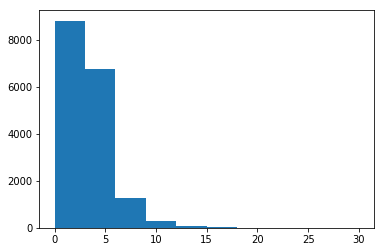

In [57]:
plt.hist(SA_data.sentences)

(array([  1.53900000e+04,   1.62900000e+03,   1.39000000e+02,
          4.00000000e+01,   3.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  0. ,   3.6,   7.2,  10.8,  14.4,  18. ,  21.6,  25.2,  28.8,
         32.4,  36. ]),
 <a list of 10 Patch objects>)

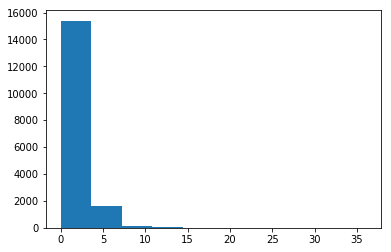

In [58]:
plt.hist(SA_data.continuations)

# Keras Modelling

In [5]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Activation, Dropout, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Regression

In [70]:
#Processing short answer - DEPRECATED
train_sa_x,test_sa_x,train_sa_y,test_sa_y = train_test_split(np.asarray(SA_data.EssayText), np.asarray(SA_data.average_score),test_size=0.15)

max_words = len(tfidf_SA.vocabulary_.keys())
max_len = max(SA_data.EssayLength)

tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(pd.Series(train_sa_x))
sequences = tok.texts_to_sequences(train_sa_x)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

sequences_test = tok.texts_to_sequences(test_sa_x)
sequences_test_matrix = sequence.pad_sequences(sequences_test,maxlen=max_len)

In [ ]:
#previous normalization - DEPRECATED in favor of work done here: 
#predict domain1_score using essay
#toy set, just essay prompt 1
#huyen claims that the model determines proper score across sets
# preprocessing of all essays from sets 1-6 included
classification_data = all_data[all_data.essay_set < 7]

# score normalization
for i in range (1,7):
    if(i==1):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score']
    elif (i==2):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] * 2
    elif (i==3):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] * 4
    else:
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] * 3
#classification_data.head(10)



In [46]:
#https://github.com/SahilC/AutomaticEssayGrading/blob/master/src/Essay.py
classification_data = all_data
DivSeries = pd.DataFrame({'div': [12,5,3,3,4,4,25,50],'dataset':[1,2,3,4,5,6,7,8]})

# score normalization
for i in all_data.essay_set.unique():
    if(i==1):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 12
    elif (i==2):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 5
    elif (i in (3,4)):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 3
    elif (i in (5,6)):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 4
    elif (i == 7):
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 25
    else:
        classification_data.loc[classification_data.essay_set == i, 'adjusted_domain1_score'] = classification_data.loc[classification_data.essay_set == i, 'domain1_score'] / 50


train_sa_x_class,test_sa_x_class,train_sa_y_class,test_sa_y_class = train_test_split(np.asarray(classification_data.essay), classification_data[['adjusted_domain1_score','essay_set']],test_size=0.2)

max_len_class = all_data.essay.apply(EssayLength).sort_values(ascending=True).iloc[int(np.floor(len(all_data)*.95))]

tok_class = Tokenizer()
tok_class.fit_on_texts(pd.Series(train_sa_x_class))
sequences_class = tok_class.texts_to_sequences(train_sa_x_class)
sequences_matrix_class = sequence.pad_sequences(sequences_class,maxlen=max_len_class)

sequences_test_class = tok_class.texts_to_sequences(test_sa_x_class)
sequences_test_matrix_class = sequence.pad_sequences(sequences_test_class,maxlen=max_len_class)

In [47]:
#looking to pull glove embeddings so no embedding training required.
import csv
#gloves = pd.read_table(r"C:\Users\nivelaga\Documents\Berkeley\w266final\glove.42B.300d\glove.42B.300d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((len(tok_class.word_index)+1, 300))
for word, i in tqdm_notebook(tok_class.word_index.items()):
    if word in gloves.index:
        embedding_matrix[i] = np.asarray(gloves.loc[word])
    else:
        embedding_matrix[i] = np.zeros(300)

A Jupyter Widget

In [ ]:
sahil_model_rnn = Sequential()
sahil_model_rnn.add(tf.keras.layers.Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
sahil_model_rnn.add(tf.keras.layers.LSTM(20, return_sequences=True))
sahil_model_rnn.add(tf.keras.layers.LSTM(20, return_sequences=True))
sahil_model_rnn.add(tf.keras.layers.LSTM(20))
sahil_model_rnn.add(tf.keras.layers.Dense(1,name='out_layer'))
sahil_model_rnn.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
sahil_model_rnn.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=100, validation_split=0.15)

In [109]:
sahil_model_cnn = Sequential()
sahil_model_cnn.add(tf.keras.layers.Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
sahil_model_cnn.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
sahil_model_cnn.add(tf.keras.layers.MaxPooling1D(pool_size=4))
sahil_model_cnn.add(tf.keras.layers.Flatten())
sahil_model_cnn.add(tf.keras.layers.Dense(25,name='deep_layer'))
sahil_model_cnn.add(tf.keras.layers.Dense(1,name='out_layer'))
sahil_model_cnn.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
sahil_model_cnn.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=100, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/100
8823/8823 [==============================] - ETA: 45s - loss: 0.3286 - acc: 0.03 - ETA: 35s - loss: 43.8777 - acc: 0.020 - ETA: 31s - loss: 30.8955 - acc: 0.016 - ETA: 27s - loss: 24.2272 - acc: 0.019 - ETA: 25s - loss: 22.9301 - acc: 0.021 - ETA: 22s - loss: 21.6625 - acc: 0.020 - ETA: 20s - loss: 20.5377 - acc: 0.018 - ETA: 18s - loss: 19.0086 - acc: 0.017 - ETA: 16s - loss: 17.4749 - acc: 0.020 - ETA: 14s - loss: 16.0761 - acc: 0.022 - ETA: 12s - loss: 14.7990 - acc: 0.022 - ETA: 10s - loss: 13.6699 - acc: 0.023 - ETA: 8s - loss: 12.6851 - acc: 0.024 - ETA: 6s - loss: 11.8249 - acc: 0.02 - ETA: 4s - loss: 11.0683 - acc: 0.02 - ETA: 3s - loss: 10.4025 - acc: 0.02 - ETA: 1s - loss: 9.8114 - acc: 0.0274 - 36s 4ms/step - loss: 9.4627 - acc: 0.0270 - val_loss: 0.2635 - val_acc: 0.0302
Epoch 2/100
8823/8823 [==============================] - ETA: 30s - loss: 0.2497 - acc: 0.04 - ETA: 28s - loss: 0.2412 - acc: 0.04 - ETA: 26s - lo

8823/8823 [==============================] - ETA: 29s - loss: 0.0328 - acc: 0.15 - ETA: 27s - loss: 0.0297 - acc: 0.14 - ETA: 25s - loss: 0.0293 - acc: 0.13 - ETA: 23s - loss: 0.0289 - acc: 0.13 - ETA: 22s - loss: 0.0291 - acc: 0.13 - ETA: 20s - loss: 0.0293 - acc: 0.13 - ETA: 18s - loss: 0.0294 - acc: 0.14 - ETA: 16s - loss: 0.0294 - acc: 0.14 - ETA: 15s - loss: 0.0296 - acc: 0.14 - ETA: 13s - loss: 0.0297 - acc: 0.14 - ETA: 11s - loss: 0.0295 - acc: 0.13 - ETA: 9s - loss: 0.0297 - acc: 0.1412 - ETA: 8s - loss: 0.0294 - acc: 0.140 - ETA: 6s - loss: 0.0296 - acc: 0.140 - ETA: 4s - loss: 0.0296 - acc: 0.140 - ETA: 2s - loss: 0.0298 - acc: 0.139 - ETA: 1s - loss: 0.0299 - acc: 0.138 - 33s 4ms/step - loss: 0.0298 - acc: 0.1386 - val_loss: 0.0276 - val_acc: 0.1362
Epoch 12/100
8823/8823 [==============================] - ETA: 29s - loss: 0.0264 - acc: 0.13 - ETA: 27s - loss: 0.0268 - acc: 0.12 - ETA: 25s - loss: 0.0287 - acc: 0.13 - ETA: 23s - loss: 0.0297 - acc: 0.13 - ETA: 22s - loss: 0.

8823/8823 [==============================] - ETA: 29s - loss: 0.0270 - acc: 0.13 - ETA: 27s - loss: 0.0252 - acc: 0.14 - ETA: 25s - loss: 0.0256 - acc: 0.13 - ETA: 24s - loss: 0.0254 - acc: 0.12 - ETA: 22s - loss: 0.0255 - acc: 0.12 - ETA: 20s - loss: 0.0257 - acc: 0.13 - ETA: 18s - loss: 0.0259 - acc: 0.13 - ETA: 17s - loss: 0.0255 - acc: 0.13 - ETA: 15s - loss: 0.0256 - acc: 0.13 - ETA: 13s - loss: 0.0258 - acc: 0.13 - ETA: 11s - loss: 0.0258 - acc: 0.13 - ETA: 9s - loss: 0.0257 - acc: 0.1373 - ETA: 8s - loss: 0.0252 - acc: 0.139 - ETA: 6s - loss: 0.0253 - acc: 0.139 - ETA: 4s - loss: 0.0253 - acc: 0.140 - ETA: 2s - loss: 0.0255 - acc: 0.138 - ETA: 1s - loss: 0.0253 - acc: 0.138 - 34s 4ms/step - loss: 0.0253 - acc: 0.1388 - val_loss: 0.0248 - val_acc: 0.1362
Epoch 22/100
8823/8823 [==============================] - ETA: 29s - loss: 0.0252 - acc: 0.14 - ETA: 27s - loss: 0.0272 - acc: 0.15 - ETA: 26s - loss: 0.0259 - acc: 0.15 - ETA: 24s - loss: 0.0255 - acc: 0.15 - ETA: 22s - loss: 0.

8823/8823 [==============================] - ETA: 28s - loss: 0.0235 - acc: 0.14 - ETA: 27s - loss: 0.0228 - acc: 0.14 - ETA: 25s - loss: 0.0222 - acc: 0.14 - ETA: 23s - loss: 0.0224 - acc: 0.14 - ETA: 22s - loss: 0.0222 - acc: 0.14 - ETA: 20s - loss: 0.0225 - acc: 0.14 - ETA: 18s - loss: 0.0225 - acc: 0.14 - ETA: 16s - loss: 0.0225 - acc: 0.14 - ETA: 15s - loss: 0.0222 - acc: 0.13 - ETA: 13s - loss: 0.0222 - acc: 0.14 - ETA: 11s - loss: 0.0222 - acc: 0.14 - ETA: 9s - loss: 0.0224 - acc: 0.1420 - ETA: 8s - loss: 0.0228 - acc: 0.141 - ETA: 6s - loss: 0.0228 - acc: 0.140 - ETA: 4s - loss: 0.0226 - acc: 0.139 - ETA: 2s - loss: 0.0226 - acc: 0.138 - ETA: 1s - loss: 0.0225 - acc: 0.139 - 34s 4ms/step - loss: 0.0227 - acc: 0.1394 - val_loss: 0.0235 - val_acc: 0.1362
Epoch 32/100
8823/8823 [==============================] - ETA: 31s - loss: 0.0225 - acc: 0.13 - ETA: 29s - loss: 0.0217 - acc: 0.13 - ETA: 27s - loss: 0.0219 - acc: 0.13 - ETA: 24s - loss: 0.0218 - acc: 0.13 - ETA: 22s - loss: 0.

8823/8823 [==============================] - ETA: 28s - loss: 0.0201 - acc: 0.11 - ETA: 27s - loss: 0.0213 - acc: 0.13 - ETA: 25s - loss: 0.0202 - acc: 0.13 - ETA: 24s - loss: 0.0204 - acc: 0.13 - ETA: 22s - loss: 0.0198 - acc: 0.13 - ETA: 20s - loss: 0.0203 - acc: 0.13 - ETA: 18s - loss: 0.0205 - acc: 0.13 - ETA: 16s - loss: 0.0202 - acc: 0.13 - ETA: 15s - loss: 0.0203 - acc: 0.13 - ETA: 13s - loss: 0.0203 - acc: 0.14 - ETA: 11s - loss: 0.0203 - acc: 0.13 - ETA: 9s - loss: 0.0204 - acc: 0.1388 - ETA: 8s - loss: 0.0203 - acc: 0.140 - ETA: 6s - loss: 0.0206 - acc: 0.141 - ETA: 4s - loss: 0.0206 - acc: 0.140 - ETA: 2s - loss: 0.0206 - acc: 0.140 - ETA: 1s - loss: 0.0206 - acc: 0.139 - 34s 4ms/step - loss: 0.0207 - acc: 0.1397 - val_loss: 0.0228 - val_acc: 0.1362
Epoch 42/100
8823/8823 [==============================] - ETA: 28s - loss: 0.0189 - acc: 0.14 - ETA: 27s - loss: 0.0198 - acc: 0.14 - ETA: 25s - loss: 0.0197 - acc: 0.14 - ETA: 23s - loss: 0.0207 - acc: 0.14 - ETA: 22s - loss: 0.

8823/8823 [==============================] - ETA: 29s - loss: 0.0203 - acc: 0.14 - ETA: 27s - loss: 0.0202 - acc: 0.15 - ETA: 25s - loss: 0.0194 - acc: 0.14 - ETA: 24s - loss: 0.0194 - acc: 0.13 - ETA: 22s - loss: 0.0193 - acc: 0.14 - ETA: 20s - loss: 0.0191 - acc: 0.14 - ETA: 18s - loss: 0.0186 - acc: 0.14 - ETA: 17s - loss: 0.0186 - acc: 0.14 - ETA: 15s - loss: 0.0188 - acc: 0.14 - ETA: 13s - loss: 0.0188 - acc: 0.14 - ETA: 11s - loss: 0.0190 - acc: 0.14 - ETA: 10s - loss: 0.0190 - acc: 0.14 - ETA: 8s - loss: 0.0191 - acc: 0.1438 - ETA: 6s - loss: 0.0190 - acc: 0.142 - ETA: 4s - loss: 0.0189 - acc: 0.141 - ETA: 2s - loss: 0.0188 - acc: 0.140 - ETA: 1s - loss: 0.0189 - acc: 0.140 - 34s 4ms/step - loss: 0.0190 - acc: 0.1405 - val_loss: 0.0226 - val_acc: 0.1362
Epoch 52/100
8823/8823 [==============================] - ETA: 29s - loss: 0.0211 - acc: 0.15 - ETA: 27s - loss: 0.0196 - acc: 0.13 - ETA: 25s - loss: 0.0194 - acc: 0.13 - ETA: 23s - loss: 0.0192 - acc: 0.12 - ETA: 22s - loss: 0.

8823/8823 [==============================] - ETA: 29s - loss: 0.0159 - acc: 0.15 - ETA: 27s - loss: 0.0164 - acc: 0.14 - ETA: 25s - loss: 0.0164 - acc: 0.13 - ETA: 23s - loss: 0.0164 - acc: 0.13 - ETA: 22s - loss: 0.0161 - acc: 0.12 - ETA: 20s - loss: 0.0165 - acc: 0.13 - ETA: 18s - loss: 0.0164 - acc: 0.13 - ETA: 16s - loss: 0.0168 - acc: 0.13 - ETA: 15s - loss: 0.0170 - acc: 0.13 - ETA: 13s - loss: 0.0171 - acc: 0.13 - ETA: 11s - loss: 0.0172 - acc: 0.13 - ETA: 9s - loss: 0.0174 - acc: 0.1415 - ETA: 8s - loss: 0.0172 - acc: 0.141 - ETA: 6s - loss: 0.0173 - acc: 0.141 - ETA: 4s - loss: 0.0172 - acc: 0.141 - ETA: 2s - loss: 0.0173 - acc: 0.140 - ETA: 1s - loss: 0.0175 - acc: 0.140 - 34s 4ms/step - loss: 0.0175 - acc: 0.1407 - val_loss: 0.0224 - val_acc: 0.1362
Epoch 62/100
8823/8823 [==============================] - ETA: 29s - loss: 0.0176 - acc: 0.14 - ETA: 27s - loss: 0.0176 - acc: 0.14 - ETA: 25s - loss: 0.0180 - acc: 0.14 - ETA: 23s - loss: 0.0174 - acc: 0.13 - ETA: 22s - loss: 0.

8823/8823 [==============================] - ETA: 29s - loss: 0.0159 - acc: 0.15 - ETA: 27s - loss: 0.0171 - acc: 0.16 - ETA: 25s - loss: 0.0166 - acc: 0.15 - ETA: 24s - loss: 0.0164 - acc: 0.15 - ETA: 22s - loss: 0.0162 - acc: 0.14 - ETA: 20s - loss: 0.0158 - acc: 0.14 - ETA: 19s - loss: 0.0160 - acc: 0.14 - ETA: 17s - loss: 0.0157 - acc: 0.14 - ETA: 15s - loss: 0.0160 - acc: 0.14 - ETA: 13s - loss: 0.0159 - acc: 0.14 - ETA: 11s - loss: 0.0156 - acc: 0.14 - ETA: 10s - loss: 0.0158 - acc: 0.14 - ETA: 8s - loss: 0.0158 - acc: 0.1420 - ETA: 6s - loss: 0.0157 - acc: 0.141 - ETA: 4s - loss: 0.0160 - acc: 0.141 - ETA: 2s - loss: 0.0159 - acc: 0.141 - ETA: 1s - loss: 0.0159 - acc: 0.141 - 34s 4ms/step - loss: 0.0160 - acc: 0.1413 - val_loss: 0.0228 - val_acc: 0.1362
Epoch 72/100
8823/8823 [==============================] - ETA: 29s - loss: 0.0151 - acc: 0.17 - ETA: 27s - loss: 0.0160 - acc: 0.15 - ETA: 25s - loss: 0.0159 - acc: 0.14 - ETA: 23s - loss: 0.0153 - acc: 0.14 - ETA: 22s - loss: 0.

8823/8823 [==============================] - ETA: 29s - loss: 0.0121 - acc: 0.16 - ETA: 27s - loss: 0.0144 - acc: 0.15 - ETA: 25s - loss: 0.0147 - acc: 0.14 - ETA: 23s - loss: 0.0149 - acc: 0.14 - ETA: 22s - loss: 0.0150 - acc: 0.14 - ETA: 20s - loss: 0.0147 - acc: 0.13 - ETA: 18s - loss: 0.0147 - acc: 0.14 - ETA: 16s - loss: 0.0145 - acc: 0.14 - ETA: 15s - loss: 0.0146 - acc: 0.14 - ETA: 13s - loss: 0.0145 - acc: 0.14 - ETA: 11s - loss: 0.0145 - acc: 0.14 - ETA: 9s - loss: 0.0145 - acc: 0.1427 - ETA: 8s - loss: 0.0145 - acc: 0.141 - ETA: 6s - loss: 0.0144 - acc: 0.141 - ETA: 4s - loss: 0.0145 - acc: 0.140 - ETA: 2s - loss: 0.0146 - acc: 0.141 - ETA: 1s - loss: 0.0144 - acc: 0.142 - 34s 4ms/step - loss: 0.0144 - acc: 0.1418 - val_loss: 0.0233 - val_acc: 0.1362
Epoch 82/100
8823/8823 [==============================] - ETA: 29s - loss: 0.0146 - acc: 0.14 - ETA: 27s - loss: 0.0140 - acc: 0.14 - ETA: 25s - loss: 0.0136 - acc: 0.13 - ETA: 24s - loss: 0.0142 - acc: 0.13 - ETA: 22s - loss: 0.

8823/8823 [==============================] - ETA: 29s - loss: 0.0126 - acc: 0.14 - ETA: 27s - loss: 0.0133 - acc: 0.15 - ETA: 25s - loss: 0.0133 - acc: 0.14 - ETA: 24s - loss: 0.0130 - acc: 0.14 - ETA: 22s - loss: 0.0130 - acc: 0.14 - ETA: 20s - loss: 0.0127 - acc: 0.13 - ETA: 18s - loss: 0.0127 - acc: 0.13 - ETA: 16s - loss: 0.0128 - acc: 0.14 - ETA: 15s - loss: 0.0130 - acc: 0.14 - ETA: 13s - loss: 0.0130 - acc: 0.13 - ETA: 11s - loss: 0.0129 - acc: 0.14 - ETA: 9s - loss: 0.0129 - acc: 0.1407 - ETA: 8s - loss: 0.0129 - acc: 0.138 - ETA: 6s - loss: 0.0129 - acc: 0.140 - ETA: 4s - loss: 0.0128 - acc: 0.140 - ETA: 2s - loss: 0.0128 - acc: 0.140 - ETA: 1s - loss: 0.0129 - acc: 0.141 - 34s 4ms/step - loss: 0.0129 - acc: 0.1419 - val_loss: 0.0240 - val_acc: 0.1362
Epoch 92/100
8823/8823 [==============================] - ETA: 28s - loss: 0.0111 - acc: 0.12 - ETA: 27s - loss: 0.0119 - acc: 0.11 - ETA: 25s - loss: 0.0122 - acc: 0.13 - ETA: 23s - loss: 0.0127 - acc: 0.13 - ETA: 22s - loss: 0.

Train on 8823 samples, validate on 1557 samples
Epoch 1/100
8823/8823 [==============================] - ETA: 2:01 - loss: 0.3755 - acc: 0.032 - ETA: 1:35 - loss: 0.3492 - acc: 0.027 - ETA: 1:23 - loss: 0.3172 - acc: 0.028 - ETA: 1:14 - loss: 0.2936 - acc: 0.027 - ETA: 1:07 - loss: 0.2741 - acc: 0.030 - ETA: 1:00 - loss: 0.2490 - acc: 0.032 - ETA: 55s - loss: 0.2282 - acc: 0.033 - ETA: 49s - loss: 0.2090 - acc: 0.03 - ETA: 43s - loss: 0.1922 - acc: 0.04 - ETA: 38s - loss: 0.1786 - acc: 0.05 - ETA: 33s - loss: 0.1686 - acc: 0.05 - ETA: 27s - loss: 0.1609 - acc: 0.06 - ETA: 22s - loss: 0.1546 - acc: 0.06 - ETA: 17s - loss: 0.1490 - acc: 0.06 - ETA: 12s - loss: 0.1439 - acc: 0.07 - ETA: 7s - loss: 0.1400 - acc: 0.0765 - ETA: 3s - loss: 0.1357 - acc: 0.078 - 94s 11ms/step - loss: 0.1333 - acc: 0.0796 - val_loss: 0.0553 - val_acc: 0.1085
Epoch 2/100
8823/8823 [==============================] - ETA: 1:17 - loss: 0.0626 - acc: 0.104 - ETA: 1:11 - loss: 0.0600 - acc: 0.111 - ETA: 1:07 - loss: 

8823/8823 [==============================] - ETA: 1:25 - loss: 0.0322 - acc: 0.144 - ETA: 1:22 - loss: 0.0309 - acc: 0.132 - ETA: 1:17 - loss: 0.0310 - acc: 0.132 - ETA: 1:12 - loss: 0.0315 - acc: 0.130 - ETA: 1:07 - loss: 0.0315 - acc: 0.126 - ETA: 1:02 - loss: 0.0310 - acc: 0.133 - ETA: 56s - loss: 0.0311 - acc: 0.134 - ETA: 51s - loss: 0.0311 - acc: 0.13 - ETA: 46s - loss: 0.0307 - acc: 0.13 - ETA: 41s - loss: 0.0306 - acc: 0.13 - ETA: 35s - loss: 0.0303 - acc: 0.13 - ETA: 30s - loss: 0.0298 - acc: 0.13 - ETA: 25s - loss: 0.0298 - acc: 0.13 - ETA: 19s - loss: 0.0302 - acc: 0.13 - ETA: 14s - loss: 0.0300 - acc: 0.13 - ETA: 9s - loss: 0.0300 - acc: 0.1381 - ETA: 3s - loss: 0.0299 - acc: 0.138 - 105s 12ms/step - loss: 0.0298 - acc: 0.1385 - val_loss: 0.0270 - val_acc: 0.1362
Epoch 12/100
8823/8823 [==============================] - ETA: 1:26 - loss: 0.0276 - acc: 0.148 - ETA: 1:22 - loss: 0.0262 - acc: 0.145 - ETA: 1:17 - loss: 0.0260 - acc: 0.145 - ETA: 1:13 - loss: 0.0271 - acc: 0.15

8823/8823 [==============================] - ETA: 1:31 - loss: 0.0168 - acc: 0.134 - ETA: 1:27 - loss: 0.0199 - acc: 0.136 - ETA: 1:21 - loss: 0.0198 - acc: 0.141 - ETA: 1:16 - loss: 0.0199 - acc: 0.136 - ETA: 1:10 - loss: 0.0192 - acc: 0.136 - ETA: 1:05 - loss: 0.0188 - acc: 0.135 - ETA: 59s - loss: 0.0186 - acc: 0.138 - ETA: 54s - loss: 0.0186 - acc: 0.14 - ETA: 48s - loss: 0.0187 - acc: 0.14 - ETA: 43s - loss: 0.0191 - acc: 0.14 - ETA: 37s - loss: 0.0189 - acc: 0.14 - ETA: 31s - loss: 0.0188 - acc: 0.14 - ETA: 26s - loss: 0.0192 - acc: 0.14 - ETA: 20s - loss: 0.0193 - acc: 0.14 - ETA: 14s - loss: 0.0192 - acc: 0.14 - ETA: 9s - loss: 0.0192 - acc: 0.1407 - ETA: 3s - loss: 0.0192 - acc: 0.140 - 108s 12ms/step - loss: 0.0192 - acc: 0.1412 - val_loss: 0.0197 - val_acc: 0.1368
Epoch 22/100
8823/8823 [==============================] - ETA: 1:30 - loss: 0.0172 - acc: 0.148 - ETA: 1:26 - loss: 0.0172 - acc: 0.145 - ETA: 1:21 - loss: 0.0179 - acc: 0.139 - ETA: 1:16 - loss: 0.0176 - acc: 0.14

8823/8823 [==============================] - ETA: 1:30 - loss: 0.0174 - acc: 0.170 - ETA: 1:25 - loss: 0.0166 - acc: 0.147 - ETA: 1:19 - loss: 0.0160 - acc: 0.136 - ETA: 1:15 - loss: 0.0166 - acc: 0.137 - ETA: 1:09 - loss: 0.0168 - acc: 0.139 - ETA: 1:04 - loss: 0.0167 - acc: 0.140 - ETA: 59s - loss: 0.0172 - acc: 0.140 - ETA: 53s - loss: 0.0172 - acc: 0.14 - ETA: 48s - loss: 0.0172 - acc: 0.14 - ETA: 42s - loss: 0.0173 - acc: 0.14 - ETA: 37s - loss: 0.0174 - acc: 0.14 - ETA: 31s - loss: 0.0172 - acc: 0.14 - ETA: 26s - loss: 0.0172 - acc: 0.14 - ETA: 20s - loss: 0.0173 - acc: 0.14 - ETA: 14s - loss: 0.0173 - acc: 0.14 - ETA: 9s - loss: 0.0172 - acc: 0.1437 - ETA: 3s - loss: 0.0172 - acc: 0.142 - 108s 12ms/step - loss: 0.0171 - acc: 0.1413 - val_loss: 0.0185 - val_acc: 0.1368
Epoch 32/100
8823/8823 [==============================] - ETA: 1:32 - loss: 0.0172 - acc: 0.144 - ETA: 1:25 - loss: 0.0159 - acc: 0.149 - ETA: 1:20 - loss: 0.0157 - acc: 0.148 - ETA: 1:15 - loss: 0.0167 - acc: 0.14

8823/8823 [==============================] - ETA: 1:31 - loss: 0.0195 - acc: 0.146 - ETA: 1:27 - loss: 0.0167 - acc: 0.148 - ETA: 1:22 - loss: 0.0160 - acc: 0.143 - ETA: 1:17 - loss: 0.0157 - acc: 0.141 - ETA: 1:11 - loss: 0.0156 - acc: 0.138 - ETA: 1:06 - loss: 0.0156 - acc: 0.141 - ETA: 1:00 - loss: 0.0157 - acc: 0.141 - ETA: 55s - loss: 0.0157 - acc: 0.141 - ETA: 49s - loss: 0.0157 - acc: 0.14 - ETA: 43s - loss: 0.0156 - acc: 0.14 - ETA: 38s - loss: 0.0154 - acc: 0.14 - ETA: 32s - loss: 0.0155 - acc: 0.14 - ETA: 26s - loss: 0.0154 - acc: 0.14 - ETA: 21s - loss: 0.0154 - acc: 0.14 - ETA: 15s - loss: 0.0155 - acc: 0.14 - ETA: 9s - loss: 0.0155 - acc: 0.1424 - ETA: 3s - loss: 0.0154 - acc: 0.141 - 111s 13ms/step - loss: 0.0154 - acc: 0.1414 - val_loss: 0.0185 - val_acc: 0.1368
Epoch 42/100
8823/8823 [==============================] - ETA: 1:34 - loss: 0.0159 - acc: 0.134 - ETA: 1:29 - loss: 0.0163 - acc: 0.149 - ETA: 1:23 - loss: 0.0163 - acc: 0.152 - ETA: 1:17 - loss: 0.0163 - acc: 0.

8823/8823 [==============================] - ETA: 1:31 - loss: 0.0150 - acc: 0.148 - ETA: 1:26 - loss: 0.0146 - acc: 0.149 - ETA: 1:21 - loss: 0.0141 - acc: 0.145 - ETA: 1:16 - loss: 0.0143 - acc: 0.147 - ETA: 1:10 - loss: 0.0141 - acc: 0.149 - ETA: 1:05 - loss: 0.0142 - acc: 0.145 - ETA: 59s - loss: 0.0143 - acc: 0.147 - ETA: 54s - loss: 0.0141 - acc: 0.14 - ETA: 48s - loss: 0.0144 - acc: 0.14 - ETA: 43s - loss: 0.0143 - acc: 0.14 - ETA: 37s - loss: 0.0146 - acc: 0.14 - ETA: 32s - loss: 0.0145 - acc: 0.14 - ETA: 26s - loss: 0.0145 - acc: 0.14 - ETA: 20s - loss: 0.0145 - acc: 0.14 - ETA: 15s - loss: 0.0144 - acc: 0.14 - ETA: 9s - loss: 0.0144 - acc: 0.1409 - ETA: 3s - loss: 0.0143 - acc: 0.140 - 109s 12ms/step - loss: 0.0144 - acc: 0.1417 - val_loss: 0.0188 - val_acc: 0.1368
Epoch 52/100
8823/8823 [==============================] - ETA: 1:32 - loss: 0.0136 - acc: 0.152 - ETA: 1:28 - loss: 0.0145 - acc: 0.143 - ETA: 1:22 - loss: 0.0146 - acc: 0.145 - ETA: 1:17 - loss: 0.0147 - acc: 0.14

8823/8823 [==============================] - ETA: 1:37 - loss: 0.0124 - acc: 0.138 - ETA: 1:31 - loss: 0.0122 - acc: 0.144 - ETA: 1:24 - loss: 0.0132 - acc: 0.144 - ETA: 1:19 - loss: 0.0133 - acc: 0.145 - ETA: 1:13 - loss: 0.0133 - acc: 0.142 - ETA: 1:07 - loss: 0.0131 - acc: 0.142 - ETA: 1:01 - loss: 0.0129 - acc: 0.142 - ETA: 56s - loss: 0.0132 - acc: 0.143 - ETA: 50s - loss: 0.0132 - acc: 0.14 - ETA: 44s - loss: 0.0131 - acc: 0.14 - ETA: 38s - loss: 0.0130 - acc: 0.14 - ETA: 33s - loss: 0.0129 - acc: 0.14 - ETA: 27s - loss: 0.0129 - acc: 0.14 - ETA: 21s - loss: 0.0128 - acc: 0.14 - ETA: 15s - loss: 0.0129 - acc: 0.14 - ETA: 9s - loss: 0.0129 - acc: 0.1421 - ETA: 3s - loss: 0.0129 - acc: 0.141 - 113s 13ms/step - loss: 0.0130 - acc: 0.1419 - val_loss: 0.0188 - val_acc: 0.1368
Epoch 62/100
8823/8823 [==============================] - ETA: 1:35 - loss: 0.0118 - acc: 0.170 - ETA: 1:30 - loss: 0.0132 - acc: 0.149 - ETA: 1:25 - loss: 0.0130 - acc: 0.156 - ETA: 1:19 - loss: 0.0133 - acc: 0.

8823/8823 [==============================] - ETA: 1:36 - loss: 0.0146 - acc: 0.154 - ETA: 1:29 - loss: 0.0128 - acc: 0.160 - ETA: 1:24 - loss: 0.0127 - acc: 0.151 - ETA: 1:18 - loss: 0.0125 - acc: 0.145 - ETA: 1:13 - loss: 0.0129 - acc: 0.145 - ETA: 1:07 - loss: 0.0127 - acc: 0.143 - ETA: 1:01 - loss: 0.0127 - acc: 0.146 - ETA: 56s - loss: 0.0124 - acc: 0.147 - ETA: 50s - loss: 0.0122 - acc: 0.14 - ETA: 44s - loss: 0.0121 - acc: 0.14 - ETA: 38s - loss: 0.0120 - acc: 0.14 - ETA: 33s - loss: 0.0122 - acc: 0.14 - ETA: 27s - loss: 0.0123 - acc: 0.14 - ETA: 21s - loss: 0.0123 - acc: 0.14 - ETA: 15s - loss: 0.0122 - acc: 0.14 - ETA: 9s - loss: 0.0122 - acc: 0.1421 - ETA: 3s - loss: 0.0122 - acc: 0.141 - 111s 13ms/step - loss: 0.0122 - acc: 0.1419 - val_loss: 0.0201 - val_acc: 0.1349
Epoch 72/100
8823/8823 [==============================] - ETA: 1:38 - loss: 0.0127 - acc: 0.122 - ETA: 1:31 - loss: 0.0121 - acc: 0.120 - ETA: 1:25 - loss: 0.0132 - acc: 0.129 - ETA: 1:19 - loss: 0.0128 - acc: 0.

8823/8823 [==============================] - ETA: 1:38 - loss: 0.0131 - acc: 0.134 - ETA: 1:31 - loss: 0.0117 - acc: 0.141 - ETA: 1:25 - loss: 0.0108 - acc: 0.142 - ETA: 1:19 - loss: 0.0109 - acc: 0.142 - ETA: 1:13 - loss: 0.0111 - acc: 0.144 - ETA: 1:07 - loss: 0.0108 - acc: 0.142 - ETA: 1:01 - loss: 0.0107 - acc: 0.140 - ETA: 56s - loss: 0.0106 - acc: 0.141 - ETA: 50s - loss: 0.0109 - acc: 0.14 - ETA: 44s - loss: 0.0110 - acc: 0.14 - ETA: 38s - loss: 0.0110 - acc: 0.14 - ETA: 33s - loss: 0.0109 - acc: 0.14 - ETA: 27s - loss: 0.0110 - acc: 0.14 - ETA: 21s - loss: 0.0110 - acc: 0.14 - ETA: 15s - loss: 0.0109 - acc: 0.14 - ETA: 9s - loss: 0.0108 - acc: 0.1416 - ETA: 3s - loss: 0.0108 - acc: 0.141 - 112s 13ms/step - loss: 0.0107 - acc: 0.1420 - val_loss: 0.0200 - val_acc: 0.1355
Epoch 82/100
8823/8823 [==============================] - ETA: 1:38 - loss: 0.0095 - acc: 0.142 - ETA: 1:32 - loss: 0.0102 - acc: 0.142 - ETA: 1:26 - loss: 0.0097 - acc: 0.137 - ETA: 1:19 - loss: 0.0101 - acc: 0.

8823/8823 [==============================] - ETA: 1:35 - loss: 0.0098 - acc: 0.126 - ETA: 1:31 - loss: 0.0100 - acc: 0.141 - ETA: 1:25 - loss: 0.0099 - acc: 0.135 - ETA: 1:20 - loss: 0.0105 - acc: 0.140 - ETA: 1:14 - loss: 0.0106 - acc: 0.138 - ETA: 1:08 - loss: 0.0104 - acc: 0.141 - ETA: 1:02 - loss: 0.0105 - acc: 0.143 - ETA: 56s - loss: 0.0104 - acc: 0.141 - ETA: 50s - loss: 0.0104 - acc: 0.13 - ETA: 44s - loss: 0.0102 - acc: 0.13 - ETA: 39s - loss: 0.0101 - acc: 0.14 - ETA: 33s - loss: 0.0103 - acc: 0.14 - ETA: 27s - loss: 0.0102 - acc: 0.14 - ETA: 21s - loss: 0.0101 - acc: 0.14 - ETA: 15s - loss: 0.0100 - acc: 0.14 - ETA: 9s - loss: 0.0100 - acc: 0.1404 - ETA: 3s - loss: 0.0101 - acc: 0.141 - 114s 13ms/step - loss: 0.0101 - acc: 0.1424 - val_loss: 0.0203 - val_acc: 0.1355
Epoch 92/100
8823/8823 [==============================] - ETA: 1:38 - loss: 0.0102 - acc: 0.144 - ETA: 1:33 - loss: 0.0103 - acc: 0.132 - ETA: 1:27 - loss: 0.0101 - acc: 0.142 - ETA: 1:21 - loss: 0.0099 - acc: 0.

In [110]:
sahil_model_ff = Sequential()
sahil_model_ff.add(tf.keras.layers.Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
sahil_model_ff.add(tf.keras.layers.Dense(100,name='deep1'))
sahil_model_ff.add(tf.keras.layers.Dense(50,name='deep2'))
sahil_model_ff.add(tf.keras.layers.Flatten())
sahil_model_ff.add(tf.keras.layers.Dense(1,activation='sigmoid',name='out_layer'))
sahil_model_ff.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
sahil_model_ff.fit(sequences_matrix_class,train_sa_y_class.adjusted_domain1_score, batch_size = 500, epochs=100, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/100
8823/8823 [==============================] - ETA: 25s - loss: 0.0681 - acc: 0.07 - ETA: 17s - loss: 0.0853 - acc: 0.10 - ETA: 14s - loss: 0.0934 - acc: 0.10 - ETA: 12s - loss: 0.0945 - acc: 0.10 - ETA: 10s - loss: 0.0884 - acc: 0.11 - ETA: 9s - loss: 0.0830 - acc: 0.1133 - ETA: 8s - loss: 0.0810 - acc: 0.114 - ETA: 7s - loss: 0.0801 - acc: 0.115 - ETA: 6s - loss: 0.0770 - acc: 0.116 - ETA: 5s - loss: 0.0740 - acc: 0.119 - ETA: 4s - loss: 0.0708 - acc: 0.121 - ETA: 4s - loss: 0.0679 - acc: 0.121 - ETA: 3s - loss: 0.0662 - acc: 0.123 - ETA: 2s - loss: 0.0644 - acc: 0.124 - ETA: 1s - loss: 0.0634 - acc: 0.125 - ETA: 1s - loss: 0.0622 - acc: 0.124 - ETA: 0s - loss: 0.0609 - acc: 0.126 - 14s 2ms/step - loss: 0.0600 - acc: 0.1272 - val_loss: 0.0361 - val_acc: 0.1323
Epoch 2/100
8823/8823 [==============================] - ETA: 10s - loss: 0.0357 - acc: 0.11 - ETA: 10s - loss: 0.0401 - acc: 0.12 - ETA: 9s - loss: 0.0383 - acc: 0.1287

8823/8823 [==============================] - ETA: 10s - loss: 0.0092 - acc: 0.13 - ETA: 10s - loss: 0.0097 - acc: 0.14 - ETA: 9s - loss: 0.0097 - acc: 0.1420 - ETA: 9s - loss: 0.0098 - acc: 0.140 - ETA: 8s - loss: 0.0098 - acc: 0.139 - ETA: 7s - loss: 0.0097 - acc: 0.136 - ETA: 7s - loss: 0.0100 - acc: 0.140 - ETA: 6s - loss: 0.0097 - acc: 0.139 - ETA: 5s - loss: 0.0095 - acc: 0.138 - ETA: 5s - loss: 0.0095 - acc: 0.138 - ETA: 4s - loss: 0.0095 - acc: 0.140 - ETA: 3s - loss: 0.0096 - acc: 0.141 - ETA: 3s - loss: 0.0096 - acc: 0.140 - ETA: 2s - loss: 0.0096 - acc: 0.140 - ETA: 1s - loss: 0.0096 - acc: 0.141 - ETA: 1s - loss: 0.0097 - acc: 0.142 - ETA: 0s - loss: 0.0097 - acc: 0.142 - 13s 1ms/step - loss: 0.0097 - acc: 0.1427 - val_loss: 0.0284 - val_acc: 0.1355
Epoch 12/100
8823/8823 [==============================] - ETA: 11s - loss: 0.0087 - acc: 0.16 - ETA: 10s - loss: 0.0083 - acc: 0.15 - ETA: 9s - loss: 0.0086 - acc: 0.1460 - ETA: 9s - loss: 0.0088 - acc: 0.141 - ETA: 8s - loss: 0.

8823/8823 [==============================] - ETA: 11s - loss: 0.0063 - acc: 0.17 - ETA: 10s - loss: 0.0056 - acc: 0.14 - ETA: 9s - loss: 0.0060 - acc: 0.1500 - ETA: 9s - loss: 0.0059 - acc: 0.151 - ETA: 8s - loss: 0.0057 - acc: 0.148 - ETA: 7s - loss: 0.0055 - acc: 0.143 - ETA: 7s - loss: 0.0057 - acc: 0.142 - ETA: 6s - loss: 0.0058 - acc: 0.142 - ETA: 5s - loss: 0.0057 - acc: 0.139 - ETA: 5s - loss: 0.0057 - acc: 0.138 - ETA: 4s - loss: 0.0057 - acc: 0.140 - ETA: 3s - loss: 0.0056 - acc: 0.139 - ETA: 3s - loss: 0.0057 - acc: 0.140 - ETA: 2s - loss: 0.0057 - acc: 0.141 - ETA: 1s - loss: 0.0059 - acc: 0.141 - ETA: 1s - loss: 0.0059 - acc: 0.142 - ETA: 0s - loss: 0.0059 - acc: 0.142 - 13s 1ms/step - loss: 0.0059 - acc: 0.1430 - val_loss: 0.0338 - val_acc: 0.1342
Epoch 22/100
8823/8823 [==============================] - ETA: 10s - loss: 0.0067 - acc: 0.16 - ETA: 10s - loss: 0.0061 - acc: 0.16 - ETA: 9s - loss: 0.0060 - acc: 0.1480 - ETA: 9s - loss: 0.0056 - acc: 0.146 - ETA: 8s - loss: 0.

8823/8823 [==============================] - ETA: 11s - loss: 0.0041 - acc: 0.14 - ETA: 10s - loss: 0.0040 - acc: 0.15 - ETA: 9s - loss: 0.0039 - acc: 0.1507 - ETA: 9s - loss: 0.0040 - acc: 0.150 - ETA: 8s - loss: 0.0038 - acc: 0.145 - ETA: 7s - loss: 0.0038 - acc: 0.144 - ETA: 7s - loss: 0.0039 - acc: 0.141 - ETA: 6s - loss: 0.0040 - acc: 0.141 - ETA: 5s - loss: 0.0039 - acc: 0.142 - ETA: 5s - loss: 0.0039 - acc: 0.145 - ETA: 4s - loss: 0.0038 - acc: 0.144 - ETA: 3s - loss: 0.0038 - acc: 0.144 - ETA: 3s - loss: 0.0039 - acc: 0.145 - ETA: 2s - loss: 0.0039 - acc: 0.144 - ETA: 1s - loss: 0.0039 - acc: 0.142 - ETA: 1s - loss: 0.0039 - acc: 0.143 - ETA: 0s - loss: 0.0039 - acc: 0.143 - 13s 1ms/step - loss: 0.0039 - acc: 0.1431 - val_loss: 0.0390 - val_acc: 0.1317
Epoch 32/100
8823/8823 [==============================] - ETA: 10s - loss: 0.0029 - acc: 0.13 - ETA: 10s - loss: 0.0031 - acc: 0.14 - ETA: 9s - loss: 0.0034 - acc: 0.1547 - ETA: 9s - loss: 0.0033 - acc: 0.144 - ETA: 8s - loss: 0.

8823/8823 [==============================] - ETA: 10s - loss: 0.0033 - acc: 0.15 - ETA: 10s - loss: 0.0028 - acc: 0.14 - ETA: 9s - loss: 0.0029 - acc: 0.1413 - ETA: 9s - loss: 0.0030 - acc: 0.145 - ETA: 8s - loss: 0.0031 - acc: 0.143 - ETA: 7s - loss: 0.0030 - acc: 0.146 - ETA: 7s - loss: 0.0031 - acc: 0.143 - ETA: 6s - loss: 0.0032 - acc: 0.142 - ETA: 5s - loss: 0.0031 - acc: 0.141 - ETA: 5s - loss: 0.0031 - acc: 0.140 - ETA: 4s - loss: 0.0031 - acc: 0.140 - ETA: 3s - loss: 0.0031 - acc: 0.140 - ETA: 3s - loss: 0.0031 - acc: 0.140 - ETA: 2s - loss: 0.0031 - acc: 0.140 - ETA: 1s - loss: 0.0032 - acc: 0.140 - ETA: 1s - loss: 0.0032 - acc: 0.142 - ETA: 0s - loss: 0.0032 - acc: 0.144 - 13s 1ms/step - loss: 0.0032 - acc: 0.1434 - val_loss: 0.0426 - val_acc: 0.1323
Epoch 42/100
8823/8823 [==============================] - ETA: 11s - loss: 0.0037 - acc: 0.14 - ETA: 10s - loss: 0.0035 - acc: 0.14 - ETA: 9s - loss: 0.0035 - acc: 0.1480 - ETA: 9s - loss: 0.0033 - acc: 0.146 - ETA: 8s - loss: 0.

8823/8823 [==============================] - ETA: 11s - loss: 0.0022 - acc: 0.15 - ETA: 10s - loss: 0.0024 - acc: 0.14 - ETA: 9s - loss: 0.0026 - acc: 0.1527 - ETA: 9s - loss: 0.0025 - acc: 0.149 - ETA: 8s - loss: 0.0027 - acc: 0.146 - ETA: 7s - loss: 0.0027 - acc: 0.143 - ETA: 7s - loss: 0.0027 - acc: 0.147 - ETA: 6s - loss: 0.0027 - acc: 0.145 - ETA: 5s - loss: 0.0027 - acc: 0.142 - ETA: 5s - loss: 0.0027 - acc: 0.139 - ETA: 4s - loss: 0.0027 - acc: 0.139 - ETA: 3s - loss: 0.0027 - acc: 0.140 - ETA: 3s - loss: 0.0027 - acc: 0.142 - ETA: 2s - loss: 0.0027 - acc: 0.143 - ETA: 1s - loss: 0.0027 - acc: 0.142 - ETA: 1s - loss: 0.0027 - acc: 0.143 - ETA: 0s - loss: 0.0027 - acc: 0.144 - 13s 1ms/step - loss: 0.0027 - acc: 0.1434 - val_loss: 0.0464 - val_acc: 0.1310
Epoch 52/100
8823/8823 [==============================] - ETA: 10s - loss: 0.0024 - acc: 0.13 - ETA: 10s - loss: 0.0027 - acc: 0.14 - ETA: 9s - loss: 0.0027 - acc: 0.1353 - ETA: 8s - loss: 0.0026 - acc: 0.139 - ETA: 8s - loss: 0.

8823/8823 [==============================] - ETA: 10s - loss: 0.0023 - acc: 0.12 - ETA: 10s - loss: 0.0022 - acc: 0.12 - ETA: 9s - loss: 0.0020 - acc: 0.1260 - ETA: 9s - loss: 0.0021 - acc: 0.128 - ETA: 8s - loss: 0.0021 - acc: 0.130 - ETA: 7s - loss: 0.0021 - acc: 0.135 - ETA: 7s - loss: 0.0022 - acc: 0.138 - ETA: 6s - loss: 0.0022 - acc: 0.138 - ETA: 5s - loss: 0.0023 - acc: 0.140 - ETA: 5s - loss: 0.0023 - acc: 0.143 - ETA: 4s - loss: 0.0023 - acc: 0.143 - ETA: 3s - loss: 0.0023 - acc: 0.142 - ETA: 3s - loss: 0.0024 - acc: 0.142 - ETA: 2s - loss: 0.0025 - acc: 0.144 - ETA: 1s - loss: 0.0025 - acc: 0.144 - ETA: 1s - loss: 0.0025 - acc: 0.142 - ETA: 0s - loss: 0.0024 - acc: 0.142 - 13s 1ms/step - loss: 0.0024 - acc: 0.1435 - val_loss: 0.0461 - val_acc: 0.1310
Epoch 62/100
8823/8823 [==============================] - ETA: 11s - loss: 0.0021 - acc: 0.12 - ETA: 10s - loss: 0.0021 - acc: 0.14 - ETA: 9s - loss: 0.0022 - acc: 0.1373 - ETA: 9s - loss: 0.0023 - acc: 0.142 - ETA: 8s - loss: 0.

8823/8823 [==============================] - ETA: 10s - loss: 0.0018 - acc: 0.12 - ETA: 10s - loss: 0.0018 - acc: 0.12 - ETA: 9s - loss: 0.0018 - acc: 0.1247 - ETA: 9s - loss: 0.0018 - acc: 0.128 - ETA: 8s - loss: 0.0018 - acc: 0.129 - ETA: 7s - loss: 0.0018 - acc: 0.133 - ETA: 7s - loss: 0.0019 - acc: 0.135 - ETA: 6s - loss: 0.0019 - acc: 0.137 - ETA: 5s - loss: 0.0019 - acc: 0.136 - ETA: 5s - loss: 0.0020 - acc: 0.135 - ETA: 4s - loss: 0.0020 - acc: 0.141 - ETA: 3s - loss: 0.0020 - acc: 0.143 - ETA: 3s - loss: 0.0020 - acc: 0.142 - ETA: 2s - loss: 0.0021 - acc: 0.142 - ETA: 1s - loss: 0.0021 - acc: 0.142 - ETA: 1s - loss: 0.0021 - acc: 0.142 - ETA: 0s - loss: 0.0022 - acc: 0.143 - 13s 1ms/step - loss: 0.0022 - acc: 0.1435 - val_loss: 0.0470 - val_acc: 0.1317
Epoch 72/100
8823/8823 [==============================] - ETA: 11s - loss: 0.0022 - acc: 0.14 - ETA: 10s - loss: 0.0023 - acc: 0.14 - ETA: 10s - loss: 0.0024 - acc: 0.14 - ETA: 9s - loss: 0.0023 - acc: 0.1350 - ETA: 8s - loss: 0.

8823/8823 [==============================] - ETA: 11s - loss: 0.0016 - acc: 0.13 - ETA: 10s - loss: 0.0018 - acc: 0.13 - ETA: 9s - loss: 0.0018 - acc: 0.1413 - ETA: 9s - loss: 0.0018 - acc: 0.140 - ETA: 8s - loss: 0.0018 - acc: 0.138 - ETA: 7s - loss: 0.0020 - acc: 0.138 - ETA: 7s - loss: 0.0021 - acc: 0.142 - ETA: 6s - loss: 0.0022 - acc: 0.141 - ETA: 5s - loss: 0.0022 - acc: 0.143 - ETA: 5s - loss: 0.0022 - acc: 0.144 - ETA: 4s - loss: 0.0022 - acc: 0.143 - ETA: 3s - loss: 0.0022 - acc: 0.142 - ETA: 3s - loss: 0.0022 - acc: 0.142 - ETA: 2s - loss: 0.0022 - acc: 0.143 - ETA: 1s - loss: 0.0022 - acc: 0.143 - ETA: 1s - loss: 0.0022 - acc: 0.142 - ETA: 0s - loss: 0.0022 - acc: 0.144 - 13s 1ms/step - loss: 0.0022 - acc: 0.1435 - val_loss: 0.0505 - val_acc: 0.1297
Epoch 82/100
8823/8823 [==============================] - ETA: 11s - loss: 0.0021 - acc: 0.15 - ETA: 10s - loss: 0.0019 - acc: 0.14 - ETA: 9s - loss: 0.0019 - acc: 0.1420 - ETA: 9s - loss: 0.0020 - acc: 0.140 - ETA: 8s - loss: 0.

8823/8823 [==============================] - ETA: 11s - loss: 0.0020 - acc: 0.16 - ETA: 10s - loss: 0.0018 - acc: 0.14 - ETA: 9s - loss: 0.0017 - acc: 0.1453 - ETA: 9s - loss: 0.0018 - acc: 0.149 - ETA: 8s - loss: 0.0018 - acc: 0.142 - ETA: 7s - loss: 0.0018 - acc: 0.140 - ETA: 7s - loss: 0.0018 - acc: 0.139 - ETA: 6s - loss: 0.0017 - acc: 0.143 - ETA: 5s - loss: 0.0017 - acc: 0.146 - ETA: 5s - loss: 0.0017 - acc: 0.144 - ETA: 4s - loss: 0.0017 - acc: 0.143 - ETA: 3s - loss: 0.0017 - acc: 0.142 - ETA: 3s - loss: 0.0017 - acc: 0.141 - ETA: 2s - loss: 0.0017 - acc: 0.140 - ETA: 1s - loss: 0.0017 - acc: 0.143 - ETA: 1s - loss: 0.0017 - acc: 0.143 - ETA: 0s - loss: 0.0018 - acc: 0.143 - 13s 1ms/step - loss: 0.0018 - acc: 0.1435 - val_loss: 0.0482 - val_acc: 0.1310
Epoch 92/100
8823/8823 [==============================] - ETA: 11s - loss: 0.0013 - acc: 0.13 - ETA: 10s - loss: 0.0014 - acc: 0.13 - ETA: 9s - loss: 0.0012 - acc: 0.1393 - ETA: 9s - loss: 0.0013 - acc: 0.143 - ETA: 8s - loss: 0.

In [111]:
scoringFrame_sahil = pd.DataFrame(columns=['actual','dataset','feedforward','CNN','RNN'],index=range(0,len(test_sa_y_class)))
for i in tqdm_notebook(scoringFrame_sahil.index):
    scoringFrame_sahil.loc[i, 'actual'] = test_sa_y_class.adjusted_domain1_score.iloc[i]
    scoringFrame_sahil.loc[i, 'dataset'] = test_sa_y_class.essay_set.iloc[i]
    scoringFrame_sahil.loc[i, 'feedforward'] = sahil_model_ff.predict(sequences_test_matrix_class[i].reshape(1,max_len_class))[0][0]
    scoringFrame_sahil.loc[i, 'CNN'] = sahil_model_cnn.predict(sequences_test_matrix_class[i].reshape(1,max_len_class))[0][0]
    scoringFrame_sahil.loc[i, 'RNN'] = sahil_model_rnn.predict(sequences_test_matrix_class[i].reshape(1,max_len_class))[0][0]
scoringFrame_sahil.dataset = scoringFrame_sahil.dataset.astype(int)

A Jupyter Widget

In [112]:
scoringFrame_sahil = scoringFrame_sahil.merge(DivSeries, on='dataset')

In [124]:
for colName in ['actual','feedforward','CNN','RNN']:
    #scoringFrame_sahil[colName] = scoringFrame_sahil[colName] * scoringFrame_sahil['div']
    scoringFrame_sahil[colName] = scoringFrame_sahil[colName].apply(round)

#scoringFrame_sahil.actual = scoringFrame_sahil.actual.astype(int)


In [126]:
scoringFrame_sahil['ff_right'] = (scoringFrame_sahil.feedforward == scoringFrame_sahil.actual)
scoringFrame_sahil['cnn_right'] = (scoringFrame_sahil.CNN == scoringFrame_sahil.actual)
scoringFrame_sahil['rnn_right'] = (scoringFrame_sahil.RNN == scoringFrame_sahil.actual)

In [133]:
aggregates = pd.concat([scoringFrame_sahil.groupby('dataset')['ff_right','cnn_right','rnn_right'].sum(),
           scoringFrame_sahil.groupby('dataset')['actual'].count()],axis=1)

aggregates['ff_right_perc'] = aggregates['ff_right'] / aggregates.actual
aggregates['cnn_right_perc'] = aggregates['cnn_right'] / aggregates.actual
aggregates['rnn_right_perc'] = aggregates['rnn_right'] / aggregates.actual

In [123]:
print("RNN MSE, Cohen, accuracy: {0}, {1}, {2}".format(mean_squared_error(scoringFrame_sahil.actual, scoringFrame_sahil.RNN.apply(round)),
                                       cohen_kappa_score(scoringFrame_sahil.actual, scoringFrame_sahil.RNN.apply(round)),
                                                 accuracy_score(scoringFrame_sahil.actual, scoringFrame_sahil.RNN.apply(round))))

print("CNN MSE, Cohen, accuracy: {0}, {1}, {2}".format(mean_squared_error(scoringFrame_sahil.actual, scoringFrame_sahil.CNN.apply(round)),
                                       cohen_kappa_score(scoringFrame_sahil.actual, scoringFrame_sahil.CNN.apply(round)),
                                      accuracy_score(scoringFrame_sahil.actual, scoringFrame_sahil.CNN.apply(round))))

print("FF MSE, Cohen, accuracy: {0}, {1}, {2}".format(mean_squared_error(scoringFrame_sahil.actual, scoringFrame_sahil.feedforward.apply(round)),
                                       cohen_kappa_score(scoringFrame_sahil.actual, scoringFrame_sahil.feedforward.apply(round)),
                                      accuracy_score(scoringFrame_sahil.actual, scoringFrame_sahil.feedforward.apply(round))))

RNN MSE, Cohen, accuracy: 2.8894453004622496, 0.4435603063363157, 0.5104006163328197
CNN MSE, Cohen, accuracy: 4.62326656394453, 0.3909008232330915, 0.46533127889060094
FF MSE, Cohen, accuracy: 10.720338983050848, 0.27209977295210386, 0.3559322033898305


In [140]:
#rnn_classification
sahil_model_rnn_class = Sequential()
sahil_model_rnn_class.add(tf.keras.layers.Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],input_length=max_len_class,trainable=False))
sahil_model_rnn_class.add(tf.keras.layers.LSTM(20, return_sequences=True))
sahil_model_rnn_class.add(tf.keras.layers.LSTM(20, return_sequences=True))
sahil_model_rnn_class.add(tf.keras.layers.LSTM(20))
sahil_model_rnn_class.add(tf.keras.layers.Dense(len(pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns),name='out_layer'))
sahil_model_rnn_class.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
sahil_model_rnn_class.fit(sequences_matrix_class,pd.get_dummies(train_sa_y_class.adjusted_domain1_score), batch_size = 500, epochs=65, validation_split=0.15)

Train on 8823 samples, validate on 1557 samples
Epoch 1/65
8823/8823 [==============================] - ETA: 2:24 - loss: 8.4792 - acc: 0.088 - ETA: 1:53 - loss: 7.7665 - acc: 0.078 - ETA: 1:38 - loss: 8.3385 - acc: 0.069 - ETA: 1:27 - loss: 9.0062 - acc: 0.066 - ETA: 1:19 - loss: 9.3185 - acc: 0.065 - ETA: 1:12 - loss: 9.5316 - acc: 0.064 - ETA: 1:05 - loss: 9.6400 - acc: 0.063 - ETA: 59s - loss: 9.6997 - acc: 0.064 - ETA: 52s - loss: 9.7033 - acc: 0.06 - ETA: 46s - loss: 9.6418 - acc: 0.06 - ETA: 40s - loss: 9.5419 - acc: 0.06 - ETA: 34s - loss: 9.4897 - acc: 0.06 - ETA: 28s - loss: 9.4036 - acc: 0.06 - ETA: 21s - loss: 9.2760 - acc: 0.06 - ETA: 15s - loss: 9.1325 - acc: 0.06 - ETA: 9s - loss: 8.9813 - acc: 0.0689 - ETA: 3s - loss: 8.8463 - acc: 0.069 - 116s 13ms/step - loss: 8.7627 - acc: 0.0694 - val_loss: 6.4597 - val_acc: 0.0668
Epoch 2/65
8823/8823 [==============================] - ETA: 1:33 - loss: 6.7660 - acc: 0.064 - ETA: 1:29 - loss: 6.6820 - acc: 0.064 - ETA: 1:23 - loss:

8823/8823 [==============================] - ETA: 1:38 - loss: 8.6393 - acc: 0.032 - ETA: 1:31 - loss: 8.3653 - acc: 0.035 - ETA: 1:25 - loss: 7.8551 - acc: 0.036 - ETA: 1:20 - loss: 7.5757 - acc: 0.038 - ETA: 1:14 - loss: 7.4145 - acc: 0.036 - ETA: 1:08 - loss: 7.5058 - acc: 0.036 - ETA: 1:02 - loss: 7.4559 - acc: 0.038 - ETA: 56s - loss: 7.4548 - acc: 0.037 - ETA: 50s - loss: 7.5327 - acc: 0.03 - ETA: 44s - loss: 7.6112 - acc: 0.03 - ETA: 38s - loss: 7.7486 - acc: 0.03 - ETA: 33s - loss: 7.8336 - acc: 0.03 - ETA: 27s - loss: 7.9303 - acc: 0.03 - ETA: 21s - loss: 7.9027 - acc: 0.03 - ETA: 15s - loss: 7.8744 - acc: 0.03 - ETA: 9s - loss: 7.8880 - acc: 0.0326 - ETA: 3s - loss: 7.8563 - acc: 0.032 - 113s 13ms/step - loss: 7.8482 - acc: 0.0326 - val_loss: 7.8469 - val_acc: 0.0289
Epoch 12/65
8823/8823 [==============================] - ETA: 1:37 - loss: 7.7689 - acc: 0.030 - ETA: 1:32 - loss: 7.9140 - acc: 0.031 - ETA: 1:26 - loss: 8.1343 - acc: 0.030 - ETA: 1:20 - loss: 8.2689 - acc: 0.0

8823/8823 [==============================] - ETA: 1:36 - loss: 7.4788 - acc: 0.056 - ETA: 1:32 - loss: 7.1726 - acc: 0.045 - ETA: 1:27 - loss: 6.9630 - acc: 0.038 - ETA: 1:20 - loss: 7.0598 - acc: 0.035 - ETA: 1:15 - loss: 7.0533 - acc: 0.034 - ETA: 1:09 - loss: 7.1618 - acc: 0.034 - ETA: 1:03 - loss: 7.1473 - acc: 0.034 - ETA: 57s - loss: 7.2290 - acc: 0.034 - ETA: 51s - loss: 7.2961 - acc: 0.03 - ETA: 45s - loss: 7.4337 - acc: 0.03 - ETA: 39s - loss: 7.5902 - acc: 0.03 - ETA: 33s - loss: 7.6937 - acc: 0.03 - ETA: 27s - loss: 7.8334 - acc: 0.03 - ETA: 21s - loss: 7.8518 - acc: 0.03 - ETA: 15s - loss: 7.8936 - acc: 0.03 - ETA: 9s - loss: 8.0147 - acc: 0.0318 - ETA: 3s - loss: 8.0780 - acc: 0.031 - 116s 13ms/step - loss: 8.1166 - acc: 0.0326 - val_loss: 9.6791 - val_acc: 0.0289
Epoch 22/65
8823/8823 [==============================] - ETA: 1:38 - loss: 9.0906 - acc: 0.036 - ETA: 1:33 - loss: 9.3646 - acc: 0.032 - ETA: 1:27 - loss: 9.3917 - acc: 0.033 - ETA: 1:21 - loss: 9.3164 - acc: 0.0

8823/8823 [==============================] - ETA: 1:38 - loss: 7.2209 - acc: 0.032 - ETA: 1:33 - loss: 7.0114 - acc: 0.035 - ETA: 1:27 - loss: 6.9308 - acc: 0.035 - ETA: 1:21 - loss: 7.0114 - acc: 0.036 - ETA: 1:16 - loss: 7.0533 - acc: 0.034 - ETA: 1:10 - loss: 7.0060 - acc: 0.034 - ETA: 1:04 - loss: 6.9354 - acc: 0.033 - ETA: 58s - loss: 6.9872 - acc: 0.033 - ETA: 52s - loss: 6.9773 - acc: 0.03 - ETA: 46s - loss: 7.0243 - acc: 0.03 - ETA: 40s - loss: 7.0802 - acc: 0.03 - ETA: 34s - loss: 7.0705 - acc: 0.03 - ETA: 28s - loss: 7.0721 - acc: 0.03 - ETA: 22s - loss: 7.0597 - acc: 0.03 - ETA: 16s - loss: 7.0490 - acc: 0.03 - ETA: 9s - loss: 7.0476 - acc: 0.0329 - ETA: 3s - loss: 7.0502 - acc: 0.032 - 117s 13ms/step - loss: 7.0461 - acc: 0.0326 - val_loss: 7.0704 - val_acc: 0.0289
Epoch 32/65
8823/8823 [==============================] - ETA: 1:40 - loss: 6.8663 - acc: 0.044 - ETA: 1:34 - loss: 6.5439 - acc: 0.039 - ETA: 1:29 - loss: 6.8126 - acc: 0.036 - ETA: 1:23 - loss: 6.7857 - acc: 0.0

8823/8823 [==============================] - ETA: 1:38 - loss: 7.4143 - acc: 0.028 - ETA: 1:34 - loss: 7.3660 - acc: 0.030 - ETA: 1:28 - loss: 7.0920 - acc: 0.030 - ETA: 1:22 - loss: 7.0920 - acc: 0.033 - ETA: 1:16 - loss: 7.1758 - acc: 0.032 - ETA: 1:10 - loss: 7.1188 - acc: 0.033 - ETA: 1:04 - loss: 7.0045 - acc: 0.033 - ETA: 58s - loss: 7.0315 - acc: 0.034 - ETA: 52s - loss: 7.0705 - acc: 0.03 - ETA: 46s - loss: 7.0887 - acc: 0.03 - ETA: 40s - loss: 7.1213 - acc: 0.03 - ETA: 34s - loss: 7.1027 - acc: 0.03 - ETA: 28s - loss: 7.1341 - acc: 0.03 - ETA: 22s - loss: 7.1173 - acc: 0.03 - ETA: 16s - loss: 7.0683 - acc: 0.03 - ETA: 10s - loss: 7.0758 - acc: 0.03 - ETA: 3s - loss: 7.0654 - acc: 0.0331 - 117s 13ms/step - loss: 7.0461 - acc: 0.0326 - val_loss: 7.0704 - val_acc: 0.0289
Epoch 42/65
8823/8823 [==============================] - ETA: 1:37 - loss: 6.9953 - acc: 0.028 - ETA: 1:33 - loss: 6.6729 - acc: 0.027 - ETA: 1:27 - loss: 6.9630 - acc: 0.023 - ETA: 1:21 - loss: 6.9066 - acc: 0.0

8823/8823 [==============================] - ETA: 1:41 - loss: 7.5433 - acc: 0.034 - ETA: 1:36 - loss: 7.3821 - acc: 0.035 - ETA: 1:29 - loss: 7.1779 - acc: 0.036 - ETA: 1:23 - loss: 7.0920 - acc: 0.032 - ETA: 1:17 - loss: 7.0662 - acc: 0.033 - ETA: 1:11 - loss: 7.0597 - acc: 0.033 - ETA: 1:05 - loss: 7.0920 - acc: 0.031 - ETA: 59s - loss: 7.0879 - acc: 0.032 - ETA: 53s - loss: 7.0454 - acc: 0.03 - ETA: 46s - loss: 7.0114 - acc: 0.03 - ETA: 40s - loss: 7.0363 - acc: 0.03 - ETA: 34s - loss: 7.0866 - acc: 0.03 - ETA: 28s - loss: 7.0647 - acc: 0.03 - ETA: 22s - loss: 7.0989 - acc: 0.03 - ETA: 16s - loss: 7.0791 - acc: 0.03 - ETA: 10s - loss: 7.0638 - acc: 0.03 - ETA: 3s - loss: 7.0749 - acc: 0.0329 - 118s 13ms/step - loss: 7.0461 - acc: 0.0326 - val_loss: 7.0704 - val_acc: 0.0289
Epoch 52/65
8823/8823 [==============================] - ETA: 1:42 - loss: 6.4795 - acc: 0.032 - ETA: 1:36 - loss: 6.5601 - acc: 0.030 - ETA: 1:30 - loss: 6.6084 - acc: 0.027 - ETA: 1:24 - loss: 6.8099 - acc: 0.0

8823/8823 [==============================] - ETA: 1:38 - loss: 6.9308 - acc: 0.026 - ETA: 1:35 - loss: 6.8018 - acc: 0.039 - ETA: 1:29 - loss: 6.8985 - acc: 0.040 - ETA: 1:24 - loss: 6.7857 - acc: 0.038 - ETA: 1:18 - loss: 6.8018 - acc: 0.037 - ETA: 1:11 - loss: 6.9899 - acc: 0.036 - ETA: 1:05 - loss: 6.9768 - acc: 0.034 - ETA: 59s - loss: 7.0356 - acc: 0.033 - ETA: 53s - loss: 7.0347 - acc: 0.03 - ETA: 47s - loss: 7.0049 - acc: 0.03 - ETA: 41s - loss: 7.0187 - acc: 0.03 - ETA: 34s - loss: 7.0275 - acc: 0.03 - ETA: 28s - loss: 7.0176 - acc: 0.03 - ETA: 22s - loss: 7.0712 - acc: 0.03 - ETA: 16s - loss: 7.0425 - acc: 0.03 - ETA: 10s - loss: 7.0356 - acc: 0.03 - ETA: 4s - loss: 7.0294 - acc: 0.0327 - 119s 13ms/step - loss: 7.0461 - acc: 0.0326 - val_loss: 7.0704 - val_acc: 0.0289
Epoch 62/65
8823/8823 [==============================] - ETA: 1:39 - loss: 6.7374 - acc: 0.022 - ETA: 1:35 - loss: 6.9147 - acc: 0.027 - ETA: 1:29 - loss: 7.1242 - acc: 0.032 - ETA: 1:24 - loss: 7.1323 - acc: 0.0

In [145]:
colOutputsClass = pd.get_dummies(train_sa_y_class.adjusted_domain1_score).columns

In [147]:
# toShow = 40
# print(test_sa_y_class[43])

# sahil_model.predict(sequences_test_matrix_class[43].reshape(1,max_len_class))[0][0]

toShow = 20
print(test_sa_y_class.adjusted_domain1_score.iloc[toShow])

colOutputsClass[np.argmax(sahil_model_rnn_class.predict(sequences_test_matrix_class[toShow].reshape(1,max_len_class)))]

1.0


0.0

In [441]:
#model definitions
def CNN():
    model_conv = Sequential()
    model_conv.add(tf.keras.layers.Embedding(max_words_class,300,input_length=max_len_class))
    model_conv.add(tf.keras.layers.Dropout(0.1))
    model_conv.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
    model_conv.add(tf.keras.layers.MaxPooling1D(pool_size=4))
    model_conv.add(tf.keras.layers.LSTM(100))
    model_conv.add(tf.keras.layers.Dense(100))
    model_conv.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model_conv.compile(optimizer=tf.train.AdamOptimizer(),loss='mse',metrics=['accuracy'])
    return model_conv

#bidirectional RNN is screwed up atm
def Bidirectional_RNN():
    inputs = Input(name='inputs',shape=[max_len_class])
    layer = Embedding(max_words,200,input_length=max_len_class)(inputs)
    layer = Bidirectional(LSTM(10))(layer)
    layer = Dense(32,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def feedforward_NN():
    model_ff = Sequential()
    model_ff.add(tf.keras.layers.Embedding(max_words_class,200,input_length=max_len_class))
    model_ff.add(tf.keras.layers.Flatten())
    model_ff.add(tf.keras.layers.Dense(50,activation='tanh'))
    model_ff.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model_ff.compile(optimizer=tf.train.AdamOptimizer(),loss='mse',metrics=['accuracy'])
    return model_ff

def RNN():
    model_rnn = Sequential()
    model_rnn.add(tf.keras.layers.Embedding(max_words_class,200,input_length=max_len_class))
    model_rnn.add(tf.keras.layers.LSTM(10))
    model_rnn.add(tf.keras.layers.Dense(1,name='out_layer'))
    model_rnn.compile(optimizer=tf.train.AdamOptimizer(),loss='mse',metrics=['accuracy'])
    return model_rnn

In [437]:
feedforward = feedforward_NN()
feedforward.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 1064, 200)         6116200   
_________________________________________________________________
flatten_11 (Flatten)         (None, 212800)            0         
_________________________________________________________________
dense_57 (Dense)             (None, 50)                10640050  
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 51        
Total params: 16,756,301
Trainable params: 16,756,301
Non-trainable params: 0
_________________________________________________________________


In [438]:
feedforward.fit(sequences_matrix_class,train_sa_y_class, batch_size = 50, epochs=100, validation_split=0.15)

Train on 7264 samples, validate on 1283 samples
Epoch 1/100
7264/7264 [==============================] - ETA: 12:23 - loss: 51.1090 - acc: 0.0000e+0 - ETA: 6:23 - loss: 45.8573 - acc: 0.0000e+0 - ETA: 4:23 - loss: 44.7668 - acc: 0.0000e+ - ETA: 3:23 - loss: 47.5867 - acc: 0.0000e+ - ETA: 2:46 - loss: 45.6944 - acc: 0.0000e+ - ETA: 2:22 - loss: 44.9797 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.3663 - acc: 0.0000e+ - ETA: 1:51 - loss: 44.7337 - acc: 0.0000e+ - ETA: 1:41 - loss: 44.9683 - acc: 0.0000e+ - ETA: 1:33 - loss: 44.8881 - acc: 0.0000e+ - ETA: 1:26 - loss: 44.5660 - acc: 0.0000e+ - ETA: 1:21 - loss: 45.1493 - acc: 0.0000e+ - ETA: 1:16 - loss: 44.9737 - acc: 0.0000e+ - ETA: 1:12 - loss: 45.4374 - acc: 0.0000e+ - ETA: 1:08 - loss: 45.0806 - acc: 0.0000e+ - ETA: 1:05 - loss: 45.8172 - acc: 0.0000e+ - ETA: 1:02 - loss: 45.6613 - acc: 0.0000e+ - ETA: 59s - loss: 45.5404 - acc: 0.0000e+00 - ETA: 57s - loss: 45.3491 - acc: 0.0000e+0 - ETA: 55s - loss: 45.7249 - acc: 0.0000e+0 - ETA: 53s - 

7264/7264 [==============================] - ETA: 28s - loss: 43.7019 - acc: 0.0000e+0 - ETA: 26s - loss: 47.6419 - acc: 0.0000e+0 - ETA: 26s - loss: 46.0286 - acc: 0.0000e+0 - ETA: 26s - loss: 46.2469 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7259 - acc: 0.0000e+0 - ETA: 26s - loss: 45.3419 - acc: 0.0000e+0 - ETA: 26s - loss: 46.4705 - acc: 0.0000e+0 - ETA: 26s - loss: 45.8944 - acc: 0.0000e+0 - ETA: 25s - loss: 45.3530 - acc: 0.0000e+0 - ETA: 25s - loss: 44.9858 - acc: 0.0000e+0 - ETA: 25s - loss: 44.9855 - acc: 0.0000e+0 - ETA: 24s - loss: 44.7118 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1633 - acc: 0.0000e+0 - ETA: 24s - loss: 44.0232 - acc: 0.0000e+0 - ETA: 24s - loss: 44.3258 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1968 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6783 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6229 - acc: 0.0000e+0 - ETA: 23s - loss: 44.4902 - acc: 0.0000e+0 - ETA: 23s - loss: 44.2278 - acc: 0.0000e+0 - ETA: 23s - loss: 44.3294 - acc: 0.0000e+0 - ETA: 23s - loss: 44.3609 - acc:

7264/7264 [==============================] - ETA: 36s - loss: 45.7209 - acc: 0.0000e+0 - ETA: 30s - loss: 49.1409 - acc: 0.0000e+0 - ETA: 31s - loss: 46.8209 - acc: 0.0000e+0 - ETA: 31s - loss: 45.2308 - acc: 0.0000e+0 - ETA: 30s - loss: 46.7889 - acc: 0.0000e+0 - ETA: 30s - loss: 46.1075 - acc: 0.0000e+0 - ETA: 29s - loss: 44.9294 - acc: 0.0000e+0 - ETA: 28s - loss: 43.9183 - acc: 0.0000e+0 - ETA: 29s - loss: 43.8630 - acc: 0.0000e+0 - ETA: 29s - loss: 43.8968 - acc: 0.0000e+0 - ETA: 29s - loss: 43.7335 - acc: 0.0000e+0 - ETA: 28s - loss: 43.9625 - acc: 0.0000e+0 - ETA: 28s - loss: 44.3362 - acc: 0.0000e+0 - ETA: 28s - loss: 44.4194 - acc: 0.0000e+0 - ETA: 27s - loss: 44.8902 - acc: 0.0000e+0 - ETA: 27s - loss: 44.5908 - acc: 0.0000e+0 - ETA: 26s - loss: 44.6820 - acc: 0.0000e+0 - ETA: 26s - loss: 44.4208 - acc: 0.0000e+0 - ETA: 26s - loss: 44.4198 - acc: 0.0000e+0 - ETA: 25s - loss: 44.0708 - acc: 0.0000e+0 - ETA: 25s - loss: 43.9189 - acc: 0.0000e+0 - ETA: 26s - loss: 44.2072 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 45.8205 - acc: 0.0000e+0 - ETA: 26s - loss: 46.2505 - acc: 0.0000e+0 - ETA: 26s - loss: 47.6138 - acc: 0.0000e+0 - ETA: 26s - loss: 45.8705 - acc: 0.0000e+0 - ETA: 26s - loss: 45.7845 - acc: 0.0000e+0 - ETA: 25s - loss: 44.5771 - acc: 0.0000e+0 - ETA: 25s - loss: 44.5548 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7180 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7138 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4705 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4150 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2805 - acc: 0.0000e+0 - ETA: 24s - loss: 45.3082 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3305 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2498 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3242 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3699 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6016 - acc: 0.0000e+0 - ETA: 22s - loss: 45.4531 - acc: 0.0000e+0 - ETA: 22s - loss: 45.4605 - acc: 0.0000e+0 - ETA: 22s - loss: 45.3824 - acc: 0.0000e+0 - ETA: 22s - loss: 45.4577 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 41.0203 - acc: 0.0000e+0 - ETA: 25s - loss: 41.4503 - acc: 0.0000e+0 - ETA: 25s - loss: 40.0536 - acc: 0.0000e+0 - ETA: 25s - loss: 42.3453 - acc: 0.0000e+0 - ETA: 26s - loss: 43.1763 - acc: 0.0000e+0 - ETA: 26s - loss: 44.5303 - acc: 0.0000e+0 - ETA: 25s - loss: 44.3117 - acc: 0.0000e+0 - ETA: 25s - loss: 42.8553 - acc: 0.0000e+0 - ETA: 25s - loss: 42.1270 - acc: 0.0000e+0 - ETA: 25s - loss: 43.2483 - acc: 0.0000e+0 - ETA: 25s - loss: 44.1203 - acc: 0.0000e+0 - ETA: 24s - loss: 44.3670 - acc: 0.0000e+0 - ETA: 24s - loss: 43.0618 - acc: 0.0000e+0 - ETA: 24s - loss: 43.2917 - acc: 0.0000e+0 - ETA: 24s - loss: 43.4123 - acc: 0.0000e+0 - ETA: 24s - loss: 43.9365 - acc: 0.0000e+0 - ETA: 23s - loss: 43.4897 - acc: 0.0000e+0 - ETA: 23s - loss: 43.5436 - acc: 0.0000e+0 - ETA: 23s - loss: 43.6592 - acc: 0.0000e+0 - ETA: 23s - loss: 43.5383 - acc: 0.0000e+0 - ETA: 23s - loss: 43.5403 - acc: 0.0000e+0 - ETA: 23s - loss: 43.6276 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 58.5802 - acc: 0.0000e+0 - ETA: 27s - loss: 53.1502 - acc: 0.0000e+0 - ETA: 26s - loss: 53.2269 - acc: 0.0000e+0 - ETA: 25s - loss: 50.1452 - acc: 0.0000e+0 - ETA: 25s - loss: 50.0122 - acc: 0.0000e+0 - ETA: 25s - loss: 50.4269 - acc: 0.0000e+0 - ETA: 25s - loss: 50.7402 - acc: 0.0000e+0 - ETA: 24s - loss: 50.4727 - acc: 0.0000e+0 - ETA: 24s - loss: 49.5313 - acc: 0.0000e+0 - ETA: 24s - loss: 48.8782 - acc: 0.0000e+0 - ETA: 24s - loss: 48.1384 - acc: 0.0000e+0 - ETA: 24s - loss: 47.7352 - acc: 0.0000e+0 - ETA: 24s - loss: 47.8556 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5388 - acc: 0.0000e+0 - ETA: 24s - loss: 47.3802 - acc: 0.0000e+0 - ETA: 23s - loss: 47.3927 - acc: 0.0000e+0 - ETA: 23s - loss: 47.3179 - acc: 0.0000e+0 - ETA: 23s - loss: 47.7869 - acc: 0.0000e+0 - ETA: 23s - loss: 47.3739 - acc: 0.0000e+0 - ETA: 22s - loss: 47.1272 - acc: 0.0000e+0 - ETA: 22s - loss: 46.9459 - acc: 0.0000e+0 - ETA: 22s - loss: 46.6420 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 51.4402 - acc: 0.0000e+0 - ETA: 27s - loss: 49.5302 - acc: 0.0000e+0 - ETA: 28s - loss: 47.8735 - acc: 0.0000e+0 - ETA: 27s - loss: 51.0402 - acc: 0.0000e+0 - ETA: 27s - loss: 49.0762 - acc: 0.0000e+0 - ETA: 26s - loss: 47.5268 - acc: 0.0000e+0 - ETA: 26s - loss: 48.2459 - acc: 0.0000e+0 - ETA: 26s - loss: 48.0277 - acc: 0.0000e+0 - ETA: 25s - loss: 48.5246 - acc: 0.0000e+0 - ETA: 25s - loss: 47.7902 - acc: 0.0000e+0 - ETA: 25s - loss: 47.1838 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5585 - acc: 0.0000e+0 - ETA: 24s - loss: 47.4986 - acc: 0.0000e+0 - ETA: 24s - loss: 47.6959 - acc: 0.0000e+0 - ETA: 24s - loss: 47.4735 - acc: 0.0000e+0 - ETA: 23s - loss: 47.0302 - acc: 0.0000e+0 - ETA: 23s - loss: 46.9272 - acc: 0.0000e+0 - ETA: 23s - loss: 47.2668 - acc: 0.0000e+0 - ETA: 23s - loss: 47.1149 - acc: 0.0000e+0 - ETA: 23s - loss: 46.9212 - acc: 0.0000e+0 - ETA: 22s - loss: 46.4935 - acc: 0.0000e+0 - ETA: 22s - loss: 46.5838 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 54.2401 - acc: 0.0000e+0 - ETA: 26s - loss: 47.9301 - acc: 0.0000e+0 - ETA: 25s - loss: 47.4201 - acc: 0.0000e+0 - ETA: 25s - loss: 47.3801 - acc: 0.0000e+0 - ETA: 25s - loss: 47.1881 - acc: 0.0000e+0 - ETA: 25s - loss: 46.5101 - acc: 0.0000e+0 - ETA: 24s - loss: 47.3715 - acc: 0.0000e+0 - ETA: 24s - loss: 46.6726 - acc: 0.0000e+0 - ETA: 24s - loss: 47.4379 - acc: 0.0000e+0 - ETA: 24s - loss: 47.1661 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5692 - acc: 0.0000e+0 - ETA: 24s - loss: 47.1501 - acc: 0.0000e+0 - ETA: 24s - loss: 46.8155 - acc: 0.0000e+0 - ETA: 23s - loss: 46.1758 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0121 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4776 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6178 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7279 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0664 - acc: 0.0000e+0 - ETA: 22s - loss: 46.0991 - acc: 0.0000e+0 - ETA: 22s - loss: 46.1868 - acc: 0.0000e+0 - ETA: 22s - loss: 45.8301 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 47.2001 - acc: 0.0000e+0 - ETA: 25s - loss: 49.4301 - acc: 0.0000e+0 - ETA: 25s - loss: 49.7268 - acc: 0.0000e+0 - ETA: 25s - loss: 47.1451 - acc: 0.0000e+0 - ETA: 25s - loss: 47.6761 - acc: 0.0000e+0 - ETA: 25s - loss: 47.1068 - acc: 0.0000e+0 - ETA: 25s - loss: 47.2315 - acc: 0.0000e+0 - ETA: 25s - loss: 47.8501 - acc: 0.0000e+0 - ETA: 25s - loss: 47.5268 - acc: 0.0000e+0 - ETA: 25s - loss: 47.9441 - acc: 0.0000e+0 - ETA: 24s - loss: 47.3783 - acc: 0.0000e+0 - ETA: 24s - loss: 47.1701 - acc: 0.0000e+0 - ETA: 24s - loss: 47.6601 - acc: 0.0000e+0 - ETA: 24s - loss: 46.8787 - acc: 0.0000e+0 - ETA: 24s - loss: 46.5201 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4013 - acc: 0.0000e+0 - ETA: 23s - loss: 46.3366 - acc: 0.0000e+0 - ETA: 23s - loss: 46.5634 - acc: 0.0000e+0 - ETA: 23s - loss: 46.4054 - acc: 0.0000e+0 - ETA: 23s - loss: 46.9541 - acc: 0.0000e+0 - ETA: 22s - loss: 47.0630 - acc: 0.0000e+0 - ETA: 22s - loss: 46.8255 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 45.0401 - acc: 0.0000e+0 - ETA: 27s - loss: 48.3701 - acc: 0.0000e+0 - ETA: 26s - loss: 47.5734 - acc: 0.0000e+0 - ETA: 26s - loss: 46.5901 - acc: 0.0000e+0 - ETA: 25s - loss: 45.5921 - acc: 0.0000e+0 - ETA: 25s - loss: 45.1201 - acc: 0.0000e+0 - ETA: 25s - loss: 44.9315 - acc: 0.0000e+0 - ETA: 25s - loss: 45.3026 - acc: 0.0000e+0 - ETA: 25s - loss: 44.8667 - acc: 0.0000e+0 - ETA: 25s - loss: 44.4741 - acc: 0.0000e+0 - ETA: 24s - loss: 44.7219 - acc: 0.0000e+0 - ETA: 24s - loss: 45.0401 - acc: 0.0000e+0 - ETA: 24s - loss: 44.8231 - acc: 0.0000e+0 - ETA: 24s - loss: 44.2158 - acc: 0.0000e+0 - ETA: 24s - loss: 44.3441 - acc: 0.0000e+0 - ETA: 24s - loss: 44.2238 - acc: 0.0000e+0 - ETA: 23s - loss: 44.2883 - acc: 0.0000e+0 - ETA: 23s - loss: 44.2401 - acc: 0.0000e+0 - ETA: 23s - loss: 44.2443 - acc: 0.0000e+0 - ETA: 23s - loss: 44.2611 - acc: 0.0000e+0 - ETA: 23s - loss: 44.3258 - acc: 0.0000e+0 - ETA: 23s - loss: 44.0446 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 44.4601 - acc: 0.0000e+0 - ETA: 27s - loss: 44.9501 - acc: 0.0000e+0 - ETA: 26s - loss: 47.0934 - acc: 0.0000e+0 - ETA: 26s - loss: 45.7001 - acc: 0.0000e+0 - ETA: 26s - loss: 45.1241 - acc: 0.0000e+0 - ETA: 26s - loss: 45.3401 - acc: 0.0000e+0 - ETA: 26s - loss: 46.1601 - acc: 0.0000e+0 - ETA: 26s - loss: 46.7601 - acc: 0.0000e+0 - ETA: 25s - loss: 46.2645 - acc: 0.0000e+0 - ETA: 25s - loss: 46.6961 - acc: 0.0000e+0 - ETA: 24s - loss: 46.6310 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0034 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4031 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0815 - acc: 0.0000e+0 - ETA: 24s - loss: 45.6414 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2138 - acc: 0.0000e+0 - ETA: 23s - loss: 44.9918 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2456 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3264 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2651 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4648 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4228 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 49.5201 - acc: 0.0000e+0 - ETA: 25s - loss: 44.3900 - acc: 0.0000e+0 - ETA: 26s - loss: 44.3067 - acc: 0.0000e+0 - ETA: 26s - loss: 44.2750 - acc: 0.0000e+0 - ETA: 25s - loss: 47.2281 - acc: 0.0000e+0 - ETA: 25s - loss: 45.0334 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1743 - acc: 0.0000e+0 - ETA: 25s - loss: 44.4300 - acc: 0.0000e+0 - ETA: 24s - loss: 44.9067 - acc: 0.0000e+0 - ETA: 24s - loss: 45.7160 - acc: 0.0000e+0 - ETA: 24s - loss: 46.1128 - acc: 0.0000e+0 - ETA: 24s - loss: 45.7534 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4093 - acc: 0.0000e+0 - ETA: 24s - loss: 46.3000 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0200 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7550 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7836 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3056 - acc: 0.0000e+0 - ETA: 22s - loss: 45.4906 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2850 - acc: 0.0000e+0 - ETA: 22s - loss: 45.6229 - acc: 0.0000e+0 - ETA: 22s - loss: 45.6528 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 50.0400 - acc: 0.0000e+0 - ETA: 26s - loss: 45.9900 - acc: 0.0000e+0 - ETA: 25s - loss: 46.8734 - acc: 0.0000e+0 - ETA: 26s - loss: 46.1750 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0200 - acc: 0.0000e+0 - ETA: 24s - loss: 45.1567 - acc: 0.0000e+0 - ETA: 24s - loss: 44.8600 - acc: 0.0000e+0 - ETA: 24s - loss: 44.0600 - acc: 0.0000e+0 - ETA: 24s - loss: 44.3623 - acc: 0.0000e+0 - ETA: 24s - loss: 44.8140 - acc: 0.0000e+0 - ETA: 24s - loss: 44.7219 - acc: 0.0000e+0 - ETA: 23s - loss: 44.5134 - acc: 0.0000e+0 - ETA: 23s - loss: 44.8816 - acc: 0.0000e+0 - ETA: 23s - loss: 44.4915 - acc: 0.0000e+0 - ETA: 23s - loss: 44.3334 - acc: 0.0000e+0 - ETA: 23s - loss: 44.4238 - acc: 0.0000e+0 - ETA: 23s - loss: 44.4859 - acc: 0.0000e+0 - ETA: 23s - loss: 44.8589 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2958 - acc: 0.0000e+0 - ETA: 22s - loss: 45.3890 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2524 - acc: 0.0000e+0 - ETA: 22s - loss: 45.3582 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 58.5200 - acc: 0.0000e+0 - ETA: 27s - loss: 53.9600 - acc: 0.0000e+0 - ETA: 26s - loss: 52.4800 - acc: 0.0000e+0 - ETA: 25s - loss: 51.2000 - acc: 0.0000e+0 - ETA: 25s - loss: 49.6120 - acc: 0.0000e+0 - ETA: 25s - loss: 48.1167 - acc: 0.0000e+0 - ETA: 25s - loss: 47.4086 - acc: 0.0000e+0 - ETA: 25s - loss: 48.1200 - acc: 0.0000e+0 - ETA: 24s - loss: 47.2334 - acc: 0.0000e+0 - ETA: 24s - loss: 47.0640 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5619 - acc: 0.0000e+0 - ETA: 24s - loss: 47.7200 - acc: 0.0000e+0 - ETA: 24s - loss: 47.1739 - acc: 0.0000e+0 - ETA: 24s - loss: 47.4100 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5334 - acc: 0.0000e+0 - ETA: 23s - loss: 47.6188 - acc: 0.0000e+0 - ETA: 23s - loss: 47.5000 - acc: 0.0000e+0 - ETA: 23s - loss: 47.3778 - acc: 0.0000e+0 - ETA: 23s - loss: 47.3653 - acc: 0.0000e+0 - ETA: 23s - loss: 46.6330 - acc: 0.0000e+0 - ETA: 22s - loss: 46.3448 - acc: 0.0000e+0 - ETA: 22s - loss: 46.7873 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 41.9200 - acc: 0.0000e+0 - ETA: 27s - loss: 44.3600 - acc: 0.0000e+0 - ETA: 26s - loss: 42.4934 - acc: 0.0000e+0 - ETA: 26s - loss: 43.4050 - acc: 0.0000e+0 - ETA: 26s - loss: 43.4400 - acc: 0.0000e+0 - ETA: 26s - loss: 44.4134 - acc: 0.0000e+0 - ETA: 25s - loss: 43.7000 - acc: 0.0000e+0 - ETA: 25s - loss: 44.0650 - acc: 0.0000e+0 - ETA: 25s - loss: 44.0245 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1240 - acc: 0.0000e+0 - ETA: 24s - loss: 44.7237 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4617 - acc: 0.0000e+0 - ETA: 24s - loss: 45.1416 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4329 - acc: 0.0000e+0 - ETA: 24s - loss: 45.6654 - acc: 0.0000e+0 - ETA: 24s - loss: 45.7025 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6600 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4745 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4000 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4660 - acc: 0.0000e+0 - ETA: 22s - loss: 45.7219 - acc: 0.0000e+0 - ETA: 22s - loss: 45.7591 - acc:

7264/7264 [==============================] - ETA: 26s - loss: 38.3200 - acc: 0.0000e+0 - ETA: 26s - loss: 42.8300 - acc: 0.0000e+0 - ETA: 26s - loss: 44.6667 - acc: 0.0000e+0 - ETA: 25s - loss: 44.7550 - acc: 0.0000e+0 - ETA: 26s - loss: 43.7080 - acc: 0.0000e+0 - ETA: 25s - loss: 43.5900 - acc: 0.0000e+0 - ETA: 25s - loss: 44.1515 - acc: 0.0000e+0 - ETA: 25s - loss: 43.7600 - acc: 0.0000e+0 - ETA: 24s - loss: 44.9667 - acc: 0.0000e+0 - ETA: 24s - loss: 44.3980 - acc: 0.0000e+0 - ETA: 24s - loss: 44.9582 - acc: 0.0000e+0 - ETA: 24s - loss: 45.6184 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7400 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3357 - acc: 0.0000e+0 - ETA: 23s - loss: 45.0360 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2700 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1600 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1545 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2021 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2020 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2715 - acc: 0.0000e+0 - ETA: 22s - loss: 45.3964 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 47.2000 - acc: 0.0000e+0 - ETA: 27s - loss: 44.5700 - acc: 0.0000e+0 - ETA: 27s - loss: 44.7067 - acc: 0.0000e+0 - ETA: 27s - loss: 43.4700 - acc: 0.0000e+0 - ETA: 27s - loss: 44.3040 - acc: 0.0000e+0 - ETA: 26s - loss: 45.1667 - acc: 0.0000e+0 - ETA: 26s - loss: 46.7457 - acc: 0.0000e+0 - ETA: 25s - loss: 46.4450 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9334 - acc: 0.0000e+0 - ETA: 24s - loss: 47.0840 - acc: 0.0000e+0 - ETA: 24s - loss: 46.8782 - acc: 0.0000e+0 - ETA: 24s - loss: 47.1834 - acc: 0.0000e+0 - ETA: 24s - loss: 47.4016 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5600 - acc: 0.0000e+0 - ETA: 23s - loss: 47.3254 - acc: 0.0000e+0 - ETA: 23s - loss: 47.3500 - acc: 0.0000e+0 - ETA: 23s - loss: 47.5753 - acc: 0.0000e+0 - ETA: 23s - loss: 47.6600 - acc: 0.0000e+0 - ETA: 22s - loss: 47.6390 - acc: 0.0000e+0 - ETA: 22s - loss: 47.5060 - acc: 0.0000e+0 - ETA: 22s - loss: 47.4724 - acc: 0.0000e+0 - ETA: 22s - loss: 47.1709 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 49.1400 - acc: 0.0000e+0 - ETA: 25s - loss: 46.8800 - acc: 0.0000e+0 - ETA: 25s - loss: 44.6800 - acc: 0.0000e+0 - ETA: 25s - loss: 44.3700 - acc: 0.0000e+0 - ETA: 25s - loss: 44.8160 - acc: 0.0000e+0 - ETA: 25s - loss: 44.5100 - acc: 0.0000e+0 - ETA: 25s - loss: 46.1914 - acc: 0.0000e+0 - ETA: 25s - loss: 45.5125 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2400 - acc: 0.0000e+0 - ETA: 24s - loss: 45.1240 - acc: 0.0000e+0 - ETA: 24s - loss: 45.0800 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2200 - acc: 0.0000e+0 - ETA: 24s - loss: 45.5723 - acc: 0.0000e+0 - ETA: 24s - loss: 45.3800 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4933 - acc: 0.0000e+0 - ETA: 23s - loss: 45.5038 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2741 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3345 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1474 - acc: 0.0000e+0 - ETA: 23s - loss: 45.5870 - acc: 0.0000e+0 - ETA: 23s - loss: 46.1019 - acc: 0.0000e+0 - ETA: 23s - loss: 46.1355 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 42.3800 - acc: 0.0000e+0 - ETA: 26s - loss: 43.3800 - acc: 0.0000e+0 - ETA: 26s - loss: 45.1200 - acc: 0.0000e+0 - ETA: 25s - loss: 44.2850 - acc: 0.0000e+0 - ETA: 25s - loss: 45.1080 - acc: 0.0000e+0 - ETA: 25s - loss: 44.6700 - acc: 0.0000e+0 - ETA: 25s - loss: 45.4343 - acc: 0.0000e+0 - ETA: 25s - loss: 44.1850 - acc: 0.0000e+0 - ETA: 25s - loss: 44.4089 - acc: 0.0000e+0 - ETA: 24s - loss: 44.9620 - acc: 0.0000e+0 - ETA: 24s - loss: 46.1018 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4717 - acc: 0.0000e+0 - ETA: 24s - loss: 46.3646 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0972 - acc: 0.0000e+0 - ETA: 23s - loss: 46.4533 - acc: 0.0000e+0 - ETA: 23s - loss: 46.4700 - acc: 0.0000e+0 - ETA: 23s - loss: 46.5741 - acc: 0.0000e+0 - ETA: 23s - loss: 46.7111 - acc: 0.0000e+0 - ETA: 22s - loss: 46.6874 - acc: 0.0000e+0 - ETA: 22s - loss: 46.8970 - acc: 0.0000e+0 - ETA: 22s - loss: 46.9248 - acc: 0.0000e+0 - ETA: 22s - loss: 46.4936 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 47.6000 - acc: 0.0000e+0 - ETA: 29s - loss: 48.1000 - acc: 0.0000e+0 - ETA: 28s - loss: 49.0467 - acc: 0.0000e+0 - ETA: 27s - loss: 48.0500 - acc: 0.0000e+0 - ETA: 26s - loss: 49.2560 - acc: 0.0000e+0 - ETA: 26s - loss: 48.7733 - acc: 0.0000e+0 - ETA: 26s - loss: 47.9486 - acc: 0.0000e+0 - ETA: 26s - loss: 47.0925 - acc: 0.0000e+0 - ETA: 25s - loss: 47.1756 - acc: 0.0000e+0 - ETA: 25s - loss: 47.0940 - acc: 0.0000e+0 - ETA: 24s - loss: 46.7800 - acc: 0.0000e+0 - ETA: 24s - loss: 46.9267 - acc: 0.0000e+0 - ETA: 24s - loss: 46.6939 - acc: 0.0000e+0 - ETA: 24s - loss: 46.6200 - acc: 0.0000e+0 - ETA: 24s - loss: 46.6147 - acc: 0.0000e+0 - ETA: 23s - loss: 46.7675 - acc: 0.0000e+0 - ETA: 23s - loss: 46.6447 - acc: 0.0000e+0 - ETA: 23s - loss: 46.9678 - acc: 0.0000e+0 - ETA: 23s - loss: 46.7305 - acc: 0.0000e+0 - ETA: 23s - loss: 46.9120 - acc: 0.0000e+0 - ETA: 23s - loss: 46.6895 - acc: 0.0000e+0 - ETA: 22s - loss: 46.4391 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 50.1000 - acc: 0.0000e+0 - ETA: 26s - loss: 48.3500 - acc: 0.0000e+0 - ETA: 26s - loss: 45.1133 - acc: 0.0000e+0 - ETA: 25s - loss: 47.2050 - acc: 0.0000e+0 - ETA: 25s - loss: 45.8240 - acc: 0.0000e+0 - ETA: 25s - loss: 44.6533 - acc: 0.0000e+0 - ETA: 25s - loss: 44.5686 - acc: 0.0000e+0 - ETA: 25s - loss: 44.3775 - acc: 0.0000e+0 - ETA: 24s - loss: 44.4622 - acc: 0.0000e+0 - ETA: 24s - loss: 44.9120 - acc: 0.0000e+0 - ETA: 24s - loss: 44.9509 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6267 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6985 - acc: 0.0000e+0 - ETA: 23s - loss: 44.8129 - acc: 0.0000e+0 - ETA: 23s - loss: 45.0627 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7700 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7377 - acc: 0.0000e+0 - ETA: 23s - loss: 46.1433 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6547 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2650 - acc: 0.0000e+0 - ETA: 22s - loss: 45.4524 - acc: 0.0000e+0 - ETA: 22s - loss: 45.3864 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 42.8600 - acc: 0.0000e+0 - ETA: 29s - loss: 43.2200 - acc: 0.0000e+0 - ETA: 28s - loss: 44.5267 - acc: 0.0000e+0 - ETA: 27s - loss: 43.8550 - acc: 0.0000e+0 - ETA: 26s - loss: 44.1760 - acc: 0.0000e+0 - ETA: 26s - loss: 44.6400 - acc: 0.0000e+0 - ETA: 26s - loss: 45.3172 - acc: 0.0000e+0 - ETA: 25s - loss: 46.1100 - acc: 0.0000e+0 - ETA: 25s - loss: 45.5911 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0280 - acc: 0.0000e+0 - ETA: 25s - loss: 46.4473 - acc: 0.0000e+0 - ETA: 25s - loss: 46.3300 - acc: 0.0000e+0 - ETA: 24s - loss: 45.7108 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4700 - acc: 0.0000e+0 - ETA: 24s - loss: 45.8547 - acc: 0.0000e+0 - ETA: 24s - loss: 45.8625 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6765 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7600 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4800 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7170 - acc: 0.0000e+0 - ETA: 23s - loss: 46.1019 - acc: 0.0000e+0 - ETA: 22s - loss: 46.2146 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 44.7800 - acc: 0.0000e+0 - ETA: 26s - loss: 50.7200 - acc: 0.0000e+0 - ETA: 27s - loss: 48.8467 - acc: 0.0000e+0 - ETA: 26s - loss: 47.9200 - acc: 0.0000e+0 - ETA: 25s - loss: 48.0160 - acc: 0.0000e+0 - ETA: 25s - loss: 47.6867 - acc: 0.0000e+0 - ETA: 25s - loss: 47.2914 - acc: 0.0000e+0 - ETA: 25s - loss: 47.4825 - acc: 0.0000e+0 - ETA: 25s - loss: 46.4289 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0240 - acc: 0.0000e+0 - ETA: 24s - loss: 45.8182 - acc: 0.0000e+0 - ETA: 24s - loss: 45.5017 - acc: 0.0000e+0 - ETA: 24s - loss: 45.8277 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2400 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2760 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3125 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4153 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3811 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7737 - acc: 0.0000e+0 - ETA: 22s - loss: 45.5410 - acc: 0.0000e+0 - ETA: 22s - loss: 45.8562 - acc: 0.0000e+0 - ETA: 22s - loss: 46.3136 - acc:

7264/7264 [==============================] - ETA: 25s - loss: 36.1000 - acc: 0.0000e+0 - ETA: 24s - loss: 43.2500 - acc: 0.0000e+0 - ETA: 25s - loss: 43.1133 - acc: 0.0000e+0 - ETA: 26s - loss: 43.3950 - acc: 0.0000e+0 - ETA: 25s - loss: 43.4560 - acc: 0.0000e+0 - ETA: 25s - loss: 44.1633 - acc: 0.0000e+0 - ETA: 25s - loss: 43.6229 - acc: 0.0000e+0 - ETA: 25s - loss: 43.8700 - acc: 0.0000e+0 - ETA: 25s - loss: 43.0111 - acc: 0.0000e+0 - ETA: 24s - loss: 42.9460 - acc: 0.0000e+0 - ETA: 24s - loss: 42.1636 - acc: 0.0000e+0 - ETA: 24s - loss: 43.2250 - acc: 0.0000e+0 - ETA: 24s - loss: 43.4846 - acc: 0.0000e+0 - ETA: 23s - loss: 43.7843 - acc: 0.0000e+0 - ETA: 23s - loss: 43.5200 - acc: 0.0000e+0 - ETA: 23s - loss: 43.2488 - acc: 0.0000e+0 - ETA: 23s - loss: 43.4753 - acc: 0.0000e+0 - ETA: 23s - loss: 43.0367 - acc: 0.0000e+0 - ETA: 23s - loss: 43.1526 - acc: 0.0000e+0 - ETA: 22s - loss: 43.1430 - acc: 0.0000e+0 - ETA: 22s - loss: 43.4000 - acc: 0.0000e+0 - ETA: 22s - loss: 43.6236 - acc:

7264/7264 [==============================] - ETA: 25s - loss: 44.6600 - acc: 0.0000e+0 - ETA: 26s - loss: 44.8100 - acc: 0.0000e+0 - ETA: 26s - loss: 43.7067 - acc: 0.0000e+0 - ETA: 26s - loss: 44.6650 - acc: 0.0000e+0 - ETA: 26s - loss: 44.8400 - acc: 0.0000e+0 - ETA: 26s - loss: 45.4567 - acc: 0.0000e+0 - ETA: 26s - loss: 46.1943 - acc: 0.0000e+0 - ETA: 26s - loss: 46.4600 - acc: 0.0000e+0 - ETA: 25s - loss: 46.6400 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9680 - acc: 0.0000e+0 - ETA: 25s - loss: 47.1564 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9650 - acc: 0.0000e+0 - ETA: 25s - loss: 47.0508 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9586 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5307 - acc: 0.0000e+0 - ETA: 24s - loss: 47.1838 - acc: 0.0000e+0 - ETA: 24s - loss: 46.8424 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2500 - acc: 0.0000e+0 - ETA: 24s - loss: 46.1011 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4410 - acc: 0.0000e+0 - ETA: 23s - loss: 46.4486 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0791 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 48.2400 - acc: 0.0000e+0 - ETA: 24s - loss: 42.8200 - acc: 0.0000e+0 - ETA: 24s - loss: 43.6200 - acc: 0.0000e+0 - ETA: 24s - loss: 44.3150 - acc: 0.0000e+0 - ETA: 25s - loss: 42.4160 - acc: 0.0000e+0 - ETA: 25s - loss: 43.2200 - acc: 0.0000e+0 - ETA: 24s - loss: 42.8514 - acc: 0.0000e+0 - ETA: 24s - loss: 43.3075 - acc: 0.0000e+0 - ETA: 24s - loss: 43.7244 - acc: 0.0000e+0 - ETA: 24s - loss: 44.0020 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1218 - acc: 0.0000e+0 - ETA: 24s - loss: 43.7317 - acc: 0.0000e+0 - ETA: 24s - loss: 43.3631 - acc: 0.0000e+0 - ETA: 23s - loss: 43.5000 - acc: 0.0000e+0 - ETA: 23s - loss: 43.4667 - acc: 0.0000e+0 - ETA: 23s - loss: 43.5850 - acc: 0.0000e+0 - ETA: 23s - loss: 43.4082 - acc: 0.0000e+0 - ETA: 23s - loss: 43.1867 - acc: 0.0000e+0 - ETA: 23s - loss: 43.6926 - acc: 0.0000e+0 - ETA: 22s - loss: 43.7790 - acc: 0.0000e+0 - ETA: 22s - loss: 43.6762 - acc: 0.0000e+0 - ETA: 22s - loss: 43.8964 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 49.6000 - acc: 0.0000e+0 - ETA: 26s - loss: 48.1500 - acc: 0.0000e+0 - ETA: 26s - loss: 47.8267 - acc: 0.0000e+0 - ETA: 25s - loss: 45.5200 - acc: 0.0000e+0 - ETA: 25s - loss: 44.6760 - acc: 0.0000e+0 - ETA: 25s - loss: 44.1467 - acc: 0.0000e+0 - ETA: 25s - loss: 44.4457 - acc: 0.0000e+0 - ETA: 24s - loss: 44.8200 - acc: 0.0000e+0 - ETA: 24s - loss: 45.0800 - acc: 0.0000e+0 - ETA: 24s - loss: 45.6200 - acc: 0.0000e+0 - ETA: 24s - loss: 44.9709 - acc: 0.0000e+0 - ETA: 24s - loss: 45.9450 - acc: 0.0000e+0 - ETA: 23s - loss: 46.2415 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0143 - acc: 0.0000e+0 - ETA: 23s - loss: 45.8467 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0137 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0847 - acc: 0.0000e+0 - ETA: 23s - loss: 45.8356 - acc: 0.0000e+0 - ETA: 22s - loss: 45.7811 - acc: 0.0000e+0 - ETA: 22s - loss: 46.0520 - acc: 0.0000e+0 - ETA: 22s - loss: 46.2429 - acc: 0.0000e+0 - ETA: 22s - loss: 46.2864 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 52.7600 - acc: 0.0000e+0 - ETA: 26s - loss: 47.9700 - acc: 0.0000e+0 - ETA: 25s - loss: 44.4933 - acc: 0.0000e+0 - ETA: 25s - loss: 43.1550 - acc: 0.0000e+0 - ETA: 24s - loss: 44.5920 - acc: 0.0000e+0 - ETA: 24s - loss: 45.3267 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7429 - acc: 0.0000e+0 - ETA: 24s - loss: 46.1875 - acc: 0.0000e+0 - ETA: 24s - loss: 47.0356 - acc: 0.0000e+0 - ETA: 24s - loss: 46.9620 - acc: 0.0000e+0 - ETA: 24s - loss: 46.6109 - acc: 0.0000e+0 - ETA: 23s - loss: 46.3350 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2200 - acc: 0.0000e+0 - ETA: 24s - loss: 45.9600 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0413 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6250 - acc: 0.0000e+0 - ETA: 23s - loss: 45.8918 - acc: 0.0000e+0 - ETA: 23s - loss: 45.8233 - acc: 0.0000e+0 - ETA: 22s - loss: 45.7421 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6650 - acc: 0.0000e+0 - ETA: 22s - loss: 45.5143 - acc: 0.0000e+0 - ETA: 22s - loss: 45.5764 - acc:

7264/7264 [==============================] - ETA: 22s - loss: 38.4800 - acc: 0.0000e+0 - ETA: 24s - loss: 42.2400 - acc: 0.0000e+0 - ETA: 25s - loss: 45.4867 - acc: 0.0000e+0 - ETA: 26s - loss: 46.5500 - acc: 0.0000e+0 - ETA: 25s - loss: 48.4640 - acc: 0.0000e+0 - ETA: 25s - loss: 46.3167 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0829 - acc: 0.0000e+0 - ETA: 25s - loss: 47.2350 - acc: 0.0000e+0 - ETA: 25s - loss: 46.7111 - acc: 0.0000e+0 - ETA: 25s - loss: 47.8220 - acc: 0.0000e+0 - ETA: 25s - loss: 47.5400 - acc: 0.0000e+0 - ETA: 25s - loss: 47.2583 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9631 - acc: 0.0000e+0 - ETA: 25s - loss: 46.2414 - acc: 0.0000e+0 - ETA: 24s - loss: 45.8560 - acc: 0.0000e+0 - ETA: 24s - loss: 45.6950 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2365 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2189 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2032 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0840 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0010 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7227 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 52.7800 - acc: 0.0000e+0 - ETA: 26s - loss: 49.4000 - acc: 0.0000e+0 - ETA: 27s - loss: 48.7200 - acc: 0.0000e+0 - ETA: 26s - loss: 48.6350 - acc: 0.0000e+0 - ETA: 26s - loss: 48.5200 - acc: 0.0000e+0 - ETA: 25s - loss: 48.2567 - acc: 0.0000e+0 - ETA: 25s - loss: 46.5257 - acc: 0.0000e+0 - ETA: 25s - loss: 47.4575 - acc: 0.0000e+0 - ETA: 25s - loss: 47.4244 - acc: 0.0000e+0 - ETA: 25s - loss: 47.6840 - acc: 0.0000e+0 - ETA: 24s - loss: 47.3891 - acc: 0.0000e+0 - ETA: 24s - loss: 47.7783 - acc: 0.0000e+0 - ETA: 24s - loss: 47.8431 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5729 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5200 - acc: 0.0000e+0 - ETA: 24s - loss: 47.4137 - acc: 0.0000e+0 - ETA: 23s - loss: 47.1318 - acc: 0.0000e+0 - ETA: 23s - loss: 47.0578 - acc: 0.0000e+0 - ETA: 23s - loss: 46.8053 - acc: 0.0000e+0 - ETA: 23s - loss: 46.3230 - acc: 0.0000e+0 - ETA: 23s - loss: 46.5581 - acc: 0.0000e+0 - ETA: 22s - loss: 46.8136 - acc:

7264/7264 [==============================] - ETA: 28s - loss: 46.7800 - acc: 0.0000e+0 - ETA: 27s - loss: 43.0200 - acc: 0.0000e+0 - ETA: 26s - loss: 41.9200 - acc: 0.0000e+0 - ETA: 26s - loss: 44.1450 - acc: 0.0000e+0 - ETA: 25s - loss: 44.4120 - acc: 0.0000e+0 - ETA: 25s - loss: 45.3300 - acc: 0.0000e+0 - ETA: 24s - loss: 44.2371 - acc: 0.0000e+0 - ETA: 24s - loss: 44.2575 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1022 - acc: 0.0000e+0 - ETA: 24s - loss: 43.8220 - acc: 0.0000e+0 - ETA: 24s - loss: 44.3127 - acc: 0.0000e+0 - ETA: 24s - loss: 44.2467 - acc: 0.0000e+0 - ETA: 24s - loss: 44.5492 - acc: 0.0000e+0 - ETA: 23s - loss: 44.6843 - acc: 0.0000e+0 - ETA: 23s - loss: 44.8360 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1625 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1506 - acc: 0.0000e+0 - ETA: 23s - loss: 44.8867 - acc: 0.0000e+0 - ETA: 23s - loss: 44.9895 - acc: 0.0000e+0 - ETA: 22s - loss: 44.9470 - acc: 0.0000e+0 - ETA: 22s - loss: 45.0371 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2318 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 52.5200 - acc: 0.0000e+0 - ETA: 27s - loss: 48.3500 - acc: 0.0000e+0 - ETA: 27s - loss: 47.9133 - acc: 0.0000e+0 - ETA: 27s - loss: 48.6450 - acc: 0.0000e+0 - ETA: 27s - loss: 49.1640 - acc: 0.0000e+0 - ETA: 27s - loss: 47.1933 - acc: 0.0000e+0 - ETA: 26s - loss: 46.6286 - acc: 0.0000e+0 - ETA: 26s - loss: 46.5050 - acc: 0.0000e+0 - ETA: 25s - loss: 46.3911 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0200 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7636 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7233 - acc: 0.0000e+0 - ETA: 24s - loss: 45.5108 - acc: 0.0000e+0 - ETA: 24s - loss: 45.9871 - acc: 0.0000e+0 - ETA: 24s - loss: 46.1000 - acc: 0.0000e+0 - ETA: 24s - loss: 45.8800 - acc: 0.0000e+0 - ETA: 24s - loss: 45.9176 - acc: 0.0000e+0 - ETA: 23s - loss: 46.5189 - acc: 0.0000e+0 - ETA: 23s - loss: 46.5916 - acc: 0.0000e+0 - ETA: 23s - loss: 46.2110 - acc: 0.0000e+0 - ETA: 23s - loss: 45.9829 - acc: 0.0000e+0 - ETA: 22s - loss: 46.4273 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 45.9600 - acc: 0.0000e+0 - ETA: 26s - loss: 47.7300 - acc: 0.0000e+0 - ETA: 25s - loss: 46.5133 - acc: 0.0000e+0 - ETA: 25s - loss: 44.0150 - acc: 0.0000e+0 - ETA: 25s - loss: 44.3080 - acc: 0.0000e+0 - ETA: 25s - loss: 44.5767 - acc: 0.0000e+0 - ETA: 25s - loss: 45.6514 - acc: 0.0000e+0 - ETA: 24s - loss: 46.7350 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4333 - acc: 0.0000e+0 - ETA: 24s - loss: 46.8940 - acc: 0.0000e+0 - ETA: 24s - loss: 46.6309 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2600 - acc: 0.0000e+0 - ETA: 24s - loss: 46.3908 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4171 - acc: 0.0000e+0 - ETA: 23s - loss: 45.8480 - acc: 0.0000e+0 - ETA: 23s - loss: 45.9237 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7612 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3122 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1579 - acc: 0.0000e+0 - ETA: 23s - loss: 45.8950 - acc: 0.0000e+0 - ETA: 22s - loss: 45.6867 - acc: 0.0000e+0 - ETA: 22s - loss: 45.7782 - acc:

7264/7264 [==============================] - ETA: 26s - loss: 54.8400 - acc: 0.0000e+0 - ETA: 27s - loss: 49.2500 - acc: 0.0000e+0 - ETA: 26s - loss: 47.3600 - acc: 0.0000e+0 - ETA: 26s - loss: 50.0050 - acc: 0.0000e+0 - ETA: 26s - loss: 49.3720 - acc: 0.0000e+0 - ETA: 26s - loss: 49.7833 - acc: 0.0000e+0 - ETA: 25s - loss: 50.6971 - acc: 0.0000e+0 - ETA: 25s - loss: 50.0000 - acc: 0.0000e+0 - ETA: 25s - loss: 48.7556 - acc: 0.0000e+0 - ETA: 25s - loss: 48.6600 - acc: 0.0000e+0 - ETA: 24s - loss: 48.3618 - acc: 0.0000e+0 - ETA: 24s - loss: 48.3467 - acc: 0.0000e+0 - ETA: 24s - loss: 48.3092 - acc: 0.0000e+0 - ETA: 24s - loss: 48.4714 - acc: 0.0000e+0 - ETA: 24s - loss: 48.9507 - acc: 0.0000e+0 - ETA: 24s - loss: 48.6788 - acc: 0.0000e+0 - ETA: 23s - loss: 48.0235 - acc: 0.0000e+0 - ETA: 23s - loss: 48.1444 - acc: 0.0000e+0 - ETA: 23s - loss: 48.0547 - acc: 0.0000e+0 - ETA: 23s - loss: 47.7050 - acc: 0.0000e+0 - ETA: 22s - loss: 47.4590 - acc: 0.0000e+0 - ETA: 22s - loss: 47.2673 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 45.3200 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2700 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2267 - acc: 0.0000e+0 - ETA: 24s - loss: 44.7700 - acc: 0.0000e+0 - ETA: 24s - loss: 44.2600 - acc: 0.0000e+0 - ETA: 24s - loss: 43.9267 - acc: 0.0000e+0 - ETA: 24s - loss: 43.8371 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6875 - acc: 0.0000e+0 - ETA: 23s - loss: 44.6600 - acc: 0.0000e+0 - ETA: 23s - loss: 44.3440 - acc: 0.0000e+0 - ETA: 23s - loss: 44.5691 - acc: 0.0000e+0 - ETA: 23s - loss: 44.3533 - acc: 0.0000e+0 - ETA: 23s - loss: 44.9646 - acc: 0.0000e+0 - ETA: 23s - loss: 45.0129 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4267 - acc: 0.0000e+0 - ETA: 23s - loss: 45.5437 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6165 - acc: 0.0000e+0 - ETA: 23s - loss: 45.5856 - acc: 0.0000e+0 - ETA: 22s - loss: 45.4758 - acc: 0.0000e+0 - ETA: 22s - loss: 45.8850 - acc: 0.0000e+0 - ETA: 22s - loss: 45.6229 - acc: 0.0000e+0 - ETA: 22s - loss: 45.9691 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 44.4800 - acc: 0.0000e+0 - ETA: 25s - loss: 44.8800 - acc: 0.0000e+0 - ETA: 26s - loss: 45.1267 - acc: 0.0000e+0 - ETA: 25s - loss: 46.8450 - acc: 0.0000e+0 - ETA: 26s - loss: 45.5960 - acc: 0.0000e+0 - ETA: 25s - loss: 44.7167 - acc: 0.0000e+0 - ETA: 25s - loss: 44.5943 - acc: 0.0000e+0 - ETA: 25s - loss: 44.6825 - acc: 0.0000e+0 - ETA: 25s - loss: 45.0667 - acc: 0.0000e+0 - ETA: 25s - loss: 44.8880 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6291 - acc: 0.0000e+0 - ETA: 24s - loss: 44.4833 - acc: 0.0000e+0 - ETA: 24s - loss: 44.9231 - acc: 0.0000e+0 - ETA: 24s - loss: 45.0186 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7213 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7875 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4788 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2811 - acc: 0.0000e+0 - ETA: 23s - loss: 45.0632 - acc: 0.0000e+0 - ETA: 22s - loss: 45.0540 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2524 - acc: 0.0000e+0 - ETA: 22s - loss: 45.0073 - acc:

7264/7264 [==============================] - ETA: 31s - loss: 42.5800 - acc: 0.0000e+0 - ETA: 29s - loss: 48.5900 - acc: 0.0000e+0 - ETA: 28s - loss: 46.0733 - acc: 0.0000e+0 - ETA: 26s - loss: 44.9500 - acc: 0.0000e+0 - ETA: 26s - loss: 44.2840 - acc: 0.0000e+0 - ETA: 25s - loss: 44.8333 - acc: 0.0000e+0 - ETA: 25s - loss: 43.9743 - acc: 0.0000e+0 - ETA: 25s - loss: 43.9800 - acc: 0.0000e+0 - ETA: 25s - loss: 44.5600 - acc: 0.0000e+0 - ETA: 25s - loss: 44.2700 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6273 - acc: 0.0000e+0 - ETA: 24s - loss: 44.0583 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1923 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1100 - acc: 0.0000e+0 - ETA: 24s - loss: 44.2173 - acc: 0.0000e+0 - ETA: 23s - loss: 44.1350 - acc: 0.0000e+0 - ETA: 23s - loss: 44.2988 - acc: 0.0000e+0 - ETA: 23s - loss: 44.1500 - acc: 0.0000e+0 - ETA: 23s - loss: 44.3063 - acc: 0.0000e+0 - ETA: 23s - loss: 44.2200 - acc: 0.0000e+0 - ETA: 22s - loss: 44.4933 - acc: 0.0000e+0 - ETA: 22s - loss: 44.7109 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 41.3400 - acc: 0.0000e+0 - ETA: 25s - loss: 42.9200 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0400 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6300 - acc: 0.0000e+0 - ETA: 25s - loss: 45.2320 - acc: 0.0000e+0 - ETA: 25s - loss: 44.4567 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7143 - acc: 0.0000e+0 - ETA: 25s - loss: 46.5775 - acc: 0.0000e+0 - ETA: 25s - loss: 46.5067 - acc: 0.0000e+0 - ETA: 24s - loss: 46.1440 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2873 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0467 - acc: 0.0000e+0 - ETA: 24s - loss: 46.3846 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4429 - acc: 0.0000e+0 - ETA: 23s - loss: 46.3427 - acc: 0.0000e+0 - ETA: 23s - loss: 46.1125 - acc: 0.0000e+0 - ETA: 23s - loss: 46.5071 - acc: 0.0000e+0 - ETA: 23s - loss: 46.2689 - acc: 0.0000e+0 - ETA: 23s - loss: 46.2074 - acc: 0.0000e+0 - ETA: 22s - loss: 46.7480 - acc: 0.0000e+0 - ETA: 22s - loss: 46.9324 - acc: 0.0000e+0 - ETA: 22s - loss: 46.7900 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 50.2600 - acc: 0.0000e+0 - ETA: 24s - loss: 53.9000 - acc: 0.0000e+0 - ETA: 24s - loss: 54.2267 - acc: 0.0000e+0 - ETA: 24s - loss: 53.4600 - acc: 0.0000e+0 - ETA: 25s - loss: 52.1840 - acc: 0.0000e+0 - ETA: 24s - loss: 50.3633 - acc: 0.0000e+0 - ETA: 24s - loss: 48.9714 - acc: 0.0000e+0 - ETA: 24s - loss: 48.9000 - acc: 0.0000e+0 - ETA: 24s - loss: 48.3911 - acc: 0.0000e+0 - ETA: 24s - loss: 48.0840 - acc: 0.0000e+0 - ETA: 24s - loss: 47.8709 - acc: 0.0000e+0 - ETA: 23s - loss: 47.6150 - acc: 0.0000e+0 - ETA: 23s - loss: 46.8108 - acc: 0.0000e+0 - ETA: 23s - loss: 46.3471 - acc: 0.0000e+0 - ETA: 23s - loss: 45.8573 - acc: 0.0000e+0 - ETA: 23s - loss: 45.8500 - acc: 0.0000e+0 - ETA: 22s - loss: 46.0953 - acc: 0.0000e+0 - ETA: 22s - loss: 46.0278 - acc: 0.0000e+0 - ETA: 22s - loss: 46.5516 - acc: 0.0000e+0 - ETA: 22s - loss: 46.6650 - acc: 0.0000e+0 - ETA: 22s - loss: 46.8057 - acc: 0.0000e+0 - ETA: 22s - loss: 46.7600 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 55.8000 - acc: 0.0000e+0 - ETA: 26s - loss: 50.2200 - acc: 0.0000e+0 - ETA: 26s - loss: 48.7733 - acc: 0.0000e+0 - ETA: 25s - loss: 48.0700 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9920 - acc: 0.0000e+0 - ETA: 25s - loss: 46.1767 - acc: 0.0000e+0 - ETA: 25s - loss: 45.5114 - acc: 0.0000e+0 - ETA: 25s - loss: 44.6350 - acc: 0.0000e+0 - ETA: 25s - loss: 44.8867 - acc: 0.0000e+0 - ETA: 25s - loss: 45.4400 - acc: 0.0000e+0 - ETA: 24s - loss: 45.0745 - acc: 0.0000e+0 - ETA: 24s - loss: 45.1983 - acc: 0.0000e+0 - ETA: 24s - loss: 45.3631 - acc: 0.0000e+0 - ETA: 24s - loss: 45.1471 - acc: 0.0000e+0 - ETA: 24s - loss: 45.0667 - acc: 0.0000e+0 - ETA: 23s - loss: 44.8525 - acc: 0.0000e+0 - ETA: 23s - loss: 45.0082 - acc: 0.0000e+0 - ETA: 23s - loss: 45.0078 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1621 - acc: 0.0000e+0 - ETA: 23s - loss: 45.0660 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2019 - acc: 0.0000e+0 - ETA: 22s - loss: 45.0245 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 38.9800 - acc: 0.0000e+0 - ETA: 29s - loss: 41.3900 - acc: 0.0000e+0 - ETA: 27s - loss: 41.8067 - acc: 0.0000e+0 - ETA: 27s - loss: 43.4550 - acc: 0.0000e+0 - ETA: 26s - loss: 44.9280 - acc: 0.0000e+0 - ETA: 26s - loss: 44.8333 - acc: 0.0000e+0 - ETA: 26s - loss: 44.9229 - acc: 0.0000e+0 - ETA: 26s - loss: 44.4050 - acc: 0.0000e+0 - ETA: 25s - loss: 44.9444 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7980 - acc: 0.0000e+0 - ETA: 25s - loss: 45.5855 - acc: 0.0000e+0 - ETA: 24s - loss: 45.3850 - acc: 0.0000e+0 - ETA: 24s - loss: 45.9615 - acc: 0.0000e+0 - ETA: 24s - loss: 45.9300 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0213 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3812 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3753 - acc: 0.0000e+0 - ETA: 23s - loss: 45.5233 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1947 - acc: 0.0000e+0 - ETA: 23s - loss: 44.9610 - acc: 0.0000e+0 - ETA: 22s - loss: 45.2105 - acc: 0.0000e+0 - ETA: 22s - loss: 45.1309 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 36.4200 - acc: 0.0000e+0 - ETA: 25s - loss: 41.2200 - acc: 0.0000e+0 - ETA: 25s - loss: 44.0867 - acc: 0.0000e+0 - ETA: 25s - loss: 46.3700 - acc: 0.0000e+0 - ETA: 26s - loss: 45.2720 - acc: 0.0000e+0 - ETA: 26s - loss: 45.1500 - acc: 0.0000e+0 - ETA: 26s - loss: 46.7486 - acc: 0.0000e+0 - ETA: 26s - loss: 46.2925 - acc: 0.0000e+0 - ETA: 26s - loss: 46.3956 - acc: 0.0000e+0 - ETA: 26s - loss: 46.1980 - acc: 0.0000e+0 - ETA: 25s - loss: 46.3982 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0583 - acc: 0.0000e+0 - ETA: 25s - loss: 45.8308 - acc: 0.0000e+0 - ETA: 24s - loss: 45.0443 - acc: 0.0000e+0 - ETA: 24s - loss: 45.3360 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4175 - acc: 0.0000e+0 - ETA: 24s - loss: 45.5518 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4878 - acc: 0.0000e+0 - ETA: 24s - loss: 45.6326 - acc: 0.0000e+0 - ETA: 23s - loss: 45.5480 - acc: 0.0000e+0 - ETA: 23s - loss: 45.1324 - acc: 0.0000e+0 - ETA: 23s - loss: 45.0764 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 48.7600 - acc: 0.0000e+0 - ETA: 25s - loss: 49.9000 - acc: 0.0000e+0 - ETA: 27s - loss: 49.7533 - acc: 0.0000e+0 - ETA: 26s - loss: 48.2600 - acc: 0.0000e+0 - ETA: 26s - loss: 47.3920 - acc: 0.0000e+0 - ETA: 26s - loss: 48.0800 - acc: 0.0000e+0 - ETA: 25s - loss: 47.6857 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9575 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9356 - acc: 0.0000e+0 - ETA: 25s - loss: 47.3220 - acc: 0.0000e+0 - ETA: 25s - loss: 46.9800 - acc: 0.0000e+0 - ETA: 25s - loss: 46.6717 - acc: 0.0000e+0 - ETA: 25s - loss: 47.2231 - acc: 0.0000e+0 - ETA: 24s - loss: 47.2400 - acc: 0.0000e+0 - ETA: 24s - loss: 47.3080 - acc: 0.0000e+0 - ETA: 24s - loss: 46.9675 - acc: 0.0000e+0 - ETA: 24s - loss: 46.7482 - acc: 0.0000e+0 - ETA: 24s - loss: 46.2300 - acc: 0.0000e+0 - ETA: 23s - loss: 46.6179 - acc: 0.0000e+0 - ETA: 23s - loss: 46.6830 - acc: 0.0000e+0 - ETA: 23s - loss: 46.8924 - acc: 0.0000e+0 - ETA: 23s - loss: 46.7891 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 44.6600 - acc: 0.0000e+0 - ETA: 26s - loss: 44.2100 - acc: 0.0000e+0 - ETA: 26s - loss: 41.6933 - acc: 0.0000e+0 - ETA: 26s - loss: 42.2050 - acc: 0.0000e+0 - ETA: 27s - loss: 42.8320 - acc: 0.0000e+0 - ETA: 26s - loss: 43.0633 - acc: 0.0000e+0 - ETA: 26s - loss: 43.7000 - acc: 0.0000e+0 - ETA: 26s - loss: 44.4525 - acc: 0.0000e+0 - ETA: 26s - loss: 44.7156 - acc: 0.0000e+0 - ETA: 25s - loss: 45.3280 - acc: 0.0000e+0 - ETA: 25s - loss: 45.2218 - acc: 0.0000e+0 - ETA: 25s - loss: 45.5550 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7831 - acc: 0.0000e+0 - ETA: 25s - loss: 45.8057 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0533 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0600 - acc: 0.0000e+0 - ETA: 24s - loss: 46.8647 - acc: 0.0000e+0 - ETA: 24s - loss: 46.4556 - acc: 0.0000e+0 - ETA: 24s - loss: 46.3295 - acc: 0.0000e+0 - ETA: 24s - loss: 46.3790 - acc: 0.0000e+0 - ETA: 23s - loss: 46.3629 - acc: 0.0000e+0 - ETA: 23s - loss: 46.7800 - acc:

7264/7264 [==============================] - ETA: 23s - loss: 41.6600 - acc: 0.0000e+0 - ETA: 25s - loss: 42.3600 - acc: 0.0000e+0 - ETA: 26s - loss: 43.4600 - acc: 0.0000e+0 - ETA: 26s - loss: 42.2850 - acc: 0.0000e+0 - ETA: 26s - loss: 43.8640 - acc: 0.0000e+0 - ETA: 26s - loss: 43.9467 - acc: 0.0000e+0 - ETA: 26s - loss: 43.7886 - acc: 0.0000e+0 - ETA: 26s - loss: 44.9250 - acc: 0.0000e+0 - ETA: 25s - loss: 44.1311 - acc: 0.0000e+0 - ETA: 25s - loss: 45.2480 - acc: 0.0000e+0 - ETA: 25s - loss: 45.1600 - acc: 0.0000e+0 - ETA: 25s - loss: 44.2550 - acc: 0.0000e+0 - ETA: 25s - loss: 44.4923 - acc: 0.0000e+0 - ETA: 24s - loss: 44.1614 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6200 - acc: 0.0000e+0 - ETA: 24s - loss: 44.7113 - acc: 0.0000e+0 - ETA: 24s - loss: 44.7788 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6778 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2758 - acc: 0.0000e+0 - ETA: 23s - loss: 45.3300 - acc: 0.0000e+0 - ETA: 23s - loss: 45.5705 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6855 - acc:

7264/7264 [==============================] - ETA: 27s - loss: 46.1000 - acc: 0.0000e+0 - ETA: 27s - loss: 45.7700 - acc: 0.0000e+0 - ETA: 26s - loss: 47.5067 - acc: 0.0000e+0 - ETA: 25s - loss: 46.6950 - acc: 0.0000e+0 - ETA: 25s - loss: 45.8120 - acc: 0.0000e+0 - ETA: 25s - loss: 45.2167 - acc: 0.0000e+0 - ETA: 25s - loss: 44.8971 - acc: 0.0000e+0 - ETA: 25s - loss: 44.3525 - acc: 0.0000e+0 - ETA: 25s - loss: 45.0956 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2980 - acc: 0.0000e+0 - ETA: 24s - loss: 45.9618 - acc: 0.0000e+0 - ETA: 24s - loss: 45.5883 - acc: 0.0000e+0 - ETA: 24s - loss: 44.5600 - acc: 0.0000e+0 - ETA: 24s - loss: 45.0829 - acc: 0.0000e+0 - ETA: 24s - loss: 45.3787 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2112 - acc: 0.0000e+0 - ETA: 24s - loss: 45.1906 - acc: 0.0000e+0 - ETA: 23s - loss: 45.2411 - acc: 0.0000e+0 - ETA: 23s - loss: 45.6168 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4980 - acc: 0.0000e+0 - ETA: 23s - loss: 45.9048 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0964 - acc:

7264/7264 [==============================] - ETA: 28s - loss: 55.0600 - acc: 0.0000e+0 - ETA: 28s - loss: 51.8400 - acc: 0.0000e+0 - ETA: 27s - loss: 47.5733 - acc: 0.0000e+0 - ETA: 26s - loss: 46.6550 - acc: 0.0000e+0 - ETA: 26s - loss: 48.4360 - acc: 0.0000e+0 - ETA: 25s - loss: 48.4267 - acc: 0.0000e+0 - ETA: 25s - loss: 46.5886 - acc: 0.0000e+0 - ETA: 25s - loss: 46.4875 - acc: 0.0000e+0 - ETA: 25s - loss: 46.3200 - acc: 0.0000e+0 - ETA: 25s - loss: 46.0840 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4145 - acc: 0.0000e+0 - ETA: 24s - loss: 45.5200 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4569 - acc: 0.0000e+0 - ETA: 24s - loss: 45.6014 - acc: 0.0000e+0 - ETA: 24s - loss: 45.7707 - acc: 0.0000e+0 - ETA: 24s - loss: 45.8863 - acc: 0.0000e+0 - ETA: 23s - loss: 45.9459 - acc: 0.0000e+0 - ETA: 23s - loss: 46.4533 - acc: 0.0000e+0 - ETA: 23s - loss: 46.4653 - acc: 0.0000e+0 - ETA: 23s - loss: 46.2290 - acc: 0.0000e+0 - ETA: 23s - loss: 46.2076 - acc: 0.0000e+0 - ETA: 22s - loss: 46.0073 - acc:

7264/7264 [==============================] - ETA: 24s - loss: 45.4200 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2100 - acc: 0.0000e+0 - ETA: 26s - loss: 47.1133 - acc: 0.0000e+0 - ETA: 25s - loss: 45.7850 - acc: 0.0000e+0 - ETA: 25s - loss: 47.0680 - acc: 0.0000e+0 - ETA: 25s - loss: 47.1400 - acc: 0.0000e+0 - ETA: 24s - loss: 47.7114 - acc: 0.0000e+0 - ETA: 24s - loss: 48.2975 - acc: 0.0000e+0 - ETA: 24s - loss: 47.8000 - acc: 0.0000e+0 - ETA: 24s - loss: 47.3160 - acc: 0.0000e+0 - ETA: 24s - loss: 47.6364 - acc: 0.0000e+0 - ETA: 24s - loss: 47.5617 - acc: 0.0000e+0 - ETA: 23s - loss: 47.2108 - acc: 0.0000e+0 - ETA: 23s - loss: 48.1357 - acc: 0.0000e+0 - ETA: 23s - loss: 47.7840 - acc: 0.0000e+0 - ETA: 23s - loss: 47.4962 - acc: 0.0000e+0 - ETA: 23s - loss: 47.0671 - acc: 0.0000e+0 - ETA: 23s - loss: 46.6978 - acc: 0.0000e+0 - ETA: 23s - loss: 46.3800 - acc: 0.0000e+0 - ETA: 23s - loss: 46.7100 - acc: 0.0000e+0 - ETA: 22s - loss: 46.6000 - acc: 0.0000e+0 - ETA: 22s - loss: 46.4836 - acc:

7264/7264 [==============================] - ETA: 26s - loss: 43.3200 - acc: 0.0000e+0 - ETA: 25s - loss: 43.5100 - acc: 0.0000e+0 - ETA: 25s - loss: 41.4333 - acc: 0.0000e+0 - ETA: 25s - loss: 40.7800 - acc: 0.0000e+0 - ETA: 25s - loss: 42.0840 - acc: 0.0000e+0 - ETA: 25s - loss: 42.0467 - acc: 0.0000e+0 - ETA: 25s - loss: 42.7971 - acc: 0.0000e+0 - ETA: 24s - loss: 43.4350 - acc: 0.0000e+0 - ETA: 24s - loss: 43.8956 - acc: 0.0000e+0 - ETA: 24s - loss: 44.6360 - acc: 0.0000e+0 - ETA: 24s - loss: 45.1491 - acc: 0.0000e+0 - ETA: 24s - loss: 45.4333 - acc: 0.0000e+0 - ETA: 24s - loss: 45.2523 - acc: 0.0000e+0 - ETA: 23s - loss: 45.4257 - acc: 0.0000e+0 - ETA: 23s - loss: 45.7680 - acc: 0.0000e+0 - ETA: 23s - loss: 46.5800 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0694 - acc: 0.0000e+0 - ETA: 23s - loss: 46.2444 - acc: 0.0000e+0 - ETA: 23s - loss: 46.2179 - acc: 0.0000e+0 - ETA: 22s - loss: 46.4250 - acc: 0.0000e+0 - ETA: 22s - loss: 45.9000 - acc: 0.0000e+0 - ETA: 22s - loss: 45.5491 - acc:

7264/7264 [==============================] - ETA: 29s - loss: 45.5800 - acc: 0.0000e+0 - ETA: 29s - loss: 43.9400 - acc: 0.0000e+0 - ETA: 28s - loss: 43.9733 - acc: 0.0000e+0 - ETA: 27s - loss: 43.1750 - acc: 0.0000e+0 - ETA: 27s - loss: 43.6640 - acc: 0.0000e+0 - ETA: 26s - loss: 44.9333 - acc: 0.0000e+0 - ETA: 26s - loss: 44.3857 - acc: 0.0000e+0 - ETA: 26s - loss: 44.7075 - acc: 0.0000e+0 - ETA: 26s - loss: 44.8311 - acc: 0.0000e+0 - ETA: 25s - loss: 44.6500 - acc: 0.0000e+0 - ETA: 25s - loss: 45.2164 - acc: 0.0000e+0 - ETA: 25s - loss: 45.0283 - acc: 0.0000e+0 - ETA: 24s - loss: 45.3754 - acc: 0.0000e+0 - ETA: 24s - loss: 45.8557 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0373 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0450 - acc: 0.0000e+0 - ETA: 24s - loss: 46.0871 - acc: 0.0000e+0 - ETA: 24s - loss: 46.3089 - acc: 0.0000e+0 - ETA: 23s - loss: 46.0663 - acc: 0.0000e+0 - ETA: 23s - loss: 46.4500 - acc: 0.0000e+0 - ETA: 23s - loss: 46.3410 - acc: 0.0000e+0 - ETA: 23s - loss: 46.5727 - acc:

In [ ]:
#bidirectional_model = Bidirectional_RNN()
#bidirectional_model.summary()
#bidirectional_model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

#bidirectional_model.fit(sequences_matrix_class,train_sa_y_class, batch_size = 50, epochs=12, validation_split=0.15)

In [434]:
from keras.optimizers import Adam
CNN_model = CNN()
CNN_model.summary()
#CNN_model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 1064, 300)         9174300   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1064, 300)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1060, 64)          96064     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 265, 64)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 101       
Total para

In [435]:
CNN_model.fit(sequences_matrix_class,train_sa_y_class, batch_size = 50, epochs=100, validation_split=0.15)

Train on 7264 samples, validate on 1283 samples
Epoch 1/100
7264/7264 [==============================] - ETA: 11:41 - loss: 44.9312 - acc: 0.020 - ETA: 6:56 - loss: 42.7782 - acc: 0.010 - ETA: 5:24 - loss: 46.4172 - acc: 0.00 - ETA: 4:37 - loss: 47.5474 - acc: 0.00 - ETA: 4:08 - loss: 46.2194 - acc: 0.00 - ETA: 3:49 - loss: 46.2614 - acc: 0.00 - ETA: 3:35 - loss: 44.6130 - acc: 0.00 - ETA: 3:23 - loss: 44.1280 - acc: 0.00 - ETA: 3:15 - loss: 44.3457 - acc: 0.00 - ETA: 3:08 - loss: 44.2815 - acc: 0.00 - ETA: 3:01 - loss: 44.4671 - acc: 0.00 - ETA: 2:55 - loss: 44.2466 - acc: 0.00 - ETA: 2:51 - loss: 43.9816 - acc: 0.00 - ETA: 2:47 - loss: 44.0215 - acc: 0.00 - ETA: 2:43 - loss: 44.2748 - acc: 0.00 - ETA: 2:40 - loss: 44.0139 - acc: 0.00 - ETA: 2:37 - loss: 44.4978 - acc: 0.00 - ETA: 2:34 - loss: 44.8168 - acc: 0.00 - ETA: 2:31 - loss: 44.8128 - acc: 0.00 - ETA: 2:28 - loss: 45.0711 - acc: 1.0000e- - ETA: 2:26 - loss: 45.5144 - acc: 9.5238e- - ETA: 2:23 - loss: 45.4147 - acc: 9.0909e- - 

7264/7264 [==============================] - ETA: 2:19 - loss: 55.2800 - acc: 0.0000e+ - ETA: 2:19 - loss: 49.2100 - acc: 0.0000e+ - ETA: 2:15 - loss: 45.9667 - acc: 0.0000e+ - ETA: 2:13 - loss: 44.7850 - acc: 0.0000e+ - ETA: 2:12 - loss: 45.6760 - acc: 0.0000e+ - ETA: 2:12 - loss: 45.0633 - acc: 0.0000e+ - ETA: 2:11 - loss: 44.9172 - acc: 0.0000e+ - ETA: 2:09 - loss: 44.6725 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.8733 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.7140 - acc: 0.0000e+ - ETA: 2:06 - loss: 43.6382 - acc: 0.0000e+ - ETA: 2:06 - loss: 43.8183 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.3415 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.2400 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.0107 - acc: 0.0000e+ - ETA: 2:01 - loss: 43.9425 - acc: 0.0000e+ - ETA: 2:01 - loss: 43.6235 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.8189 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.7505 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.0360 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.0619 - acc: 0.0000e+ - ETA: 1:55 - loss: 43.6109 - acc

7264/7264 [==============================] - ETA: 2:13 - loss: 47.7400 - acc: 0.0000e+ - ETA: 2:12 - loss: 43.8400 - acc: 0.0000e+ - ETA: 2:13 - loss: 44.2133 - acc: 0.0000e+ - ETA: 2:12 - loss: 45.9600 - acc: 0.0000e+ - ETA: 2:11 - loss: 46.7800 - acc: 0.0000e+ - ETA: 2:10 - loss: 46.3667 - acc: 0.0000e+ - ETA: 2:09 - loss: 46.6000 - acc: 0.0000e+ - ETA: 2:08 - loss: 46.7100 - acc: 0.0000e+ - ETA: 2:07 - loss: 46.4378 - acc: 0.0000e+ - ETA: 2:07 - loss: 45.5360 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.9818 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.0867 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.7200 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.7214 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.4000 - acc: 0.0000e+ - ETA: 2:03 - loss: 46.2363 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.3424 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.2022 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.3769 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.1890 - acc: 0.0000e+ - ETA: 1:58 - loss: 46.1019 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.9627 - acc

7264/7264 [==============================] - ETA: 2:11 - loss: 41.5000 - acc: 0.0000e+ - ETA: 2:16 - loss: 44.8000 - acc: 0.0000e+ - ETA: 2:15 - loss: 44.7467 - acc: 0.0000e+ - ETA: 2:14 - loss: 45.0200 - acc: 0.0000e+ - ETA: 2:12 - loss: 45.5880 - acc: 0.0000e+ - ETA: 2:13 - loss: 44.2400 - acc: 0.0000e+ - ETA: 2:14 - loss: 44.9286 - acc: 0.0000e+ - ETA: 2:12 - loss: 43.5750 - acc: 0.0000e+ - ETA: 2:11 - loss: 43.6644 - acc: 0.0000e+ - ETA: 2:11 - loss: 43.4800 - acc: 0.0000e+ - ETA: 2:10 - loss: 43.1509 - acc: 0.0000e+ - ETA: 2:09 - loss: 43.6950 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.2477 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.0443 - acc: 0.0000e+ - ETA: 2:07 - loss: 43.9813 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.0388 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.8494 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.2911 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.0937 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.1920 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.4086 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.3755 - acc

7264/7264 [==============================] - ETA: 2:14 - loss: 47.6600 - acc: 0.0000e+ - ETA: 2:12 - loss: 48.1500 - acc: 0.0000e+ - ETA: 2:12 - loss: 49.9200 - acc: 0.0000e+ - ETA: 2:10 - loss: 48.9850 - acc: 0.0000e+ - ETA: 2:09 - loss: 48.4120 - acc: 0.0000e+ - ETA: 2:08 - loss: 47.8367 - acc: 0.0000e+ - ETA: 2:07 - loss: 48.0057 - acc: 0.0000e+ - ETA: 2:06 - loss: 48.5000 - acc: 0.0000e+ - ETA: 2:05 - loss: 48.1844 - acc: 0.0000e+ - ETA: 2:04 - loss: 47.5480 - acc: 0.0000e+ - ETA: 2:03 - loss: 47.4527 - acc: 0.0000e+ - ETA: 2:01 - loss: 47.5267 - acc: 0.0000e+ - ETA: 2:00 - loss: 47.6954 - acc: 0.0000e+ - ETA: 1:59 - loss: 47.4343 - acc: 0.0000e+ - ETA: 1:58 - loss: 47.3133 - acc: 0.0000e+ - ETA: 1:57 - loss: 47.1175 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.7271 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.7778 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.6632 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.5520 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.5790 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.6245 - acc

7264/7264 [==============================] - ETA: 2:24 - loss: 47.5600 - acc: 0.0000e+ - ETA: 2:25 - loss: 45.6900 - acc: 0.0000e+ - ETA: 2:21 - loss: 46.0200 - acc: 0.0000e+ - ETA: 2:19 - loss: 46.1000 - acc: 0.0000e+ - ETA: 2:17 - loss: 46.8480 - acc: 0.0000e+ - ETA: 2:15 - loss: 46.3900 - acc: 0.0000e+ - ETA: 2:13 - loss: 46.5400 - acc: 0.0000e+ - ETA: 2:13 - loss: 47.0000 - acc: 0.0000e+ - ETA: 2:12 - loss: 46.2467 - acc: 0.0000e+ - ETA: 2:11 - loss: 45.9140 - acc: 0.0000e+ - ETA: 2:10 - loss: 45.9400 - acc: 0.0000e+ - ETA: 2:09 - loss: 45.7800 - acc: 0.0000e+ - ETA: 2:08 - loss: 45.3123 - acc: 0.0000e+ - ETA: 2:07 - loss: 45.4071 - acc: 0.0000e+ - ETA: 2:06 - loss: 45.4293 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.9613 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.0647 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.3489 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.3768 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.3570 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.8886 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.7327 - acc

7264/7264 [==============================] - ETA: 2:32 - loss: 42.5200 - acc: 0.0000e+ - ETA: 2:23 - loss: 43.9500 - acc: 0.0000e+ - ETA: 2:20 - loss: 45.0933 - acc: 0.0000e+ - ETA: 2:17 - loss: 46.0750 - acc: 0.0000e+ - ETA: 2:17 - loss: 45.3200 - acc: 0.0000e+ - ETA: 2:14 - loss: 44.5833 - acc: 0.0000e+ - ETA: 2:12 - loss: 45.1971 - acc: 0.0000e+ - ETA: 2:11 - loss: 44.5950 - acc: 0.0000e+ - ETA: 2:11 - loss: 44.9156 - acc: 0.0000e+ - ETA: 2:09 - loss: 44.8340 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.0764 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.3400 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.2846 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.4429 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.9627 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.7413 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.7800 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.7778 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.2558 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.7650 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.8752 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.1655 - acc

7264/7264 [==============================] - ETA: 2:08 - loss: 46.6200 - acc: 0.0000e+ - ETA: 2:06 - loss: 42.7700 - acc: 0.0000e+ - ETA: 2:06 - loss: 40.9867 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.0450 - acc: 0.0000e+ - ETA: 2:05 - loss: 42.4480 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.9167 - acc: 0.0000e+ - ETA: 2:03 - loss: 43.7686 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.3650 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.7156 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.7420 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.3691 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.1483 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.7877 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.5986 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.9840 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.6500 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.0894 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.8089 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.5737 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.6220 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.5229 - acc: 0.0000e+ - ETA: 1:51 - loss: 44.8400 - acc

7264/7264 [==============================] - ETA: 2:11 - loss: 49.3600 - acc: 0.0000e+ - ETA: 2:08 - loss: 40.8500 - acc: 0.0000e+ - ETA: 2:06 - loss: 41.7133 - acc: 0.0000e+ - ETA: 2:06 - loss: 41.8250 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.0040 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.7867 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.1514 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.1675 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.1067 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.7040 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.1873 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.2283 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.1385 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.0700 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.6427 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.2825 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.0047 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.7722 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.8895 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.2490 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.9019 - acc: 0.0000e+ - ETA: 1:51 - loss: 44.9509 - acc

7264/7264 [==============================] - ETA: 2:07 - loss: 39.6400 - acc: 0.0000e+ - ETA: 2:11 - loss: 44.0500 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.6067 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.6550 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.9480 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.3667 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.8057 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.0375 - acc: 0.0000e+ - ETA: 2:02 - loss: 43.6467 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.0720 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.7364 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.1117 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.4600 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.5000 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.5147 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.0913 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.7176 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.6522 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.8168 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.8190 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.4029 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.4718 - acc

7264/7264 [==============================] - ETA: 2:07 - loss: 40.6200 - acc: 0.0000e+ - ETA: 2:08 - loss: 40.4400 - acc: 0.0000e+ - ETA: 2:10 - loss: 41.6333 - acc: 0.0000e+ - ETA: 2:08 - loss: 45.0650 - acc: 0.0000e+ - ETA: 2:06 - loss: 45.3320 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.8067 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.5057 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.4000 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.5578 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.2020 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.8800 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.1083 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.8692 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.4100 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.7453 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.7225 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.9835 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.7367 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.8484 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.6190 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.7219 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.8618 - acc

7264/7264 [==============================] - ETA: 2:11 - loss: 44.1400 - acc: 0.0000e+ - ETA: 2:11 - loss: 48.2300 - acc: 0.0000e+ - ETA: 2:08 - loss: 47.4800 - acc: 0.0000e+ - ETA: 2:07 - loss: 47.1500 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.2240 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.5100 - acc: 0.0000e+ - ETA: 2:05 - loss: 47.5771 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.9475 - acc: 0.0000e+ - ETA: 2:04 - loss: 47.4067 - acc: 0.0000e+ - ETA: 2:03 - loss: 47.8620 - acc: 0.0000e+ - ETA: 2:02 - loss: 47.1818 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.5883 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.3200 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.1357 - acc: 0.0000e+ - ETA: 1:58 - loss: 46.1120 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.2013 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.3165 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.5256 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.7358 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.7910 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.6400 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.3655 - acc

7264/7264 [==============================] - ETA: 2:06 - loss: 47.6200 - acc: 0.0000e+ - ETA: 2:07 - loss: 48.1600 - acc: 0.0000e+ - ETA: 2:06 - loss: 48.6200 - acc: 0.0000e+ - ETA: 2:06 - loss: 47.7050 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.8680 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.1633 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.2543 - acc: 0.0000e+ - ETA: 2:03 - loss: 47.0050 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.2644 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.3640 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.0309 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.5350 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.2538 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.5886 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.9627 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.7137 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.9106 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.5044 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.2832 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.6200 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.3362 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.5255 - acc

7264/7264 [==============================] - ETA: 2:10 - loss: 39.6600 - acc: 0.0000e+ - ETA: 2:08 - loss: 40.2500 - acc: 0.0000e+ - ETA: 2:08 - loss: 45.2667 - acc: 0.0000e+ - ETA: 2:07 - loss: 45.9900 - acc: 0.0000e+ - ETA: 2:06 - loss: 47.0440 - acc: 0.0000e+ - ETA: 2:04 - loss: 47.7833 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.7171 - acc: 0.0000e+ - ETA: 2:03 - loss: 46.5050 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.0600 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.1560 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.2018 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.1333 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.5215 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.1457 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.3160 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.7250 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.1341 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.1756 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.0895 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.4200 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.3419 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.5173 - acc

7264/7264 [==============================] - ETA: 2:12 - loss: 51.9200 - acc: 0.0000e+ - ETA: 2:11 - loss: 46.0500 - acc: 0.0000e+ - ETA: 2:09 - loss: 46.6733 - acc: 0.0000e+ - ETA: 2:08 - loss: 46.1550 - acc: 0.0000e+ - ETA: 2:07 - loss: 45.7040 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.7767 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.6400 - acc: 0.0000e+ - ETA: 2:03 - loss: 46.1300 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.0689 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.1600 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.7164 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.6650 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.7415 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.6314 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.3747 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.4350 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.2788 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.1256 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.5800 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.5770 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.5010 - acc: 0.0000e+ - ETA: 1:51 - loss: 44.6900 - acc

7264/7264 [==============================] - ETA: 2:14 - loss: 47.8200 - acc: 0.0000e+ - ETA: 2:12 - loss: 42.6800 - acc: 0.0000e+ - ETA: 2:10 - loss: 44.0400 - acc: 0.0000e+ - ETA: 2:10 - loss: 43.1850 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.7560 - acc: 0.0000e+ - ETA: 2:08 - loss: 45.3467 - acc: 0.0000e+ - ETA: 2:07 - loss: 46.0000 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.2850 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.6578 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.7480 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.3964 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.8967 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.9615 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.4514 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.0333 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.9375 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.3353 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.8956 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.9011 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.5400 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.5210 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.4673 - acc

7264/7264 [==============================] - ETA: 2:08 - loss: 53.3400 - acc: 0.0000e+ - ETA: 2:07 - loss: 46.9500 - acc: 0.0000e+ - ETA: 2:07 - loss: 48.2867 - acc: 0.0000e+ - ETA: 2:06 - loss: 47.2200 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.0920 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.1733 - acc: 0.0000e+ - ETA: 2:05 - loss: 47.1114 - acc: 0.0000e+ - ETA: 2:04 - loss: 47.2900 - acc: 0.0000e+ - ETA: 2:03 - loss: 47.3133 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.6520 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.0418 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.3933 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.0846 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.3971 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.9347 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.7100 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.8494 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.8567 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.1368 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.3550 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.3886 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.1818 - acc

7264/7264 [==============================] - ETA: 2:07 - loss: 41.5000 - acc: 0.0000e+ - ETA: 2:05 - loss: 41.5700 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.7133 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.8300 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.1800 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.8300 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.1086 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.7800 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.1911 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.4940 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.2891 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.8650 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.7754 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.1257 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.3040 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.6925 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.1635 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.9356 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.8432 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.6320 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.0371 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.9800 - acc

7264/7264 [==============================] - ETA: 2:10 - loss: 50.1400 - acc: 0.0000e+ - ETA: 2:09 - loss: 48.5700 - acc: 0.0000e+ - ETA: 2:08 - loss: 45.4400 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.7900 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.4400 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.2667 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.9943 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.6825 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.4356 - acc: 0.0000e+ - ETA: 2:06 - loss: 43.7780 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.2127 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.9250 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.2338 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.7143 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.0227 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.3063 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.9718 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.8700 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.0274 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.0920 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.0648 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.7491 - acc

7264/7264 [==============================] - ETA: 2:08 - loss: 41.0200 - acc: 0.0000e+ - ETA: 2:07 - loss: 43.0600 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.2467 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.6650 - acc: 0.0000e+ - ETA: 2:05 - loss: 47.0240 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.7567 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.9686 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.3200 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.0778 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.6160 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.8182 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.1133 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.7077 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.6786 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.4800 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.0650 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.3447 - acc: 0.0000e+ - ETA: 1:54 - loss: 43.9589 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.3042 - acc: 0.0000e+ - ETA: 1:52 - loss: 43.8220 - acc: 0.0000e+ - ETA: 1:51 - loss: 43.8790 - acc: 0.0000e+ - ETA: 1:50 - loss: 43.7782 - acc

7264/7264 [==============================] - ETA: 2:09 - loss: 39.5400 - acc: 0.0000e+ - ETA: 2:08 - loss: 39.2100 - acc: 0.0000e+ - ETA: 2:10 - loss: 41.9133 - acc: 0.0000e+ - ETA: 2:08 - loss: 43.0900 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.0960 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.0067 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.3143 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.8500 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.0267 - acc: 0.0000e+ - ETA: 2:02 - loss: 43.6720 - acc: 0.0000e+ - ETA: 2:01 - loss: 43.4691 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.3950 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.4369 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.0443 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.1547 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.2375 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.3929 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.7456 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.0084 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.2720 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.0924 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.8464 - acc

7264/7264 [==============================] - ETA: 2:07 - loss: 42.0600 - acc: 0.0000e+ - ETA: 2:06 - loss: 41.8300 - acc: 0.0000e+ - ETA: 2:05 - loss: 41.2867 - acc: 0.0000e+ - ETA: 2:05 - loss: 42.4450 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.0360 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.7233 - acc: 0.0000e+ - ETA: 2:03 - loss: 43.9429 - acc: 0.0000e+ - ETA: 2:02 - loss: 43.3975 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.2200 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.5400 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.8436 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.6300 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.1169 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.3200 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.3160 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.3787 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.4753 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.6400 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.6979 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.3350 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.1533 - acc: 0.0000e+ - ETA: 1:50 - loss: 45.1082 - acc

7264/7264 [==============================] - ETA: 2:06 - loss: 52.1000 - acc: 0.0000e+ - ETA: 2:08 - loss: 50.6900 - acc: 0.0000e+ - ETA: 2:08 - loss: 48.1467 - acc: 0.0000e+ - ETA: 2:07 - loss: 47.8200 - acc: 0.0000e+ - ETA: 2:07 - loss: 47.7720 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.7200 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.1229 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.2900 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.9844 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.3060 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.3018 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.1867 - acc: 0.0000e+ - ETA: 1:58 - loss: 46.0738 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.5929 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.7760 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.3712 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.0835 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.6467 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.4895 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.3730 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.4362 - acc: 0.0000e+ - ETA: 1:50 - loss: 46.4845 - acc

7264/7264 [==============================] - ETA: 2:06 - loss: 43.9600 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.1000 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.8400 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.2050 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.5320 - acc: 0.0000e+ - ETA: 2:04 - loss: 47.4867 - acc: 0.0000e+ - ETA: 2:03 - loss: 48.7457 - acc: 0.0000e+ - ETA: 2:02 - loss: 48.2900 - acc: 0.0000e+ - ETA: 2:02 - loss: 47.9844 - acc: 0.0000e+ - ETA: 2:01 - loss: 47.0260 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.8655 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.6383 - acc: 0.0000e+ - ETA: 1:58 - loss: 46.9338 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.0400 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.1400 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.2537 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.4518 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.9844 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.8021 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.6110 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.9438 - acc: 0.0000e+ - ETA: 1:50 - loss: 45.9191 - acc

7264/7264 [==============================] - ETA: 2:09 - loss: 45.1000 - acc: 0.0000e+ - ETA: 2:06 - loss: 43.0000 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.6200 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.5200 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.8480 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.2500 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.9114 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.2150 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.6489 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.6600 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.6418 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.2983 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.6492 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.5243 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.6360 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.6713 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.3976 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.6600 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.8316 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.8300 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.7495 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.0482 - acc

7264/7264 [==============================] - ETA: 2:06 - loss: 43.1200 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.1300 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.8867 - acc: 0.0000e+ - ETA: 2:06 - loss: 43.7350 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.6760 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.9733 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.7200 - acc: 0.0000e+ - ETA: 2:03 - loss: 46.7250 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.3022 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.5960 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.8655 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.7150 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.7462 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.6114 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.7000 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.1937 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.8035 - acc: 0.0000e+ - ETA: 1:54 - loss: 47.2422 - acc: 0.0000e+ - ETA: 1:53 - loss: 47.5958 - acc: 0.0000e+ - ETA: 1:52 - loss: 47.3090 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.9829 - acc: 0.0000e+ - ETA: 1:50 - loss: 46.4282 - acc

7264/7264 [==============================] - ETA: 2:09 - loss: 47.0600 - acc: 0.0000e+ - ETA: 2:08 - loss: 42.5900 - acc: 0.0000e+ - ETA: 2:09 - loss: 42.2200 - acc: 0.0000e+ - ETA: 2:08 - loss: 41.4350 - acc: 0.0000e+ - ETA: 2:07 - loss: 40.1680 - acc: 0.0000e+ - ETA: 2:05 - loss: 40.4933 - acc: 0.0000e+ - ETA: 2:05 - loss: 40.5943 - acc: 0.0000e+ - ETA: 2:04 - loss: 40.0600 - acc: 0.0000e+ - ETA: 2:02 - loss: 40.1800 - acc: 0.0000e+ - ETA: 2:01 - loss: 41.4200 - acc: 0.0000e+ - ETA: 2:00 - loss: 42.0109 - acc: 0.0000e+ - ETA: 1:59 - loss: 42.9117 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.3569 - acc: 0.0000e+ - ETA: 1:58 - loss: 43.4886 - acc: 0.0000e+ - ETA: 1:57 - loss: 43.1773 - acc: 0.0000e+ - ETA: 1:56 - loss: 43.1800 - acc: 0.0000e+ - ETA: 1:55 - loss: 43.5200 - acc: 0.0000e+ - ETA: 1:54 - loss: 43.4967 - acc: 0.0000e+ - ETA: 1:53 - loss: 43.7063 - acc: 0.0000e+ - ETA: 1:52 - loss: 43.8100 - acc: 0.0000e+ - ETA: 1:51 - loss: 43.4171 - acc: 0.0000e+ - ETA: 1:50 - loss: 43.5700 - acc

7264/7264 [==============================] - ETA: 2:11 - loss: 42.6000 - acc: 0.0000e+ - ETA: 2:10 - loss: 45.4000 - acc: 0.0000e+ - ETA: 2:08 - loss: 45.6867 - acc: 0.0000e+ - ETA: 2:07 - loss: 43.9450 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.5480 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.8033 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.9029 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.2025 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.3711 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.1280 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.4618 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.6350 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.2708 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.2400 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.1387 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.3250 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.9953 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.2933 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.2105 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.8550 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.3638 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.7527 - acc

7264/7264 [==============================] - ETA: 2:15 - loss: 49.4800 - acc: 0.0000e+ - ETA: 2:10 - loss: 48.4800 - acc: 0.0000e+ - ETA: 2:08 - loss: 47.3933 - acc: 0.0000e+ - ETA: 2:07 - loss: 48.9800 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.6200 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.2967 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.6457 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.5175 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.2200 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.5640 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.1345 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.1917 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.2385 - acc: 0.0000e+ - ETA: 1:58 - loss: 46.7600 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.5160 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.4588 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.3094 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.4711 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.2295 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.6840 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.6886 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.4618 - acc

7264/7264 [==============================] - ETA: 2:05 - loss: 41.0800 - acc: 0.0000e+ - ETA: 2:04 - loss: 42.2100 - acc: 0.0000e+ - ETA: 2:05 - loss: 42.0800 - acc: 0.0000e+ - ETA: 2:04 - loss: 42.3300 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.3200 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.8800 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.8571 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.2050 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.0667 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.7720 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.0309 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.8633 - acc: 0.0000e+ - ETA: 1:58 - loss: 43.9677 - acc: 0.0000e+ - ETA: 1:57 - loss: 43.6857 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.1960 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.3863 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.2024 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.0456 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.5116 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.4890 - acc: 0.0000e+ - ETA: 1:51 - loss: 44.9267 - acc: 0.0000e+ - ETA: 1:50 - loss: 44.8391 - acc

7264/7264 [==============================] - ETA: 2:11 - loss: 42.9800 - acc: 0.0000e+ - ETA: 2:10 - loss: 37.8300 - acc: 0.0000e+ - ETA: 2:11 - loss: 38.6733 - acc: 0.0000e+ - ETA: 2:09 - loss: 37.6850 - acc: 0.0000e+ - ETA: 2:08 - loss: 38.7160 - acc: 0.0000e+ - ETA: 2:06 - loss: 40.5867 - acc: 0.0000e+ - ETA: 2:05 - loss: 40.5486 - acc: 0.0000e+ - ETA: 2:05 - loss: 41.6000 - acc: 0.0000e+ - ETA: 2:03 - loss: 41.8644 - acc: 0.0000e+ - ETA: 2:02 - loss: 42.0960 - acc: 0.0000e+ - ETA: 2:01 - loss: 42.1345 - acc: 0.0000e+ - ETA: 2:00 - loss: 42.6900 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.0492 - acc: 0.0000e+ - ETA: 1:58 - loss: 43.0414 - acc: 0.0000e+ - ETA: 1:57 - loss: 43.9960 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.0775 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.0659 - acc: 0.0000e+ - ETA: 1:54 - loss: 43.9600 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.0189 - acc: 0.0000e+ - ETA: 1:52 - loss: 43.7340 - acc: 0.0000e+ - ETA: 1:51 - loss: 43.8476 - acc: 0.0000e+ - ETA: 1:50 - loss: 44.0091 - acc

7264/7264 [==============================] - ETA: 2:06 - loss: 41.1200 - acc: 0.0000e+ - ETA: 2:06 - loss: 42.3700 - acc: 0.0000e+ - ETA: 2:07 - loss: 48.0800 - acc: 0.0000e+ - ETA: 2:06 - loss: 45.7250 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.6200 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.7400 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.2286 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.4750 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.6622 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.3880 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.8800 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.9000 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.7123 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.2614 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.4040 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.4312 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.3494 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.0100 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.5495 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.3750 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.2467 - acc: 0.0000e+ - ETA: 1:50 - loss: 46.2273 - acc

7264/7264 [==============================] - ETA: 2:10 - loss: 47.9000 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.2900 - acc: 0.0000e+ - ETA: 2:07 - loss: 45.5400 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.5150 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.2040 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.9533 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.9371 - acc: 0.0000e+ - ETA: 2:03 - loss: 46.1775 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.4556 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.4580 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.9255 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.0083 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.5554 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.1943 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.8200 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.2762 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.3553 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.4856 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.3958 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.1510 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.7267 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.8645 - acc

7264/7264 [==============================] - ETA: 2:12 - loss: 42.7400 - acc: 0.0000e+ - ETA: 2:10 - loss: 42.6400 - acc: 0.0000e+ - ETA: 2:08 - loss: 43.4733 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.1350 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.1200 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.5800 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.7314 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.0425 - acc: 0.0000e+ - ETA: 2:03 - loss: 46.4378 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.5680 - acc: 0.0000e+ - ETA: 2:01 - loss: 47.0345 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.8350 - acc: 0.0000e+ - ETA: 1:59 - loss: 47.2569 - acc: 0.0000e+ - ETA: 1:58 - loss: 47.0557 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.5467 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.5812 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.7035 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.8211 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.8189 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.9190 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.9505 - acc: 0.0000e+ - ETA: 1:51 - loss: 47.0864 - acc

7264/7264 [==============================] - ETA: 2:03 - loss: 47.2200 - acc: 0.0000e+ - ETA: 2:05 - loss: 49.9100 - acc: 0.0000e+ - ETA: 2:05 - loss: 47.5933 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.8700 - acc: 0.0000e+ - ETA: 2:04 - loss: 47.2000 - acc: 0.0000e+ - ETA: 2:03 - loss: 47.3467 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.3514 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.0875 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.3733 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.2820 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.3727 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.6950 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.3923 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.7071 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.0400 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.3713 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.3576 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.2078 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.7600 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.0100 - acc: 0.0000e+ - ETA: 1:50 - loss: 45.9695 - acc: 0.0000e+ - ETA: 1:49 - loss: 45.6464 - acc

7264/7264 [==============================] - ETA: 2:07 - loss: 51.9400 - acc: 0.0000e+ - ETA: 2:07 - loss: 48.9300 - acc: 0.0000e+ - ETA: 2:07 - loss: 46.2600 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.8550 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.6280 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.6500 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.0571 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.1050 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.9556 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.3820 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.3018 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.5283 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.7369 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.8543 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.6680 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.0612 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.3082 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.3167 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.2600 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.9740 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.1590 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.4018 - acc

7264/7264 [==============================] - ETA: 2:10 - loss: 52.0400 - acc: 0.0000e+ - ETA: 2:09 - loss: 48.7100 - acc: 0.0000e+ - ETA: 2:07 - loss: 46.6533 - acc: 0.0000e+ - ETA: 2:07 - loss: 45.7000 - acc: 0.0000e+ - ETA: 2:06 - loss: 47.4200 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.8600 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.9114 - acc: 0.0000e+ - ETA: 2:03 - loss: 46.4675 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.2578 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.6300 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.7327 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.6400 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.0862 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.1686 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.2000 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.9175 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.5412 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.4522 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.3358 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.1670 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.2086 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.9855 - acc

7264/7264 [==============================] - ETA: 2:08 - loss: 41.2600 - acc: 0.0000e+ - ETA: 2:12 - loss: 38.4000 - acc: 0.0000e+ - ETA: 2:10 - loss: 44.4133 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.3900 - acc: 0.0000e+ - ETA: 2:06 - loss: 43.4560 - acc: 0.0000e+ - ETA: 2:05 - loss: 42.6900 - acc: 0.0000e+ - ETA: 2:04 - loss: 42.7229 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.0100 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.6000 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.4600 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.9618 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.9267 - acc: 0.0000e+ - ETA: 1:58 - loss: 46.0462 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.5786 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.8733 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.7325 - acc: 0.0000e+ - ETA: 1:55 - loss: 46.9871 - acc: 0.0000e+ - ETA: 1:54 - loss: 46.7244 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.5295 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.6520 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.3133 - acc: 0.0000e+ - ETA: 1:50 - loss: 46.2864 - acc

7264/7264 [==============================] - ETA: 2:08 - loss: 44.3000 - acc: 0.0000e+ - ETA: 2:06 - loss: 40.7100 - acc: 0.0000e+ - ETA: 2:07 - loss: 40.7667 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.4650 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.6200 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.2233 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.5686 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.7725 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.6333 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.8620 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.1091 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.7683 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.1769 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.4771 - acc: 0.0000e+ - ETA: 1:58 - loss: 43.9093 - acc: 0.0000e+ - ETA: 1:57 - loss: 43.5225 - acc: 0.0000e+ - ETA: 1:56 - loss: 43.5247 - acc: 0.0000e+ - ETA: 1:55 - loss: 43.8089 - acc: 0.0000e+ - ETA: 1:54 - loss: 43.4663 - acc: 0.0000e+ - ETA: 1:53 - loss: 43.7700 - acc: 0.0000e+ - ETA: 1:52 - loss: 43.5771 - acc: 0.0000e+ - ETA: 1:51 - loss: 43.6491 - acc

7264/7264 [==============================] - ETA: 2:07 - loss: 39.6200 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.8600 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.5600 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.4050 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.4680 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.8033 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.9314 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.5075 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.4711 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.3120 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.5891 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.3000 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.5077 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.2814 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.1880 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.1800 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.9894 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.6633 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.9326 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.7140 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.6733 - acc: 0.0000e+ - ETA: 1:51 - loss: 44.4145 - acc

7264/7264 [==============================] - ETA: 2:10 - loss: 52.1200 - acc: 0.0000e+ - ETA: 2:08 - loss: 49.7000 - acc: 0.0000e+ - ETA: 2:08 - loss: 46.7333 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.9800 - acc: 0.0000e+ - ETA: 2:08 - loss: 43.5960 - acc: 0.0000e+ - ETA: 2:07 - loss: 42.3633 - acc: 0.0000e+ - ETA: 2:06 - loss: 42.4457 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.6950 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.6733 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.9320 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.5436 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.8200 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.3585 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.6071 - acc: 0.0000e+ - ETA: 1:58 - loss: 43.7947 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.1062 - acc: 0.0000e+ - ETA: 1:56 - loss: 43.8753 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.5956 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.7105 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.6920 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.6838 - acc: 0.0000e+ - ETA: 1:51 - loss: 44.8436 - acc

7264/7264 [==============================] - ETA: 2:11 - loss: 38.9400 - acc: 0.0000e+ - ETA: 2:08 - loss: 41.5500 - acc: 0.0000e+ - ETA: 2:08 - loss: 40.8800 - acc: 0.0000e+ - ETA: 2:06 - loss: 42.3550 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.8760 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.0833 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.7200 - acc: 0.0000e+ - ETA: 2:03 - loss: 43.1175 - acc: 0.0000e+ - ETA: 2:03 - loss: 43.1378 - acc: 0.0000e+ - ETA: 2:02 - loss: 42.8780 - acc: 0.0000e+ - ETA: 2:01 - loss: 43.3382 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.7500 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.8169 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.1871 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.1200 - acc: 0.0000e+ - ETA: 1:56 - loss: 43.7225 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.0800 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.1333 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.7874 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.4670 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.7286 - acc: 0.0000e+ - ETA: 1:51 - loss: 44.3345 - acc

7264/7264 [==============================] - ETA: 2:01 - loss: 57.9200 - acc: 0.0000e+ - ETA: 2:04 - loss: 51.9700 - acc: 0.0000e+ - ETA: 2:06 - loss: 48.2933 - acc: 0.0000e+ - ETA: 2:05 - loss: 48.2150 - acc: 0.0000e+ - ETA: 2:05 - loss: 47.6600 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.9533 - acc: 0.0000e+ - ETA: 2:04 - loss: 48.1857 - acc: 0.0000e+ - ETA: 2:02 - loss: 47.3850 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.9644 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.4920 - acc: 0.0000e+ - ETA: 1:59 - loss: 46.2909 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.7683 - acc: 0.0000e+ - ETA: 1:58 - loss: 46.3169 - acc: 0.0000e+ - ETA: 1:57 - loss: 46.2786 - acc: 0.0000e+ - ETA: 1:56 - loss: 46.3867 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.8550 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.9965 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.7522 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.7863 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.9120 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.5895 - acc: 0.0000e+ - ETA: 1:50 - loss: 45.7455 - acc

7264/7264 [==============================] - ETA: 2:04 - loss: 47.5000 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.7400 - acc: 0.0000e+ - ETA: 2:04 - loss: 47.8067 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.9250 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.5200 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.7033 - acc: 0.0000e+ - ETA: 2:03 - loss: 47.3057 - acc: 0.0000e+ - ETA: 2:02 - loss: 46.4625 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.1622 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.6360 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.8236 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.4633 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.5031 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.3771 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.7027 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.3887 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.8400 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.9700 - acc: 0.0000e+ - ETA: 1:53 - loss: 46.3726 - acc: 0.0000e+ - ETA: 1:52 - loss: 46.3760 - acc: 0.0000e+ - ETA: 1:51 - loss: 46.0790 - acc: 0.0000e+ - ETA: 1:50 - loss: 45.9345 - acc

7264/7264 [==============================] - ETA: 2:06 - loss: 50.3800 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.7400 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.0200 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.3900 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.4280 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.4400 - acc: 0.0000e+ - ETA: 2:04 - loss: 45.2657 - acc: 0.0000e+ - ETA: 2:03 - loss: 43.8225 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.6022 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.7480 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.0800 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.9383 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.7708 - acc: 0.0000e+ - ETA: 1:58 - loss: 43.4114 - acc: 0.0000e+ - ETA: 1:57 - loss: 43.4680 - acc: 0.0000e+ - ETA: 1:56 - loss: 43.4075 - acc: 0.0000e+ - ETA: 1:55 - loss: 43.1800 - acc: 0.0000e+ - ETA: 1:54 - loss: 43.2789 - acc: 0.0000e+ - ETA: 1:53 - loss: 43.7547 - acc: 0.0000e+ - ETA: 1:52 - loss: 43.6250 - acc: 0.0000e+ - ETA: 1:51 - loss: 43.6962 - acc: 0.0000e+ - ETA: 1:50 - loss: 43.4955 - acc

7264/7264 [==============================] - ETA: 2:13 - loss: 47.4600 - acc: 0.0000e+ - ETA: 2:10 - loss: 51.7500 - acc: 0.0000e+ - ETA: 2:10 - loss: 49.2600 - acc: 0.0000e+ - ETA: 2:08 - loss: 47.4550 - acc: 0.0000e+ - ETA: 2:08 - loss: 47.2240 - acc: 0.0000e+ - ETA: 2:07 - loss: 46.3133 - acc: 0.0000e+ - ETA: 2:06 - loss: 45.2686 - acc: 0.0000e+ - ETA: 2:05 - loss: 45.6950 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.2111 - acc: 0.0000e+ - ETA: 2:03 - loss: 46.5240 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.8291 - acc: 0.0000e+ - ETA: 2:01 - loss: 46.1950 - acc: 0.0000e+ - ETA: 2:00 - loss: 46.2908 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.8614 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.7040 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.5637 - acc: 0.0000e+ - ETA: 1:56 - loss: 45.4953 - acc: 0.0000e+ - ETA: 1:55 - loss: 45.7700 - acc: 0.0000e+ - ETA: 1:54 - loss: 45.5232 - acc: 0.0000e+ - ETA: 1:53 - loss: 45.5860 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.4248 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.2564 - acc

7264/7264 [==============================] - ETA: 2:11 - loss: 43.7600 - acc: 0.0000e+ - ETA: 2:11 - loss: 44.1000 - acc: 0.0000e+ - ETA: 2:10 - loss: 45.0067 - acc: 0.0000e+ - ETA: 2:07 - loss: 45.1700 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.7800 - acc: 0.0000e+ - ETA: 2:06 - loss: 44.4833 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.3314 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.0600 - acc: 0.0000e+ - ETA: 2:03 - loss: 44.7467 - acc: 0.0000e+ - ETA: 2:02 - loss: 44.3100 - acc: 0.0000e+ - ETA: 2:01 - loss: 44.7455 - acc: 0.0000e+ - ETA: 2:00 - loss: 44.7750 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.5985 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.3500 - acc: 0.0000e+ - ETA: 1:58 - loss: 44.5493 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.8037 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.5776 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.8944 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.8105 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.7370 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.8752 - acc: 0.0000e+ - ETA: 1:52 - loss: 45.3827 - acc

7264/7264 [==============================] - ETA: 2:10 - loss: 44.5800 - acc: 0.0000e+ - ETA: 2:10 - loss: 42.7600 - acc: 0.0000e+ - ETA: 2:08 - loss: 44.8000 - acc: 0.0000e+ - ETA: 2:08 - loss: 43.0800 - acc: 0.0000e+ - ETA: 2:08 - loss: 42.7880 - acc: 0.0000e+ - ETA: 2:07 - loss: 43.0233 - acc: 0.0000e+ - ETA: 2:07 - loss: 42.6943 - acc: 0.0000e+ - ETA: 2:06 - loss: 42.7100 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.2467 - acc: 0.0000e+ - ETA: 2:04 - loss: 43.0220 - acc: 0.0000e+ - ETA: 2:03 - loss: 42.6073 - acc: 0.0000e+ - ETA: 2:02 - loss: 42.3850 - acc: 0.0000e+ - ETA: 2:01 - loss: 43.1738 - acc: 0.0000e+ - ETA: 2:00 - loss: 43.1057 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.5867 - acc: 0.0000e+ - ETA: 1:59 - loss: 43.6862 - acc: 0.0000e+ - ETA: 1:58 - loss: 43.9482 - acc: 0.0000e+ - ETA: 1:56 - loss: 43.7811 - acc: 0.0000e+ - ETA: 1:55 - loss: 43.7063 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.0120 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.2381 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.3591 - acc

7264/7264 [==============================] - ETA: 2:09 - loss: 50.4800 - acc: 0.0000e+ - ETA: 2:09 - loss: 46.9700 - acc: 0.0000e+ - ETA: 2:08 - loss: 46.7600 - acc: 0.0000e+ - ETA: 2:08 - loss: 47.0450 - acc: 0.0000e+ - ETA: 2:07 - loss: 45.8480 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.5533 - acc: 0.0000e+ - ETA: 2:06 - loss: 46.0400 - acc: 0.0000e+ - ETA: 2:05 - loss: 46.4075 - acc: 0.0000e+ - ETA: 2:04 - loss: 46.0667 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.7320 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.4145 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.1083 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.3615 - acc: 0.0000e+ - ETA: 1:59 - loss: 45.6743 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.0147 - acc: 0.0000e+ - ETA: 1:57 - loss: 44.8913 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.6965 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.8100 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.9758 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.8600 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.9543 - acc: 0.0000e+ - ETA: 1:51 - loss: 45.4409 - acc

7264/7264 [==============================] - ETA: 2:09 - loss: 46.3400 - acc: 0.0000e+ - ETA: 2:07 - loss: 47.1300 - acc: 0.0000e+ - ETA: 2:07 - loss: 44.2533 - acc: 0.0000e+ - ETA: 2:07 - loss: 43.5250 - acc: 0.0000e+ - ETA: 2:06 - loss: 42.9280 - acc: 0.0000e+ - ETA: 2:05 - loss: 43.1000 - acc: 0.0000e+ - ETA: 2:05 - loss: 44.2229 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.1125 - acc: 0.0000e+ - ETA: 2:04 - loss: 44.2289 - acc: 0.0000e+ - ETA: 2:03 - loss: 45.6820 - acc: 0.0000e+ - ETA: 2:02 - loss: 45.3091 - acc: 0.0000e+ - ETA: 2:01 - loss: 45.3467 - acc: 0.0000e+ - ETA: 2:00 - loss: 45.1723 - acc: 0.0000e+ - ETA: 1:59 - loss: 44.9600 - acc: 0.0000e+ - ETA: 1:58 - loss: 45.1840 - acc: 0.0000e+ - ETA: 1:57 - loss: 45.0075 - acc: 0.0000e+ - ETA: 1:56 - loss: 44.6235 - acc: 0.0000e+ - ETA: 1:55 - loss: 44.5478 - acc: 0.0000e+ - ETA: 1:54 - loss: 44.6074 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.1840 - acc: 0.0000e+ - ETA: 1:53 - loss: 44.1819 - acc: 0.0000e+ - ETA: 1:52 - loss: 44.0927 - acc

In [439]:
from keras.optimizers import RMSprop

model = RNN()
model.summary()
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 1064, 50)          1529050   
_________________________________________________________________
lstm_27 (LSTM)               (None, 10)                2440      
_________________________________________________________________
out_layer (Dense)            (None, 1)                 11        
Total params: 1,531,501
Trainable params: 1,531,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(sequences_matrix_class,train_sa_y_class, batch_size = 100, epochs=100, validation_split=0.2)

In [446]:
#merge regression predictions

scoringFrame = pd.DataFrame(columns=['actual','feedforward','CNN','RNN','BidirectionalRNN'],index=range(0,len(test_sa_y_class)))
for i in tqdm_notebook(scoringFrame.index):
    scoringFrame.loc[i, 'actual'] = test_sa_y[i]
    scoringFrame.loc[i, 'feedforward'] = feedforward.predict(sequences_test_matrix_class[i].reshape(1,1064))[0][0]
    scoringFrame.loc[i, 'CNN'] = CNN_model.predict(sequences_test_matrix_class[i].reshape(1,1064))[0][0]
    scoringFrame.loc[i, 'RNN'] = model.predict(sequences_test_matrix_class[i].reshape(1,1064))[0][0]
    #scoringFrame.loc[i, 'BidirectionalRNN'] = bidirectional_model.predict(sequences_test_matrix[i].reshape(1,325))[0][0]

A Jupyter Widget

In [447]:
scoringFrame

,actual,feedforward,CNN,RNN,BidirectionalRNN
0,1,1,1,7.4458,NaN
1,0,1,1,3.78891,NaN
2,1,1,1,12.1427,NaN
3,3,1,1,11.1216,NaN
4,3,1,1,8.06655,NaN
5,3,1,1,2.93491,NaN
6,0,1,1,4.69347,NaN
7,0,1,1,9.13417,NaN
8,2,1,1,10.7871,NaN
9,1,1,1,3.66275,NaN


In [177]:
#RMSE is one possible eval score
def RMSE(actual, predict):
    diff = actual - predict
    diff = sum(diff**2) / len(actual)
    return np.sqrt(diff)

In [474]:
#Cohen Kappa score as defined by the kaggle challenge/wikipedia
def CohenKappa(actual, predict):
    CohenDF = pd.DataFrame([actual.astype(np.double).round(), np.around(predict.astype(np.double))]).transpose()
    count = len(CohenDF)
    correct = len(CohenDF[CohenDF[actual.name] == CohenDF[predict.name]])
    acc = correct / count
    pe = 0
    for value in CohenDF[actual.name].unique():
        pe += len(CohenDF[CohenDF[actual.name] == value]) * len(CohenDF[CohenDF[predict.name] == value])
    pe = pe / np.square(count)
    return(1 - (1-acc)/(1-pe))

In [200]:
CohenKappa(scoringFrame.actual, scoringFrame.BidirectionalRNN)

0.33152594887683967


0.18131354464899974

In [ ]:
CohenDF = pd.DataFrame([actual.astype(np.double).round(), np.around(predict.astype(np.double))]).transpose()

In [179]:
print("feedforward RMSE: " + str(RMSE(scoringFrame.actual, scoringFrame.feedforward)))
print("CNN RMSE: " + str(RMSE(scoringFrame.actual, scoringFrame.CNN)))
print("RNN RMSE: " + str(RMSE(scoringFrame.actual, scoringFrame.RNN)))
print("Bidirectional RNN RMSE: " + str(RMSE(scoringFrame.actual, scoringFrame.BidirectionalRNN)))
#scoringFrame.head(100)

feedforward RMSE: 1.42824675202
CNN RMSE: 0.757816367759
RNN RMSE: 2.65728875092
Bidirectional RNN RMSE: 1.90059427927


In [79]:
#sample to pull embeddings from trained network
embedding_model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

embedding_model.predict(sequences_test_matrix[2].reshape(1,325))

# Classification

In [154]:
def CNN_class():
    model_conv = Sequential()
    model_conv.add(tf.keras.layers.Embedding(max_words_class,300,input_length=max_len_class))
    model_conv.add(tf.keras.layers.Dropout(0.1))
    model_conv.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
    model_conv.add(tf.keras.layers.MaxPooling1D(pool_size=4))
    model_conv.add(tf.keras.layers.LSTM(100))
    model_conv.add(tf.keras.layers.Dense(100))
    model_conv.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model_conv.compile(optimizer=tf.train.AdamOptimizer(),loss='binary_crossentropy',metrics=['accuracy'])
    return model_conv

#def Bidirectional_RNN_class():
    #model_bidRNN = Sequential()
    #model_bidRNN.add(tf.keras.layers.Embedding(max_words_class,50,input_length=max_len_class, name='embed'))
    #model_bidRNN.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True),name='bidir'))
    #model_bidRNN.add(tf.keras.layers.Dense(32,activation='sigmoid',name='denseStart'))
    #model_bidRNN.add(tf.keras.layers.Dropout(0.5,name='dropout'))
    #model_bidRNN.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(classes,name='denseOut')))
    #return model_bidRNN

def feedforward_NN_class():
    model_ff = Sequential()
    model_ff.add(tf.keras.layers.Embedding(max_words_class,200,input_length=max_len_class))
    model_ff.add(tf.keras.layers.Flatten())
    model_ff.add(tf.keras.layers.Dense(50,activation='tanh'))
    model_ff.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model_ff.compile(optimizer=tf.train.AdamOptimizer(),loss='binary_crossentropy',metrics=['accuracy'])
    return model_ff

def RNN_class():
    model_rnn = Sequential()
    model_rnn.add(tf.keras.layers.Embedding(max_words_class,50,input_length=max_len_class))
    model_rnn.add(tf.keras.layers.LSTM(10))
    model_rnn.add(tf.keras.layers.Dense(1,name='out_layer'))
    model_rnn.compile(optimizer=tf.train.AdamOptimizer(),loss='binary_crossentropy',metrics=['accuracy'])
    return model_rnn

In [155]:
rnn = RNN_class()
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 1064, 50)          1529050   
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                2440      
_________________________________________________________________
out_layer (Dense)            (None, 1)                 11        
Total params: 1,531,501
Trainable params: 1,531,501
Non-trainable params: 0
_________________________________________________________________


In [392]:
#one-hot encoding for categorical CE loss function
TrainLabels = pd.get_dummies(train_sa_y_class)
testLabels = pd.get_dummies(test_sa_y_class)

In [398]:
classes = len(np.unique(train_sa_y_class))
classes

12

In [396]:
train_sa_y_class[3]

10.0

In [393]:
np.asarray(TrainLabels)[3,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [537]:
cnn_class = CNN_class()
rnn_class = RNN_class()
ff_class = feedforward_NN_class()

In [538]:
#categorical_CE
#cnn_class.fit(sequences_matrix_class,np.asarray(TrainLabels), batch_size = 25, epochs=10, validation_split=0.25)
#binary-CE
cnn_class.fit(sequences_matrix_class,train_sa_y_class, batch_size = 25, epochs=10, validation_split=0.25)


Train on 6410 samples, validate on 2137 samples
Epoch 1/10
4425/6410 [===================>..........] - ETA: 24:15 - loss: -0.2893 - acc: 0.0000e+0 - ETA: 13:20 - loss: -5.0039 - acc: 0.0000e+0 - ETA: 9:46 - loss: -10.2694 - acc: 0.0000e+0 - ETA: 7:54 - loss: -13.8756 - acc: 0.0000e+0 - ETA: 6:48 - loss: -17.6763 - acc: 0.0000e+0 - ETA: 6:02 - loss: -22.9416 - acc: 0.0000e+0 - ETA: 5:31 - loss: -26.2981 - acc: 0.0000e+0 - ETA: 5:07 - loss: -30.9675 - acc: 0.0000e+0 - ETA: 4:48 - loss: -34.1088 - acc: 0.0000e+0 - ETA: 4:33 - loss: -37.5127 - acc: 0.0000e+0 - ETA: 4:21 - loss: -40.8162 - acc: 0.0000e+0 - ETA: 4:10 - loss: -44.6388 - acc: 0.0000e+0 - ETA: 4:01 - loss: -48.7103 - acc: 0.0000e+0 - ETA: 3:53 - loss: -51.5168 - acc: 0.0000e+0 - ETA: 3:47 - loss: -55.4796 - acc: 0.0000e+0 - ETA: 3:41 - loss: -58.7877 - acc: 0.0000e+0 - ETA: 3:35 - loss: -61.0688 - acc: 0.0000e+0 - ETA: 3:30 - loss: -62.9902 - acc: 0.0000e+0 - ETA: 3:25 - loss: -65.0786 - acc: 0.0000e+0 - ETA: 3:22 - loss: -66.

4475/6410 [===================>..........] - ETA: 2:24 - loss: -108.4082 - acc: 0.0000e+ - ETA: 2:27 - loss: -95.0166 - acc: 0.0000e+00 - ETA: 2:26 - loss: -90.5528 - acc: 0.0000e+0 - ETA: 2:26 - loss: -90.0745 - acc: 0.0000e+0 - ETA: 2:27 - loss: -90.0426 - acc: 0.0000e+0 - ETA: 2:26 - loss: -92.7847 - acc: 0.0000e+0 - ETA: 2:25 - loss: -92.8302 - acc: 0.0000e+0 - ETA: 2:25 - loss: -93.9007 - acc: 0.0000e+0 - ETA: 2:24 - loss: -94.9458 - acc: 0.0000e+0 - ETA: 2:24 - loss: -95.0166 - acc: 0.0000e+0 - ETA: 2:23 - loss: -95.8282 - acc: 0.0000e+0 - ETA: 2:23 - loss: -95.7606 - acc: 0.0000e+0 - ETA: 2:22 - loss: -95.8015 - acc: 0.0000e+0 - ETA: 2:21 - loss: -95.2444 - acc: 0.0000e+0 - ETA: 2:21 - loss: -95.7819 - acc: 0.0000e+0 - ETA: 2:20 - loss: -95.9732 - acc: 0.0000e+0 - ETA: 2:20 - loss: -96.8547 - acc: 0.0000e+0 - ETA: 2:19 - loss: -96.6109 - acc: 0.0000e+0 - ETA: 2:18 - loss: -97.1647 - acc: 0.0000e+0 - ETA: 2:17 - loss: -96.4514 - acc: 0.0000e+0 - ETA: 2:17 - loss: -96.4742 - acc: 

6410/6410 [==============================] - ETA: 45s - loss: -97.4966 - acc: 0.0000e+ - ETA: 44s - loss: -97.4723 - acc: 0.0000e+ - ETA: 44s - loss: -97.4097 - acc: 0.0000e+ - ETA: 43s - loss: -97.4280 - acc: 0.0000e+ - ETA: 43s - loss: -97.3629 - acc: 0.0000e+ - ETA: 42s - loss: -97.3744 - acc: 0.0000e+ - ETA: 41s - loss: -97.3583 - acc: 0.0000e+ - ETA: 41s - loss: -97.3151 - acc: 0.0000e+ - ETA: 40s - loss: -97.3944 - acc: 0.0000e+ - ETA: 40s - loss: -97.3987 - acc: 0.0000e+ - ETA: 39s - loss: -97.3358 - acc: 0.0000e+ - ETA: 38s - loss: -97.3370 - acc: 0.0000e+ - ETA: 38s - loss: -97.3914 - acc: 0.0000e+ - ETA: 37s - loss: -97.3361 - acc: 0.0000e+ - ETA: 37s - loss: -97.3932 - acc: 0.0000e+ - ETA: 36s - loss: -97.4006 - acc: 0.0000e+ - ETA: 35s - loss: -97.4080 - acc: 0.0000e+ - ETA: 35s - loss: -97.4412 - acc: 0.0000e+ - ETA: 34s - loss: -97.4772 - acc: 0.0000e+ - ETA: 34s - loss: -97.5578 - acc: 0.0000e+ - ETA: 33s - loss: -97.5387 - acc: 0.0000e+ - ETA: 32s - loss: -97.5135 - acc

4475/6410 [===================>..........] - ETA: 2:25 - loss: -102.6690 - acc: 0.0000e+ - ETA: 2:24 - loss: -97.2486 - acc: 0.0000e+00 - ETA: 2:25 - loss: -97.9925 - acc: 0.0000e+0 - ETA: 2:25 - loss: -99.3211 - acc: 0.0000e+0 - ETA: 2:25 - loss: -98.8428 - acc: 0.0000e+0 - ETA: 2:27 - loss: -97.7800 - acc: 0.0000e+0 - ETA: 2:26 - loss: -96.9297 - acc: 0.0000e+0 - ETA: 2:25 - loss: -97.1688 - acc: 0.0000e+0 - ETA: 2:25 - loss: -95.0875 - acc: 0.0000e+0 - ETA: 2:24 - loss: -94.3789 - acc: 0.0000e+0 - ETA: 2:23 - loss: -95.0746 - acc: 0.0000e+0 - ETA: 2:23 - loss: -95.2292 - acc: 0.0000e+0 - ETA: 2:21 - loss: -95.7034 - acc: 0.0000e+0 - ETA: 2:21 - loss: -95.7910 - acc: 0.0000e+0 - ETA: 2:20 - loss: -95.7393 - acc: 0.0000e+0 - ETA: 2:20 - loss: -96.9297 - acc: 0.0000e+0 - ETA: 2:19 - loss: -96.9672 - acc: 0.0000e+0 - ETA: 2:18 - loss: -96.0440 - acc: 0.0000e+0 - ETA: 2:17 - loss: -95.2180 - acc: 0.0000e+0 - ETA: 2:17 - loss: -96.0369 - acc: 0.0000e+0 - ETA: 2:16 - loss: -96.2313 - acc: 

6410/6410 [==============================] - ETA: 46s - loss: -97.5320 - acc: 0.0000e+ - ETA: 46s - loss: -97.4934 - acc: 0.0000e+ - ETA: 45s - loss: -97.4308 - acc: 0.0000e+ - ETA: 44s - loss: -97.4698 - acc: 0.0000e+ - ETA: 44s - loss: -97.4114 - acc: 0.0000e+ - ETA: 43s - loss: -97.4433 - acc: 0.0000e+ - ETA: 43s - loss: -97.3926 - acc: 0.0000e+ - ETA: 42s - loss: -97.4174 - acc: 0.0000e+ - ETA: 41s - loss: -97.4351 - acc: 0.0000e+ - ETA: 41s - loss: -97.3785 - acc: 0.0000e+ - ETA: 40s - loss: -97.3761 - acc: 0.0000e+ - ETA: 40s - loss: -97.3938 - acc: 0.0000e+ - ETA: 39s - loss: -97.3615 - acc: 0.0000e+ - ETA: 38s - loss: -97.4220 - acc: 0.0000e+ - ETA: 38s - loss: -97.3800 - acc: 0.0000e+ - ETA: 37s - loss: -97.3843 - acc: 0.0000e+ - ETA: 37s - loss: -97.3266 - acc: 0.0000e+ - ETA: 36s - loss: -97.2890 - acc: 0.0000e+ - ETA: 35s - loss: -97.3452 - acc: 0.0000e+ - ETA: 35s - loss: -97.2566 - acc: 0.0000e+ - ETA: 34s - loss: -97.2103 - acc: 0.0000e+ - ETA: 33s - loss: -97.2755 - acc

4475/6410 [===================>..........] - ETA: 2:24 - loss: -95.0166 - acc: 0.0000e+0 - ETA: 2:28 - loss: -98.2051 - acc: 0.0000e+0 - ETA: 2:28 - loss: -96.5046 - acc: 0.0000e+0 - ETA: 2:27 - loss: -95.8137 - acc: 0.0000e+0 - ETA: 2:25 - loss: -92.7209 - acc: 0.0000e+0 - ETA: 2:25 - loss: -92.9973 - acc: 0.0000e+0 - ETA: 2:25 - loss: -92.9213 - acc: 0.0000e+0 - ETA: 2:24 - loss: -95.1760 - acc: 0.0000e+0 - ETA: 2:23 - loss: -95.4418 - acc: 0.0000e+0 - ETA: 2:23 - loss: -95.8456 - acc: 0.0000e+0 - ETA: 2:22 - loss: -95.5963 - acc: 0.0000e+0 - ETA: 2:21 - loss: -96.2389 - acc: 0.0000e+0 - ETA: 2:21 - loss: -96.2920 - acc: 0.0000e+0 - ETA: 2:21 - loss: -97.4763 - acc: 0.0000e+0 - ETA: 2:20 - loss: -98.3326 - acc: 0.0000e+0 - ETA: 2:20 - loss: -98.5239 - acc: 0.0000e+0 - ETA: 2:19 - loss: -99.7431 - acc: 0.0000e+0 - ETA: 2:18 - loss: -98.7719 - acc: 0.0000e+0 - ETA: 2:18 - loss: -98.3394 - acc: 0.0000e+0 - ETA: 2:17 - loss: -97.9181 - acc: 0.0000e+0 - ETA: 2:16 - loss: -98.4480 - acc: 0

6410/6410 [==============================] - ETA: 44s - loss: -97.3513 - acc: 0.0000e+ - ETA: 44s - loss: -97.3912 - acc: 0.0000e+ - ETA: 43s - loss: -97.4097 - acc: 0.0000e+ - ETA: 42s - loss: -97.4071 - acc: 0.0000e+ - ETA: 42s - loss: -97.4253 - acc: 0.0000e+ - ETA: 41s - loss: -97.3744 - acc: 0.0000e+ - ETA: 41s - loss: -97.3994 - acc: 0.0000e+ - ETA: 40s - loss: -97.4651 - acc: 0.0000e+ - ETA: 40s - loss: -97.4996 - acc: 0.0000e+ - ETA: 39s - loss: -97.5235 - acc: 0.0000e+ - ETA: 38s - loss: -97.5036 - acc: 0.0000e+ - ETA: 38s - loss: -97.5073 - acc: 0.0000e+ - ETA: 37s - loss: -97.4744 - acc: 0.0000e+ - ETA: 37s - loss: -97.4848 - acc: 0.0000e+ - ETA: 36s - loss: -97.4787 - acc: 0.0000e+ - ETA: 35s - loss: -97.5118 - acc: 0.0000e+ - ETA: 35s - loss: -97.4796 - acc: 0.0000e+ - ETA: 34s - loss: -97.4509 - acc: 0.0000e+ - ETA: 34s - loss: -97.4160 - acc: 0.0000e+ - ETA: 33s - loss: -97.3912 - acc: 0.0000e+ - ETA: 33s - loss: -97.3474 - acc: 0.0000e+ - ETA: 32s - loss: -97.2628 - acc

4475/6410 [===================>..........] - ETA: 2:29 - loss: -99.4805 - acc: 0.0000e+0 - ETA: 2:26 - loss: -96.9297 - acc: 0.0000e+0 - ETA: 2:25 - loss: -90.9779 - acc: 0.0000e+0 - ETA: 2:26 - loss: -91.0310 - acc: 0.0000e+0 - ETA: 2:25 - loss: -89.6600 - acc: 0.0000e+0 - ETA: 2:25 - loss: -91.0842 - acc: 0.0000e+0 - ETA: 2:24 - loss: -93.2857 - acc: 0.0000e+0 - ETA: 2:23 - loss: -93.9007 - acc: 0.0000e+0 - ETA: 2:22 - loss: -94.0247 - acc: 0.0000e+0 - ETA: 2:22 - loss: -95.2079 - acc: 0.0000e+0 - ETA: 2:21 - loss: -96.8138 - acc: 0.0000e+0 - ETA: 2:21 - loss: -96.5046 - acc: 0.0000e+0 - ETA: 2:20 - loss: -96.2920 - acc: 0.0000e+0 - ETA: 2:20 - loss: -96.2009 - acc: 0.0000e+0 - ETA: 2:19 - loss: -96.0794 - acc: 0.0000e+0 - ETA: 2:18 - loss: -95.9333 - acc: 0.0000e+0 - ETA: 2:18 - loss: -96.6671 - acc: 0.0000e+0 - ETA: 2:17 - loss: -96.4337 - acc: 0.0000e+0 - ETA: 2:16 - loss: -97.4332 - acc: 0.0000e+0 - ETA: 2:16 - loss: -97.5355 - acc: 0.0000e+0 - ETA: 2:16 - loss: -98.1747 - acc: 0

6410/6410 [==============================] - ETA: 44s - loss: -97.3265 - acc: 0.0000e+ - ETA: 44s - loss: -97.3102 - acc: 0.0000e+ - ETA: 43s - loss: -97.2941 - acc: 0.0000e+ - ETA: 43s - loss: -97.2956 - acc: 0.0000e+ - ETA: 42s - loss: -97.2728 - acc: 0.0000e+ - ETA: 41s - loss: -97.3192 - acc: 0.0000e+ - ETA: 41s - loss: -97.3137 - acc: 0.0000e+ - ETA: 40s - loss: -97.2673 - acc: 0.0000e+ - ETA: 40s - loss: -97.2214 - acc: 0.0000e+ - ETA: 39s - loss: -97.2570 - acc: 0.0000e+ - ETA: 38s - loss: -97.2049 - acc: 0.0000e+ - ETA: 38s - loss: -97.1701 - acc: 0.0000e+ - ETA: 37s - loss: -97.1024 - acc: 0.0000e+ - ETA: 37s - loss: -97.0255 - acc: 0.0000e+ - ETA: 36s - loss: -97.0711 - acc: 0.0000e+ - ETA: 35s - loss: -97.1161 - acc: 0.0000e+ - ETA: 35s - loss: -97.1510 - acc: 0.0000e+ - ETA: 34s - loss: -97.2146 - acc: 0.0000e+ - ETA: 34s - loss: -97.1713 - acc: 0.0000e+ - ETA: 33s - loss: -97.2341 - acc: 0.0000e+ - ETA: 33s - loss: -97.2422 - acc: 0.0000e+ - ETA: 32s - loss: -97.1930 - acc

4475/6410 [===================>..........] - ETA: 2:24 - loss: -93.1035 - acc: 0.0000e+0 - ETA: 2:26 - loss: -86.4077 - acc: 0.0000e+0 - ETA: 2:25 - loss: -91.6156 - acc: 0.0000e+0 - ETA: 2:23 - loss: -93.9007 - acc: 0.0000e+0 - ETA: 2:23 - loss: -93.9963 - acc: 0.0000e+0 - ETA: 2:22 - loss: -94.4852 - acc: 0.0000e+0 - ETA: 2:24 - loss: -92.3747 - acc: 0.0000e+0 - ETA: 2:23 - loss: -93.8209 - acc: 0.0000e+0 - ETA: 2:22 - loss: -95.5126 - acc: 0.0000e+0 - ETA: 2:22 - loss: -96.6746 - acc: 0.0000e+0 - ETA: 2:21 - loss: -96.4080 - acc: 0.0000e+0 - ETA: 2:21 - loss: -95.3886 - acc: 0.0000e+0 - ETA: 2:20 - loss: -96.0958 - acc: 0.0000e+0 - ETA: 2:20 - loss: -96.2920 - acc: 0.0000e+0 - ETA: 2:19 - loss: -96.6746 - acc: 0.0000e+0 - ETA: 2:19 - loss: -95.8536 - acc: 0.0000e+0 - ETA: 2:19 - loss: -96.6671 - acc: 0.0000e+0 - ETA: 2:18 - loss: -97.3194 - acc: 0.0000e+0 - ETA: 2:17 - loss: -97.5338 - acc: 0.0000e+0 - ETA: 2:17 - loss: -97.9819 - acc: 0.0000e+0 - ETA: 2:16 - loss: -97.2941 - acc: 0

6410/6410 [==============================] - ETA: 44s - loss: -96.5294 - acc: 0.0000e+ - ETA: 43s - loss: -96.5492 - acc: 0.0000e+ - ETA: 42s - loss: -96.5793 - acc: 0.0000e+ - ETA: 42s - loss: -96.4941 - acc: 0.0000e+ - ETA: 41s - loss: -96.5104 - acc: 0.0000e+ - ETA: 41s - loss: -96.5230 - acc: 0.0000e+ - ETA: 40s - loss: -96.5869 - acc: 0.0000e+ - ETA: 40s - loss: -96.6330 - acc: 0.0000e+ - ETA: 39s - loss: -96.6719 - acc: 0.0000e+ - ETA: 38s - loss: -96.6969 - acc: 0.0000e+ - ETA: 38s - loss: -96.7653 - acc: 0.0000e+ - ETA: 37s - loss: -96.7895 - acc: 0.0000e+ - ETA: 37s - loss: -96.9430 - acc: 0.0000e+ - ETA: 36s - loss: -96.9859 - acc: 0.0000e+ - ETA: 36s - loss: -96.9659 - acc: 0.0000e+ - ETA: 35s - loss: -97.0147 - acc: 0.0000e+ - ETA: 34s - loss: -97.0631 - acc: 0.0000e+ - ETA: 34s - loss: -97.0721 - acc: 0.0000e+ - ETA: 33s - loss: -97.1004 - acc: 0.0000e+ - ETA: 33s - loss: -97.1060 - acc: 0.0000e+ - ETA: 32s - loss: -97.0955 - acc: 0.0000e+ - ETA: 32s - loss: -97.1201 - acc

In [539]:
#categorical_CE
#rnn_class.fit(sequences_matrix_class,np.asarray(TrainLabels), batch_size = 50, epochs=12, validation_split=0.2)
rnn_class.fit(sequences_matrix_class,train_sa_y_class, batch_size = 25, epochs=10, validation_split=0.25)

Train on 6410 samples, validate on 2137 samples
Epoch 1/10
4925/6410 [======================>.......] - ETA: 19:54 - loss: 98.0003 - acc: 0.040 - ETA: 10:52 - loss: 68.6282 - acc: 0.020 - ETA: 7:51 - loss: 56.3463 - acc: 0.026 - ETA: 6:21 - loss: 45.2350 - acc: 0.04 - ETA: 5:28 - loss: 38.2098 - acc: 0.04 - ETA: 4:52 - loss: 33.3107 - acc: 0.04 - ETA: 4:26 - loss: 29.4932 - acc: 0.04 - ETA: 4:06 - loss: 26.5024 - acc: 0.05 - ETA: 3:51 - loss: 23.9586 - acc: 0.05 - ETA: 3:38 - loss: 21.7756 - acc: 0.05 - ETA: 3:28 - loss: 19.9439 - acc: 0.04 - ETA: 3:20 - loss: 18.4582 - acc: 0.04 - ETA: 3:12 - loss: 17.0202 - acc: 0.04 - ETA: 3:06 - loss: 15.7246 - acc: 0.03 - ETA: 3:01 - loss: 14.5254 - acc: 0.03 - ETA: 2:56 - loss: 13.4146 - acc: 0.03 - ETA: 2:51 - loss: 12.3211 - acc: 0.03 - ETA: 2:47 - loss: 11.3004 - acc: 0.02 - ETA: 2:44 - loss: 10.4570 - acc: 0.02 - ETA: 2:40 - loss: 9.4736 - acc: 0.0260 - ETA: 2:37 - loss: 8.5924 - acc: 0.024 - ETA: 2:34 - loss: 7.5508 - acc: 0.023 - ETA: 2:32 

4900/6410 [=====================>........] - ETA: 1:59 - loss: -100.1182 - acc: 0.0000e+ - ETA: 1:59 - loss: -99.4805 - acc: 0.0000e+00 - ETA: 1:59 - loss: -96.2920 - acc: 0.0000e+0 - ETA: 1:59 - loss: -95.4949 - acc: 0.0000e+0 - ETA: 2:00 - loss: -97.9500 - acc: 0.0000e+0 - ETA: 1:59 - loss: -96.2920 - acc: 0.0000e+0 - ETA: 2:00 - loss: -96.2009 - acc: 0.0000e+0 - ETA: 1:59 - loss: -97.3283 - acc: 0.0000e+0 - ETA: 1:57 - loss: -96.4337 - acc: 0.0000e+0 - ETA: 1:57 - loss: -96.3558 - acc: 0.0000e+0 - ETA: 1:56 - loss: -96.6978 - acc: 0.0036    - ETA: 1:55 - loss: -97.1423 - acc: 0.003 - ETA: 1:54 - loss: -97.2731 - acc: 0.003 - ETA: 1:54 - loss: -97.6585 - acc: 0.002 - ETA: 1:53 - loss: -96.4621 - acc: 0.002 - ETA: 1:53 - loss: -95.5348 - acc: 0.002 - ETA: 1:52 - loss: -95.7293 - acc: 0.002 - ETA: 1:52 - loss: -96.0440 - acc: 0.002 - ETA: 1:51 - loss: -95.5201 - acc: 0.002 - ETA: 1:51 - loss: -95.8775 - acc: 0.002 - ETA: 1:51 - loss: -96.5957 - acc: 0.001 - ETA: 1:51 - loss: -96.7848 -

6410/6410 [==============================] - ETA: 28s - loss: -97.2567 - acc: 0.00 - ETA: 27s - loss: -97.2486 - acc: 0.00 - ETA: 27s - loss: -97.2405 - acc: 0.00 - ETA: 26s - loss: -97.2709 - acc: 0.00 - ETA: 26s - loss: -97.3104 - acc: 0.00 - ETA: 25s - loss: -97.3338 - acc: 0.00 - ETA: 25s - loss: -97.3569 - acc: 0.00 - ETA: 24s - loss: -97.3705 - acc: 0.00 - ETA: 24s - loss: -97.2408 - acc: 0.00 - ETA: 24s - loss: -97.1835 - acc: 0.00 - ETA: 23s - loss: -97.1238 - acc: 0.00 - ETA: 23s - loss: -97.1290 - acc: 0.00 - ETA: 22s - loss: -97.0853 - acc: 0.00 - ETA: 22s - loss: -97.0603 - acc: 0.00 - ETA: 21s - loss: -96.9781 - acc: 0.00 - ETA: 21s - loss: -96.9929 - acc: 0.00 - ETA: 20s - loss: -97.0285 - acc: 0.00 - ETA: 20s - loss: -97.0370 - acc: 0.00 - ETA: 19s - loss: -97.0721 - acc: 0.00 - ETA: 19s - loss: -97.1098 - acc: 0.00 - ETA: 18s - loss: -97.0737 - acc: 0.00 - ETA: 18s - loss: -97.0818 - acc: 0.00 - ETA: 17s - loss: -97.1365 - acc: 0.00 - ETA: 17s - loss: -97.1413 - acc: 0.

4925/6410 [======================>.......] - ETA: 1:53 - loss: -92.4658 - acc: 0.0000e+0 - ETA: 1:58 - loss: -104.9009 - acc: 0.0000e+ - ETA: 1:56 - loss: -98.6302 - acc: 0.0000e+00 - ETA: 1:56 - loss: -96.2920 - acc: 0.0000e+0 - ETA: 1:55 - loss: -97.5674 - acc: 0.0000e+0 - ETA: 1:55 - loss: -98.5239 - acc: 0.0000e+0 - ETA: 1:54 - loss: -97.8407 - acc: 0.0000e+0 - ETA: 1:54 - loss: -99.4805 - acc: 0.0000e+0 - ETA: 1:53 - loss: -98.5594 - acc: 0.0000e+0 - ETA: 1:53 - loss: -97.6312 - acc: 0.0040    - ETA: 1:53 - loss: -95.4804 - acc: 0.003 - ETA: 1:52 - loss: -96.3452 - acc: 0.003 - ETA: 1:52 - loss: -97.3712 - acc: 0.003 - ETA: 1:51 - loss: -97.2486 - acc: 0.002 - ETA: 1:51 - loss: -95.6543 - acc: 0.002 - ETA: 1:50 - loss: -96.6507 - acc: 0.002 - ETA: 1:50 - loss: -96.5171 - acc: 0.002 - ETA: 1:49 - loss: -96.8234 - acc: 0.002 - ETA: 1:49 - loss: -96.0235 - acc: 0.002 - ETA: 1:49 - loss: -95.8137 - acc: 0.002 - ETA: 1:48 - loss: -96.0794 - acc: 0.001 - ETA: 1:48 - loss: -95.7703 - acc

6410/6410 [==============================] - ETA: 27s - loss: -97.5449 - acc: 0.00 - ETA: 27s - loss: -97.5995 - acc: 0.00 - ETA: 26s - loss: -97.5483 - acc: 0.00 - ETA: 26s - loss: -97.5389 - acc: 0.00 - ETA: 25s - loss: -97.5074 - acc: 0.00 - ETA: 25s - loss: -97.4449 - acc: 0.00 - ETA: 24s - loss: -97.4580 - acc: 0.00 - ETA: 24s - loss: -97.4181 - acc: 0.00 - ETA: 23s - loss: -97.3879 - acc: 0.00 - ETA: 23s - loss: -97.3980 - acc: 0.00 - ETA: 22s - loss: -97.4264 - acc: 0.00 - ETA: 22s - loss: -97.4148 - acc: 0.00 - ETA: 21s - loss: -97.4125 - acc: 0.00 - ETA: 21s - loss: -97.4616 - acc: 0.00 - ETA: 20s - loss: -97.3869 - acc: 0.00 - ETA: 20s - loss: -97.3728 - acc: 0.00 - ETA: 20s - loss: -97.3946 - acc: 0.00 - ETA: 19s - loss: -97.3509 - acc: 0.00 - ETA: 19s - loss: -97.3548 - acc: 0.00 - ETA: 18s - loss: -97.4117 - acc: 0.00 - ETA: 18s - loss: -97.4065 - acc: 0.00 - ETA: 17s - loss: -97.4276 - acc: 0.00 - ETA: 17s - loss: -97.4283 - acc: 0.00 - ETA: 16s - loss: -97.3423 - acc: 0.

4850/6410 [=====================>........] - ETA: 1:56 - loss: -102.6690 - acc: 0.0000e+ - ETA: 1:57 - loss: -96.9297 - acc: 0.0000e+00 - ETA: 1:55 - loss: -98.2051 - acc: 0.0000e+0 - ETA: 1:56 - loss: -93.9007 - acc: 0.0000e+0 - ETA: 1:56 - loss: -96.2920 - acc: 0.0000e+0 - ETA: 1:56 - loss: -96.6109 - acc: 0.0000e+0 - ETA: 1:56 - loss: -97.8407 - acc: 0.0000e+0 - ETA: 1:55 - loss: -98.7631 - acc: 0.0000e+0 - ETA: 1:55 - loss: -99.6931 - acc: 0.0000e+0 - ETA: 1:54 - loss: -100.3733 - acc: 0.0000e+ - ETA: 1:53 - loss: -100.0022 - acc: 0.0000e+ - ETA: 1:53 - loss: -99.2679 - acc: 0.0000e+00 - ETA: 1:52 - loss: -99.9220 - acc: 0.0000e+0 - ETA: 1:52 - loss: -99.9815 - acc: 0.0000e+0 - ETA: 1:51 - loss: -99.0128 - acc: 0.0000e+0 - ETA: 1:51 - loss: -98.4044 - acc: 0.0000e+0 - ETA: 1:50 - loss: -98.7678 - acc: 0.0000e+0 - ETA: 1:50 - loss: -98.3822 - acc: 0.0000e+0 - ETA: 1:50 - loss: -98.5072 - acc: 0.0000e+0 - ETA: 1:49 - loss: -98.3008 - acc: 0.0020    - ETA: 1:49 - loss: -98.9035 - acc:

6410/6410 [==============================] - ETA: 28s - loss: -97.0409 - acc: 0.00 - ETA: 28s - loss: -97.0176 - acc: 0.00 - ETA: 27s - loss: -96.9459 - acc: 0.00 - ETA: 27s - loss: -96.9297 - acc: 0.00 - ETA: 26s - loss: -96.9265 - acc: 0.00 - ETA: 26s - loss: -96.9520 - acc: 0.00 - ETA: 25s - loss: -96.8536 - acc: 0.00 - ETA: 25s - loss: -96.8666 - acc: 0.00 - ETA: 24s - loss: -96.8355 - acc: 0.00 - ETA: 24s - loss: -96.8484 - acc: 0.00 - ETA: 23s - loss: -96.7555 - acc: 0.00 - ETA: 23s - loss: -96.7223 - acc: 0.00 - ETA: 23s - loss: -96.7664 - acc: 0.00 - ETA: 22s - loss: -96.6844 - acc: 0.00 - ETA: 22s - loss: -96.7466 - acc: 0.00 - ETA: 21s - loss: -96.7779 - acc: 0.00 - ETA: 21s - loss: -96.7454 - acc: 0.00 - ETA: 20s - loss: -96.7312 - acc: 0.00 - ETA: 20s - loss: -96.7920 - acc: 0.00 - ETA: 19s - loss: -96.7837 - acc: 0.00 - ETA: 19s - loss: -96.7755 - acc: 0.00 - ETA: 18s - loss: -96.7762 - acc: 0.00 - ETA: 18s - loss: -96.7622 - acc: 0.00 - ETA: 17s - loss: -96.7483 - acc: 0.

4925/6410 [======================>.......] - ETA: 1:56 - loss: -96.9297 - acc: 0.0000e+0 - ETA: 1:54 - loss: -96.2920 - acc: 0.0000e+0 - ETA: 1:56 - loss: -92.0407 - acc: 0.0000e+0 - ETA: 1:55 - loss: -95.0166 - acc: 0.0000e+0 - ETA: 1:55 - loss: -100.1182 - acc: 0.0000e+ - ETA: 1:54 - loss: -100.5433 - acc: 0.0000e+ - ETA: 1:54 - loss: -102.6690 - acc: 0.0000e+ - ETA: 1:53 - loss: -103.6255 - acc: 0.0000e+ - ETA: 1:53 - loss: -102.2438 - acc: 0.0044   - ETA: 1:53 - loss: -101.0747 - acc: 0.00 - ETA: 1:52 - loss: -101.7414 - acc: 0.00 - ETA: 1:52 - loss: -101.0747 - acc: 0.00 - ETA: 1:52 - loss: -99.3824 - acc: 0.0031 - ETA: 1:51 - loss: -99.5260 - acc: 0.002 - ETA: 1:51 - loss: -99.8631 - acc: 0.002 - ETA: 1:50 - loss: -99.9588 - acc: 0.002 - ETA: 1:50 - loss: -99.4805 - acc: 0.002 - ETA: 1:49 - loss: -99.2679 - acc: 0.002 - ETA: 1:49 - loss: -99.6147 - acc: 0.002 - ETA: 1:49 - loss: -99.7037 - acc: 0.002 - ETA: 1:48 - loss: -99.2983 - acc: 0.001 - ETA: 1:48 - loss: -99.1037 - acc: 0.

6410/6410 [==============================] - ETA: 27s - loss: -97.1036 - acc: 0.00 - ETA: 26s - loss: -97.0867 - acc: 0.00 - ETA: 26s - loss: -97.0987 - acc: 0.00 - ETA: 25s - loss: -97.0693 - acc: 0.00 - ETA: 25s - loss: -97.1191 - acc: 0.00 - ETA: 24s - loss: -97.1088 - acc: 0.00 - ETA: 24s - loss: -97.0985 - acc: 0.00 - ETA: 24s - loss: -97.0852 - acc: 0.00 - ETA: 23s - loss: -97.0938 - acc: 0.00 - ETA: 23s - loss: -97.1176 - acc: 0.00 - ETA: 22s - loss: -97.1811 - acc: 0.00 - ETA: 22s - loss: -97.0701 - acc: 0.00 - ETA: 21s - loss: -97.1787 - acc: 0.00 - ETA: 21s - loss: -97.2017 - acc: 0.00 - ETA: 20s - loss: -97.1914 - acc: 0.00 - ETA: 20s - loss: -97.2321 - acc: 0.00 - ETA: 19s - loss: -97.2337 - acc: 0.00 - ETA: 19s - loss: -97.1848 - acc: 0.00 - ETA: 18s - loss: -97.2043 - acc: 0.00 - ETA: 18s - loss: -97.2559 - acc: 0.00 - ETA: 17s - loss: -97.1959 - acc: 0.00 - ETA: 17s - loss: -97.1568 - acc: 0.00 - ETA: 17s - loss: -97.1935 - acc: 0.00 - ETA: 16s - loss: -97.2413 - acc: 0.

4875/6410 [=====================>........] - ETA: 2:00 - loss: -105.2197 - acc: 0.0000e+ - ETA: 2:01 - loss: -93.4224 - acc: 0.0000e+00 - ETA: 2:01 - loss: -94.3789 - acc: 0.0000e+0 - ETA: 2:04 - loss: -94.6978 - acc: 0.0000e+0 - ETA: 2:03 - loss: -96.6746 - acc: 0.0000e+0 - ETA: 2:02 - loss: -97.6737 - acc: 0.0000e+0 - ETA: 2:01 - loss: -97.6585 - acc: 0.0000e+0 - ETA: 2:01 - loss: -97.6471 - acc: 0.0000e+0 - ETA: 2:01 - loss: -98.7719 - acc: 0.0000e+0 - ETA: 2:00 - loss: -98.9066 - acc: 0.0000e+0 - ETA: 1:59 - loss: -98.0312 - acc: 0.0000e+0 - ETA: 1:58 - loss: -98.5771 - acc: 0.0000e+0 - ETA: 1:57 - loss: -98.2051 - acc: 0.0000e+0 - ETA: 1:56 - loss: -97.4763 - acc: 0.0000e+0 - ETA: 1:56 - loss: -97.6099 - acc: 0.0000e+0 - ETA: 1:55 - loss: -98.0457 - acc: 0.0000e+0 - ETA: 1:54 - loss: -98.9553 - acc: 0.0000e+0 - ETA: 1:54 - loss: -99.0908 - acc: 0.0000e+0 - ETA: 1:53 - loss: -98.8092 - acc: 0.0000e+0 - ETA: 1:52 - loss: -98.6515 - acc: 0.0000e+0 - ETA: 1:51 - loss: -98.9035 - acc: 

6410/6410 [==============================] - ETA: 28s - loss: -97.7431 - acc: 0.00 - ETA: 27s - loss: -97.8587 - acc: 0.00 - ETA: 27s - loss: -97.8701 - acc: 0.00 - ETA: 26s - loss: -97.7885 - acc: 0.00 - ETA: 26s - loss: -97.7555 - acc: 0.00 - ETA: 25s - loss: -97.7927 - acc: 0.00 - ETA: 25s - loss: -97.7631 - acc: 0.00 - ETA: 24s - loss: -97.7873 - acc: 0.00 - ETA: 24s - loss: -97.8519 - acc: 0.00 - ETA: 23s - loss: -97.6732 - acc: 0.00 - ETA: 23s - loss: -97.7222 - acc: 0.00 - ETA: 23s - loss: -97.7368 - acc: 0.00 - ETA: 22s - loss: -97.7054 - acc: 0.00 - ETA: 22s - loss: -97.7139 - acc: 0.00 - ETA: 21s - loss: -97.7466 - acc: 0.00 - ETA: 21s - loss: -97.7276 - acc: 0.00 - ETA: 20s - loss: -97.7178 - acc: 0.00 - ETA: 20s - loss: -97.7321 - acc: 0.00 - ETA: 19s - loss: -97.7581 - acc: 0.00 - ETA: 19s - loss: -97.7424 - acc: 0.00 - ETA: 18s - loss: -97.7416 - acc: 0.00 - ETA: 18s - loss: -97.7202 - acc: 0.00 - ETA: 17s - loss: -97.6961 - acc: 0.00 - ETA: 17s - loss: -97.7276 - acc: 0.

In [540]:
#categorical_CE
#ff_class.fit(sequences_matrix_class,np.asarray(TrainLabels), batch_size = 50, epochs=12, validation_split=0.2)
ff_class.fit(sequences_matrix_class,train_sa_y_class, batch_size = 25, epochs=10, validation_split=0.25)

Train on 6410 samples, validate on 2137 samples
Epoch 1/10
4550/6410 [====================>.........] - ETA: 20:54 - loss: -4.7645 - acc: 0.0000e+0 - ETA: 10:47 - loss: -26.1843 - acc: 0.0000e+ - ETA: 7:22 - loss: -38.4931 - acc: 0.0000e+00 - ETA: 5:42 - loss: -43.5296 - acc: 0.0000e+0 - ETA: 4:41 - loss: -46.0202 - acc: 0.0000e+0 - ETA: 4:00 - loss: -49.0847 - acc: 0.0000e+0 - ETA: 3:31 - loss: -50.0993 - acc: 0.0000e+0 - ETA: 3:09 - loss: -51.3641 - acc: 0.0000e+0 - ETA: 2:52 - loss: -51.7991 - acc: 0.0000e+0 - ETA: 2:38 - loss: -52.0624 - acc: 0.0000e+0 - ETA: 2:27 - loss: -52.4421 - acc: 0.0000e+0 - ETA: 2:18 - loss: -52.6243 - acc: 0.0000e+0 - ETA: 2:10 - loss: -52.6526 - acc: 0.0000e+0 - ETA: 2:03 - loss: -53.1372 - acc: 0.0000e+0 - ETA: 1:56 - loss: -53.0351 - acc: 0.0000e+0 - ETA: 1:51 - loss: -53.5472 - acc: 0.0000e+0 - ETA: 1:46 - loss: -53.4643 - acc: 0.0000e+0 - ETA: 1:42 - loss: -54.8056 - acc: 0.0000e+0 - ETA: 1:38 - loss: -55.2766 - acc: 0.0000e+0 - ETA: 1:35 - loss: -55

4650/6410 [====================>.........] - ETA: 42s - loss: -89.9151 - acc: 0.0000e+ - ETA: 42s - loss: -94.0601 - acc: 0.0000e+ - ETA: 43s - loss: -95.6543 - acc: 0.0000e+ - ETA: 42s - loss: -97.7268 - acc: 0.0000e+ - ETA: 41s - loss: -94.6340 - acc: 0.0000e+ - ETA: 42s - loss: -95.5480 - acc: 0.0000e+ - ETA: 41s - loss: -97.9318 - acc: 0.0000e+ - ETA: 41s - loss: -97.5674 - acc: 0.0000e+ - ETA: 41s - loss: -96.1503 - acc: 0.0000e+ - ETA: 40s - loss: -96.5471 - acc: 0.0000e+ - ETA: 39s - loss: -97.6834 - acc: 0.0000e+ - ETA: 40s - loss: -96.7171 - acc: 0.0000e+ - ETA: 39s - loss: -97.1750 - acc: 0.0000e+ - ETA: 39s - loss: -97.7952 - acc: 0.0000e+ - ETA: 39s - loss: -99.4805 - acc: 0.0000e+ - ETA: 39s - loss: -98.5638 - acc: 0.0000e+ - ETA: 39s - loss: -97.5674 - acc: 0.0000e+ - ETA: 39s - loss: -97.1068 - acc: 0.0000e+ - ETA: 38s - loss: -96.2249 - acc: 0.0000e+ - ETA: 38s - loss: -96.3239 - acc: 0.0000e+ - ETA: 38s - loss: -96.9601 - acc: 0.0000e+ - ETA: 38s - loss: -96.8717 - acc

6410/6410 [==============================] - ETA: 11s - loss: -96.7046 - acc: 0.0000e+ - ETA: 11s - loss: -96.7364 - acc: 0.0000e+ - ETA: 10s - loss: -96.7036 - acc: 0.0000e+ - ETA: 10s - loss: -96.7787 - acc: 0.0000e+ - ETA: 10s - loss: -96.8563 - acc: 0.0000e+ - ETA: 10s - loss: -96.8267 - acc: 0.0000e+ - ETA: 10s - loss: -96.8934 - acc: 0.0000e+ - ETA: 10s - loss: -96.9297 - acc: 0.0000e+ - ETA: 9s - loss: -96.8937 - acc: 0.0000e+00 - ETA: 9s - loss: -96.9037 - acc: 0.0000e+0 - ETA: 9s - loss: -96.9265 - acc: 0.0000e+0 - ETA: 9s - loss: -96.8814 - acc: 0.0000e+0 - ETA: 9s - loss: -96.8848 - acc: 0.0000e+0 - ETA: 9s - loss: -96.8914 - acc: 0.0000e+0 - ETA: 9s - loss: -96.9995 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0339 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0334 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0266 - acc: 0.0000e+0 - ETA: 8s - loss: -97.1132 - acc: 0.0000e+0 - ETA: 8s - loss: -97.1093 - acc: 0.0000e+0 - ETA: 8s - loss: -97.1762 - acc: 0.0000e+0 - ETA: 7s - loss: -97.1259 - acc

4625/6410 [====================>.........] - ETA: 38s - loss: -92.4658 - acc: 0.0000e+ - ETA: 41s - loss: -100.1182 - acc: 0.0000e+0 - ETA: 41s - loss: -104.1569 - acc: 0.0000e+0 - ETA: 41s - loss: -101.0747 - acc: 0.0000e+0 - ETA: 40s - loss: -100.3733 - acc: 0.0000e+0 - ETA: 39s - loss: -99.5868 - acc: 0.0000e+0 - ETA: 39s - loss: -100.8470 - acc: 0.0000e+0 - ETA: 39s - loss: -100.5965 - acc: 0.0000e+0 - ETA: 39s - loss: -102.2438 - acc: 0.0000e+0 - ETA: 39s - loss: -100.8834 - acc: 0.0000e+0 - ETA: 39s - loss: -100.6979 - acc: 0.0000e+0 - ETA: 38s - loss: -101.0747 - acc: 0.0000e+0 - ETA: 38s - loss: -101.4426 - acc: 0.0000e+0 - ETA: 38s - loss: -101.1203 - acc: 0.0000e+0 - ETA: 38s - loss: -100.1607 - acc: 0.0000e+0 - ETA: 38s - loss: -98.8428 - acc: 0.0000e+0 - ETA: 38s - loss: -99.2929 - acc: 0.0000e+ - ETA: 38s - loss: -98.4531 - acc: 0.0000e+ - ETA: 37s - loss: -99.2120 - acc: 0.0000e+ - ETA: 37s - loss: -98.9703 - acc: 0.0000e+ - ETA: 37s - loss: -98.5391 - acc: 0.0000e+ - ETA

6410/6410 [==============================] - ETA: 11s - loss: -96.9983 - acc: 0.0000e+ - ETA: 11s - loss: -96.9638 - acc: 0.0000e+ - ETA: 11s - loss: -96.9840 - acc: 0.0000e+ - ETA: 10s - loss: -97.0141 - acc: 0.0000e+ - ETA: 10s - loss: -96.9398 - acc: 0.0000e+ - ETA: 10s - loss: -96.9497 - acc: 0.0000e+ - ETA: 10s - loss: -97.0426 - acc: 0.0000e+ - ETA: 10s - loss: -97.0189 - acc: 0.0000e+ - ETA: 10s - loss: -96.9626 - acc: 0.0000e+ - ETA: 9s - loss: -96.9951 - acc: 0.0000e+00 - ETA: 9s - loss: -97.0045 - acc: 0.0000e+0 - ETA: 9s - loss: -97.0754 - acc: 0.0000e+0 - ETA: 9s - loss: -97.1101 - acc: 0.0000e+0 - ETA: 9s - loss: -97.1380 - acc: 0.0000e+0 - ETA: 9s - loss: -97.0732 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0788 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0844 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0491 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0391 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0324 - acc: 0.0000e+0 - ETA: 8s - loss: -97.0350 - acc: 0.0000e+0 - ETA: 7s - loss: -97.0991 - acc

4625/6410 [====================>.........] - ETA: 38s - loss: -103.9444 - acc: 0.0000e+0 - ETA: 39s - loss: -96.6109 - acc: 0.0000e+0 - ETA: 39s - loss: -99.2679 - acc: 0.0000e+ - ETA: 39s - loss: -98.2051 - acc: 0.0000e+ - ETA: 40s - loss: -99.2254 - acc: 0.0000e+ - ETA: 39s - loss: -102.3501 - acc: 0.0000e+0 - ETA: 39s - loss: -103.3067 - acc: 0.0000e+0 - ETA: 39s - loss: -102.9081 - acc: 0.0000e+0 - ETA: 39s - loss: -102.2438 - acc: 0.0000e+0 - ETA: 39s - loss: -101.2660 - acc: 0.0000e+0 - ETA: 38s - loss: -100.8139 - acc: 0.0000e+0 - ETA: 38s - loss: -100.0650 - acc: 0.0000e+0 - ETA: 38s - loss: -99.9710 - acc: 0.0000e+0 - ETA: 38s - loss: -99.8449 - acc: 0.0000e+ - ETA: 38s - loss: -98.5877 - acc: 0.0000e+ - ETA: 37s - loss: -98.9225 - acc: 0.0000e+ - ETA: 37s - loss: -98.8803 - acc: 0.0000e+ - ETA: 37s - loss: -99.7285 - acc: 0.0000e+ - ETA: 37s - loss: -99.2120 - acc: 0.0000e+ - ETA: 37s - loss: -99.3530 - acc: 0.0000e+ - ETA: 37s - loss: -98.9643 - acc: 0.0000e+ - ETA: 36s - lo

6410/6410 [==============================] - ETA: 11s - loss: -96.7137 - acc: 0.0000e+ - ETA: 11s - loss: -96.7797 - acc: 0.0000e+ - ETA: 10s - loss: -96.7737 - acc: 0.0000e+ - ETA: 10s - loss: -96.7205 - acc: 0.0000e+ - ETA: 10s - loss: -96.7451 - acc: 0.0000e+ - ETA: 10s - loss: -96.8295 - acc: 0.0000e+ - ETA: 10s - loss: -96.8633 - acc: 0.0000e+ - ETA: 10s - loss: -96.8174 - acc: 0.0000e+ - ETA: 10s - loss: -96.7851 - acc: 0.0000e+ - ETA: 9s - loss: -96.8120 - acc: 0.0000e+00 - ETA: 9s - loss: -96.8256 - acc: 0.0000e+0 - ETA: 9s - loss: -96.8358 - acc: 0.0000e+0 - ETA: 9s - loss: -96.8041 - acc: 0.0000e+0 - ETA: 9s - loss: -96.8272 - acc: 0.0000e+0 - ETA: 9s - loss: -96.7926 - acc: 0.0000e+0 - ETA: 8s - loss: -96.7901 - acc: 0.0000e+0 - ETA: 8s - loss: -96.7656 - acc: 0.0000e+0 - ETA: 8s - loss: -96.7475 - acc: 0.0000e+0 - ETA: 8s - loss: -96.7640 - acc: 0.0000e+0 - ETA: 8s - loss: -96.7835 - acc: 0.0000e+0 - ETA: 8s - loss: -96.8183 - acc: 0.0000e+0 - ETA: 7s - loss: -96.8065 - acc

4650/6410 [====================>.........] - ETA: 42s - loss: -96.2920 - acc: 0.0000e+ - ETA: 39s - loss: -96.6109 - acc: 0.0000e+ - ETA: 39s - loss: -95.4418 - acc: 0.0000e+ - ETA: 41s - loss: -93.5818 - acc: 0.0000e+ - ETA: 40s - loss: -94.3789 - acc: 0.0000e+ - ETA: 41s - loss: -95.2292 - acc: 0.0000e+ - ETA: 40s - loss: -95.4721 - acc: 0.0000e+ - ETA: 39s - loss: -94.7775 - acc: 0.0000e+ - ETA: 40s - loss: -94.5915 - acc: 0.0000e+ - ETA: 39s - loss: -93.8688 - acc: 0.0000e+ - ETA: 39s - loss: -93.4514 - acc: 0.0000e+ - ETA: 39s - loss: -95.1760 - acc: 0.0000e+ - ETA: 39s - loss: -95.8015 - acc: 0.0000e+ - ETA: 39s - loss: -95.4266 - acc: 0.0000e+ - ETA: 38s - loss: -96.2495 - acc: 0.0000e+ - ETA: 38s - loss: -96.2920 - acc: 0.0000e+ - ETA: 38s - loss: -96.2920 - acc: 0.0000e+ - ETA: 38s - loss: -96.5754 - acc: 0.0000e+ - ETA: 38s - loss: -96.8961 - acc: 0.0000e+ - ETA: 38s - loss: -96.0369 - acc: 0.0000e+ - ETA: 38s - loss: -96.4135 - acc: 0.0000e+ - ETA: 37s - loss: -95.8572 - acc

6410/6410 [==============================] - ETA: 11s - loss: -96.9502 - acc: 0.0000e+ - ETA: 10s - loss: -96.9195 - acc: 0.0000e+ - ETA: 10s - loss: -96.8825 - acc: 0.0000e+ - ETA: 10s - loss: -96.8727 - acc: 0.0000e+ - ETA: 10s - loss: -96.8496 - acc: 0.0000e+ - ETA: 10s - loss: -96.8334 - acc: 0.0000e+ - ETA: 10s - loss: -96.8141 - acc: 0.0000e+ - ETA: 9s - loss: -96.8048 - acc: 0.0000e+00 - ETA: 9s - loss: -96.7531 - acc: 0.0000e+0 - ETA: 9s - loss: -96.7540 - acc: 0.0000e+0 - ETA: 9s - loss: -96.7646 - acc: 0.0000e+0 - ETA: 9s - loss: -96.8105 - acc: 0.0000e+0 - ETA: 9s - loss: -96.8272 - acc: 0.0000e+0 - ETA: 9s - loss: -96.7990 - acc: 0.0000e+0 - ETA: 8s - loss: -96.8028 - acc: 0.0000e+0 - ETA: 8s - loss: -96.8192 - acc: 0.0000e+0 - ETA: 8s - loss: -96.8826 - acc: 0.0000e+0 - ETA: 8s - loss: -96.9297 - acc: 0.0000e+0 - ETA: 8s - loss: -96.9577 - acc: 0.0000e+0 - ETA: 8s - loss: -96.8926 - acc: 0.0000e+0 - ETA: 7s - loss: -96.9636 - acc: 0.0000e+0 - ETA: 7s - loss: -96.9818 - acc

4625/6410 [====================>.........] - ETA: 38s - loss: -117.3360 - acc: 0.0000e+0 - ETA: 39s - loss: -104.5821 - acc: 0.0000e+0 - ETA: 38s - loss: -102.4564 - acc: 0.0000e+0 - ETA: 38s - loss: -101.3936 - acc: 0.0000e+0 - ETA: 38s - loss: -100.6283 - acc: 0.0000e+0 - ETA: 38s - loss: -100.0119 - acc: 0.0000e+0 - ETA: 38s - loss: -101.1203 - acc: 0.0000e+0 - ETA: 38s - loss: -101.3936 - acc: 0.0000e+0 - ETA: 38s - loss: -99.1262 - acc: 0.0000e+0 - ETA: 38s - loss: -100.1182 - acc: 0.0000e+0 - ETA: 38s - loss: -99.0167 - acc: 0.0000e+0 - ETA: 38s - loss: -98.4177 - acc: 0.0000e+ - ETA: 37s - loss: -98.7937 - acc: 0.0000e+ - ETA: 37s - loss: -98.5239 - acc: 0.0000e+ - ETA: 37s - loss: -98.8428 - acc: 0.0000e+ - ETA: 37s - loss: -99.2812 - acc: 0.0000e+ - ETA: 37s - loss: -97.9800 - acc: 0.0000e+ - ETA: 37s - loss: -98.3114 - acc: 0.0000e+ - ETA: 37s - loss: -97.6010 - acc: 0.0000e+ - ETA: 37s - loss: -97.7906 - acc: 0.0000e+ - ETA: 37s - loss: -97.8711 - acc: 0.0000e+ - ETA: 37s - 

6410/6410 [==============================] - ETA: 11s - loss: -97.3000 - acc: 0.0000e+ - ETA: 11s - loss: -97.3457 - acc: 0.0000e+ - ETA: 10s - loss: -97.3232 - acc: 0.0000e+ - ETA: 10s - loss: -97.3009 - acc: 0.0000e+ - ETA: 10s - loss: -97.3627 - acc: 0.0000e+ - ETA: 10s - loss: -97.3871 - acc: 0.0000e+ - ETA: 10s - loss: -97.3515 - acc: 0.0000e+ - ETA: 10s - loss: -97.2700 - acc: 0.0000e+ - ETA: 9s - loss: -97.3570 - acc: 0.0000e+00 - ETA: 9s - loss: -97.4301 - acc: 0.0000e+0 - ETA: 9s - loss: -97.4340 - acc: 0.0000e+0 - ETA: 9s - loss: -97.4282 - acc: 0.0000e+0 - ETA: 9s - loss: -97.4096 - acc: 0.0000e+0 - ETA: 9s - loss: -97.3527 - acc: 0.0000e+0 - ETA: 8s - loss: -97.3410 - acc: 0.0000e+0 - ETA: 8s - loss: -97.4215 - acc: 0.0000e+0 - ETA: 8s - loss: -97.3654 - acc: 0.0000e+0 - ETA: 8s - loss: -97.3035 - acc: 0.0000e+0 - ETA: 8s - loss: -97.3361 - acc: 0.0000e+0 - ETA: 8s - loss: -97.2999 - acc: 0.0000e+0 - ETA: 8s - loss: -97.2826 - acc: 0.0000e+0 - ETA: 7s - loss: -97.2439 - acc

In [325]:
bidir_rnn_class.fit(sequences_matrix_class,np.asarray(TrainLabels), batch_size = 50, epochs=12, validation_split=0.2)

ValueError: Error when checking input: expected bidirectional_3_input to have 3 dimensions, but got array with shape (1426, 1064)

In [541]:
from tqdm import tqdm_notebook
scoringFrame_class = pd.DataFrame(columns=['actual','feedforward','CNN','RNN','BidirectionalRNN'],index=range(0,len(test_sa_y_class)))
for i in tqdm_notebook(range(0,len(test_sa_y_class))):
    scoringFrame_class.loc[i, 'actual'] = test_sa_y_class[i]
    scoringFrame_class.loc[i, 'feedforward'] = np.argmax(ff_class.predict(sequences_test_matrix_class[i,:].reshape(1,1064)))
    scoringFrame_class.loc[i, 'CNN'] = np.argmax(cnn_class.predict(sequences_test_matrix_class[i,:].reshape(1,1064)))
    scoringFrame_class.loc[i, 'RNN'] = np.argmax(rnn_class.predict(sequences_test_matrix_class[i,:].reshape(1,1064)))
    #scoringFrame_class.loc[i, 'BidirectionalRNN'] = 
    
    

A Jupyter Widget

In [545]:
scoringFrame_class

,actual,feedforward,CNN,RNN,BidirectionalRNN
0,8,0,0,0,NaN
1,3,0,0,0,NaN
2,9,0,0,0,NaN
3,12,0,0,0,NaN
4,3,0,0,0,NaN
5,0,0,0,0,NaN
6,9,0,0,0,NaN
7,8,0,0,0,NaN
8,12,0,0,0,NaN
9,0,0,0,0,NaN


# Linear Model Baselines

### Linear model baselines: predict normalized score

In [449]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

In [453]:
gnb = GaussianNB()
lr = LinearRegression(fit_intercept=True)
rf = RandomForestClassifier(n_estimators = 100)

In [450]:
train_transform = tfidf_all.transform(train_sa_x_class)
test_transform = tfidf_all.transform(test_sa_x_class)


In [455]:
gnb.fit(train_transform.toarray(), train_sa_y_class)
lr.fit(train_transform.toarray(), train_sa_y_class)
rf.fit(train_transform.toarray(), train_sa_y_class)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [467]:
scoringFrame_baselines = pd.DataFrame([test_sa_y_class, gnb.predict(test_transform.toarray()),rf.predict(test_transform.toarray()), lr.predict(test_transform.toarray())]).transpose()
scoringFrame_baselines.columns = ['actual','gnb','rf','lr']

In [563]:
print("GNB MSE, Cohen, accuracy: {0}, {1}, {2}".format(mean_squared_error(scoringFrame_baselines.actual, scoringFrame_baselines.gnb),
                                       CohenKappa(scoringFrame_baselines.actual, scoringFrame_baselines.gnb),
                                                 accuracy_score(scoringFrame_baselines.actual, scoringFrame_baselines.gnb)))

print("RF MSE, Cohen, accuracy: {0}, {1}, {2}".format(mean_squared_error(scoringFrame_baselines.actual, scoringFrame_baselines.rf),
                                       CohenKappa(scoringFrame_baselines.actual, scoringFrame_baselines.rf),
                                      accuracy_score(scoringFrame_baselines.actual, scoringFrame_baselines.rf)))

print("LR MSE, Cohen, accuracy: {0}, {1}".format(mean_squared_error(scoringFrame_baselines.actual, scoringFrame_baselines.lr),
                                       CohenKappa(scoringFrame_baselines.actual, scoringFrame_baselines.lr)))


GNB MSE, Cohen, accuracy: 11.516144127281235, 0.21345966869550492, 0.33926064576509124
RF MSE, Cohen, accuracy: 4.365465605989705, 0.4437969108915998, 0.5465605989705195
LR MSE, Cohen, accuracy: 6.327483149072436e+19, 0.0007853561949513477


### Linear baseline providing essayset

In [549]:
train_x_essayset,test_sa_x_essayset,train_sa_y_essayset,test_sa_y_essayset = train_test_split(all_data[['essay', 'essay_set']], np.asarray(all_data.domain1_score),test_size=0.2)

In [551]:
first_tr = tfidf_all.transform(train_x_essayset.essay).toarray()
second_tr = np.array(train_x_essayset.essay_set).reshape(len(train_x_essayset),1)

first_te = tfidf_all.transform(test_sa_x_essayset.essay).toarray()
second_te = np.array(test_sa_x_essayset.essay_set).reshape(len(test_sa_x_essayset),1)

In [552]:
training_essaySet = np.hstack([first_tr, second_tr])
testing_essaySet = np.hstack([first_te, second_te])

In [554]:
gnb_set = GaussianNB()
lr_set = LinearRegression(fit_intercept=True)
rf_set = RandomForestClassifier(n_estimators = 100)

gnb_set.fit(training_essaySet, train_sa_y_essayset)
lr_set.fit(training_essaySet, train_sa_y_essayset)
rf_set.fit(training_essaySet, train_sa_y_essayset)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [555]:
scoringFrame_baselines_essayset = pd.DataFrame([test_sa_y_essayset, gnb_set.predict(testing_essaySet),
                                                rf_set.predict(testing_essaySet),
                                                lr_set.predict(testing_essaySet)]).transpose()
scoringFrame_baselines_essayset.columns = ['actual','gnb','rf','lr']

In [562]:
print("GNB MSE, Cohen, accuracy: {0}, {1}, {2}".format(mean_squared_error(scoringFrame_baselines_essayset.actual, scoringFrame_baselines_essayset.gnb),
                                       CohenKappa(scoringFrame_baselines_essayset.actual, scoringFrame_baselines_essayset.gnb),
                                                 accuracy_score(scoringFrame_baselines_essayset.actual, scoringFrame_baselines_essayset.gnb)))

print("RF MSE, Cohen, accuracy: {0}, {1}, {2}".format(mean_squared_error(scoringFrame_baselines_essayset.actual, scoringFrame_baselines_essayset.rf),
                                       CohenKappa(scoringFrame_baselines_essayset.actual, scoringFrame_baselines_essayset.rf),
                                      accuracy_score(scoringFrame_baselines_essayset.actual, scoringFrame_baselines_essayset.rf)))

print("LR MSE, Cohen, accuracy: {0}, {1}".format(mean_squared_error(scoringFrame_baselines_essayset.actual, scoringFrame_baselines_essayset.lr),
                                       CohenKappa(scoringFrame_baselines_essayset.actual, scoringFrame_baselines_essayset.lr)))


GNB MSE, Cohen, accuracy: 45.05392912172573, 0.20514472360673153, 0.31124807395993837
RF MSE, Cohen, accuracy: 35.54738058551618, 0.3860728879416231, 0.4734206471494607
LR MSE, Cohen, accuracy: 3.467049648053861e+20, 0.00037185830922292773


# Deep dive: FF neural net, address accuracy

In [524]:
def feedforward_NN():
    model_ff = Sequential()
    model_ff.add(tf.keras.layers.Embedding(max_words_class,200,input_length=max_len_class))
    model_ff.add(tf.keras.layers.Flatten())
    model_ff.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model_ff.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model_ff

In [525]:
f_nn = feedforward_NN()

In [481]:
f_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 1064, 200)         6116200   
_________________________________________________________________
flatten_13 (Flatten)         (None, 212800)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 212801    
Total params: 6,329,001
Trainable params: 6,329,001
Non-trainable params: 0
_________________________________________________________________


In [531]:
f_nn.fit(sequences_matrix_class,train_sa_y_class, batch_size = 50, epochs=100, validation_split=0.15)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7264 samples, validate on 1283 samples
Epoch 1/100
7264/7264 [==============================] - ETA: 10:37 - loss: -1.0844 - acc: 0.0000e+0 - ETA: 5:27 - loss: -44.5432 - acc: 0.0000e+0 - ETA: 3:45 - loss: -62.2179 - acc: 0.0000e+0 - ETA: 2:54 - loss: -70.8959 - acc: 0.0000e+0 - ETA: 2:23 - loss: -77.5056 - acc: 0.0000e+0 - ETA: 2:01 - loss: -78.6173 - acc: 0.0000e+0 - ETA: 1:47 - loss: -80.7778 - acc: 0.0000e+0 - ETA: 1:35 - loss: -82.5178 - acc: 0.0000e+0 - ETA: 1:27 - loss: -84.1192 - acc: 0.0000e+0 - ETA: 1:20 - loss: -84.5393 - acc: 0.0000e+0 - ETA: 1:14 - loss: -85.9266 - acc: 0.0000e+0 - ETA: 1:09 - loss: -87.4281 - acc: 0.0000e+0 - ETA: 1:04 - loss: -88.3552 - acc: 0.0000e+0 - ETA: 1:01 - loss: -89.5826 - acc: 0.0000e+0 - ETA: 58s - loss: -89.8386 - acc: 0.0000e+0 - ETA: 55s - loss: -89.8234 - acc: 0.0000e+ - ETA: 53s - loss: -89.9601 - acc: 0.0000e+ - ETA: 51s - loss: -91.3570 - acc: 0.0000e+ - ETA: 49s - loss: -91.6838 - acc: 0.0000e+ - ETA: 47s - loss: -91.5635 - ac

7264/7264 [==============================] - ETA: 24s - loss: -92.1470 - acc: 0.0000e+ - ETA: 22s - loss: -100.7559 - acc: 0.0000e+0 - ETA: 23s - loss: -99.4805 - acc: 0.0000e+0 - ETA: 22s - loss: -100.2776 - acc: 0.0000e+0 - ETA: 23s - loss: -98.2689 - acc: 0.0000e+0 - ETA: 22s - loss: -96.5046 - acc: 0.0000e+ - ETA: 22s - loss: -95.7910 - acc: 0.0000e+ - ETA: 22s - loss: -97.1688 - acc: 0.0000e+ - ETA: 22s - loss: -95.2646 - acc: 0.0000e+ - ETA: 22s - loss: -95.6543 - acc: 0.0000e+ - ETA: 21s - loss: -96.4369 - acc: 0.0000e+ - ETA: 21s - loss: -96.5311 - acc: 0.0000e+ - ETA: 21s - loss: -96.9052 - acc: 0.0000e+ - ETA: 21s - loss: -97.1347 - acc: 0.0000e+ - ETA: 21s - loss: -97.0147 - acc: 0.0000e+ - ETA: 21s - loss: -96.9098 - acc: 0.0000e+ - ETA: 21s - loss: -97.6049 - acc: 0.0000e+ - ETA: 21s - loss: -97.6914 - acc: 0.0000e+ - ETA: 21s - loss: -97.9534 - acc: 0.0000e+ - ETA: 21s - loss: -98.0138 - acc: 0.0000e+ - ETA: 21s - loss: -97.4004 - acc: 0.0000e+ - ETA: 20s - loss: -98.0602

7264/7264 [==============================] - ETA: 22s - loss: -103.3067 - acc: 0.0000e+0 - ETA: 23s - loss: -101.2341 - acc: 0.0000e+0 - ETA: 24s - loss: -102.1376 - acc: 0.0000e+0 - ETA: 23s - loss: -100.9153 - acc: 0.0000e+0 - ETA: 22s - loss: -98.6515 - acc: 0.0000e+0 - ETA: 22s - loss: -96.4514 - acc: 0.0000e+ - ETA: 22s - loss: -97.0208 - acc: 0.0000e+ - ETA: 22s - loss: -96.2522 - acc: 0.0000e+ - ETA: 22s - loss: -97.2486 - acc: 0.0000e+ - ETA: 22s - loss: -97.4080 - acc: 0.0000e+ - ETA: 22s - loss: -97.5964 - acc: 0.0000e+ - ETA: 21s - loss: -97.9128 - acc: 0.0000e+ - ETA: 21s - loss: -98.0089 - acc: 0.0000e+ - ETA: 21s - loss: -98.0457 - acc: 0.0000e+ - ETA: 21s - loss: -98.0776 - acc: 0.0000e+ - ETA: 21s - loss: -97.4080 - acc: 0.0000e+ - ETA: 21s - loss: -97.6987 - acc: 0.0000e+ - ETA: 21s - loss: -97.5497 - acc: 0.0000e+ - ETA: 21s - loss: -97.6681 - acc: 0.0000e+ - ETA: 20s - loss: -97.7587 - acc: 0.0000e+ - ETA: 20s - loss: -97.7041 - acc: 0.0000e+ - ETA: 20s - loss: -97.8

7264/7264 [==============================] - ETA: 23s - loss: -87.0454 - acc: 0.0000e+ - ETA: 23s - loss: -94.2195 - acc: 0.0000e+ - ETA: 23s - loss: -97.3548 - acc: 0.0000e+ - ETA: 21s - loss: -96.7703 - acc: 0.0000e+ - ETA: 21s - loss: -97.3761 - acc: 0.0000e+ - ETA: 21s - loss: -96.6109 - acc: 0.0000e+ - ETA: 21s - loss: -97.4763 - acc: 0.0000e+ - ETA: 21s - loss: -98.3247 - acc: 0.0000e+ - ETA: 20s - loss: -98.5594 - acc: 0.0000e+ - ETA: 20s - loss: -98.0457 - acc: 0.0000e+ - ETA: 20s - loss: -98.4950 - acc: 0.0000e+ - ETA: 20s - loss: -97.2486 - acc: 0.0000e+ - ETA: 20s - loss: -97.4202 - acc: 0.0000e+ - ETA: 19s - loss: -97.2258 - acc: 0.0000e+ - ETA: 19s - loss: -97.3123 - acc: 0.0000e+ - ETA: 19s - loss: -97.7468 - acc: 0.0000e+ - ETA: 19s - loss: -98.8616 - acc: 0.0000e+ - ETA: 19s - loss: -98.6657 - acc: 0.0000e+ - ETA: 19s - loss: -99.1616 - acc: 0.0000e+ - ETA: 18s - loss: -99.4964 - acc: 0.0000e+ - ETA: 18s - loss: -99.6323 - acc: 0.0000e+ - ETA: 18s - loss: -99.5240 - acc

7264/7264 [==============================] - ETA: 23s - loss: -87.6831 - acc: 0.0000e+ - ETA: 23s - loss: -91.1905 - acc: 0.0000e+ - ETA: 23s - loss: -95.7606 - acc: 0.0000e+ - ETA: 22s - loss: -95.1760 - acc: 0.0000e+ - ETA: 22s - loss: -96.6746 - acc: 0.0000e+ - ETA: 22s - loss: -97.0360 - acc: 0.0000e+ - ETA: 22s - loss: -96.7020 - acc: 0.0000e+ - ETA: 22s - loss: -97.5275 - acc: 0.0000e+ - ETA: 22s - loss: -95.9732 - acc: 0.0000e+ - ETA: 22s - loss: -97.2167 - acc: 0.0000e+ - ETA: 22s - loss: -97.4804 - acc: 0.0000e+ - ETA: 22s - loss: -97.1954 - acc: 0.0000e+ - ETA: 21s - loss: -97.6900 - acc: 0.0000e+ - ETA: 21s - loss: -97.5219 - acc: 0.0000e+ - ETA: 21s - loss: -97.4186 - acc: 0.0000e+ - ETA: 21s - loss: -97.1091 - acc: 0.0000e+ - ETA: 21s - loss: -97.1360 - acc: 0.0000e+ - ETA: 20s - loss: -97.1423 - acc: 0.0000e+ - ETA: 20s - loss: -96.0906 - acc: 0.0000e+ - ETA: 20s - loss: -96.4833 - acc: 0.0000e+ - ETA: 20s - loss: -96.9145 - acc: 0.0000e+ - ETA: 20s - loss: -96.4514 - acc

7264/7264 [==============================] - ETA: 21s - loss: -106.4951 - acc: 0.0000e+0 - ETA: 23s - loss: -107.1328 - acc: 0.0000e+0 - ETA: 22s - loss: -103.2004 - acc: 0.0000e+0 - ETA: 23s - loss: -105.8574 - acc: 0.0000e+0 - ETA: 22s - loss: -103.7530 - acc: 0.0000e+0 - ETA: 22s - loss: -101.4999 - acc: 0.0000e+0 - ETA: 23s - loss: -101.4391 - acc: 0.0000e+0 - ETA: 22s - loss: -100.9552 - acc: 0.0000e+0 - ETA: 23s - loss: -100.4725 - acc: 0.0000e+0 - ETA: 22s - loss: -100.2457 - acc: 0.0000e+0 - ETA: 22s - loss: -99.3066 - acc: 0.0000e+0 - ETA: 22s - loss: -98.7631 - acc: 0.0000e+ - ETA: 22s - loss: -98.4258 - acc: 0.0000e+ - ETA: 21s - loss: -98.0684 - acc: 0.0000e+ - ETA: 21s - loss: -97.9500 - acc: 0.0000e+ - ETA: 21s - loss: -97.6073 - acc: 0.0000e+ - ETA: 21s - loss: -97.4924 - acc: 0.0000e+ - ETA: 21s - loss: -97.4257 - acc: 0.0000e+ - ETA: 21s - loss: -97.5674 - acc: 0.0000e+ - ETA: 21s - loss: -97.5355 - acc: 0.0000e+ - ETA: 20s - loss: -97.5522 - acc: 0.0000e+ - ETA: 20s -

7264/7264 [==============================] - ETA: 23s - loss: -95.3355 - acc: 0.0000e+ - ETA: 23s - loss: -98.2051 - acc: 0.0000e+ - ETA: 22s - loss: -97.1423 - acc: 0.0000e+ - ETA: 21s - loss: -98.2848 - acc: 0.0000e+ - ETA: 20s - loss: -97.7587 - acc: 0.0000e+ - ETA: 20s - loss: -97.3017 - acc: 0.0000e+ - ETA: 20s - loss: -95.6088 - acc: 0.0000e+ - ETA: 20s - loss: -96.4514 - acc: 0.0000e+ - ETA: 20s - loss: -97.0714 - acc: 0.0000e+ - ETA: 19s - loss: -98.2689 - acc: 0.0000e+ - ETA: 19s - loss: -98.7269 - acc: 0.0000e+ - ETA: 19s - loss: -99.0554 - acc: 0.0000e+ - ETA: 19s - loss: -98.7202 - acc: 0.0000e+ - ETA: 19s - loss: -98.9339 - acc: 0.0000e+ - ETA: 19s - loss: -98.6940 - acc: 0.0000e+ - ETA: 18s - loss: -98.4642 - acc: 0.0000e+ - ETA: 18s - loss: -98.7303 - acc: 0.0000e+ - ETA: 18s - loss: -98.1874 - acc: 0.0000e+ - ETA: 18s - loss: -97.6178 - acc: 0.0000e+ - ETA: 18s - loss: -97.4558 - acc: 0.0000e+ - ETA: 18s - loss: -97.0208 - acc: 0.0000e+ - ETA: 18s - loss: -96.6109 - acc

7264/7264 [==============================] - ETA: 25s - loss: -104.2632 - acc: 0.0000e+0 - ETA: 24s - loss: -99.7993 - acc: 0.0000e+0 - ETA: 23s - loss: -101.9250 - acc: 0.0000e+0 - ETA: 22s - loss: -100.9950 - acc: 0.0000e+0 - ETA: 22s - loss: -100.8197 - acc: 0.0000e+0 - ETA: 22s - loss: -99.3742 - acc: 0.0000e+0 - ETA: 22s - loss: -99.3438 - acc: 0.0000e+ - ETA: 22s - loss: -98.3645 - acc: 0.0000e+ - ETA: 21s - loss: -98.2051 - acc: 0.0000e+ - ETA: 21s - loss: -97.3442 - acc: 0.0000e+ - ETA: 20s - loss: -96.5239 - acc: 0.0000e+ - ETA: 20s - loss: -96.0529 - acc: 0.0000e+ - ETA: 20s - loss: -95.3600 - acc: 0.0000e+ - ETA: 20s - loss: -95.6315 - acc: 0.0000e+ - ETA: 20s - loss: -96.2070 - acc: 0.0000e+ - ETA: 20s - loss: -95.6742 - acc: 0.0000e+ - ETA: 19s - loss: -95.6731 - acc: 0.0000e+ - ETA: 19s - loss: -95.3000 - acc: 0.0000e+ - ETA: 19s - loss: -95.2683 - acc: 0.0000e+ - ETA: 19s - loss: -95.4471 - acc: 0.0000e+ - ETA: 19s - loss: -95.2596 - acc: 0.0000e+ - ETA: 19s - loss: -95.

7264/7264 [==============================] - ETA: 24s - loss: -98.2051 - acc: 0.0000e+ - ETA: 24s - loss: -98.5239 - acc: 0.0000e+ - ETA: 23s - loss: -101.0747 - acc: 0.0000e+0 - ETA: 22s - loss: -97.5674 - acc: 0.0000e+0 - ETA: 22s - loss: -98.3326 - acc: 0.0000e+ - ETA: 21s - loss: -97.7800 - acc: 0.0000e+ - ETA: 22s - loss: -99.3894 - acc: 0.0000e+ - ETA: 22s - loss: -98.3645 - acc: 0.0000e+ - ETA: 22s - loss: -97.0714 - acc: 0.0000e+ - ETA: 22s - loss: -97.9500 - acc: 0.0000e+ - ETA: 22s - loss: -98.2631 - acc: 0.0000e+ - ETA: 22s - loss: -98.3645 - acc: 0.0000e+ - ETA: 21s - loss: -97.4693 - acc: 0.0000e+ - ETA: 21s - loss: -97.2030 - acc: 0.0000e+ - ETA: 21s - loss: -96.9297 - acc: 0.0000e+ - ETA: 21s - loss: -96.7504 - acc: 0.0000e+ - ETA: 20s - loss: -96.5358 - acc: 0.0000e+ - ETA: 20s - loss: -96.8943 - acc: 0.0000e+ - ETA: 20s - loss: -97.1311 - acc: 0.0000e+ - ETA: 20s - loss: -97.1210 - acc: 0.0000e+ - ETA: 20s - loss: -97.4611 - acc: 0.0000e+ - ETA: 19s - loss: -97.0891 - 

7264/7264 [==============================] - ETA: 21s - loss: -95.9732 - acc: 0.0000e+ - ETA: 20s - loss: -100.2776 - acc: 0.0000e+0 - ETA: 22s - loss: -95.6543 - acc: 0.0000e+0 - ETA: 21s - loss: -98.8428 - acc: 0.0000e+ - ETA: 21s - loss: -100.3095 - acc: 0.0000e+0 - ETA: 21s - loss: -99.9588 - acc: 0.0000e+0 - ETA: 21s - loss: -98.0229 - acc: 0.0000e+ - ETA: 20s - loss: -97.9261 - acc: 0.0000e+ - ETA: 20s - loss: -97.3194 - acc: 0.0000e+ - ETA: 20s - loss: -97.0891 - acc: 0.0000e+ - ETA: 20s - loss: -97.4804 - acc: 0.0000e+ - ETA: 20s - loss: -97.3283 - acc: 0.0000e+ - ETA: 20s - loss: -97.2486 - acc: 0.0000e+ - ETA: 19s - loss: -97.3852 - acc: 0.0000e+ - ETA: 19s - loss: -97.5674 - acc: 0.0000e+ - ETA: 19s - loss: -97.8863 - acc: 0.0000e+ - ETA: 19s - loss: -97.9800 - acc: 0.0000e+ - ETA: 19s - loss: -97.7623 - acc: 0.0000e+ - ETA: 19s - loss: -97.7017 - acc: 0.0000e+ - ETA: 19s - loss: -97.9978 - acc: 0.0000e+ - ETA: 18s - loss: -98.3569 - acc: 0.0000e+ - ETA: 18s - loss: -97.8718

7264/7264 [==============================] - ETA: 22s - loss: -96.9297 - acc: 0.0000e+ - ETA: 23s - loss: -96.9297 - acc: 0.0000e+ - ETA: 23s - loss: -97.6737 - acc: 0.0000e+ - ETA: 22s - loss: -97.2486 - acc: 0.0000e+ - ETA: 21s - loss: -99.0979 - acc: 0.0000e+ - ETA: 21s - loss: -98.8959 - acc: 0.0000e+ - ETA: 21s - loss: -98.1140 - acc: 0.0000e+ - ETA: 21s - loss: -97.3681 - acc: 0.0000e+ - ETA: 21s - loss: -98.6657 - acc: 0.0000e+ - ETA: 20s - loss: -99.1298 - acc: 0.0000e+ - ETA: 20s - loss: -99.1616 - acc: 0.0000e+ - ETA: 20s - loss: -98.2582 - acc: 0.0000e+ - ETA: 20s - loss: -98.3277 - acc: 0.0000e+ - ETA: 20s - loss: -98.7972 - acc: 0.0000e+ - ETA: 20s - loss: -98.0138 - acc: 0.0000e+ - ETA: 19s - loss: -97.9261 - acc: 0.0000e+ - ETA: 19s - loss: -98.4489 - acc: 0.0000e+ - ETA: 19s - loss: -98.0988 - acc: 0.0000e+ - ETA: 19s - loss: -97.9030 - acc: 0.0000e+ - ETA: 19s - loss: -97.4718 - acc: 0.0000e+ - ETA: 19s - loss: -97.7496 - acc: 0.0000e+ - ETA: 18s - loss: -97.3500 - acc

7264/7264 [==============================] - ETA: 23s - loss: -99.1616 - acc: 0.0000e+ - ETA: 21s - loss: -96.4514 - acc: 0.0000e+ - ETA: 21s - loss: -92.4658 - acc: 0.0000e+ - ETA: 21s - loss: -97.7268 - acc: 0.0000e+ - ETA: 21s - loss: -98.3964 - acc: 0.0000e+ - ETA: 21s - loss: -98.9491 - acc: 0.0000e+ - ETA: 20s - loss: -97.7952 - acc: 0.0000e+ - ETA: 20s - loss: -98.2051 - acc: 0.0000e+ - ETA: 20s - loss: -99.6222 - acc: 0.0000e+ - ETA: 20s - loss: -99.9269 - acc: 0.0000e+ - ETA: 20s - loss: -99.7993 - acc: 0.0000e+ - ETA: 20s - loss: -99.7196 - acc: 0.0000e+ - ETA: 20s - loss: -99.5786 - acc: 0.0000e+ - ETA: 20s - loss: -98.7517 - acc: 0.0000e+ - ETA: 19s - loss: -99.2467 - acc: 0.0000e+ - ETA: 19s - loss: -99.3011 - acc: 0.0000e+ - ETA: 19s - loss: -98.4114 - acc: 0.0000e+ - ETA: 19s - loss: -98.8959 - acc: 0.0000e+ - ETA: 19s - loss: -98.1715 - acc: 0.0000e+ - ETA: 18s - loss: -98.0616 - acc: 0.0000e+ - ETA: 18s - loss: -97.9925 - acc: 0.0000e+ - ETA: 18s - loss: -98.0022 - acc

7264/7264 [==============================] - ETA: 26s - loss: -86.0889 - acc: 0.0000e+ - ETA: 22s - loss: -89.4368 - acc: 0.0000e+ - ETA: 22s - loss: -90.9779 - acc: 0.0000e+ - ETA: 22s - loss: -90.6325 - acc: 0.0000e+ - ETA: 21s - loss: -92.5296 - acc: 0.0000e+ - ETA: 21s - loss: -92.0407 - acc: 0.0000e+ - ETA: 21s - loss: -93.7868 - acc: 0.0000e+ - ETA: 21s - loss: -94.1796 - acc: 0.0000e+ - ETA: 21s - loss: -94.5561 - acc: 0.0000e+ - ETA: 21s - loss: -96.1645 - acc: 0.0000e+ - ETA: 20s - loss: -96.7558 - acc: 0.0000e+ - ETA: 20s - loss: -97.1688 - acc: 0.0000e+ - ETA: 20s - loss: -97.6165 - acc: 0.0000e+ - ETA: 20s - loss: -96.8842 - acc: 0.0000e+ - ETA: 20s - loss: -97.5674 - acc: 0.0000e+ - ETA: 19s - loss: -97.8265 - acc: 0.0000e+ - ETA: 19s - loss: -97.2861 - acc: 0.0000e+ - ETA: 19s - loss: -97.3371 - acc: 0.0000e+ - ETA: 19s - loss: -98.0037 - acc: 0.0000e+ - ETA: 19s - loss: -98.3326 - acc: 0.0000e+ - ETA: 18s - loss: -97.9773 - acc: 0.0000e+ - ETA: 18s - loss: -98.0312 - acc

7264/7264 [==============================] - ETA: 25s - loss: -104.9009 - acc: 0.0000e+0 - ETA: 24s - loss: -102.3501 - acc: 0.0000e+0 - ETA: 23s - loss: -96.7171 - acc: 0.0000e+0 - ETA: 23s - loss: -98.3645 - acc: 0.0000e+ - ETA: 22s - loss: -100.0544 - acc: 0.0000e+0 - ETA: 22s - loss: -99.4273 - acc: 0.0000e+0 - ETA: 22s - loss: -98.8883 - acc: 0.0000e+ - ETA: 21s - loss: -98.5239 - acc: 0.0000e+ - ETA: 21s - loss: -98.1697 - acc: 0.0000e+ - ETA: 21s - loss: -98.0138 - acc: 0.0000e+ - ETA: 20s - loss: -98.1471 - acc: 0.0000e+ - ETA: 20s - loss: -97.3814 - acc: 0.0000e+ - ETA: 20s - loss: -97.6655 - acc: 0.0000e+ - ETA: 20s - loss: -96.7020 - acc: 0.0000e+ - ETA: 20s - loss: -96.6109 - acc: 0.0000e+ - ETA: 20s - loss: -96.8101 - acc: 0.0000e+ - ETA: 19s - loss: -96.3483 - acc: 0.0000e+ - ETA: 19s - loss: -96.9474 - acc: 0.0000e+ - ETA: 19s - loss: -97.0136 - acc: 0.0000e+ - ETA: 19s - loss: -97.5355 - acc: 0.0000e+ - ETA: 19s - loss: -97.1119 - acc: 0.0000e+ - ETA: 19s - loss: -97.46

7264/7264 [==============================] - ETA: 22s - loss: -85.7700 - acc: 0.0000e+ - ETA: 22s - loss: -93.4224 - acc: 0.0000e+ - ETA: 22s - loss: -96.3983 - acc: 0.0000e+ - ETA: 21s - loss: -97.2486 - acc: 0.0000e+ - ETA: 21s - loss: -96.4195 - acc: 0.0000e+ - ETA: 21s - loss: -96.5577 - acc: 0.0000e+ - ETA: 21s - loss: -96.4287 - acc: 0.0000e+ - ETA: 21s - loss: -96.0529 - acc: 0.0000e+ - ETA: 21s - loss: -95.6189 - acc: 0.0000e+ - ETA: 21s - loss: -95.4311 - acc: 0.0000e+ - ETA: 20s - loss: -95.3065 - acc: 0.0000e+ - ETA: 20s - loss: -94.9369 - acc: 0.0000e+ - ETA: 20s - loss: -95.5562 - acc: 0.0000e+ - ETA: 19s - loss: -95.5404 - acc: 0.0000e+ - ETA: 19s - loss: -95.5055 - acc: 0.0000e+ - ETA: 19s - loss: -94.9768 - acc: 0.0000e+ - ETA: 19s - loss: -95.3542 - acc: 0.0000e+ - ETA: 19s - loss: -95.1938 - acc: 0.0000e+ - ETA: 18s - loss: -95.2180 - acc: 0.0000e+ - ETA: 18s - loss: -96.2123 - acc: 0.0000e+ - ETA: 18s - loss: -96.6109 - acc: 0.0000e+ - ETA: 18s - loss: -97.2196 - acc

7264/7264 [==============================] - ETA: 24s - loss: -93.7412 - acc: 0.0000e+ - ETA: 23s - loss: -100.5965 - acc: 0.0000e+0 - ETA: 22s - loss: -104.7946 - acc: 0.0000e+0 - ETA: 21s - loss: -102.0313 - acc: 0.0000e+0 - ETA: 21s - loss: -102.7327 - acc: 0.0000e+0 - ETA: 21s - loss: -101.7124 - acc: 0.0000e+0 - ETA: 21s - loss: -99.7082 - acc: 0.0000e+0 - ETA: 21s - loss: -99.7196 - acc: 0.0000e+ - ETA: 21s - loss: -99.6931 - acc: 0.0000e+ - ETA: 20s - loss: -100.0225 - acc: 0.0000e+0 - ETA: 21s - loss: -99.5674 - acc: 0.0000e+0 - ETA: 20s - loss: -98.7897 - acc: 0.0000e+ - ETA: 20s - loss: -98.1560 - acc: 0.0000e+ - ETA: 20s - loss: -98.0001 - acc: 0.0000e+ - ETA: 20s - loss: -97.3761 - acc: 0.0000e+ - ETA: 20s - loss: -97.8663 - acc: 0.0000e+ - ETA: 19s - loss: -97.7737 - acc: 0.0000e+ - ETA: 19s - loss: -97.4434 - acc: 0.0000e+ - ETA: 19s - loss: -97.0136 - acc: 0.0000e+ - ETA: 19s - loss: -97.1370 - acc: 0.0000e+ - ETA: 19s - loss: -96.9601 - acc: 0.0000e+ - ETA: 18s - loss: 

7264/7264 [==============================] - ETA: 23s - loss: -89.5962 - acc: 0.0000e+ - ETA: 24s - loss: -96.9297 - acc: 0.0000e+ - ETA: 23s - loss: -92.9973 - acc: 0.0000e+ - ETA: 22s - loss: -97.1688 - acc: 0.0000e+ - ETA: 21s - loss: -96.1645 - acc: 0.0000e+ - ETA: 21s - loss: -94.6978 - acc: 0.0000e+ - ETA: 21s - loss: -94.8800 - acc: 0.0000e+ - ETA: 21s - loss: -95.0565 - acc: 0.0000e+ - ETA: 20s - loss: -93.4224 - acc: 0.0000e+ - ETA: 20s - loss: -94.4746 - acc: 0.0000e+ - ETA: 20s - loss: -95.3934 - acc: 0.0000e+ - ETA: 20s - loss: -95.3089 - acc: 0.0000e+ - ETA: 20s - loss: -95.0902 - acc: 0.0000e+ - ETA: 20s - loss: -95.2671 - acc: 0.0000e+ - ETA: 20s - loss: -94.5490 - acc: 0.0000e+ - ETA: 19s - loss: -94.5981 - acc: 0.0000e+ - ETA: 19s - loss: -94.3789 - acc: 0.0000e+ - ETA: 19s - loss: -94.7332 - acc: 0.0000e+ - ETA: 19s - loss: -94.7481 - acc: 0.0000e+ - ETA: 19s - loss: -94.2354 - acc: 0.0000e+ - ETA: 19s - loss: -94.4397 - acc: 0.0000e+ - ETA: 18s - loss: -94.7413 - acc

7264/7264 [==============================] - ETA: 23s - loss: -105.8574 - acc: 0.0000e+0 - ETA: 23s - loss: -101.5530 - acc: 0.0000e+0 - ETA: 22s - loss: -101.3936 - acc: 0.0000e+0 - ETA: 21s - loss: -100.4370 - acc: 0.0000e+0 - ETA: 21s - loss: -98.5877 - acc: 0.0000e+0 - ETA: 20s - loss: -99.1085 - acc: 0.0000e+ - ETA: 20s - loss: -99.3438 - acc: 0.0000e+ - ETA: 20s - loss: -98.7631 - acc: 0.0000e+ - ETA: 20s - loss: -98.4885 - acc: 0.0000e+ - ETA: 20s - loss: -98.4283 - acc: 0.0000e+ - ETA: 20s - loss: -98.7269 - acc: 0.0000e+ - ETA: 20s - loss: -98.4974 - acc: 0.0000e+ - ETA: 20s - loss: -99.0635 - acc: 0.0000e+ - ETA: 19s - loss: -99.4577 - acc: 0.0000e+ - ETA: 19s - loss: -99.7568 - acc: 0.0000e+ - ETA: 19s - loss: -100.0783 - acc: 0.0000e+0 - ETA: 19s - loss: -100.7184 - acc: 0.0000e+0 - ETA: 19s - loss: -100.7913 - acc: 0.0000e+0 - ETA: 19s - loss: -100.7391 - acc: 0.0000e+0 - ETA: 19s - loss: -100.1341 - acc: 0.0000e+0 - ETA: 19s - loss: -99.5412 - acc: 0.0000e+0 - ETA: 18s - 

7264/7264 [==============================] - ETA: 19s - loss: -104.5821 - acc: 0.0000e+0 - ETA: 20s - loss: -101.0747 - acc: 0.0000e+0 - ETA: 21s - loss: -97.5674 - acc: 0.0000e+0 - ETA: 20s - loss: -99.9588 - acc: 0.0000e+ - ETA: 21s - loss: -100.1182 - acc: 0.0000e+0 - ETA: 20s - loss: -100.2245 - acc: 0.0000e+0 - ETA: 20s - loss: -100.0271 - acc: 0.0000e+0 - ETA: 20s - loss: -100.1580 - acc: 0.0000e+0 - ETA: 20s - loss: -100.1182 - acc: 0.0000e+0 - ETA: 20s - loss: -100.0225 - acc: 0.0000e+0 - ETA: 20s - loss: -100.3501 - acc: 0.0000e+0 - ETA: 20s - loss: -100.1448 - acc: 0.0000e+0 - ETA: 20s - loss: -100.7559 - acc: 0.0000e+0 - ETA: 19s - loss: -100.5281 - acc: 0.0000e+0 - ETA: 19s - loss: -100.0119 - acc: 0.0000e+0 - ETA: 19s - loss: -99.4406 - acc: 0.0000e+0 - ETA: 19s - loss: -99.4805 - acc: 0.0000e+ - ETA: 19s - loss: -99.1794 - acc: 0.0000e+ - ETA: 19s - loss: -99.0610 - acc: 0.0000e+ - ETA: 19s - loss: -99.0979 - acc: 0.0000e+ - ETA: 18s - loss: -99.0554 - acc: 0.0000e+ - ETA

7264/7264 [==============================] - ETA: 19s - loss: -99.4805 - acc: 0.0000e+ - ETA: 21s - loss: -97.2486 - acc: 0.0000e+ - ETA: 19s - loss: -93.2098 - acc: 0.0000e+ - ETA: 20s - loss: -93.9007 - acc: 0.0000e+ - ETA: 20s - loss: -95.2079 - acc: 0.0000e+ - ETA: 19s - loss: -95.9732 - acc: 0.0000e+ - ETA: 19s - loss: -97.6585 - acc: 0.0000e+ - ETA: 19s - loss: -97.8863 - acc: 0.0000e+ - ETA: 19s - loss: -97.1777 - acc: 0.0000e+ - ETA: 19s - loss: -97.3761 - acc: 0.0000e+ - ETA: 19s - loss: -96.6109 - acc: 0.0000e+ - ETA: 19s - loss: -96.5311 - acc: 0.0000e+ - ETA: 19s - loss: -95.8505 - acc: 0.0000e+ - ETA: 19s - loss: -95.8821 - acc: 0.0000e+ - ETA: 18s - loss: -96.5683 - acc: 0.0000e+ - ETA: 19s - loss: -96.6109 - acc: 0.0000e+ - ETA: 18s - loss: -96.8547 - acc: 0.0000e+ - ETA: 18s - loss: -96.8057 - acc: 0.0000e+ - ETA: 18s - loss: -96.6948 - acc: 0.0000e+ - ETA: 18s - loss: -96.3398 - acc: 0.0000e+ - ETA: 18s - loss: -96.4742 - acc: 0.0000e+ - ETA: 17s - loss: -96.8717 - acc

7264/7264 [==============================] - ETA: 19s - loss: -97.5674 - acc: 0.0000e+ - ETA: 19s - loss: -91.3499 - acc: 0.0000e+ - ETA: 19s - loss: -88.5334 - acc: 0.0000e+ - ETA: 19s - loss: -88.5600 - acc: 0.0000e+ - ETA: 18s - loss: -92.5934 - acc: 0.0000e+ - ETA: 19s - loss: -92.7847 - acc: 0.0000e+ - ETA: 19s - loss: -94.1056 - acc: 0.0000e+ - ETA: 18s - loss: -94.0601 - acc: 0.0000e+ - ETA: 19s - loss: -93.4578 - acc: 0.0000e+ - ETA: 18s - loss: -93.8688 - acc: 0.0000e+ - ETA: 18s - loss: -94.0891 - acc: 0.0000e+ - ETA: 18s - loss: -94.6712 - acc: 0.0000e+ - ETA: 18s - loss: -95.1638 - acc: 0.0000e+ - ETA: 18s - loss: -95.0622 - acc: 0.0000e+ - ETA: 18s - loss: -95.7606 - acc: 0.0000e+ - ETA: 17s - loss: -95.7340 - acc: 0.0000e+ - ETA: 17s - loss: -95.7856 - acc: 0.0000e+ - ETA: 17s - loss: -95.2115 - acc: 0.0000e+ - ETA: 17s - loss: -95.0670 - acc: 0.0000e+ - ETA: 17s - loss: -95.3195 - acc: 0.0000e+ - ETA: 17s - loss: -95.8821 - acc: 0.0000e+ - ETA: 17s - loss: -95.2485 - acc

7264/7264 [==============================] - ETA: 20s - loss: -97.8863 - acc: 0.0000e+ - ETA: 21s - loss: -98.6834 - acc: 0.0000e+ - ETA: 20s - loss: -96.5046 - acc: 0.0000e+ - ETA: 19s - loss: -94.0601 - acc: 0.0000e+ - ETA: 19s - loss: -95.3992 - acc: 0.0000e+ - ETA: 19s - loss: -95.0698 - acc: 0.0000e+ - ETA: 19s - loss: -96.1554 - acc: 0.0000e+ - ETA: 19s - loss: -96.0529 - acc: 0.0000e+ - ETA: 18s - loss: -95.6897 - acc: 0.0000e+ - ETA: 18s - loss: -95.4949 - acc: 0.0000e+ - ETA: 18s - loss: -96.0022 - acc: 0.0000e+ - ETA: 18s - loss: -95.6809 - acc: 0.0000e+ - ETA: 18s - loss: -96.4637 - acc: 0.0000e+ - ETA: 18s - loss: -96.9980 - acc: 0.0000e+ - ETA: 17s - loss: -97.7587 - acc: 0.0000e+ - ETA: 17s - loss: -98.2051 - acc: 0.0000e+ - ETA: 17s - loss: -97.3611 - acc: 0.0000e+ - ETA: 17s - loss: -98.0811 - acc: 0.0000e+ - ETA: 17s - loss: -97.9534 - acc: 0.0000e+ - ETA: 17s - loss: -97.8384 - acc: 0.0000e+ - ETA: 17s - loss: -97.7952 - acc: 0.0000e+ - ETA: 17s - loss: -97.9007 - acc

7264/7264 [==============================] - ETA: 18s - loss: -98.8428 - acc: 0.0000e+ - ETA: 19s - loss: -102.9878 - acc: 0.0000e+0 - ETA: 20s - loss: -102.5627 - acc: 0.0000e+0 - ETA: 19s - loss: -98.4442 - acc: 0.0000e+0 - ETA: 19s - loss: -99.6718 - acc: 0.0000e+ - ETA: 18s - loss: -99.3211 - acc: 0.0000e+ - ETA: 18s - loss: -99.7538 - acc: 0.0000e+ - ETA: 18s - loss: -98.4044 - acc: 0.0000e+ - ETA: 18s - loss: -100.0473 - acc: 0.0000e+0 - ETA: 18s - loss: -99.5124 - acc: 0.0000e+0 - ETA: 18s - loss: -99.0747 - acc: 0.0000e+ - ETA: 18s - loss: -98.9491 - acc: 0.0000e+ - ETA: 18s - loss: -99.0881 - acc: 0.0000e+ - ETA: 18s - loss: -99.0705 - acc: 0.0000e+ - ETA: 18s - loss: -99.2679 - acc: 0.0000e+ - ETA: 17s - loss: -98.9424 - acc: 0.0000e+ - ETA: 17s - loss: -98.9178 - acc: 0.0000e+ - ETA: 17s - loss: -98.7897 - acc: 0.0000e+ - ETA: 17s - loss: -98.7589 - acc: 0.0000e+ - ETA: 17s - loss: -98.3805 - acc: 0.0000e+ - ETA: 17s - loss: -98.5543 - acc: 0.0000e+ - ETA: 17s - loss: -98.66

7264/7264 [==============================] - ETA: 17s - loss: -90.2339 - acc: 0.0000e+ - ETA: 20s - loss: -91.8281 - acc: 0.0000e+ - ETA: 19s - loss: -93.1035 - acc: 0.0000e+ - ETA: 19s - loss: -92.7847 - acc: 0.0000e+ - ETA: 20s - loss: -93.9963 - acc: 0.0000e+ - ETA: 19s - loss: -94.8572 - acc: 0.0000e+ - ETA: 19s - loss: -96.3376 - acc: 0.0000e+ - ETA: 19s - loss: -95.5746 - acc: 0.0000e+ - ETA: 19s - loss: -95.8315 - acc: 0.0000e+ - ETA: 19s - loss: -95.7500 - acc: 0.0000e+ - ETA: 18s - loss: -96.8427 - acc: 0.0000e+ - ETA: 18s - loss: -96.9031 - acc: 0.0000e+ - ETA: 18s - loss: -97.7636 - acc: 0.0000e+ - ETA: 18s - loss: -97.2030 - acc: 0.0000e+ - ETA: 18s - loss: -96.4408 - acc: 0.0000e+ - ETA: 18s - loss: -96.4315 - acc: 0.0000e+ - ETA: 17s - loss: -96.3108 - acc: 0.0000e+ - ETA: 17s - loss: -95.7429 - acc: 0.0000e+ - ETA: 17s - loss: -96.2417 - acc: 0.0000e+ - ETA: 17s - loss: -96.3239 - acc: 0.0000e+ - ETA: 17s - loss: -96.5805 - acc: 0.0000e+ - ETA: 17s - loss: -96.1471 - acc

7264/7264 [==============================] - ETA: 22s - loss: -100.1182 - acc: 0.0000e+0 - ETA: 21s - loss: -102.6690 - acc: 0.0000e+0 - ETA: 20s - loss: -97.6737 - acc: 0.0000e+0 - ETA: 20s - loss: -95.6543 - acc: 0.0000e+ - ETA: 20s - loss: -96.9297 - acc: 0.0000e+ - ETA: 20s - loss: -97.3548 - acc: 0.0000e+ - ETA: 20s - loss: -95.9276 - acc: 0.0000e+ - ETA: 19s - loss: -96.0130 - acc: 0.0000e+ - ETA: 19s - loss: -96.2566 - acc: 0.0000e+ - ETA: 19s - loss: -96.8022 - acc: 0.0000e+ - ETA: 19s - loss: -96.5529 - acc: 0.0000e+ - ETA: 19s - loss: -95.6543 - acc: 0.0000e+ - ETA: 19s - loss: -95.9486 - acc: 0.0000e+ - ETA: 19s - loss: -95.6999 - acc: 0.0000e+ - ETA: 18s - loss: -95.3992 - acc: 0.0000e+ - ETA: 18s - loss: -95.7739 - acc: 0.0000e+ - ETA: 18s - loss: -95.8606 - acc: 0.0000e+ - ETA: 18s - loss: -96.4160 - acc: 0.0000e+ - ETA: 18s - loss: -96.9633 - acc: 0.0000e+ - ETA: 18s - loss: -96.6268 - acc: 0.0000e+ - ETA: 17s - loss: -97.0512 - acc: 0.0000e+ - ETA: 17s - loss: -96.4804 

7264/7264 [==============================] - ETA: 22s - loss: -101.7124 - acc: 0.0000e+0 - ETA: 21s - loss: -102.0313 - acc: 0.0000e+0 - ETA: 20s - loss: -97.7800 - acc: 0.0000e+0 - ETA: 20s - loss: -96.0529 - acc: 0.0000e+ - ETA: 19s - loss: -95.0804 - acc: 0.0000e+ - ETA: 19s - loss: -96.0794 - acc: 0.0000e+ - ETA: 19s - loss: -95.6999 - acc: 0.0000e+ - ETA: 19s - loss: -95.5746 - acc: 0.0000e+ - ETA: 19s - loss: -95.0166 - acc: 0.0000e+ - ETA: 19s - loss: -94.6978 - acc: 0.0000e+ - ETA: 19s - loss: -94.4369 - acc: 0.0000e+ - ETA: 18s - loss: -94.5118 - acc: 0.0000e+ - ETA: 18s - loss: -95.0411 - acc: 0.0000e+ - ETA: 18s - loss: -95.4266 - acc: 0.0000e+ - ETA: 18s - loss: -95.6331 - acc: 0.0000e+ - ETA: 18s - loss: -95.3554 - acc: 0.0000e+ - ETA: 17s - loss: -95.0916 - acc: 0.0000e+ - ETA: 17s - loss: -95.6897 - acc: 0.0000e+ - ETA: 17s - loss: -95.9564 - acc: 0.0000e+ - ETA: 17s - loss: -96.0369 - acc: 0.0000e+ - ETA: 17s - loss: -95.9580 - acc: 0.0000e+ - ETA: 17s - loss: -96.4224 

7264/7264 [==============================] - ETA: 22s - loss: -106.4951 - acc: 0.0000e+0 - ETA: 21s - loss: -99.9588 - acc: 0.0000e+0 - ETA: 20s - loss: -98.5239 - acc: 0.0000e+ - ETA: 20s - loss: -97.6471 - acc: 0.0000e+ - ETA: 19s - loss: -98.9066 - acc: 0.0000e+ - ETA: 19s - loss: -99.8525 - acc: 0.0000e+ - ETA: 19s - loss: -99.3438 - acc: 0.0000e+ - ETA: 19s - loss: -99.6399 - acc: 0.0000e+ - ETA: 18s - loss: -99.6576 - acc: 0.0000e+ - ETA: 18s - loss: -98.3964 - acc: 0.0000e+ - ETA: 18s - loss: -98.5529 - acc: 0.0000e+ - ETA: 18s - loss: -97.9394 - acc: 0.0000e+ - ETA: 18s - loss: -98.4749 - acc: 0.0000e+ - ETA: 18s - loss: -98.1595 - acc: 0.0000e+ - ETA: 17s - loss: -98.0988 - acc: 0.0000e+ - ETA: 17s - loss: -98.7432 - acc: 0.0000e+ - ETA: 17s - loss: -98.8615 - acc: 0.0000e+ - ETA: 17s - loss: -98.5062 - acc: 0.0000e+ - ETA: 17s - loss: -98.3394 - acc: 0.0000e+ - ETA: 17s - loss: -97.8544 - acc: 0.0000e+ - ETA: 17s - loss: -97.7041 - acc: 0.0000e+ - ETA: 17s - loss: -97.4515 - 

7264/7264 [==============================] - ETA: 19s - loss: -100.1182 - acc: 0.0000e+0 - ETA: 20s - loss: -98.3645 - acc: 0.0000e+0 - ETA: 20s - loss: -99.0554 - acc: 0.0000e+ - ETA: 20s - loss: -97.3283 - acc: 0.0000e+ - ETA: 20s - loss: -96.0369 - acc: 0.0000e+ - ETA: 20s - loss: -95.1760 - acc: 0.0000e+ - ETA: 19s - loss: -95.1077 - acc: 0.0000e+ - ETA: 19s - loss: -94.7376 - acc: 0.0000e+ - ETA: 19s - loss: -94.6623 - acc: 0.0000e+ - ETA: 19s - loss: -94.4746 - acc: 0.0000e+ - ETA: 18s - loss: -94.6108 - acc: 0.0000e+ - ETA: 18s - loss: -94.2726 - acc: 0.0000e+ - ETA: 18s - loss: -94.4525 - acc: 0.0000e+ - ETA: 18s - loss: -95.4038 - acc: 0.0000e+ - ETA: 18s - loss: -95.6756 - acc: 0.0000e+ - ETA: 17s - loss: -95.2956 - acc: 0.0000e+ - ETA: 17s - loss: -95.9357 - acc: 0.0000e+ - ETA: 17s - loss: -97.0183 - acc: 0.0000e+ - ETA: 17s - loss: -96.9633 - acc: 0.0000e+ - ETA: 17s - loss: -97.0891 - acc: 0.0000e+ - ETA: 17s - loss: -96.9601 - acc: 0.0000e+ - ETA: 17s - loss: -97.0022 - 

7264/7264 [==============================] - ETA: 22s - loss: -94.3789 - acc: 0.0000e+ - ETA: 20s - loss: -95.3355 - acc: 0.0000e+ - ETA: 20s - loss: -94.3789 - acc: 0.0000e+ - ETA: 19s - loss: -97.3283 - acc: 0.0000e+ - ETA: 18s - loss: -96.1007 - acc: 0.0000e+ - ETA: 19s - loss: -97.4080 - acc: 0.0000e+ - ETA: 19s - loss: -98.7972 - acc: 0.0000e+ - ETA: 19s - loss: -98.6435 - acc: 0.0000e+ - ETA: 19s - loss: -97.8863 - acc: 0.0000e+ - ETA: 19s - loss: -97.3761 - acc: 0.0000e+ - ETA: 18s - loss: -96.9587 - acc: 0.0000e+ - ETA: 18s - loss: -96.2123 - acc: 0.0000e+ - ETA: 18s - loss: -96.5618 - acc: 0.0000e+ - ETA: 18s - loss: -96.2009 - acc: 0.0000e+ - ETA: 18s - loss: -96.3558 - acc: 0.0000e+ - ETA: 18s - loss: -96.8101 - acc: 0.0000e+ - ETA: 18s - loss: -96.3858 - acc: 0.0000e+ - ETA: 18s - loss: -96.8589 - acc: 0.0000e+ - ETA: 17s - loss: -96.3759 - acc: 0.0000e+ - ETA: 17s - loss: -96.4674 - acc: 0.0000e+ - ETA: 17s - loss: -96.5501 - acc: 0.0000e+ - ETA: 17s - loss: -96.5819 - acc

7264/7264 [==============================] - ETA: 22s - loss: -102.9878 - acc: 0.0000e+0 - ETA: 19s - loss: -101.3936 - acc: 0.0000e+0 - ETA: 20s - loss: -100.3308 - acc: 0.0000e+0 - ETA: 19s - loss: -97.5674 - acc: 0.0000e+0 - ETA: 18s - loss: -98.3326 - acc: 0.0000e+ - ETA: 19s - loss: -96.3452 - acc: 0.0000e+ - ETA: 19s - loss: -97.1575 - acc: 0.0000e+ - ETA: 19s - loss: -97.6870 - acc: 0.0000e+ - ETA: 18s - loss: -97.0006 - acc: 0.0000e+ - ETA: 19s - loss: -97.3442 - acc: 0.0000e+ - ETA: 18s - loss: -96.2920 - acc: 0.0000e+ - ETA: 18s - loss: -96.8234 - acc: 0.0000e+ - ETA: 18s - loss: -96.5373 - acc: 0.0000e+ - ETA: 18s - loss: -96.4514 - acc: 0.0000e+ - ETA: 18s - loss: -96.7384 - acc: 0.0000e+ - ETA: 18s - loss: -96.8101 - acc: 0.0000e+ - ETA: 18s - loss: -96.4983 - acc: 0.0000e+ - ETA: 17s - loss: -96.1680 - acc: 0.0000e+ - ETA: 17s - loss: -96.1913 - acc: 0.0000e+ - ETA: 17s - loss: -96.0210 - acc: 0.0000e+ - ETA: 17s - loss: -96.1098 - acc: 0.0000e+ - ETA: 17s - loss: -95.654

7264/7264 [==============================] - ETA: 18s - loss: -95.0166 - acc: 0.0000e+ - ETA: 18s - loss: -97.2486 - acc: 0.0000e+ - ETA: 18s - loss: -94.1664 - acc: 0.0000e+ - ETA: 19s - loss: -98.2848 - acc: 0.0000e+ - ETA: 20s - loss: -95.1442 - acc: 0.0000e+ - ETA: 20s - loss: -93.2098 - acc: 0.0000e+ - ETA: 20s - loss: -94.3789 - acc: 0.0000e+ - ETA: 20s - loss: -95.3355 - acc: 0.0000e+ - ETA: 19s - loss: -95.5835 - acc: 0.0000e+ - ETA: 19s - loss: -95.3992 - acc: 0.0000e+ - ETA: 19s - loss: -96.1181 - acc: 0.0000e+ - ETA: 19s - loss: -95.9732 - acc: 0.0000e+ - ETA: 18s - loss: -95.9241 - acc: 0.0000e+ - ETA: 18s - loss: -95.5404 - acc: 0.0000e+ - ETA: 18s - loss: -95.1229 - acc: 0.0000e+ - ETA: 18s - loss: -95.3753 - acc: 0.0000e+ - ETA: 18s - loss: -95.7293 - acc: 0.0000e+ - ETA: 18s - loss: -95.7252 - acc: 0.0000e+ - ETA: 18s - loss: -95.2180 - acc: 0.0000e+ - ETA: 17s - loss: -95.1442 - acc: 0.0000e+ - ETA: 17s - loss: -95.2292 - acc: 0.0000e+ - ETA: 17s - loss: -95.6253 - acc

7264/7264 [==============================] - ETA: 21s - loss: -97.8863 - acc: 0.0000e+ - ETA: 20s - loss: -90.2339 - acc: 0.0000e+ - ETA: 19s - loss: -91.2967 - acc: 0.0000e+ - ETA: 19s - loss: -92.9441 - acc: 0.0000e+ - ETA: 18s - loss: -94.8891 - acc: 0.0000e+ - ETA: 18s - loss: -94.7509 - acc: 0.0000e+ - ETA: 18s - loss: -93.8323 - acc: 0.0000e+ - ETA: 18s - loss: -93.9405 - acc: 0.0000e+ - ETA: 17s - loss: -93.9538 - acc: 0.0000e+ - ETA: 18s - loss: -94.9529 - acc: 0.0000e+ - ETA: 17s - loss: -95.1326 - acc: 0.0000e+ - ETA: 17s - loss: -95.0963 - acc: 0.0000e+ - ETA: 17s - loss: -95.8505 - acc: 0.0000e+ - ETA: 17s - loss: -96.7020 - acc: 0.0000e+ - ETA: 17s - loss: -96.8872 - acc: 0.0000e+ - ETA: 17s - loss: -96.6507 - acc: 0.0000e+ - ETA: 17s - loss: -97.1360 - acc: 0.0000e+ - ETA: 16s - loss: -97.2131 - acc: 0.0000e+ - ETA: 16s - loss: -97.3828 - acc: 0.0000e+ - ETA: 16s - loss: -97.2486 - acc: 0.0000e+ - ETA: 16s - loss: -96.6868 - acc: 0.0000e+ - ETA: 16s - loss: -96.9297 - acc

7264/7264 [==============================] - ETA: 23s - loss: -88.3208 - acc: 0.0000e+ - ETA: 23s - loss: -93.4224 - acc: 0.0000e+ - ETA: 22s - loss: -95.3355 - acc: 0.0000e+ - ETA: 22s - loss: -95.8935 - acc: 0.0000e+ - ETA: 21s - loss: -97.1848 - acc: 0.0000e+ - ETA: 20s - loss: -96.5577 - acc: 0.0000e+ - ETA: 20s - loss: -96.8842 - acc: 0.0000e+ - ETA: 20s - loss: -97.6471 - acc: 0.0000e+ - ETA: 20s - loss: -98.2405 - acc: 0.0000e+ - ETA: 20s - loss: -98.9385 - acc: 0.0000e+ - ETA: 20s - loss: -98.6399 - acc: 0.0000e+ - ETA: 20s - loss: -99.0022 - acc: 0.0000e+ - ETA: 19s - loss: -98.6711 - acc: 0.0000e+ - ETA: 19s - loss: -98.5239 - acc: 0.0000e+ - ETA: 19s - loss: -98.9278 - acc: 0.0000e+ - ETA: 19s - loss: -98.4841 - acc: 0.0000e+ - ETA: 18s - loss: -98.9741 - acc: 0.0000e+ - ETA: 18s - loss: -98.4708 - acc: 0.0000e+ - ETA: 18s - loss: -98.3729 - acc: 0.0000e+ - ETA: 18s - loss: -98.3964 - acc: 0.0000e+ - ETA: 17s - loss: -98.1444 - acc: 0.0000e+ - ETA: 17s - loss: -98.0747 - acc

7264/7264 [==============================] - ETA: 22s - loss: -89.9151 - acc: 0.0000e+ - ETA: 20s - loss: -95.8137 - acc: 0.0000e+ - ETA: 20s - loss: -97.4611 - acc: 0.0000e+ - ETA: 19s - loss: -103.3067 - acc: 0.0000e+0 - ETA: 20s - loss: -102.0313 - acc: 0.0000e+0 - ETA: 19s - loss: -99.9588 - acc: 0.0000e+0 - ETA: 18s - loss: -98.8883 - acc: 0.0000e+ - ETA: 18s - loss: -99.0421 - acc: 0.0000e+ - ETA: 18s - loss: -99.0554 - acc: 0.0000e+ - ETA: 18s - loss: -99.8312 - acc: 0.0000e+ - ETA: 18s - loss: -101.1617 - acc: 0.0000e+0 - ETA: 18s - loss: -100.6762 - acc: 0.0000e+0 - ETA: 18s - loss: -100.8295 - acc: 0.0000e+0 - ETA: 18s - loss: -100.7559 - acc: 0.0000e+0 - ETA: 18s - loss: -100.8409 - acc: 0.0000e+0 - ETA: 17s - loss: -100.4769 - acc: 0.0000e+0 - ETA: 17s - loss: -99.4055 - acc: 0.0000e+0 - ETA: 17s - loss: -99.4982 - acc: 0.0000e+ - ETA: 17s - loss: -99.5141 - acc: 0.0000e+ - ETA: 17s - loss: -99.3689 - acc: 0.0000e+ - ETA: 17s - loss: -98.9794 - acc: 0.0000e+ - ETA: 16s - lo

7264/7264 [==============================] - ETA: 21s - loss: -88.9585 - acc: 0.0000e+ - ETA: 20s - loss: -91.6687 - acc: 0.0000e+ - ETA: 20s - loss: -93.7412 - acc: 0.0000e+ - ETA: 20s - loss: -94.8572 - acc: 0.0000e+ - ETA: 19s - loss: -94.3789 - acc: 0.0000e+ - ETA: 19s - loss: -94.5915 - acc: 0.0000e+ - ETA: 18s - loss: -96.4287 - acc: 0.0000e+ - ETA: 19s - loss: -95.2159 - acc: 0.0000e+ - ETA: 18s - loss: -96.5046 - acc: 0.0000e+ - ETA: 18s - loss: -96.9935 - acc: 0.0000e+ - ETA: 18s - loss: -97.7123 - acc: 0.0000e+ - ETA: 18s - loss: -97.9925 - acc: 0.0000e+ - ETA: 18s - loss: -97.2731 - acc: 0.0000e+ - ETA: 18s - loss: -97.2030 - acc: 0.0000e+ - ETA: 17s - loss: -96.5683 - acc: 0.0000e+ - ETA: 17s - loss: -96.5112 - acc: 0.0000e+ - ETA: 17s - loss: -96.1045 - acc: 0.0000e+ - ETA: 17s - loss: -96.1680 - acc: 0.0000e+ - ETA: 17s - loss: -96.6444 - acc: 0.0000e+ - ETA: 17s - loss: -96.9775 - acc: 0.0000e+ - ETA: 17s - loss: -97.1271 - acc: 0.0000e+ - ETA: 17s - loss: -97.2775 - acc

7264/7264 [==============================] - ETA: 22s - loss: -82.9004 - acc: 0.0000e+ - ETA: 21s - loss: -87.6831 - acc: 0.0000e+ - ETA: 20s - loss: -90.1276 - acc: 0.0000e+ - ETA: 20s - loss: -89.0382 - acc: 0.0000e+ - ETA: 19s - loss: -92.9122 - acc: 0.0000e+ - ETA: 19s - loss: -94.1132 - acc: 0.0000e+ - ETA: 19s - loss: -93.6046 - acc: 0.0000e+ - ETA: 19s - loss: -94.5782 - acc: 0.0000e+ - ETA: 19s - loss: -94.2372 - acc: 0.0000e+ - ETA: 18s - loss: -94.1876 - acc: 0.0000e+ - ETA: 18s - loss: -94.7847 - acc: 0.0000e+ - ETA: 18s - loss: -95.1760 - acc: 0.0000e+ - ETA: 18s - loss: -95.4091 - acc: 0.0000e+ - ETA: 18s - loss: -95.5177 - acc: 0.0000e+ - ETA: 18s - loss: -95.3355 - acc: 0.0000e+ - ETA: 17s - loss: -95.6742 - acc: 0.0000e+ - ETA: 17s - loss: -95.5605 - acc: 0.0000e+ - ETA: 17s - loss: -94.9281 - acc: 0.0000e+ - ETA: 17s - loss: -95.1844 - acc: 0.0000e+ - ETA: 17s - loss: -95.5268 - acc: 0.0000e+ - ETA: 17s - loss: -95.4721 - acc: 0.0000e+ - ETA: 17s - loss: -94.8717 - acc

7264/7264 [==============================] - ETA: 18s - loss: -101.3936 - acc: 0.0000e+0 - ETA: 20s - loss: -98.8428 - acc: 0.0000e+0 - ETA: 21s - loss: -97.9925 - acc: 0.0000e+ - ETA: 20s - loss: -96.6906 - acc: 0.0000e+ - ETA: 20s - loss: -95.7819 - acc: 0.0000e+ - ETA: 19s - loss: -96.5577 - acc: 0.0000e+ - ETA: 19s - loss: -96.8842 - acc: 0.0000e+ - ETA: 19s - loss: -97.7268 - acc: 0.0000e+ - ETA: 19s - loss: -96.4337 - acc: 0.0000e+ - ETA: 19s - loss: -96.4833 - acc: 0.0000e+ - ETA: 19s - loss: -96.8717 - acc: 0.0000e+ - ETA: 18s - loss: -96.8766 - acc: 0.0000e+ - ETA: 18s - loss: -96.1203 - acc: 0.0000e+ - ETA: 18s - loss: -95.6315 - acc: 0.0000e+ - ETA: 18s - loss: -95.5905 - acc: 0.0000e+ - ETA: 18s - loss: -96.0529 - acc: 0.0000e+ - ETA: 18s - loss: -95.6168 - acc: 0.0000e+ - ETA: 18s - loss: -96.1326 - acc: 0.0000e+ - ETA: 17s - loss: -96.2417 - acc: 0.0000e+ - ETA: 17s - loss: -96.6268 - acc: 0.0000e+ - ETA: 17s - loss: -96.4742 - acc: 0.0000e+ - ETA: 17s - loss: -96.6543 - 

7264/7264 [==============================] - ETA: 24s - loss: -97.2486 - acc: 0.0000e+ - ETA: 23s - loss: -96.1326 - acc: 0.0000e+ - ETA: 21s - loss: -98.2051 - acc: 0.0000e+ - ETA: 20s - loss: -99.6399 - acc: 0.0000e+ - ETA: 20s - loss: -97.1210 - acc: 0.0000e+ - ETA: 20s - loss: -96.6640 - acc: 0.0000e+ - ETA: 20s - loss: -98.2051 - acc: 0.0000e+ - ETA: 19s - loss: -97.6073 - acc: 0.0000e+ - ETA: 19s - loss: -97.0714 - acc: 0.0000e+ - ETA: 19s - loss: -96.7065 - acc: 0.0000e+ - ETA: 19s - loss: -96.9007 - acc: 0.0000e+ - ETA: 19s - loss: -96.1060 - acc: 0.0000e+ - ETA: 19s - loss: -96.3411 - acc: 0.0000e+ - ETA: 18s - loss: -95.9959 - acc: 0.0000e+ - ETA: 18s - loss: -95.5905 - acc: 0.0000e+ - ETA: 18s - loss: -95.2757 - acc: 0.0000e+ - ETA: 18s - loss: -95.0541 - acc: 0.0000e+ - ETA: 18s - loss: -95.2292 - acc: 0.0000e+ - ETA: 18s - loss: -95.3690 - acc: 0.0000e+ - ETA: 17s - loss: -95.2876 - acc: 0.0000e+ - ETA: 17s - loss: -95.3051 - acc: 0.0000e+ - ETA: 17s - loss: -95.4659 - acc

7264/7264 [==============================] - ETA: 18s - loss: -108.7271 - acc: 0.0000e+0 - ETA: 19s - loss: -107.9300 - acc: 0.0000e+0 - ETA: 19s - loss: -105.2197 - acc: 0.0000e+0 - ETA: 19s - loss: -102.7487 - acc: 0.0000e+0 - ETA: 19s - loss: -100.7559 - acc: 0.0000e+0 - ETA: 19s - loss: -98.7897 - acc: 0.0000e+0 - ETA: 19s - loss: -97.4308 - acc: 0.0000e+ - ETA: 19s - loss: -97.0094 - acc: 0.0000e+ - ETA: 19s - loss: -96.2566 - acc: 0.0000e+ - ETA: 18s - loss: -95.5905 - acc: 0.0000e+ - ETA: 18s - loss: -95.7703 - acc: 0.0000e+ - ETA: 18s - loss: -96.4514 - acc: 0.0000e+ - ETA: 18s - loss: -95.7769 - acc: 0.0000e+ - ETA: 18s - loss: -95.2899 - acc: 0.0000e+ - ETA: 18s - loss: -94.7828 - acc: 0.0000e+ - ETA: 18s - loss: -94.6380 - acc: 0.0000e+ - ETA: 18s - loss: -94.5290 - acc: 0.0000e+ - ETA: 18s - loss: -94.6978 - acc: 0.0000e+ - ETA: 17s - loss: -95.2683 - acc: 0.0000e+ - ETA: 17s - loss: -95.3355 - acc: 0.0000e+ - ETA: 17s - loss: -95.1381 - acc: 0.0000e+ - ETA: 17s - loss: -95

7264/7264 [==============================] - ETA: 22s - loss: -100.4370 - acc: 0.0000e+0 - ETA: 23s - loss: -100.7559 - acc: 0.0000e+0 - ETA: 22s - loss: -97.4611 - acc: 0.0000e+0 - ETA: 21s - loss: -97.0094 - acc: 0.0000e+ - ETA: 21s - loss: -97.6312 - acc: 0.0000e+ - ETA: 20s - loss: -97.7800 - acc: 0.0000e+ - ETA: 19s - loss: -95.1988 - acc: 0.0000e+ - ETA: 19s - loss: -95.2558 - acc: 0.0000e+ - ETA: 19s - loss: -96.0086 - acc: 0.0000e+ - ETA: 19s - loss: -96.7384 - acc: 0.0000e+ - ETA: 19s - loss: -95.7413 - acc: 0.0000e+ - ETA: 19s - loss: -95.9466 - acc: 0.0000e+ - ETA: 18s - loss: -96.2184 - acc: 0.0000e+ - ETA: 18s - loss: -96.1554 - acc: 0.0000e+ - ETA: 18s - loss: -96.6534 - acc: 0.0000e+ - ETA: 18s - loss: -96.9297 - acc: 0.0000e+ - ETA: 18s - loss: -96.6484 - acc: 0.0000e+ - ETA: 18s - loss: -96.4692 - acc: 0.0000e+ - ETA: 17s - loss: -96.8290 - acc: 0.0000e+ - ETA: 17s - loss: -96.5790 - acc: 0.0000e+ - ETA: 17s - loss: -96.7627 - acc: 0.0000e+ - ETA: 17s - loss: -96.7413 

7264/7264 [==============================] - ETA: 23s - loss: -90.5528 - acc: 0.0000e+ - ETA: 21s - loss: -92.3064 - acc: 0.0000e+ - ETA: 20s - loss: -92.1470 - acc: 0.0000e+ - ETA: 20s - loss: -93.8209 - acc: 0.0000e+ - ETA: 19s - loss: -95.2717 - acc: 0.0000e+ - ETA: 20s - loss: -97.7268 - acc: 0.0000e+ - ETA: 19s - loss: -96.5653 - acc: 0.0000e+ - ETA: 19s - loss: -95.3355 - acc: 0.0000e+ - ETA: 18s - loss: -93.9892 - acc: 0.0000e+ - ETA: 18s - loss: -94.1557 - acc: 0.0000e+ - ETA: 18s - loss: -94.2630 - acc: 0.0000e+ - ETA: 18s - loss: -94.4586 - acc: 0.0000e+ - ETA: 18s - loss: -94.8449 - acc: 0.0000e+ - ETA: 17s - loss: -94.2195 - acc: 0.0000e+ - ETA: 18s - loss: -94.4640 - acc: 0.0000e+ - ETA: 17s - loss: -94.6380 - acc: 0.0000e+ - ETA: 17s - loss: -94.4352 - acc: 0.0000e+ - ETA: 17s - loss: -94.6446 - acc: 0.0000e+ - ETA: 17s - loss: -94.8488 - acc: 0.0000e+ - ETA: 17s - loss: -94.9529 - acc: 0.0000e+ - ETA: 17s - loss: -94.9863 - acc: 0.0000e+ - ETA: 17s - loss: -94.9442 - acc

7264/7264 [==============================] - ETA: 21s - loss: -98.8428 - acc: 0.0000e+ - ETA: 21s - loss: -99.3211 - acc: 0.0000e+ - ETA: 20s - loss: -96.8234 - acc: 0.0000e+ - ETA: 19s - loss: -98.4442 - acc: 0.0000e+ - ETA: 19s - loss: -97.1210 - acc: 0.0000e+ - ETA: 19s - loss: -96.3983 - acc: 0.0000e+ - ETA: 19s - loss: -95.6088 - acc: 0.0000e+ - ETA: 18s - loss: -95.6942 - acc: 0.0000e+ - ETA: 19s - loss: -95.9732 - acc: 0.0000e+ - ETA: 19s - loss: -97.6312 - acc: 0.0000e+ - ETA: 18s - loss: -96.8427 - acc: 0.0000e+ - ETA: 18s - loss: -95.7075 - acc: 0.0000e+ - ETA: 18s - loss: -96.3165 - acc: 0.0000e+ - ETA: 18s - loss: -96.8158 - acc: 0.0000e+ - ETA: 18s - loss: -97.5461 - acc: 0.0000e+ - ETA: 18s - loss: -98.3645 - acc: 0.0000e+ - ETA: 18s - loss: -98.0926 - acc: 0.0000e+ - ETA: 17s - loss: -97.8508 - acc: 0.0000e+ - ETA: 17s - loss: -97.9366 - acc: 0.0000e+ - ETA: 17s - loss: -97.3761 - acc: 0.0000e+ - ETA: 17s - loss: -97.0815 - acc: 0.0000e+ - ETA: 17s - loss: -97.4804 - acc

7264/7264 [==============================] - ETA: 16s - loss: -95.9732 - acc: 0.0000e+ - ETA: 19s - loss: -101.0747 - acc: 0.0000e+0 - ETA: 20s - loss: -98.5239 - acc: 0.0000e+0 - ETA: 19s - loss: -96.3717 - acc: 0.0000e+ - ETA: 19s - loss: -96.4833 - acc: 0.0000e+ - ETA: 19s - loss: -95.1760 - acc: 0.0000e+ - ETA: 19s - loss: -93.7412 - acc: 0.0000e+ - ETA: 19s - loss: -93.6615 - acc: 0.0000e+ - ETA: 19s - loss: -94.8395 - acc: 0.0000e+ - ETA: 19s - loss: -95.1760 - acc: 0.0000e+ - ETA: 18s - loss: -96.2920 - acc: 0.0000e+ - ETA: 18s - loss: -95.8137 - acc: 0.0000e+ - ETA: 18s - loss: -96.5128 - acc: 0.0000e+ - ETA: 18s - loss: -97.0664 - acc: 0.0000e+ - ETA: 18s - loss: -97.4186 - acc: 0.0000e+ - ETA: 18s - loss: -97.2884 - acc: 0.0000e+ - ETA: 18s - loss: -97.2298 - acc: 0.0000e+ - ETA: 18s - loss: -97.3903 - acc: 0.0000e+ - ETA: 18s - loss: -97.1311 - acc: 0.0000e+ - ETA: 18s - loss: -96.9775 - acc: 0.0000e+ - ETA: 18s - loss: -96.5805 - acc: 0.0000e+ - ETA: 17s - loss: -96.4949 - 

7264/7264 [==============================] - ETA: 19s - loss: -101.3936 - acc: 0.0000e+0 - ETA: 20s - loss: -97.5674 - acc: 0.0000e+0 - ETA: 19s - loss: -94.1664 - acc: 0.0000e+ - ETA: 19s - loss: -93.7412 - acc: 0.0000e+ - ETA: 19s - loss: -93.8688 - acc: 0.0000e+ - ETA: 19s - loss: -94.6978 - acc: 0.0000e+ - ETA: 19s - loss: -95.1077 - acc: 0.0000e+ - ETA: 19s - loss: -93.6615 - acc: 0.0000e+ - ETA: 19s - loss: -94.0601 - acc: 0.0000e+ - ETA: 18s - loss: -94.2833 - acc: 0.0000e+ - ETA: 18s - loss: -93.8282 - acc: 0.0000e+ - ETA: 18s - loss: -95.0166 - acc: 0.0000e+ - ETA: 18s - loss: -95.1393 - acc: 0.0000e+ - ETA: 18s - loss: -95.3127 - acc: 0.0000e+ - ETA: 18s - loss: -95.7819 - acc: 0.0000e+ - ETA: 17s - loss: -95.6543 - acc: 0.0000e+ - ETA: 17s - loss: -95.0916 - acc: 0.0000e+ - ETA: 17s - loss: -95.1229 - acc: 0.0000e+ - ETA: 17s - loss: -94.8656 - acc: 0.0000e+ - ETA: 17s - loss: -94.3470 - acc: 0.0000e+ - ETA: 17s - loss: -94.8344 - acc: 0.0000e+ - ETA: 17s - loss: -95.0746 - 

7264/7264 [==============================] - ETA: 18s - loss: -83.5381 - acc: 0.0000e+ - ETA: 18s - loss: -84.3352 - acc: 0.0000e+ - ETA: 19s - loss: -88.0020 - acc: 0.0000e+ - ETA: 19s - loss: -91.9876 - acc: 0.0000e+ - ETA: 19s - loss: -94.5065 - acc: 0.0000e+ - ETA: 19s - loss: -96.5046 - acc: 0.0000e+ - ETA: 19s - loss: -97.3397 - acc: 0.0000e+ - ETA: 18s - loss: -97.8065 - acc: 0.0000e+ - ETA: 18s - loss: -98.0280 - acc: 0.0000e+ - ETA: 18s - loss: -98.3964 - acc: 0.0000e+ - ETA: 18s - loss: -97.5094 - acc: 0.0000e+ - ETA: 18s - loss: -97.9660 - acc: 0.0000e+ - ETA: 18s - loss: -97.5674 - acc: 0.0000e+ - ETA: 18s - loss: -97.2030 - acc: 0.0000e+ - ETA: 17s - loss: -96.9935 - acc: 0.0000e+ - ETA: 17s - loss: -96.9696 - acc: 0.0000e+ - ETA: 17s - loss: -96.6109 - acc: 0.0000e+ - ETA: 17s - loss: -96.7526 - acc: 0.0000e+ - ETA: 17s - loss: -96.3424 - acc: 0.0000e+ - ETA: 17s - loss: -96.1964 - acc: 0.0000e+ - ETA: 17s - loss: -96.7171 - acc: 0.0000e+ - ETA: 16s - loss: -96.2195 - acc

7264/7264 [==============================] - ETA: 17s - loss: -92.7847 - acc: 0.0000e+ - ETA: 19s - loss: -93.5818 - acc: 0.0000e+ - ETA: 19s - loss: -94.2726 - acc: 0.0000e+ - ETA: 19s - loss: -93.1035 - acc: 0.0000e+ - ETA: 19s - loss: -95.2079 - acc: 0.0000e+ - ETA: 19s - loss: -95.1760 - acc: 0.0000e+ - ETA: 18s - loss: -93.4679 - acc: 0.0000e+ - ETA: 18s - loss: -93.1035 - acc: 0.0000e+ - ETA: 19s - loss: -93.2807 - acc: 0.0000e+ - ETA: 18s - loss: -94.0920 - acc: 0.0000e+ - ETA: 18s - loss: -93.8282 - acc: 0.0000e+ - ETA: 18s - loss: -94.6181 - acc: 0.0000e+ - ETA: 18s - loss: -94.5016 - acc: 0.0000e+ - ETA: 17s - loss: -93.9234 - acc: 0.0000e+ - ETA: 17s - loss: -94.3577 - acc: 0.0000e+ - ETA: 17s - loss: -93.8807 - acc: 0.0000e+ - ETA: 17s - loss: -94.0413 - acc: 0.0000e+ - ETA: 17s - loss: -93.9715 - acc: 0.0000e+ - ETA: 17s - loss: -94.1440 - acc: 0.0000e+ - ETA: 17s - loss: -93.8369 - acc: 0.0000e+ - ETA: 17s - loss: -93.7412 - acc: 0.0000e+ - ETA: 16s - loss: -93.7267 - acc

7264/7264 [==============================] - ETA: 20s - loss: -107.7705 - acc: 0.0000e+0 - ETA: 20s - loss: -100.1182 - acc: 0.0000e+0 - ETA: 19s - loss: -99.0554 - acc: 0.0000e+0 - ETA: 20s - loss: -96.4514 - acc: 0.0000e+ - ETA: 19s - loss: -96.6109 - acc: 0.0000e+ - ETA: 19s - loss: -97.9925 - acc: 0.0000e+ - ETA: 19s - loss: -95.4721 - acc: 0.0000e+ - ETA: 19s - loss: -95.1760 - acc: 0.0000e+ - ETA: 19s - loss: -95.9377 - acc: 0.0000e+ - ETA: 19s - loss: -95.6862 - acc: 0.0000e+ - ETA: 19s - loss: -96.9007 - acc: 0.0000e+ - ETA: 18s - loss: -96.5577 - acc: 0.0000e+ - ETA: 18s - loss: -96.7825 - acc: 0.0000e+ - ETA: 18s - loss: -97.7268 - acc: 0.0000e+ - ETA: 18s - loss: -97.0785 - acc: 0.0000e+ - ETA: 18s - loss: -97.3083 - acc: 0.0000e+ - ETA: 18s - loss: -97.2110 - acc: 0.0000e+ - ETA: 18s - loss: -97.1423 - acc: 0.0000e+ - ETA: 17s - loss: -97.0304 - acc: 0.0000e+ - ETA: 17s - loss: -97.1688 - acc: 0.0000e+ - ETA: 17s - loss: -96.8538 - acc: 0.0000e+ - ETA: 17s - loss: -97.0746 

7264/7264 [==============================] - ETA: 18s - loss: -106.4951 - acc: 0.0000e+0 - ETA: 21s - loss: -89.2774 - acc: 0.0000e+0 - ETA: 19s - loss: -89.3836 - acc: 0.0000e+ - ETA: 20s - loss: -92.3064 - acc: 0.0000e+ - ETA: 19s - loss: -91.9557 - acc: 0.0000e+ - ETA: 19s - loss: -91.3499 - acc: 0.0000e+ - ETA: 18s - loss: -92.0103 - acc: 0.0000e+ - ETA: 18s - loss: -91.9876 - acc: 0.0000e+ - ETA: 18s - loss: -92.1470 - acc: 0.0000e+ - ETA: 18s - loss: -94.3470 - acc: 0.0000e+ - ETA: 18s - loss: -95.3934 - acc: 0.0000e+ - ETA: 18s - loss: -96.2920 - acc: 0.0000e+ - ETA: 18s - loss: -95.7770 - acc: 0.0000e+ - ETA: 18s - loss: -95.8821 - acc: 0.0000e+ - ETA: 17s - loss: -96.6959 - acc: 0.0000e+ - ETA: 17s - loss: -97.1290 - acc: 0.0000e+ - ETA: 17s - loss: -96.0107 - acc: 0.0000e+ - ETA: 17s - loss: -96.3806 - acc: 0.0000e+ - ETA: 17s - loss: -96.8794 - acc: 0.0000e+ - ETA: 17s - loss: -96.6427 - acc: 0.0000e+ - ETA: 17s - loss: -97.2486 - acc: 0.0000e+ - ETA: 17s - loss: -97.4515 - 

7264/7264 [==============================] - ETA: 21s - loss: -96.6109 - acc: 0.0000e+ - ETA: 20s - loss: -103.7849 - acc: 0.0000e+0 - ETA: 19s - loss: -102.0313 - acc: 0.0000e+0 - ETA: 19s - loss: -101.2342 - acc: 0.0000e+0 - ETA: 19s - loss: -99.4805 - acc: 0.0000e+0 - ETA: 19s - loss: -100.1713 - acc: 0.0000e+0 - ETA: 19s - loss: -99.7538 - acc: 0.0000e+0 - ETA: 19s - loss: -99.4008 - acc: 0.0000e+ - ETA: 19s - loss: -99.4451 - acc: 0.0000e+ - ETA: 18s - loss: -99.5761 - acc: 0.0000e+ - ETA: 18s - loss: -100.3501 - acc: 0.0000e+0 - ETA: 18s - loss: -100.6230 - acc: 0.0000e+0 - ETA: 18s - loss: -100.6332 - acc: 0.0000e+0 - ETA: 18s - loss: -99.9360 - acc: 0.0000e+0 - ETA: 17s - loss: -99.5868 - acc: 0.0000e+ - ETA: 17s - loss: -98.2848 - acc: 0.0000e+ - ETA: 17s - loss: -97.8112 - acc: 0.0000e+ - ETA: 17s - loss: -97.7623 - acc: 0.0000e+ - ETA: 17s - loss: -97.5842 - acc: 0.0000e+ - ETA: 17s - loss: -97.6631 - acc: 0.0000e+ - ETA: 17s - loss: -96.9297 - acc: 0.0000e+ - ETA: 16s - los

7264/7264 [==============================] - ETA: 21s - loss: -92.4658 - acc: 0.0000e+ - ETA: 21s - loss: -98.2051 - acc: 0.0000e+ - ETA: 21s - loss: -100.1182 - acc: 0.0000e+0 - ETA: 20s - loss: -99.7993 - acc: 0.0000e+0 - ETA: 20s - loss: -99.2892 - acc: 0.0000e+ - ETA: 19s - loss: -97.7800 - acc: 0.0000e+ - ETA: 19s - loss: -98.4784 - acc: 0.0000e+ - ETA: 19s - loss: -97.6073 - acc: 0.0000e+ - ETA: 18s - loss: -97.3194 - acc: 0.0000e+ - ETA: 18s - loss: -97.6949 - acc: 0.0000e+ - ETA: 18s - loss: -96.8138 - acc: 0.0000e+ - ETA: 18s - loss: -97.1954 - acc: 0.0000e+ - ETA: 18s - loss: -95.5072 - acc: 0.0000e+ - ETA: 18s - loss: -95.1760 - acc: 0.0000e+ - ETA: 18s - loss: -95.8031 - acc: 0.0000e+ - ETA: 18s - loss: -96.4714 - acc: 0.0000e+ - ETA: 17s - loss: -96.2357 - acc: 0.0000e+ - ETA: 17s - loss: -95.9909 - acc: 0.0000e+ - ETA: 17s - loss: -96.2249 - acc: 0.0000e+ - ETA: 17s - loss: -96.4355 - acc: 0.0000e+ - ETA: 17s - loss: -96.2920 - acc: 0.0000e+ - ETA: 17s - loss: -96.5964 - 

In [530]:
#trivial predictions
f_nn.predict(sequences_test_matrix_class[25,:].reshape(1,1064))

array([[ 0.53266788]], dtype=float32)

### prediction on one essay set

In [12]:
#predict domain1_score using essay
#toy set, just essay prompt 1
#huyen claims that the model determines proper score across sets
# preprocessing of all essays from sets 1-6 included
classification_data_short = all_data[all_data.essay_set == 1]

class_Vect_short = TfidfVectorizer()
class_transform = class_Vect_short.fit_transform(classification_data_short.essay)

train_x_short,test_x_short,train_y_short,test_y_classshort = train_test_split(np.asarray(classification_data_short.essay), np.asarray(classification_data_short.domain1_score),test_size=0.2)

max_words_short = len(class_Vect_short.vocabulary_.keys())
max_len_short = max(all_data.essay.apply(EssayLength))

tok_short = Tokenizer()
tok_short.fit_on_texts(pd.Series(train_x_short))
sequences_short = tok_short.texts_to_sequences(train_x_short)
sequences_short_class = sequence.pad_sequences(sequences_short,maxlen=max_len_short)

sequences_test_short = tok_class.texts_to_sequences(test_sa_x_class)
sequences_test_matrix_class = sequence.pad_sequences(sequences_test_short,maxlen=max_len_short)

In [523]:
f_nn = feedforward_NN()
f_nn.fit(sequences_short_class,train_y_short, batch_size = 10, epochs=12, validation_split=0.15)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1212 samples, validate on 214 samples
Epoch 1/12
1212/1212 [==============================] - ETA: 8:03 - loss: 65.0756 - acc: 0.0000e+ - ETA: 4:08 - loss: 64.0378 - acc: 0.0000e+ - ETA: 2:49 - loss: 66.2919 - acc: 0.0000e+ - ETA: 2:09 - loss: 65.1189 - acc: 0.0000e+ - ETA: 1:46 - loss: 64.6951 - acc: 0.0000e+ - ETA: 1:30 - loss: 65.1626 - acc: 0.0000e+ - ETA: 1:19 - loss: 60.7537 - acc: 0.0000e+ - ETA: 1:10 - loss: 59.4095 - acc: 0.0000e+ - ETA: 1:03 - loss: 59.1417 - acc: 0.0000e+ - ETA: 58s - loss: 59.8676 - acc: 0.0000e+00 - ETA: 53s - loss: 59.5523 - acc: 0.0000e+0 - ETA: 50s - loss: 58.2896 - acc: 0.0000e+0 - ETA: 46s - loss: 58.6750 - acc: 0.0000e+0 - ETA: 44s - loss: 59.0197 - acc: 0.0000e+0 - ETA: 41s - loss: 59.3850 - acc: 0.0000e+0 - ETA: 39s - loss: 58.6235 - acc: 0.0000e+0 - ETA: 37s - loss: 59.0574 - acc: 0.0000e+0 - ETA: 35s - loss: 59.7986 - acc: 0.0000e+0 - ETA: 34s - loss: 60.2356 - acc: 0.0000e+0 - ETA: 33s - loss: 60.1388 - acc: 0.0000e+0 - ETA: 31s - loss:

1212/1212 [==============================] - ETA: 13s - loss: 62.8000 - acc: 0.0000e+0 - ETA: 15s - loss: 55.4500 - acc: 0.0000e+0 - ETA: 16s - loss: 57.0667 - acc: 0.0000e+0 - ETA: 16s - loss: 55.0750 - acc: 0.0000e+0 - ETA: 16s - loss: 57.1600 - acc: 0.0000e+0 - ETA: 15s - loss: 57.4667 - acc: 0.0000e+0 - ETA: 15s - loss: 58.6571 - acc: 0.0000e+0 - ETA: 15s - loss: 59.2875 - acc: 0.0000e+0 - ETA: 15s - loss: 56.8778 - acc: 0.0000e+0 - ETA: 14s - loss: 56.4700 - acc: 0.0000e+0 - ETA: 15s - loss: 56.2273 - acc: 0.0000e+0 - ETA: 15s - loss: 56.4000 - acc: 0.0000e+0 - ETA: 15s - loss: 57.1615 - acc: 0.0000e+0 - ETA: 14s - loss: 56.8143 - acc: 0.0000e+0 - ETA: 14s - loss: 56.7933 - acc: 0.0000e+0 - ETA: 14s - loss: 57.2500 - acc: 0.0000e+0 - ETA: 14s - loss: 57.5529 - acc: 0.0000e+0 - ETA: 14s - loss: 57.6333 - acc: 0.0000e+0 - ETA: 14s - loss: 57.6947 - acc: 0.0000e+0 - ETA: 14s - loss: 57.8750 - acc: 0.0000e+0 - ETA: 14s - loss: 57.7857 - acc: 0.0000e+0 - ETA: 13s - loss: 57.4136 - acc:

1212/1212 [==============================] - ETA: 13s - loss: 53.4000 - acc: 0.0000e+0 - ETA: 15s - loss: 58.1500 - acc: 0.0000e+0 - ETA: 14s - loss: 55.9667 - acc: 0.0000e+0 - ETA: 14s - loss: 56.3750 - acc: 0.0000e+0 - ETA: 13s - loss: 57.8400 - acc: 0.0000e+0 - ETA: 14s - loss: 56.8500 - acc: 0.0000e+0 - ETA: 13s - loss: 56.3286 - acc: 0.0000e+0 - ETA: 13s - loss: 56.3375 - acc: 0.0000e+0 - ETA: 13s - loss: 56.7222 - acc: 0.0000e+0 - ETA: 13s - loss: 57.4400 - acc: 0.0000e+0 - ETA: 12s - loss: 58.3909 - acc: 0.0000e+0 - ETA: 13s - loss: 57.5250 - acc: 0.0000e+0 - ETA: 12s - loss: 56.6154 - acc: 0.0000e+0 - ETA: 12s - loss: 56.5714 - acc: 0.0000e+0 - ETA: 12s - loss: 57.4133 - acc: 0.0000e+0 - ETA: 12s - loss: 56.7750 - acc: 0.0000e+0 - ETA: 12s - loss: 57.3706 - acc: 0.0000e+0 - ETA: 12s - loss: 57.3278 - acc: 0.0000e+0 - ETA: 12s - loss: 58.0000 - acc: 0.0000e+0 - ETA: 12s - loss: 57.9400 - acc: 0.0000e+0 - ETA: 12s - loss: 58.2619 - acc: 0.0000e+0 - ETA: 12s - loss: 58.3500 - acc:

1212/1212 [==============================] - ETA: 10s - loss: 56.9000 - acc: 0.0000e+0 - ETA: 13s - loss: 58.9500 - acc: 0.0000e+0 - ETA: 13s - loss: 57.4667 - acc: 0.0000e+0 - ETA: 13s - loss: 58.0500 - acc: 0.0000e+0 - ETA: 13s - loss: 57.3400 - acc: 0.0000e+0 - ETA: 13s - loss: 56.7833 - acc: 0.0000e+0 - ETA: 13s - loss: 55.2571 - acc: 0.0000e+0 - ETA: 13s - loss: 56.6875 - acc: 0.0000e+0 - ETA: 13s - loss: 57.3556 - acc: 0.0000e+0 - ETA: 13s - loss: 57.4900 - acc: 0.0000e+0 - ETA: 13s - loss: 57.0364 - acc: 0.0000e+0 - ETA: 13s - loss: 56.8917 - acc: 0.0000e+0 - ETA: 12s - loss: 57.9231 - acc: 0.0000e+0 - ETA: 12s - loss: 57.6286 - acc: 0.0000e+0 - ETA: 12s - loss: 57.2267 - acc: 0.0000e+0 - ETA: 12s - loss: 57.2437 - acc: 0.0000e+0 - ETA: 12s - loss: 57.6706 - acc: 0.0000e+0 - ETA: 12s - loss: 57.9944 - acc: 0.0000e+0 - ETA: 12s - loss: 57.1158 - acc: 0.0000e+0 - ETA: 12s - loss: 57.1900 - acc: 0.0000e+0 - ETA: 12s - loss: 57.2952 - acc: 0.0000e+0 - ETA: 11s - loss: 57.5364 - acc:

1212/1212 [==============================] - ETA: 13s - loss: 50.9000 - acc: 0.0000e+0 - ETA: 13s - loss: 57.7000 - acc: 0.0000e+0 - ETA: 14s - loss: 58.9667 - acc: 0.0000e+0 - ETA: 14s - loss: 58.1000 - acc: 0.0000e+0 - ETA: 14s - loss: 57.2000 - acc: 0.0000e+0 - ETA: 14s - loss: 57.1333 - acc: 0.0000e+0 - ETA: 14s - loss: 57.5143 - acc: 0.0000e+0 - ETA: 13s - loss: 57.2750 - acc: 0.0000e+0 - ETA: 13s - loss: 57.8444 - acc: 0.0000e+0 - ETA: 13s - loss: 57.6400 - acc: 0.0000e+0 - ETA: 13s - loss: 58.7091 - acc: 0.0000e+0 - ETA: 13s - loss: 59.1083 - acc: 0.0000e+0 - ETA: 13s - loss: 58.8923 - acc: 0.0000e+0 - ETA: 12s - loss: 58.3357 - acc: 0.0000e+0 - ETA: 12s - loss: 57.4733 - acc: 0.0000e+0 - ETA: 12s - loss: 57.9812 - acc: 0.0000e+0 - ETA: 12s - loss: 57.8412 - acc: 0.0000e+0 - ETA: 12s - loss: 58.7222 - acc: 0.0000e+0 - ETA: 12s - loss: 59.4737 - acc: 0.0000e+0 - ETA: 12s - loss: 59.1200 - acc: 0.0000e+0 - ETA: 12s - loss: 58.9714 - acc: 0.0000e+0 - ETA: 12s - loss: 58.8727 - acc:

1212/1212 [==============================] - ETA: 12s - loss: 59.9000 - acc: 0.0000e+0 - ETA: 14s - loss: 59.8500 - acc: 0.0000e+0 - ETA: 14s - loss: 56.5333 - acc: 0.0000e+0 - ETA: 15s - loss: 57.8000 - acc: 0.0000e+0 - ETA: 14s - loss: 59.3000 - acc: 0.0000e+0 - ETA: 14s - loss: 58.6000 - acc: 0.0000e+0 - ETA: 14s - loss: 58.4286 - acc: 0.0000e+0 - ETA: 14s - loss: 57.5500 - acc: 0.0000e+0 - ETA: 14s - loss: 56.9556 - acc: 0.0000e+0 - ETA: 13s - loss: 57.3100 - acc: 0.0000e+0 - ETA: 13s - loss: 57.2455 - acc: 0.0000e+0 - ETA: 13s - loss: 58.7750 - acc: 0.0000e+0 - ETA: 13s - loss: 58.6308 - acc: 0.0000e+0 - ETA: 13s - loss: 58.5714 - acc: 0.0000e+0 - ETA: 13s - loss: 59.3267 - acc: 0.0000e+0 - ETA: 13s - loss: 59.2000 - acc: 0.0000e+0 - ETA: 12s - loss: 59.6118 - acc: 0.0000e+0 - ETA: 12s - loss: 60.1556 - acc: 0.0000e+0 - ETA: 12s - loss: 60.5789 - acc: 0.0000e+0 - ETA: 12s - loss: 60.6300 - acc: 0.0000e+0 - ETA: 12s - loss: 60.6238 - acc: 0.0000e+0 - ETA: 12s - loss: 60.0091 - acc:

# Sentence Level Classification

In [174]:
sentence_level_data = all_data[['essay_id','essay']]
sentence_level_data.essay.str.replace('!', '.').str.replace('?', '.')
sentence_level_data = pd.DataFrame(sentence_level_data.essay.str.split('.').tolist(), index=sentence_level_data.essay_id).stack()
sentence_level_data = sentence_level_data.reset_index()[[0, 'essay_id']]
sentence_level_data.columns = ['essay', 'essay_id']
sentence_level_data.set_index('essay_id',inplace=True)

sentence_level_data = pd.concat([sentence_level_data, all_data.set_index('essay_id',inplace=False)[['domain1_score', 'essay_set']]],axis=1)
sentence_level_data = sentence_level_data[sentence_level_data.essay != '']

#this sets the maximum length allowed in sentence padding
#for 90th percentile retrieval, use the commented out command
#sentence_level_data.essay.apply(EssayLength).sort_values().iloc[int(np.floor(len(sentence_level_data)*.90))]
max_len_sentences = max(sentence_level_data.essay.apply(EssayLength))

In [176]:
sentence_level_data.reset_index(inplace=True)
sentence_level_data = sentence_level_data.merge(DivSeries, left_on='essay_set', right_on='dataset').drop('dataset',axis=1)
sentence_level_data['adjusted_domain1_score'] = sentence_level_data.domain1_score / sentence_level_data['div']

In [180]:
len(sentence_level_data)

162726

In [188]:
max_sent_length

134

In [185]:
#Tokenize using keras tokenizer
#sentence_level_data = sentence_level_data[sentence_level_data.essay_set == 1]

#set max sentence length to 90th percentile of sentence lengths
#max_sent_length = max(sentence_level_data.essay.apply(EssayLength).sort_values())

train_x_sentence,test_x_sentence,train_y_sentence,test_y_sentence = train_test_split(np.asarray(sentence_level_data.essay), sentence_level_data[['adjusted_domain1_score','essay_set']],test_size=0.2)

tok_class = Tokenizer()
tok_class.fit_on_texts(pd.Series(train_x_sentence))
distinct_words_sentences = len(tok_class.index_word.keys())

sequences_sentences = tok_class.texts_to_sequences(train_x_sentence)
sequences_matrix_sentences = sequence.pad_sequences(sequences_sentences)

sequences_test_sentences = tok_class.texts_to_sequences(test_x_sentence)
sequences_test_matrix_sentences = sequence.pad_sequences(sequences_test_sentences)

In [186]:
#looking to pull glove embeddings so no embedding training required.
import csv
#gloves = pd.read_table(r"C:\Users\nivelaga\Documents\Berkeley\w266final\glove.42B.300d\glove.42B.300d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

# create a weight matrix for words in training docs
embedding_matrix_sentences = np.zeros((len(tok_class.word_index)+1, 300))
for word, i in tqdm_notebook(tok_class.word_index.items()):
    if word in gloves.index:
        embedding_matrix_sentences[i] = np.asarray(gloves.loc[word])
    else:
        embedding_matrix_sentences[i] = np.zeros(300)

A Jupyter Widget

In [191]:
sahil_model_rnn_sentences = Sequential()
sahil_model_rnn_sentences.add(tf.keras.layers.Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix_sentences],trainable=False))
sahil_model_rnn_sentences.add(tf.keras.layers.LSTM(20, return_sequences=True))
sahil_model_rnn_sentences.add(tf.keras.layers.LSTM(20, return_sequences=True))
sahil_model_rnn_sentences.add(tf.keras.layers.LSTM(20))
sahil_model_rnn_sentences.add(tf.keras.layers.Dense(1,name='out_layer'))
sahil_model_rnn_sentences.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
sahil_model_rnn_sentences.fit(sequences_matrix_sentences,train_y_sentence.adjusted_domain1_score, batch_size = 500, epochs=25, validation_split=0.15)


Train on 110653 samples, validate on 19527 samples
Epoch 1/25


101500/110653 [==========================>...] - ETA: 28:40 - loss: 0.4490 - acc: 0.00 - ETA: 21:33 - loss: 0.4226 - acc: 0.00 - ETA: 19:15 - loss: 0.3937 - acc: 0.00 - ETA: 17:58 - loss: 0.3639 - acc: 0.00 - ETA: 17:07 - loss: 0.3372 - acc: 0.00 - ETA: 16:31 - loss: 0.3110 - acc: 0.00 - ETA: 16:04 - loss: 0.2877 - acc: 0.01 - ETA: 15:44 - loss: 0.2646 - acc: 0.02 - ETA: 15:26 - loss: 0.2455 - acc: 0.02 - ETA: 15:12 - loss: 0.2287 - acc: 0.03 - ETA: 15:01 - loss: 0.2131 - acc: 0.04 - ETA: 14:49 - loss: 0.2013 - acc: 0.04 - ETA: 14:38 - loss: 0.1916 - acc: 0.04 - ETA: 14:28 - loss: 0.1840 - acc: 0.05 - ETA: 14:19 - loss: 0.1772 - acc: 0.05 - ETA: 14:10 - loss: 0.1715 - acc: 0.05 - ETA: 14:02 - loss: 0.1661 - acc: 0.06 - ETA: 13:54 - loss: 0.1604 - acc: 0.06 - ETA: 13:47 - loss: 0.1553 - acc: 0.06 - ETA: 13:39 - loss: 0.1506 - acc: 0.06 - ETA: 13:32 - loss: 0.1462 - acc: 0.06 - ETA: 13:26 - loss: 0.1417 - acc: 0.07 - ETA: 13:19 - loss: 0.1378 - acc: 0.07 - ETA: 13:14 - loss: 0.1340 - acc

110653/110653 [==============================] - ETA: 1:06 - loss: 0.0463 - acc: 0.102 - ETA: 1:03 - loss: 0.0462 - acc: 0.102 - ETA: 59s - loss: 0.0461 - acc: 0.102 - ETA: 55s - loss: 0.0460 - acc: 0.10 - ETA: 51s - loss: 0.0460 - acc: 0.10 - ETA: 47s - loss: 0.0459 - acc: 0.10 - ETA: 43s - loss: 0.0458 - acc: 0.10 - ETA: 39s - loss: 0.0458 - acc: 0.10 - ETA: 35s - loss: 0.0457 - acc: 0.10 - ETA: 32s - loss: 0.0456 - acc: 0.10 - ETA: 28s - loss: 0.0456 - acc: 0.10 - ETA: 24s - loss: 0.0455 - acc: 0.10 - ETA: 20s - loss: 0.0455 - acc: 0.10 - ETA: 16s - loss: 0.0454 - acc: 0.10 - ETA: 12s - loss: 0.0453 - acc: 0.10 - ETA: 8s - loss: 0.0452 - acc: 0.1030 - ETA: 5s - loss: 0.0451 - acc: 0.103 - ETA: 1s - loss: 0.0450 - acc: 0.103 - 908s 8ms/step - loss: 0.0450 - acc: 0.1030 - val_loss: 0.0311 - val_acc: 0.1088
Epoch 2/25


102000/110653 [==========================>...] - ETA: 14:10 - loss: 0.0337 - acc: 0.10 - ETA: 14:17 - loss: 0.0327 - acc: 0.10 - ETA: 14:18 - loss: 0.0342 - acc: 0.10 - ETA: 14:15 - loss: 0.0330 - acc: 0.10 - ETA: 14:10 - loss: 0.0330 - acc: 0.10 - ETA: 14:06 - loss: 0.0318 - acc: 0.10 - ETA: 14:02 - loss: 0.0322 - acc: 0.10 - ETA: 13:58 - loss: 0.0322 - acc: 0.11 - ETA: 13:53 - loss: 0.0323 - acc: 0.10 - ETA: 13:49 - loss: 0.0321 - acc: 0.10 - ETA: 13:45 - loss: 0.0316 - acc: 0.10 - ETA: 13:42 - loss: 0.0316 - acc: 0.11 - ETA: 13:38 - loss: 0.0314 - acc: 0.11 - ETA: 13:34 - loss: 0.0316 - acc: 0.11 - ETA: 13:31 - loss: 0.0316 - acc: 0.11 - ETA: 13:28 - loss: 0.0316 - acc: 0.11 - ETA: 13:25 - loss: 0.0317 - acc: 0.11 - ETA: 13:21 - loss: 0.0316 - acc: 0.11 - ETA: 13:18 - loss: 0.0316 - acc: 0.11 - ETA: 13:14 - loss: 0.0315 - acc: 0.11 - ETA: 13:10 - loss: 0.0318 - acc: 0.11 - ETA: 13:06 - loss: 0.0316 - acc: 0.11 - ETA: 13:02 - loss: 0.0317 - acc: 0.11 - ETA: 12:58 - loss: 0.0317 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0303 - acc: 0.108 - ETA: 1:00 - loss: 0.0303 - acc: 0.108 - ETA: 56s - loss: 0.0303 - acc: 0.108 - ETA: 52s - loss: 0.0303 - acc: 0.10 - ETA: 48s - loss: 0.0303 - acc: 0.10 - ETA: 44s - loss: 0.0303 - acc: 0.10 - ETA: 40s - loss: 0.0303 - acc: 0.10 - ETA: 36s - loss: 0.0303 - acc: 0.10 - ETA: 32s - loss: 0.0303 - acc: 0.10 - ETA: 28s - loss: 0.0302 - acc: 0.10 - ETA: 25s - loss: 0.0302 - acc: 0.10 - ETA: 21s - loss: 0.0302 - acc: 0.10 - ETA: 17s - loss: 0.0302 - acc: 0.10 - ETA: 13s - loss: 0.0302 - acc: 0.10 - ETA: 9s - loss: 0.0302 - acc: 0.1079 - ETA: 5s - loss: 0.0302 - acc: 0.107 - ETA: 1s - loss: 0.0302 - acc: 0.108 - 933s 8ms/step - loss: 0.0302 - acc: 0.1080 - val_loss: 0.0290 - val_acc: 0.1088
Epoch 3/25


102000/110653 [==========================>...] - ETA: 13:57 - loss: 0.0303 - acc: 0.12 - ETA: 13:59 - loss: 0.0281 - acc: 0.11 - ETA: 14:02 - loss: 0.0289 - acc: 0.12 - ETA: 14:00 - loss: 0.0296 - acc: 0.12 - ETA: 13:57 - loss: 0.0290 - acc: 0.12 - ETA: 13:53 - loss: 0.0291 - acc: 0.12 - ETA: 13:49 - loss: 0.0288 - acc: 0.11 - ETA: 13:46 - loss: 0.0290 - acc: 0.11 - ETA: 13:42 - loss: 0.0289 - acc: 0.11 - ETA: 13:38 - loss: 0.0287 - acc: 0.11 - ETA: 13:34 - loss: 0.0294 - acc: 0.11 - ETA: 13:32 - loss: 0.0296 - acc: 0.11 - ETA: 13:29 - loss: 0.0295 - acc: 0.11 - ETA: 13:26 - loss: 0.0295 - acc: 0.11 - ETA: 13:22 - loss: 0.0297 - acc: 0.11 - ETA: 13:18 - loss: 0.0296 - acc: 0.11 - ETA: 13:14 - loss: 0.0295 - acc: 0.11 - ETA: 13:10 - loss: 0.0296 - acc: 0.11 - ETA: 13:06 - loss: 0.0294 - acc: 0.10 - ETA: 13:02 - loss: 0.0291 - acc: 0.11 - ETA: 12:59 - loss: 0.0293 - acc: 0.11 - ETA: 12:55 - loss: 0.0292 - acc: 0.11 - ETA: 12:51 - loss: 0.0291 - acc: 0.11 - ETA: 12:48 - loss: 0.0292 - acc

110653/110653 [==============================] - ETA: 1:03 - loss: 0.0289 - acc: 0.108 - ETA: 59s - loss: 0.0289 - acc: 0.108 - ETA: 55s - loss: 0.0289 - acc: 0.10 - ETA: 51s - loss: 0.0289 - acc: 0.10 - ETA: 48s - loss: 0.0289 - acc: 0.10 - ETA: 44s - loss: 0.0289 - acc: 0.10 - ETA: 40s - loss: 0.0289 - acc: 0.10 - ETA: 36s - loss: 0.0289 - acc: 0.10 - ETA: 32s - loss: 0.0289 - acc: 0.10 - ETA: 28s - loss: 0.0289 - acc: 0.10 - ETA: 24s - loss: 0.0289 - acc: 0.10 - ETA: 20s - loss: 0.0289 - acc: 0.10 - ETA: 16s - loss: 0.0289 - acc: 0.10 - ETA: 12s - loss: 0.0289 - acc: 0.10 - ETA: 9s - loss: 0.0289 - acc: 0.1082 - ETA: 5s - loss: 0.0289 - acc: 0.108 - ETA: 1s - loss: 0.0289 - acc: 0.108 - 919s 8ms/step - loss: 0.0289 - acc: 0.1082 - val_loss: 0.0288 - val_acc: 0.1090
Epoch 4/25


102000/110653 [==========================>...] - ETA: 14:27 - loss: 0.0296 - acc: 0.11 - ETA: 14:25 - loss: 0.0295 - acc: 0.11 - ETA: 14:21 - loss: 0.0273 - acc: 0.10 - ETA: 14:18 - loss: 0.0279 - acc: 0.11 - ETA: 14:14 - loss: 0.0287 - acc: 0.11 - ETA: 14:10 - loss: 0.0285 - acc: 0.11 - ETA: 14:06 - loss: 0.0286 - acc: 0.10 - ETA: 14:01 - loss: 0.0285 - acc: 0.10 - ETA: 13:58 - loss: 0.0281 - acc: 0.10 - ETA: 13:54 - loss: 0.0282 - acc: 0.11 - ETA: 13:50 - loss: 0.0282 - acc: 0.10 - ETA: 13:47 - loss: 0.0281 - acc: 0.10 - ETA: 13:44 - loss: 0.0281 - acc: 0.10 - ETA: 13:40 - loss: 0.0280 - acc: 0.10 - ETA: 13:37 - loss: 0.0281 - acc: 0.10 - ETA: 13:33 - loss: 0.0281 - acc: 0.10 - ETA: 13:29 - loss: 0.0280 - acc: 0.10 - ETA: 13:25 - loss: 0.0281 - acc: 0.10 - ETA: 13:21 - loss: 0.0281 - acc: 0.10 - ETA: 13:17 - loss: 0.0281 - acc: 0.10 - ETA: 13:13 - loss: 0.0281 - acc: 0.10 - ETA: 13:09 - loss: 0.0281 - acc: 0.10 - ETA: 13:04 - loss: 0.0282 - acc: 0.10 - ETA: 13:00 - loss: 0.0281 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0284 - acc: 0.108 - ETA: 1:00 - loss: 0.0284 - acc: 0.108 - ETA: 56s - loss: 0.0284 - acc: 0.108 - ETA: 52s - loss: 0.0284 - acc: 0.10 - ETA: 48s - loss: 0.0284 - acc: 0.10 - ETA: 44s - loss: 0.0284 - acc: 0.10 - ETA: 40s - loss: 0.0284 - acc: 0.10 - ETA: 36s - loss: 0.0284 - acc: 0.10 - ETA: 32s - loss: 0.0284 - acc: 0.10 - ETA: 28s - loss: 0.0284 - acc: 0.10 - ETA: 24s - loss: 0.0284 - acc: 0.10 - ETA: 21s - loss: 0.0284 - acc: 0.10 - ETA: 17s - loss: 0.0284 - acc: 0.10 - ETA: 13s - loss: 0.0284 - acc: 0.10 - ETA: 9s - loss: 0.0283 - acc: 0.1088 - ETA: 5s - loss: 0.0283 - acc: 0.108 - ETA: 1s - loss: 0.0283 - acc: 0.108 - 931s 8ms/step - loss: 0.0283 - acc: 0.1087 - val_loss: 0.0285 - val_acc: 0.1100
Epoch 5/25


102000/110653 [==========================>...] - ETA: 14:13 - loss: 0.0275 - acc: 0.12 - ETA: 14:21 - loss: 0.0282 - acc: 0.12 - ETA: 14:15 - loss: 0.0282 - acc: 0.12 - ETA: 14:08 - loss: 0.0286 - acc: 0.12 - ETA: 14:04 - loss: 0.0278 - acc: 0.11 - ETA: 14:01 - loss: 0.0278 - acc: 0.11 - ETA: 13:56 - loss: 0.0276 - acc: 0.11 - ETA: 13:52 - loss: 0.0274 - acc: 0.11 - ETA: 13:49 - loss: 0.0280 - acc: 0.11 - ETA: 13:44 - loss: 0.0280 - acc: 0.11 - ETA: 13:41 - loss: 0.0277 - acc: 0.11 - ETA: 13:38 - loss: 0.0276 - acc: 0.11 - ETA: 13:35 - loss: 0.0276 - acc: 0.11 - ETA: 13:29 - loss: 0.0275 - acc: 0.11 - ETA: 13:26 - loss: 0.0275 - acc: 0.11 - ETA: 13:22 - loss: 0.0278 - acc: 0.11 - ETA: 13:18 - loss: 0.0278 - acc: 0.11 - ETA: 13:15 - loss: 0.0277 - acc: 0.11 - ETA: 13:11 - loss: 0.0277 - acc: 0.11 - ETA: 13:07 - loss: 0.0278 - acc: 0.11 - ETA: 13:04 - loss: 0.0278 - acc: 0.11 - ETA: 13:00 - loss: 0.0278 - acc: 0.11 - ETA: 12:55 - loss: 0.0279 - acc: 0.11 - ETA: 12:51 - loss: 0.0278 - acc

110653/110653 [==============================] - ETA: 1:03 - loss: 0.0278 - acc: 0.109 - ETA: 1:00 - loss: 0.0278 - acc: 0.109 - ETA: 56s - loss: 0.0278 - acc: 0.109 - ETA: 52s - loss: 0.0278 - acc: 0.10 - ETA: 48s - loss: 0.0278 - acc: 0.10 - ETA: 44s - loss: 0.0278 - acc: 0.10 - ETA: 40s - loss: 0.0278 - acc: 0.10 - ETA: 36s - loss: 0.0278 - acc: 0.10 - ETA: 32s - loss: 0.0278 - acc: 0.10 - ETA: 28s - loss: 0.0278 - acc: 0.10 - ETA: 24s - loss: 0.0278 - acc: 0.10 - ETA: 20s - loss: 0.0278 - acc: 0.10 - ETA: 16s - loss: 0.0279 - acc: 0.10 - ETA: 12s - loss: 0.0279 - acc: 0.10 - ETA: 9s - loss: 0.0279 - acc: 0.1093 - ETA: 5s - loss: 0.0279 - acc: 0.109 - ETA: 1s - loss: 0.0279 - acc: 0.109 - 923s 8ms/step - loss: 0.0278 - acc: 0.1092 - val_loss: 0.0278 - val_acc: 0.1100
Epoch 6/25


102000/110653 [==========================>...] - ETA: 14:23 - loss: 0.0294 - acc: 0.11 - ETA: 14:25 - loss: 0.0275 - acc: 0.09 - ETA: 14:25 - loss: 0.0264 - acc: 0.10 - ETA: 14:21 - loss: 0.0263 - acc: 0.09 - ETA: 14:16 - loss: 0.0268 - acc: 0.09 - ETA: 14:12 - loss: 0.0267 - acc: 0.09 - ETA: 14:07 - loss: 0.0265 - acc: 0.09 - ETA: 14:02 - loss: 0.0266 - acc: 0.09 - ETA: 13:59 - loss: 0.0265 - acc: 0.10 - ETA: 13:57 - loss: 0.0262 - acc: 0.10 - ETA: 13:58 - loss: 0.0265 - acc: 0.10 - ETA: 13:56 - loss: 0.0268 - acc: 0.10 - ETA: 13:53 - loss: 0.0267 - acc: 0.10 - ETA: 13:49 - loss: 0.0269 - acc: 0.10 - ETA: 13:46 - loss: 0.0271 - acc: 0.10 - ETA: 13:41 - loss: 0.0271 - acc: 0.10 - ETA: 13:36 - loss: 0.0271 - acc: 0.10 - ETA: 13:32 - loss: 0.0273 - acc: 0.10 - ETA: 13:28 - loss: 0.0272 - acc: 0.10 - ETA: 13:24 - loss: 0.0272 - acc: 0.10 - ETA: 13:20 - loss: 0.0273 - acc: 0.10 - ETA: 13:15 - loss: 0.0273 - acc: 0.10 - ETA: 13:11 - loss: 0.0272 - acc: 0.10 - ETA: 13:07 - loss: 0.0273 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0275 - acc: 0.109 - ETA: 1:00 - loss: 0.0275 - acc: 0.109 - ETA: 57s - loss: 0.0275 - acc: 0.109 - ETA: 53s - loss: 0.0275 - acc: 0.10 - ETA: 49s - loss: 0.0275 - acc: 0.10 - ETA: 45s - loss: 0.0275 - acc: 0.10 - ETA: 41s - loss: 0.0275 - acc: 0.10 - ETA: 37s - loss: 0.0275 - acc: 0.10 - ETA: 33s - loss: 0.0275 - acc: 0.10 - ETA: 29s - loss: 0.0275 - acc: 0.10 - ETA: 25s - loss: 0.0275 - acc: 0.10 - ETA: 21s - loss: 0.0276 - acc: 0.10 - ETA: 17s - loss: 0.0276 - acc: 0.10 - ETA: 13s - loss: 0.0275 - acc: 0.10 - ETA: 9s - loss: 0.0276 - acc: 0.1093 - ETA: 5s - loss: 0.0276 - acc: 0.109 - ETA: 1s - loss: 0.0276 - acc: 0.109 - 936s 8ms/step - loss: 0.0276 - acc: 0.1094 - val_loss: 0.0275 - val_acc: 0.1102
Epoch 7/25


102000/110653 [==========================>...] - ETA: 14:17 - loss: 0.0260 - acc: 0.11 - ETA: 14:13 - loss: 0.0272 - acc: 0.10 - ETA: 14:14 - loss: 0.0279 - acc: 0.10 - ETA: 14:09 - loss: 0.0279 - acc: 0.10 - ETA: 14:09 - loss: 0.0275 - acc: 0.10 - ETA: 14:08 - loss: 0.0273 - acc: 0.10 - ETA: 14:03 - loss: 0.0275 - acc: 0.10 - ETA: 13:59 - loss: 0.0279 - acc: 0.10 - ETA: 13:55 - loss: 0.0277 - acc: 0.10 - ETA: 13:50 - loss: 0.0277 - acc: 0.10 - ETA: 13:46 - loss: 0.0276 - acc: 0.10 - ETA: 13:41 - loss: 0.0275 - acc: 0.10 - ETA: 13:37 - loss: 0.0275 - acc: 0.10 - ETA: 13:32 - loss: 0.0274 - acc: 0.10 - ETA: 13:29 - loss: 0.0274 - acc: 0.10 - ETA: 13:25 - loss: 0.0275 - acc: 0.10 - ETA: 13:21 - loss: 0.0275 - acc: 0.10 - ETA: 13:18 - loss: 0.0276 - acc: 0.10 - ETA: 13:13 - loss: 0.0275 - acc: 0.10 - ETA: 13:09 - loss: 0.0275 - acc: 0.10 - ETA: 13:05 - loss: 0.0276 - acc: 0.10 - ETA: 13:02 - loss: 0.0275 - acc: 0.10 - ETA: 12:57 - loss: 0.0275 - acc: 0.10 - ETA: 12:53 - loss: 0.0274 - acc

110653/110653 [==============================] - ETA: 1:03 - loss: 0.0272 - acc: 0.109 - ETA: 1:00 - loss: 0.0272 - acc: 0.109 - ETA: 56s - loss: 0.0272 - acc: 0.109 - ETA: 52s - loss: 0.0272 - acc: 0.10 - ETA: 48s - loss: 0.0272 - acc: 0.10 - ETA: 44s - loss: 0.0272 - acc: 0.10 - ETA: 40s - loss: 0.0272 - acc: 0.10 - ETA: 36s - loss: 0.0273 - acc: 0.10 - ETA: 32s - loss: 0.0273 - acc: 0.10 - ETA: 28s - loss: 0.0273 - acc: 0.10 - ETA: 24s - loss: 0.0273 - acc: 0.10 - ETA: 20s - loss: 0.0273 - acc: 0.10 - ETA: 16s - loss: 0.0273 - acc: 0.10 - ETA: 12s - loss: 0.0273 - acc: 0.10 - ETA: 9s - loss: 0.0273 - acc: 0.1096 - ETA: 5s - loss: 0.0273 - acc: 0.109 - ETA: 1s - loss: 0.0273 - acc: 0.109 - 923s 8ms/step - loss: 0.0273 - acc: 0.1096 - val_loss: 0.0275 - val_acc: 0.1098
Epoch 8/25


102000/110653 [==========================>...] - ETA: 14:30 - loss: 0.0264 - acc: 0.08 - ETA: 14:26 - loss: 0.0280 - acc: 0.10 - ETA: 14:21 - loss: 0.0292 - acc: 0.10 - ETA: 14:19 - loss: 0.0287 - acc: 0.10 - ETA: 14:16 - loss: 0.0296 - acc: 0.10 - ETA: 14:12 - loss: 0.0289 - acc: 0.10 - ETA: 14:09 - loss: 0.0284 - acc: 0.10 - ETA: 14:06 - loss: 0.0288 - acc: 0.10 - ETA: 14:04 - loss: 0.0289 - acc: 0.10 - ETA: 13:58 - loss: 0.0288 - acc: 0.10 - ETA: 13:54 - loss: 0.0288 - acc: 0.10 - ETA: 13:50 - loss: 0.0287 - acc: 0.10 - ETA: 13:45 - loss: 0.0285 - acc: 0.10 - ETA: 13:41 - loss: 0.0280 - acc: 0.10 - ETA: 13:38 - loss: 0.0276 - acc: 0.10 - ETA: 13:34 - loss: 0.0275 - acc: 0.10 - ETA: 13:30 - loss: 0.0275 - acc: 0.10 - ETA: 13:26 - loss: 0.0273 - acc: 0.10 - ETA: 13:22 - loss: 0.0274 - acc: 0.10 - ETA: 13:18 - loss: 0.0272 - acc: 0.10 - ETA: 13:14 - loss: 0.0271 - acc: 0.10 - ETA: 13:10 - loss: 0.0271 - acc: 0.10 - ETA: 13:06 - loss: 0.0270 - acc: 0.10 - ETA: 13:02 - loss: 0.0270 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0270 - acc: 0.109 - ETA: 1:00 - loss: 0.0270 - acc: 0.109 - ETA: 56s - loss: 0.0270 - acc: 0.109 - ETA: 52s - loss: 0.0270 - acc: 0.10 - ETA: 48s - loss: 0.0270 - acc: 0.10 - ETA: 44s - loss: 0.0270 - acc: 0.10 - ETA: 40s - loss: 0.0271 - acc: 0.10 - ETA: 36s - loss: 0.0270 - acc: 0.10 - ETA: 33s - loss: 0.0270 - acc: 0.10 - ETA: 29s - loss: 0.0270 - acc: 0.10 - ETA: 25s - loss: 0.0270 - acc: 0.10 - ETA: 21s - loss: 0.0270 - acc: 0.10 - ETA: 17s - loss: 0.0270 - acc: 0.10 - ETA: 13s - loss: 0.0270 - acc: 0.10 - ETA: 9s - loss: 0.0270 - acc: 0.1096 - ETA: 5s - loss: 0.0270 - acc: 0.109 - ETA: 1s - loss: 0.0270 - acc: 0.109 - 933s 8ms/step - loss: 0.0270 - acc: 0.1097 - val_loss: 0.0273 - val_acc: 0.1102
Epoch 9/25


102000/110653 [==========================>...] - ETA: 13:56 - loss: 0.0309 - acc: 0.11 - ETA: 14:01 - loss: 0.0298 - acc: 0.11 - ETA: 14:01 - loss: 0.0282 - acc: 0.10 - ETA: 14:00 - loss: 0.0279 - acc: 0.09 - ETA: 14:00 - loss: 0.0272 - acc: 0.10 - ETA: 14:00 - loss: 0.0271 - acc: 0.10 - ETA: 13:57 - loss: 0.0275 - acc: 0.10 - ETA: 13:53 - loss: 0.0281 - acc: 0.10 - ETA: 13:49 - loss: 0.0284 - acc: 0.11 - ETA: 13:44 - loss: 0.0282 - acc: 0.11 - ETA: 13:41 - loss: 0.0281 - acc: 0.11 - ETA: 13:37 - loss: 0.0280 - acc: 0.10 - ETA: 13:32 - loss: 0.0281 - acc: 0.11 - ETA: 13:29 - loss: 0.0277 - acc: 0.11 - ETA: 13:25 - loss: 0.0278 - acc: 0.11 - ETA: 13:21 - loss: 0.0277 - acc: 0.11 - ETA: 13:17 - loss: 0.0277 - acc: 0.11 - ETA: 13:12 - loss: 0.0276 - acc: 0.11 - ETA: 13:08 - loss: 0.0275 - acc: 0.10 - ETA: 13:04 - loss: 0.0275 - acc: 0.10 - ETA: 13:00 - loss: 0.0275 - acc: 0.10 - ETA: 12:56 - loss: 0.0273 - acc: 0.10 - ETA: 12:54 - loss: 0.0274 - acc: 0.10 - ETA: 12:50 - loss: 0.0277 - acc

110653/110653 [==============================] - ETA: 1:03 - loss: 0.0268 - acc: 0.109 - ETA: 59s - loss: 0.0268 - acc: 0.109 - ETA: 55s - loss: 0.0268 - acc: 0.10 - ETA: 52s - loss: 0.0268 - acc: 0.10 - ETA: 48s - loss: 0.0268 - acc: 0.11 - ETA: 44s - loss: 0.0268 - acc: 0.11 - ETA: 40s - loss: 0.0268 - acc: 0.11 - ETA: 36s - loss: 0.0268 - acc: 0.10 - ETA: 32s - loss: 0.0268 - acc: 0.11 - ETA: 28s - loss: 0.0268 - acc: 0.11 - ETA: 24s - loss: 0.0268 - acc: 0.11 - ETA: 20s - loss: 0.0268 - acc: 0.11 - ETA: 16s - loss: 0.0268 - acc: 0.11 - ETA: 12s - loss: 0.0268 - acc: 0.11 - ETA: 9s - loss: 0.0268 - acc: 0.1100 - ETA: 5s - loss: 0.0268 - acc: 0.110 - ETA: 1s - loss: 0.0268 - acc: 0.110 - 920s 8ms/step - loss: 0.0268 - acc: 0.1100 - val_loss: 0.0272 - val_acc: 0.1105
Epoch 10/25


102000/110653 [==========================>...] - ETA: 14:20 - loss: 0.0253 - acc: 0.12 - ETA: 14:28 - loss: 0.0255 - acc: 0.10 - ETA: 14:24 - loss: 0.0256 - acc: 0.11 - ETA: 14:21 - loss: 0.0247 - acc: 0.11 - ETA: 14:19 - loss: 0.0251 - acc: 0.11 - ETA: 14:15 - loss: 0.0261 - acc: 0.11 - ETA: 14:13 - loss: 0.0261 - acc: 0.10 - ETA: 14:08 - loss: 0.0261 - acc: 0.11 - ETA: 14:04 - loss: 0.0259 - acc: 0.10 - ETA: 14:00 - loss: 0.0257 - acc: 0.10 - ETA: 13:56 - loss: 0.0257 - acc: 0.10 - ETA: 13:53 - loss: 0.0257 - acc: 0.10 - ETA: 13:48 - loss: 0.0256 - acc: 0.10 - ETA: 13:44 - loss: 0.0255 - acc: 0.10 - ETA: 13:40 - loss: 0.0255 - acc: 0.10 - ETA: 13:36 - loss: 0.0256 - acc: 0.10 - ETA: 13:32 - loss: 0.0258 - acc: 0.10 - ETA: 13:28 - loss: 0.0259 - acc: 0.10 - ETA: 13:24 - loss: 0.0258 - acc: 0.10 - ETA: 13:20 - loss: 0.0258 - acc: 0.10 - ETA: 13:16 - loss: 0.0259 - acc: 0.10 - ETA: 13:12 - loss: 0.0260 - acc: 0.10 - ETA: 13:08 - loss: 0.0261 - acc: 0.10 - ETA: 13:05 - loss: 0.0261 - acc

110653/110653 [==============================] - ETA: 1:05 - loss: 0.0265 - acc: 0.110 - ETA: 1:01 - loss: 0.0265 - acc: 0.110 - ETA: 57s - loss: 0.0265 - acc: 0.110 - ETA: 53s - loss: 0.0265 - acc: 0.11 - ETA: 49s - loss: 0.0266 - acc: 0.11 - ETA: 45s - loss: 0.0266 - acc: 0.11 - ETA: 41s - loss: 0.0266 - acc: 0.11 - ETA: 37s - loss: 0.0266 - acc: 0.11 - ETA: 33s - loss: 0.0265 - acc: 0.11 - ETA: 29s - loss: 0.0265 - acc: 0.11 - ETA: 25s - loss: 0.0265 - acc: 0.11 - ETA: 21s - loss: 0.0265 - acc: 0.11 - ETA: 17s - loss: 0.0265 - acc: 0.11 - ETA: 13s - loss: 0.0265 - acc: 0.11 - ETA: 9s - loss: 0.0265 - acc: 0.1104 - ETA: 5s - loss: 0.0265 - acc: 0.110 - ETA: 1s - loss: 0.0265 - acc: 0.110 - 939s 8ms/step - loss: 0.0265 - acc: 0.1103 - val_loss: 0.0271 - val_acc: 0.1104
Epoch 11/25


102000/110653 [==========================>...] - ETA: 14:17 - loss: 0.0291 - acc: 0.10 - ETA: 14:23 - loss: 0.0286 - acc: 0.10 - ETA: 14:17 - loss: 0.0277 - acc: 0.11 - ETA: 14:10 - loss: 0.0270 - acc: 0.11 - ETA: 14:08 - loss: 0.0268 - acc: 0.10 - ETA: 14:08 - loss: 0.0265 - acc: 0.11 - ETA: 14:06 - loss: 0.0266 - acc: 0.11 - ETA: 14:02 - loss: 0.0263 - acc: 0.11 - ETA: 13:57 - loss: 0.0262 - acc: 0.11 - ETA: 13:53 - loss: 0.0262 - acc: 0.11 - ETA: 13:48 - loss: 0.0260 - acc: 0.11 - ETA: 13:44 - loss: 0.0259 - acc: 0.11 - ETA: 13:39 - loss: 0.0258 - acc: 0.11 - ETA: 13:35 - loss: 0.0254 - acc: 0.11 - ETA: 13:31 - loss: 0.0255 - acc: 0.11 - ETA: 13:26 - loss: 0.0254 - acc: 0.11 - ETA: 13:23 - loss: 0.0253 - acc: 0.11 - ETA: 13:19 - loss: 0.0254 - acc: 0.11 - ETA: 13:16 - loss: 0.0256 - acc: 0.11 - ETA: 13:12 - loss: 0.0255 - acc: 0.11 - ETA: 13:08 - loss: 0.0255 - acc: 0.11 - ETA: 13:05 - loss: 0.0257 - acc: 0.11 - ETA: 13:01 - loss: 0.0256 - acc: 0.11 - ETA: 12:57 - loss: 0.0257 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0262 - acc: 0.110 - ETA: 1:00 - loss: 0.0263 - acc: 0.110 - ETA: 56s - loss: 0.0262 - acc: 0.110 - ETA: 52s - loss: 0.0262 - acc: 0.11 - ETA: 48s - loss: 0.0262 - acc: 0.11 - ETA: 44s - loss: 0.0262 - acc: 0.11 - ETA: 40s - loss: 0.0262 - acc: 0.11 - ETA: 36s - loss: 0.0262 - acc: 0.11 - ETA: 32s - loss: 0.0262 - acc: 0.11 - ETA: 28s - loss: 0.0263 - acc: 0.11 - ETA: 24s - loss: 0.0263 - acc: 0.11 - ETA: 20s - loss: 0.0262 - acc: 0.11 - ETA: 16s - loss: 0.0262 - acc: 0.11 - ETA: 13s - loss: 0.0262 - acc: 0.11 - ETA: 9s - loss: 0.0262 - acc: 0.1103 - ETA: 5s - loss: 0.0262 - acc: 0.110 - ETA: 1s - loss: 0.0262 - acc: 0.110 - 928s 8ms/step - loss: 0.0262 - acc: 0.1104 - val_loss: 0.0271 - val_acc: 0.1102
Epoch 12/25


102000/110653 [==========================>...] - ETA: 14:54 - loss: 0.0280 - acc: 0.09 - ETA: 14:45 - loss: 0.0280 - acc: 0.09 - ETA: 14:37 - loss: 0.0274 - acc: 0.09 - ETA: 14:32 - loss: 0.0258 - acc: 0.09 - ETA: 14:25 - loss: 0.0253 - acc: 0.09 - ETA: 14:21 - loss: 0.0250 - acc: 0.09 - ETA: 14:17 - loss: 0.0249 - acc: 0.10 - ETA: 14:14 - loss: 0.0254 - acc: 0.10 - ETA: 14:10 - loss: 0.0252 - acc: 0.10 - ETA: 14:06 - loss: 0.0251 - acc: 0.10 - ETA: 14:02 - loss: 0.0256 - acc: 0.10 - ETA: 13:58 - loss: 0.0257 - acc: 0.10 - ETA: 13:54 - loss: 0.0258 - acc: 0.10 - ETA: 13:51 - loss: 0.0260 - acc: 0.10 - ETA: 13:47 - loss: 0.0258 - acc: 0.10 - ETA: 13:43 - loss: 0.0259 - acc: 0.10 - ETA: 13:40 - loss: 0.0257 - acc: 0.10 - ETA: 13:37 - loss: 0.0258 - acc: 0.10 - ETA: 13:32 - loss: 0.0258 - acc: 0.10 - ETA: 13:28 - loss: 0.0260 - acc: 0.10 - ETA: 13:24 - loss: 0.0259 - acc: 0.10 - ETA: 13:20 - loss: 0.0258 - acc: 0.10 - ETA: 13:16 - loss: 0.0259 - acc: 0.10 - ETA: 13:12 - loss: 0.0257 - acc

110653/110653 [==============================] - ETA: 1:05 - loss: 0.0260 - acc: 0.110 - ETA: 1:01 - loss: 0.0260 - acc: 0.110 - ETA: 57s - loss: 0.0260 - acc: 0.110 - ETA: 53s - loss: 0.0260 - acc: 0.11 - ETA: 49s - loss: 0.0260 - acc: 0.11 - ETA: 45s - loss: 0.0260 - acc: 0.11 - ETA: 41s - loss: 0.0260 - acc: 0.11 - ETA: 37s - loss: 0.0260 - acc: 0.11 - ETA: 33s - loss: 0.0260 - acc: 0.11 - ETA: 29s - loss: 0.0260 - acc: 0.11 - ETA: 25s - loss: 0.0260 - acc: 0.11 - ETA: 21s - loss: 0.0260 - acc: 0.11 - ETA: 17s - loss: 0.0260 - acc: 0.11 - ETA: 13s - loss: 0.0260 - acc: 0.11 - ETA: 9s - loss: 0.0260 - acc: 0.1105 - ETA: 5s - loss: 0.0261 - acc: 0.110 - ETA: 1s - loss: 0.0261 - acc: 0.110 - 943s 9ms/step - loss: 0.0261 - acc: 0.1106 - val_loss: 0.0270 - val_acc: 0.1105
Epoch 13/25


102000/110653 [==========================>...] - ETA: 14:06 - loss: 0.0254 - acc: 0.10 - ETA: 14:09 - loss: 0.0260 - acc: 0.10 - ETA: 14:09 - loss: 0.0252 - acc: 0.10 - ETA: 14:06 - loss: 0.0243 - acc: 0.10 - ETA: 14:06 - loss: 0.0247 - acc: 0.10 - ETA: 14:02 - loss: 0.0247 - acc: 0.10 - ETA: 13:59 - loss: 0.0251 - acc: 0.10 - ETA: 13:55 - loss: 0.0250 - acc: 0.10 - ETA: 13:51 - loss: 0.0252 - acc: 0.10 - ETA: 13:47 - loss: 0.0248 - acc: 0.10 - ETA: 13:43 - loss: 0.0250 - acc: 0.10 - ETA: 13:40 - loss: 0.0254 - acc: 0.10 - ETA: 13:37 - loss: 0.0254 - acc: 0.10 - ETA: 13:33 - loss: 0.0256 - acc: 0.10 - ETA: 13:29 - loss: 0.0255 - acc: 0.10 - ETA: 13:25 - loss: 0.0256 - acc: 0.10 - ETA: 13:21 - loss: 0.0255 - acc: 0.10 - ETA: 13:17 - loss: 0.0255 - acc: 0.10 - ETA: 13:13 - loss: 0.0255 - acc: 0.10 - ETA: 13:10 - loss: 0.0255 - acc: 0.10 - ETA: 13:06 - loss: 0.0256 - acc: 0.10 - ETA: 13:03 - loss: 0.0257 - acc: 0.10 - ETA: 12:59 - loss: 0.0256 - acc: 0.10 - ETA: 12:55 - loss: 0.0255 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0260 - acc: 0.111 - ETA: 1:00 - loss: 0.0260 - acc: 0.111 - ETA: 56s - loss: 0.0260 - acc: 0.111 - ETA: 52s - loss: 0.0259 - acc: 0.11 - ETA: 48s - loss: 0.0260 - acc: 0.11 - ETA: 44s - loss: 0.0259 - acc: 0.11 - ETA: 40s - loss: 0.0259 - acc: 0.11 - ETA: 36s - loss: 0.0259 - acc: 0.11 - ETA: 32s - loss: 0.0259 - acc: 0.11 - ETA: 28s - loss: 0.0259 - acc: 0.11 - ETA: 24s - loss: 0.0259 - acc: 0.11 - ETA: 20s - loss: 0.0259 - acc: 0.11 - ETA: 16s - loss: 0.0259 - acc: 0.11 - ETA: 13s - loss: 0.0259 - acc: 0.11 - ETA: 9s - loss: 0.0259 - acc: 0.1109 - ETA: 5s - loss: 0.0259 - acc: 0.110 - ETA: 1s - loss: 0.0259 - acc: 0.110 - 929s 8ms/step - loss: 0.0259 - acc: 0.1108 - val_loss: 0.0272 - val_acc: 0.1100
Epoch 14/25


102000/110653 [==========================>...] - ETA: 14:45 - loss: 0.0286 - acc: 0.12 - ETA: 14:41 - loss: 0.0256 - acc: 0.12 - ETA: 14:35 - loss: 0.0257 - acc: 0.11 - ETA: 14:31 - loss: 0.0256 - acc: 0.11 - ETA: 14:27 - loss: 0.0258 - acc: 0.11 - ETA: 14:23 - loss: 0.0256 - acc: 0.11 - ETA: 14:19 - loss: 0.0255 - acc: 0.11 - ETA: 14:14 - loss: 0.0252 - acc: 0.11 - ETA: 14:09 - loss: 0.0253 - acc: 0.11 - ETA: 14:05 - loss: 0.0255 - acc: 0.10 - ETA: 14:04 - loss: 0.0258 - acc: 0.10 - ETA: 14:00 - loss: 0.0259 - acc: 0.10 - ETA: 13:57 - loss: 0.0262 - acc: 0.10 - ETA: 13:52 - loss: 0.0261 - acc: 0.10 - ETA: 13:48 - loss: 0.0261 - acc: 0.10 - ETA: 13:44 - loss: 0.0259 - acc: 0.10 - ETA: 13:40 - loss: 0.0258 - acc: 0.10 - ETA: 13:36 - loss: 0.0258 - acc: 0.10 - ETA: 13:32 - loss: 0.0260 - acc: 0.10 - ETA: 13:28 - loss: 0.0260 - acc: 0.10 - ETA: 13:24 - loss: 0.0259 - acc: 0.10 - ETA: 13:20 - loss: 0.0259 - acc: 0.10 - ETA: 13:16 - loss: 0.0259 - acc: 0.10 - ETA: 13:12 - loss: 0.0259 - acc

110653/110653 [==============================] - ETA: 1:05 - loss: 0.0257 - acc: 0.110 - ETA: 1:01 - loss: 0.0257 - acc: 0.110 - ETA: 57s - loss: 0.0257 - acc: 0.110 - ETA: 53s - loss: 0.0257 - acc: 0.11 - ETA: 49s - loss: 0.0257 - acc: 0.11 - ETA: 45s - loss: 0.0257 - acc: 0.11 - ETA: 41s - loss: 0.0257 - acc: 0.11 - ETA: 37s - loss: 0.0257 - acc: 0.11 - ETA: 33s - loss: 0.0257 - acc: 0.11 - ETA: 29s - loss: 0.0257 - acc: 0.11 - ETA: 25s - loss: 0.0257 - acc: 0.11 - ETA: 21s - loss: 0.0257 - acc: 0.11 - ETA: 17s - loss: 0.0257 - acc: 0.11 - ETA: 13s - loss: 0.0257 - acc: 0.11 - ETA: 9s - loss: 0.0257 - acc: 0.1108 - ETA: 5s - loss: 0.0257 - acc: 0.110 - ETA: 1s - loss: 0.0257 - acc: 0.110 - 945s 9ms/step - loss: 0.0257 - acc: 0.1109 - val_loss: 0.0270 - val_acc: 0.1105
Epoch 15/25


102000/110653 [==========================>...] - ETA: 14:48 - loss: 0.0260 - acc: 0.09 - ETA: 14:32 - loss: 0.0266 - acc: 0.10 - ETA: 14:24 - loss: 0.0264 - acc: 0.10 - ETA: 14:17 - loss: 0.0265 - acc: 0.10 - ETA: 14:18 - loss: 0.0261 - acc: 0.10 - ETA: 14:15 - loss: 0.0256 - acc: 0.10 - ETA: 14:11 - loss: 0.0261 - acc: 0.10 - ETA: 14:07 - loss: 0.0256 - acc: 0.10 - ETA: 14:03 - loss: 0.0256 - acc: 0.10 - ETA: 13:58 - loss: 0.0252 - acc: 0.10 - ETA: 13:54 - loss: 0.0251 - acc: 0.10 - ETA: 13:49 - loss: 0.0253 - acc: 0.10 - ETA: 13:44 - loss: 0.0252 - acc: 0.10 - ETA: 13:40 - loss: 0.0254 - acc: 0.10 - ETA: 13:36 - loss: 0.0254 - acc: 0.10 - ETA: 13:32 - loss: 0.0258 - acc: 0.10 - ETA: 13:28 - loss: 0.0256 - acc: 0.11 - ETA: 13:24 - loss: 0.0255 - acc: 0.10 - ETA: 13:20 - loss: 0.0256 - acc: 0.11 - ETA: 13:16 - loss: 0.0257 - acc: 0.10 - ETA: 13:11 - loss: 0.0256 - acc: 0.11 - ETA: 13:08 - loss: 0.0256 - acc: 0.11 - ETA: 13:04 - loss: 0.0256 - acc: 0.11 - ETA: 13:00 - loss: 0.0256 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0254 - acc: 0.111 - ETA: 1:00 - loss: 0.0253 - acc: 0.111 - ETA: 56s - loss: 0.0254 - acc: 0.111 - ETA: 52s - loss: 0.0254 - acc: 0.11 - ETA: 48s - loss: 0.0254 - acc: 0.11 - ETA: 44s - loss: 0.0254 - acc: 0.11 - ETA: 40s - loss: 0.0254 - acc: 0.11 - ETA: 36s - loss: 0.0254 - acc: 0.11 - ETA: 32s - loss: 0.0254 - acc: 0.11 - ETA: 28s - loss: 0.0254 - acc: 0.11 - ETA: 24s - loss: 0.0254 - acc: 0.11 - ETA: 20s - loss: 0.0254 - acc: 0.11 - ETA: 17s - loss: 0.0254 - acc: 0.11 - ETA: 13s - loss: 0.0254 - acc: 0.11 - ETA: 9s - loss: 0.0254 - acc: 0.1109 - ETA: 5s - loss: 0.0254 - acc: 0.110 - ETA: 1s - loss: 0.0254 - acc: 0.111 - 931s 8ms/step - loss: 0.0254 - acc: 0.1110 - val_loss: 0.0270 - val_acc: 0.1102
Epoch 16/25


102000/110653 [==========================>...] - ETA: 14:17 - loss: 0.0238 - acc: 0.10 - ETA: 14:26 - loss: 0.0253 - acc: 0.11 - ETA: 14:29 - loss: 0.0261 - acc: 0.11 - ETA: 14:30 - loss: 0.0260 - acc: 0.10 - ETA: 14:28 - loss: 0.0258 - acc: 0.10 - ETA: 14:24 - loss: 0.0262 - acc: 0.11 - ETA: 14:20 - loss: 0.0260 - acc: 0.11 - ETA: 14:16 - loss: 0.0256 - acc: 0.11 - ETA: 14:11 - loss: 0.0258 - acc: 0.11 - ETA: 14:06 - loss: 0.0256 - acc: 0.11 - ETA: 14:03 - loss: 0.0255 - acc: 0.11 - ETA: 14:00 - loss: 0.0258 - acc: 0.11 - ETA: 13:56 - loss: 0.0253 - acc: 0.11 - ETA: 13:51 - loss: 0.0252 - acc: 0.11 - ETA: 13:47 - loss: 0.0254 - acc: 0.11 - ETA: 13:43 - loss: 0.0254 - acc: 0.11 - ETA: 13:38 - loss: 0.0254 - acc: 0.11 - ETA: 13:35 - loss: 0.0253 - acc: 0.11 - ETA: 13:31 - loss: 0.0253 - acc: 0.11 - ETA: 13:27 - loss: 0.0255 - acc: 0.11 - ETA: 13:23 - loss: 0.0254 - acc: 0.11 - ETA: 13:19 - loss: 0.0255 - acc: 0.11 - ETA: 13:14 - loss: 0.0255 - acc: 0.11 - ETA: 13:11 - loss: 0.0257 - acc

110653/110653 [==============================] - ETA: 1:05 - loss: 0.0253 - acc: 0.111 - ETA: 1:01 - loss: 0.0253 - acc: 0.111 - ETA: 57s - loss: 0.0253 - acc: 0.110 - ETA: 53s - loss: 0.0253 - acc: 0.11 - ETA: 49s - loss: 0.0252 - acc: 0.11 - ETA: 45s - loss: 0.0252 - acc: 0.11 - ETA: 41s - loss: 0.0252 - acc: 0.11 - ETA: 37s - loss: 0.0252 - acc: 0.11 - ETA: 33s - loss: 0.0253 - acc: 0.11 - ETA: 29s - loss: 0.0253 - acc: 0.11 - ETA: 25s - loss: 0.0253 - acc: 0.11 - ETA: 21s - loss: 0.0253 - acc: 0.11 - ETA: 17s - loss: 0.0253 - acc: 0.11 - ETA: 13s - loss: 0.0253 - acc: 0.11 - ETA: 9s - loss: 0.0253 - acc: 0.1111 - ETA: 5s - loss: 0.0252 - acc: 0.111 - ETA: 1s - loss: 0.0252 - acc: 0.111 - 943s 9ms/step - loss: 0.0252 - acc: 0.1111 - val_loss: 0.0270 - val_acc: 0.1103
Epoch 17/25


102000/110653 [==========================>...] - ETA: 13:59 - loss: 0.0231 - acc: 0.10 - ETA: 14:09 - loss: 0.0253 - acc: 0.11 - ETA: 14:12 - loss: 0.0259 - acc: 0.12 - ETA: 14:07 - loss: 0.0263 - acc: 0.11 - ETA: 14:06 - loss: 0.0255 - acc: 0.11 - ETA: 14:02 - loss: 0.0257 - acc: 0.11 - ETA: 13:59 - loss: 0.0257 - acc: 0.11 - ETA: 13:54 - loss: 0.0255 - acc: 0.11 - ETA: 13:51 - loss: 0.0251 - acc: 0.11 - ETA: 13:48 - loss: 0.0254 - acc: 0.11 - ETA: 13:45 - loss: 0.0255 - acc: 0.11 - ETA: 13:42 - loss: 0.0254 - acc: 0.11 - ETA: 13:38 - loss: 0.0254 - acc: 0.11 - ETA: 13:34 - loss: 0.0253 - acc: 0.11 - ETA: 13:32 - loss: 0.0252 - acc: 0.11 - ETA: 13:28 - loss: 0.0251 - acc: 0.11 - ETA: 13:24 - loss: 0.0251 - acc: 0.11 - ETA: 13:20 - loss: 0.0252 - acc: 0.11 - ETA: 13:16 - loss: 0.0252 - acc: 0.11 - ETA: 13:12 - loss: 0.0252 - acc: 0.11 - ETA: 13:09 - loss: 0.0253 - acc: 0.11 - ETA: 13:04 - loss: 0.0254 - acc: 0.11 - ETA: 13:01 - loss: 0.0252 - acc: 0.11 - ETA: 12:57 - loss: 0.0252 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0251 - acc: 0.111 - ETA: 1:00 - loss: 0.0250 - acc: 0.111 - ETA: 56s - loss: 0.0250 - acc: 0.111 - ETA: 52s - loss: 0.0250 - acc: 0.11 - ETA: 48s - loss: 0.0250 - acc: 0.11 - ETA: 44s - loss: 0.0251 - acc: 0.11 - ETA: 40s - loss: 0.0251 - acc: 0.11 - ETA: 36s - loss: 0.0251 - acc: 0.11 - ETA: 32s - loss: 0.0250 - acc: 0.11 - ETA: 28s - loss: 0.0251 - acc: 0.11 - ETA: 24s - loss: 0.0250 - acc: 0.11 - ETA: 20s - loss: 0.0250 - acc: 0.11 - ETA: 17s - loss: 0.0250 - acc: 0.11 - ETA: 13s - loss: 0.0250 - acc: 0.11 - ETA: 9s - loss: 0.0250 - acc: 0.1116 - ETA: 5s - loss: 0.0250 - acc: 0.111 - ETA: 1s - loss: 0.0250 - acc: 0.111 - 929s 8ms/step - loss: 0.0250 - acc: 0.1113 - val_loss: 0.0274 - val_acc: 0.1102
Epoch 18/25


102000/110653 [==========================>...] - ETA: 14:30 - loss: 0.0250 - acc: 0.10 - ETA: 14:25 - loss: 0.0236 - acc: 0.10 - ETA: 14:25 - loss: 0.0242 - acc: 0.09 - ETA: 14:24 - loss: 0.0249 - acc: 0.10 - ETA: 14:22 - loss: 0.0253 - acc: 0.10 - ETA: 14:17 - loss: 0.0255 - acc: 0.11 - ETA: 14:13 - loss: 0.0262 - acc: 0.11 - ETA: 14:09 - loss: 0.0259 - acc: 0.11 - ETA: 14:05 - loss: 0.0257 - acc: 0.11 - ETA: 14:01 - loss: 0.0255 - acc: 0.10 - ETA: 13:58 - loss: 0.0252 - acc: 0.10 - ETA: 13:54 - loss: 0.0250 - acc: 0.10 - ETA: 13:52 - loss: 0.0252 - acc: 0.11 - ETA: 13:49 - loss: 0.0252 - acc: 0.10 - ETA: 13:45 - loss: 0.0251 - acc: 0.10 - ETA: 13:41 - loss: 0.0249 - acc: 0.10 - ETA: 13:37 - loss: 0.0250 - acc: 0.10 - ETA: 13:34 - loss: 0.0249 - acc: 0.10 - ETA: 13:30 - loss: 0.0246 - acc: 0.10 - ETA: 13:26 - loss: 0.0247 - acc: 0.10 - ETA: 13:22 - loss: 0.0246 - acc: 0.10 - ETA: 13:18 - loss: 0.0247 - acc: 0.10 - ETA: 13:14 - loss: 0.0248 - acc: 0.10 - ETA: 13:10 - loss: 0.0248 - acc

110653/110653 [==============================] - ETA: 1:05 - loss: 0.0248 - acc: 0.111 - ETA: 1:01 - loss: 0.0248 - acc: 0.111 - ETA: 57s - loss: 0.0248 - acc: 0.111 - ETA: 53s - loss: 0.0248 - acc: 0.11 - ETA: 49s - loss: 0.0248 - acc: 0.11 - ETA: 45s - loss: 0.0248 - acc: 0.11 - ETA: 41s - loss: 0.0248 - acc: 0.11 - ETA: 37s - loss: 0.0248 - acc: 0.11 - ETA: 33s - loss: 0.0248 - acc: 0.11 - ETA: 29s - loss: 0.0248 - acc: 0.11 - ETA: 25s - loss: 0.0248 - acc: 0.11 - ETA: 21s - loss: 0.0248 - acc: 0.11 - ETA: 17s - loss: 0.0248 - acc: 0.11 - ETA: 13s - loss: 0.0248 - acc: 0.11 - ETA: 9s - loss: 0.0248 - acc: 0.1113 - ETA: 5s - loss: 0.0248 - acc: 0.111 - ETA: 1s - loss: 0.0248 - acc: 0.111 - 942s 9ms/step - loss: 0.0248 - acc: 0.1113 - val_loss: 0.0271 - val_acc: 0.1106
Epoch 19/25


102000/110653 [==========================>...] - ETA: 14:23 - loss: 0.0247 - acc: 0.12 - ETA: 14:18 - loss: 0.0238 - acc: 0.11 - ETA: 14:14 - loss: 0.0240 - acc: 0.10 - ETA: 14:09 - loss: 0.0239 - acc: 0.11 - ETA: 14:05 - loss: 0.0231 - acc: 0.10 - ETA: 14:03 - loss: 0.0234 - acc: 0.11 - ETA: 13:58 - loss: 0.0232 - acc: 0.11 - ETA: 13:56 - loss: 0.0235 - acc: 0.11 - ETA: 13:54 - loss: 0.0233 - acc: 0.11 - ETA: 13:52 - loss: 0.0237 - acc: 0.11 - ETA: 13:48 - loss: 0.0240 - acc: 0.11 - ETA: 13:43 - loss: 0.0237 - acc: 0.10 - ETA: 13:39 - loss: 0.0239 - acc: 0.10 - ETA: 13:34 - loss: 0.0241 - acc: 0.10 - ETA: 13:30 - loss: 0.0240 - acc: 0.10 - ETA: 13:25 - loss: 0.0239 - acc: 0.10 - ETA: 13:22 - loss: 0.0241 - acc: 0.10 - ETA: 13:18 - loss: 0.0239 - acc: 0.10 - ETA: 13:14 - loss: 0.0240 - acc: 0.10 - ETA: 13:10 - loss: 0.0239 - acc: 0.10 - ETA: 13:06 - loss: 0.0240 - acc: 0.10 - ETA: 13:02 - loss: 0.0242 - acc: 0.10 - ETA: 12:59 - loss: 0.0240 - acc: 0.10 - ETA: 12:55 - loss: 0.0241 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0247 - acc: 0.111 - ETA: 1:00 - loss: 0.0247 - acc: 0.111 - ETA: 56s - loss: 0.0247 - acc: 0.111 - ETA: 52s - loss: 0.0247 - acc: 0.11 - ETA: 48s - loss: 0.0247 - acc: 0.11 - ETA: 44s - loss: 0.0247 - acc: 0.11 - ETA: 40s - loss: 0.0247 - acc: 0.11 - ETA: 36s - loss: 0.0247 - acc: 0.11 - ETA: 32s - loss: 0.0247 - acc: 0.11 - ETA: 28s - loss: 0.0247 - acc: 0.11 - ETA: 24s - loss: 0.0247 - acc: 0.11 - ETA: 20s - loss: 0.0247 - acc: 0.11 - ETA: 17s - loss: 0.0247 - acc: 0.11 - ETA: 13s - loss: 0.0247 - acc: 0.11 - ETA: 9s - loss: 0.0247 - acc: 0.1116 - ETA: 5s - loss: 0.0247 - acc: 0.111 - ETA: 1s - loss: 0.0247 - acc: 0.111 - 930s 8ms/step - loss: 0.0247 - acc: 0.1115 - val_loss: 0.0271 - val_acc: 0.1103
Epoch 20/25


102000/110653 [==========================>...] - ETA: 14:27 - loss: 0.0254 - acc: 0.11 - ETA: 14:34 - loss: 0.0241 - acc: 0.11 - ETA: 14:37 - loss: 0.0248 - acc: 0.11 - ETA: 14:32 - loss: 0.0244 - acc: 0.11 - ETA: 14:28 - loss: 0.0242 - acc: 0.11 - ETA: 14:27 - loss: 0.0243 - acc: 0.11 - ETA: 14:24 - loss: 0.0246 - acc: 0.11 - ETA: 14:20 - loss: 0.0246 - acc: 0.11 - ETA: 14:17 - loss: 0.0248 - acc: 0.11 - ETA: 14:13 - loss: 0.0245 - acc: 0.11 - ETA: 14:09 - loss: 0.0245 - acc: 0.11 - ETA: 14:05 - loss: 0.0245 - acc: 0.11 - ETA: 14:01 - loss: 0.0245 - acc: 0.11 - ETA: 13:57 - loss: 0.0243 - acc: 0.11 - ETA: 13:53 - loss: 0.0242 - acc: 0.11 - ETA: 13:49 - loss: 0.0244 - acc: 0.11 - ETA: 13:45 - loss: 0.0243 - acc: 0.11 - ETA: 13:41 - loss: 0.0243 - acc: 0.11 - ETA: 13:36 - loss: 0.0245 - acc: 0.11 - ETA: 13:32 - loss: 0.0244 - acc: 0.11 - ETA: 13:28 - loss: 0.0244 - acc: 0.11 - ETA: 13:25 - loss: 0.0244 - acc: 0.11 - ETA: 13:22 - loss: 0.0244 - acc: 0.11 - ETA: 13:18 - loss: 0.0244 - acc

110653/110653 [==============================] - ETA: 1:06 - loss: 0.0245 - acc: 0.111 - ETA: 1:01 - loss: 0.0245 - acc: 0.111 - ETA: 57s - loss: 0.0245 - acc: 0.111 - ETA: 53s - loss: 0.0245 - acc: 0.11 - ETA: 49s - loss: 0.0245 - acc: 0.11 - ETA: 45s - loss: 0.0245 - acc: 0.11 - ETA: 41s - loss: 0.0245 - acc: 0.11 - ETA: 37s - loss: 0.0245 - acc: 0.11 - ETA: 33s - loss: 0.0245 - acc: 0.11 - ETA: 29s - loss: 0.0245 - acc: 0.11 - ETA: 25s - loss: 0.0245 - acc: 0.11 - ETA: 21s - loss: 0.0245 - acc: 0.11 - ETA: 17s - loss: 0.0245 - acc: 0.11 - ETA: 13s - loss: 0.0245 - acc: 0.11 - ETA: 9s - loss: 0.0245 - acc: 0.1117 - ETA: 5s - loss: 0.0245 - acc: 0.111 - ETA: 1s - loss: 0.0245 - acc: 0.111 - 950s 9ms/step - loss: 0.0245 - acc: 0.1117 - val_loss: 0.0272 - val_acc: 0.1100
Epoch 21/25


102000/110653 [==========================>...] - ETA: 14:04 - loss: 0.0221 - acc: 0.09 - ETA: 14:17 - loss: 0.0222 - acc: 0.09 - ETA: 14:15 - loss: 0.0224 - acc: 0.09 - ETA: 14:13 - loss: 0.0230 - acc: 0.10 - ETA: 14:11 - loss: 0.0238 - acc: 0.10 - ETA: 14:06 - loss: 0.0242 - acc: 0.10 - ETA: 14:02 - loss: 0.0240 - acc: 0.10 - ETA: 13:59 - loss: 0.0238 - acc: 0.09 - ETA: 13:56 - loss: 0.0235 - acc: 0.10 - ETA: 13:54 - loss: 0.0234 - acc: 0.10 - ETA: 13:50 - loss: 0.0236 - acc: 0.10 - ETA: 13:46 - loss: 0.0238 - acc: 0.10 - ETA: 13:42 - loss: 0.0239 - acc: 0.10 - ETA: 13:38 - loss: 0.0240 - acc: 0.10 - ETA: 13:34 - loss: 0.0242 - acc: 0.10 - ETA: 13:31 - loss: 0.0242 - acc: 0.10 - ETA: 13:28 - loss: 0.0241 - acc: 0.11 - ETA: 13:24 - loss: 0.0242 - acc: 0.11 - ETA: 13:20 - loss: 0.0241 - acc: 0.11 - ETA: 13:16 - loss: 0.0240 - acc: 0.11 - ETA: 13:12 - loss: 0.0240 - acc: 0.11 - ETA: 13:08 - loss: 0.0241 - acc: 0.11 - ETA: 13:04 - loss: 0.0242 - acc: 0.11 - ETA: 13:00 - loss: 0.0243 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0244 - acc: 0.111 - ETA: 1:00 - loss: 0.0244 - acc: 0.111 - ETA: 56s - loss: 0.0244 - acc: 0.111 - ETA: 52s - loss: 0.0244 - acc: 0.11 - ETA: 48s - loss: 0.0244 - acc: 0.11 - ETA: 44s - loss: 0.0244 - acc: 0.11 - ETA: 40s - loss: 0.0244 - acc: 0.11 - ETA: 36s - loss: 0.0244 - acc: 0.11 - ETA: 32s - loss: 0.0244 - acc: 0.11 - ETA: 28s - loss: 0.0244 - acc: 0.11 - ETA: 24s - loss: 0.0244 - acc: 0.11 - ETA: 21s - loss: 0.0244 - acc: 0.11 - ETA: 17s - loss: 0.0244 - acc: 0.11 - ETA: 13s - loss: 0.0244 - acc: 0.11 - ETA: 9s - loss: 0.0244 - acc: 0.1116 - ETA: 5s - loss: 0.0244 - acc: 0.111 - ETA: 1s - loss: 0.0244 - acc: 0.111 - 932s 8ms/step - loss: 0.0244 - acc: 0.1116 - val_loss: 0.0277 - val_acc: 0.1105
Epoch 22/25


102000/110653 [==========================>...] - ETA: 14:44 - loss: 0.0330 - acc: 0.12 - ETA: 14:47 - loss: 0.0286 - acc: 0.12 - ETA: 14:39 - loss: 0.0269 - acc: 0.11 - ETA: 14:35 - loss: 0.0263 - acc: 0.11 - ETA: 14:31 - loss: 0.0258 - acc: 0.11 - ETA: 14:25 - loss: 0.0257 - acc: 0.11 - ETA: 14:22 - loss: 0.0259 - acc: 0.11 - ETA: 14:18 - loss: 0.0257 - acc: 0.11 - ETA: 14:14 - loss: 0.0256 - acc: 0.11 - ETA: 14:10 - loss: 0.0261 - acc: 0.11 - ETA: 14:05 - loss: 0.0259 - acc: 0.11 - ETA: 14:01 - loss: 0.0259 - acc: 0.11 - ETA: 13:56 - loss: 0.0262 - acc: 0.11 - ETA: 13:53 - loss: 0.0264 - acc: 0.11 - ETA: 13:49 - loss: 0.0263 - acc: 0.11 - ETA: 13:45 - loss: 0.0260 - acc: 0.11 - ETA: 13:41 - loss: 0.0258 - acc: 0.11 - ETA: 13:38 - loss: 0.0257 - acc: 0.11 - ETA: 13:34 - loss: 0.0257 - acc: 0.11 - ETA: 13:29 - loss: 0.0255 - acc: 0.11 - ETA: 13:25 - loss: 0.0254 - acc: 0.11 - ETA: 13:21 - loss: 0.0253 - acc: 0.11 - ETA: 13:18 - loss: 0.0254 - acc: 0.11 - ETA: 13:13 - loss: 0.0255 - acc

110653/110653 [==============================] - ETA: 1:05 - loss: 0.0242 - acc: 0.111 - ETA: 1:01 - loss: 0.0243 - acc: 0.112 - ETA: 57s - loss: 0.0243 - acc: 0.111 - ETA: 53s - loss: 0.0243 - acc: 0.11 - ETA: 49s - loss: 0.0242 - acc: 0.11 - ETA: 45s - loss: 0.0243 - acc: 0.11 - ETA: 41s - loss: 0.0243 - acc: 0.11 - ETA: 37s - loss: 0.0243 - acc: 0.11 - ETA: 33s - loss: 0.0243 - acc: 0.11 - ETA: 29s - loss: 0.0243 - acc: 0.11 - ETA: 25s - loss: 0.0243 - acc: 0.11 - ETA: 21s - loss: 0.0243 - acc: 0.11 - ETA: 17s - loss: 0.0243 - acc: 0.11 - ETA: 13s - loss: 0.0243 - acc: 0.11 - ETA: 9s - loss: 0.0243 - acc: 0.1116 - ETA: 5s - loss: 0.0243 - acc: 0.111 - ETA: 1s - loss: 0.0243 - acc: 0.111 - 948s 9ms/step - loss: 0.0243 - acc: 0.1118 - val_loss: 0.0280 - val_acc: 0.1100
Epoch 23/25


102000/110653 [==========================>...] - ETA: 14:10 - loss: 0.0248 - acc: 0.10 - ETA: 14:11 - loss: 0.0252 - acc: 0.10 - ETA: 14:09 - loss: 0.0247 - acc: 0.11 - ETA: 14:09 - loss: 0.0241 - acc: 0.10 - ETA: 14:08 - loss: 0.0246 - acc: 0.10 - ETA: 14:06 - loss: 0.0253 - acc: 0.11 - ETA: 14:02 - loss: 0.0248 - acc: 0.11 - ETA: 14:01 - loss: 0.0250 - acc: 0.11 - ETA: 13:58 - loss: 0.0249 - acc: 0.11 - ETA: 13:54 - loss: 0.0249 - acc: 0.11 - ETA: 13:50 - loss: 0.0249 - acc: 0.11 - ETA: 13:46 - loss: 0.0248 - acc: 0.11 - ETA: 13:42 - loss: 0.0248 - acc: 0.11 - ETA: 13:38 - loss: 0.0248 - acc: 0.11 - ETA: 13:35 - loss: 0.0246 - acc: 0.11 - ETA: 13:30 - loss: 0.0245 - acc: 0.11 - ETA: 13:26 - loss: 0.0245 - acc: 0.11 - ETA: 13:22 - loss: 0.0245 - acc: 0.11 - ETA: 13:18 - loss: 0.0245 - acc: 0.11 - ETA: 13:14 - loss: 0.0244 - acc: 0.11 - ETA: 13:09 - loss: 0.0245 - acc: 0.11 - ETA: 13:06 - loss: 0.0244 - acc: 0.11 - ETA: 13:02 - loss: 0.0246 - acc: 0.11 - ETA: 12:58 - loss: 0.0244 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0240 - acc: 0.112 - ETA: 1:00 - loss: 0.0240 - acc: 0.112 - ETA: 56s - loss: 0.0240 - acc: 0.111 - ETA: 52s - loss: 0.0240 - acc: 0.11 - ETA: 48s - loss: 0.0240 - acc: 0.11 - ETA: 44s - loss: 0.0240 - acc: 0.11 - ETA: 40s - loss: 0.0240 - acc: 0.11 - ETA: 36s - loss: 0.0240 - acc: 0.11 - ETA: 32s - loss: 0.0240 - acc: 0.11 - ETA: 28s - loss: 0.0240 - acc: 0.11 - ETA: 24s - loss: 0.0240 - acc: 0.11 - ETA: 20s - loss: 0.0240 - acc: 0.11 - ETA: 17s - loss: 0.0240 - acc: 0.11 - ETA: 13s - loss: 0.0240 - acc: 0.11 - ETA: 9s - loss: 0.0240 - acc: 0.1121 - ETA: 5s - loss: 0.0240 - acc: 0.112 - ETA: 1s - loss: 0.0240 - acc: 0.112 - 930s 8ms/step - loss: 0.0240 - acc: 0.1120 - val_loss: 0.0272 - val_acc: 0.1106
Epoch 24/25


102000/110653 [==========================>...] - ETA: 14:17 - loss: 0.0246 - acc: 0.10 - ETA: 14:20 - loss: 0.0241 - acc: 0.10 - ETA: 14:21 - loss: 0.0237 - acc: 0.10 - ETA: 14:19 - loss: 0.0230 - acc: 0.11 - ETA: 14:19 - loss: 0.0229 - acc: 0.11 - ETA: 14:16 - loss: 0.0232 - acc: 0.11 - ETA: 14:13 - loss: 0.0237 - acc: 0.11 - ETA: 14:09 - loss: 0.0241 - acc: 0.11 - ETA: 14:05 - loss: 0.0239 - acc: 0.11 - ETA: 14:01 - loss: 0.0239 - acc: 0.11 - ETA: 13:56 - loss: 0.0239 - acc: 0.11 - ETA: 13:52 - loss: 0.0240 - acc: 0.11 - ETA: 13:47 - loss: 0.0240 - acc: 0.11 - ETA: 13:43 - loss: 0.0240 - acc: 0.11 - ETA: 13:38 - loss: 0.0240 - acc: 0.11 - ETA: 13:35 - loss: 0.0240 - acc: 0.11 - ETA: 13:31 - loss: 0.0239 - acc: 0.11 - ETA: 13:27 - loss: 0.0239 - acc: 0.11 - ETA: 13:24 - loss: 0.0239 - acc: 0.11 - ETA: 13:20 - loss: 0.0239 - acc: 0.11 - ETA: 13:15 - loss: 0.0238 - acc: 0.11 - ETA: 13:12 - loss: 0.0238 - acc: 0.11 - ETA: 13:09 - loss: 0.0239 - acc: 0.11 - ETA: 13:05 - loss: 0.0238 - acc

110653/110653 [==============================] - ETA: 1:05 - loss: 0.0238 - acc: 0.112 - ETA: 1:01 - loss: 0.0238 - acc: 0.112 - ETA: 57s - loss: 0.0238 - acc: 0.112 - ETA: 53s - loss: 0.0238 - acc: 0.11 - ETA: 49s - loss: 0.0239 - acc: 0.11 - ETA: 45s - loss: 0.0239 - acc: 0.11 - ETA: 41s - loss: 0.0238 - acc: 0.11 - ETA: 37s - loss: 0.0238 - acc: 0.11 - ETA: 33s - loss: 0.0238 - acc: 0.11 - ETA: 29s - loss: 0.0239 - acc: 0.11 - ETA: 25s - loss: 0.0239 - acc: 0.11 - ETA: 21s - loss: 0.0239 - acc: 0.11 - ETA: 17s - loss: 0.0239 - acc: 0.11 - ETA: 13s - loss: 0.0239 - acc: 0.11 - ETA: 9s - loss: 0.0239 - acc: 0.1122 - ETA: 5s - loss: 0.0239 - acc: 0.112 - ETA: 1s - loss: 0.0239 - acc: 0.112 - 938s 8ms/step - loss: 0.0239 - acc: 0.1121 - val_loss: 0.0273 - val_acc: 0.1105
Epoch 25/25


102000/110653 [==========================>...] - ETA: 14:13 - loss: 0.0211 - acc: 0.12 - ETA: 14:13 - loss: 0.0227 - acc: 0.11 - ETA: 14:16 - loss: 0.0221 - acc: 0.11 - ETA: 14:11 - loss: 0.0233 - acc: 0.11 - ETA: 14:08 - loss: 0.0235 - acc: 0.11 - ETA: 14:04 - loss: 0.0233 - acc: 0.11 - ETA: 14:01 - loss: 0.0232 - acc: 0.11 - ETA: 13:56 - loss: 0.0234 - acc: 0.11 - ETA: 13:54 - loss: 0.0238 - acc: 0.11 - ETA: 13:50 - loss: 0.0235 - acc: 0.11 - ETA: 13:47 - loss: 0.0235 - acc: 0.11 - ETA: 13:44 - loss: 0.0234 - acc: 0.11 - ETA: 13:39 - loss: 0.0232 - acc: 0.11 - ETA: 13:36 - loss: 0.0232 - acc: 0.11 - ETA: 13:32 - loss: 0.0234 - acc: 0.11 - ETA: 13:28 - loss: 0.0234 - acc: 0.11 - ETA: 13:24 - loss: 0.0233 - acc: 0.11 - ETA: 13:20 - loss: 0.0233 - acc: 0.11 - ETA: 13:16 - loss: 0.0233 - acc: 0.11 - ETA: 13:12 - loss: 0.0234 - acc: 0.11 - ETA: 13:08 - loss: 0.0234 - acc: 0.11 - ETA: 13:04 - loss: 0.0235 - acc: 0.11 - ETA: 13:00 - loss: 0.0233 - acc: 0.11 - ETA: 12:56 - loss: 0.0234 - acc

110653/110653 [==============================] - ETA: 1:04 - loss: 0.0238 - acc: 0.112 - ETA: 1:00 - loss: 0.0238 - acc: 0.112 - ETA: 56s - loss: 0.0238 - acc: 0.112 - ETA: 52s - loss: 0.0238 - acc: 0.11 - ETA: 48s - loss: 0.0238 - acc: 0.11 - ETA: 44s - loss: 0.0238 - acc: 0.11 - ETA: 40s - loss: 0.0238 - acc: 0.11 - ETA: 36s - loss: 0.0238 - acc: 0.11 - ETA: 32s - loss: 0.0238 - acc: 0.11 - ETA: 28s - loss: 0.0238 - acc: 0.11 - ETA: 24s - loss: 0.0238 - acc: 0.11 - ETA: 20s - loss: 0.0238 - acc: 0.11 - ETA: 16s - loss: 0.0238 - acc: 0.11 - ETA: 13s - loss: 0.0238 - acc: 0.11 - ETA: 9s - loss: 0.0238 - acc: 0.1122 - ETA: 5s - loss: 0.0238 - acc: 0.112 - ETA: 1s - loss: 0.0238 - acc: 0.112 - 928s 8ms/step - loss: 0.0238 - acc: 0.1122 - val_loss: 0.0273 - val_acc: 0.1105


In [192]:

sahil_model_cnn_sentences = Sequential()
sahil_model_cnn_sentences.add(tf.keras.layers.Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],trainable=False))
sahil_model_cnn_sentences.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
sahil_model_cnn_sentences.add(tf.keras.layers.MaxPooling1D(pool_size=4))
sahil_model_cnn_sentences.add(tf.keras.layers.Flatten())
sahil_model_cnn_sentences.add(tf.keras.layers.Dense(25,name='deep_layer'))
sahil_model_cnn_sentences.add(tf.keras.layers.Dense(1,name='out_layer'))
sahil_model_cnn_sentences.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
sahil_model_cnn_sentences.fit(sequences_matrix_sentences,train_y_sentence.adjusted_domain1_score, batch_size = 500, epochs=25, validation_split=0.15)


ValueError: Layer weight shape (36688, 300) not compatible with provided weight shape (36683, 300)

In [ ]:

sahil_model_ff_sentences = Sequential()
sahil_model_ff_sentences.add(tf.keras.layers.Embedding(len(tok_class.word_index)+1,300, weights=[embedding_matrix],trainable=False))
sahil_model_ff_sentences.add(tf.keras.layers.Dense(100,name='deep1'))
sahil_model_ff_sentences.add(tf.keras.layers.Dense(50,name='deep2'))
sahil_model_ff_sentences.add(tf.keras.layers.Flatten())
sahil_model_ff_sentences.add(tf.keras.layers.Dense(1,activation='sigmoid',name='out_layer'))
sahil_model_ff_sentences.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
sahil_model_ff_sentences.fit(sequences_matrix_sentences,train_y_sentence.adjusted_domain1_score, batch_size = 500, epochs=25, validation_split=0.15)


In [ ]:
sent_shape = sequences_test_matrix_sentences.shape[1]
scoringFrame_sahil_sent = pd.DataFrame(columns=['actual','dataset','feedforward','CNN','RNN'],index=range(0,len(test_sa_y_class)))
for i in tqdm_notebook(scoringFrame_sahil.index):
    scoringFrame_sahil_sent.loc[i, 'actual'] = test_y_sentence.adjusted_domain1_score.iloc[i]
    scoringFrame_sahil_sent.loc[i, 'dataset'] = test_y_sentence.essay_set.iloc[i]
    scoringFrame_sahil_sent.loc[i, 'feedforward'] = sahil_model_ff_sentences.predict(sequences_test_matrix_sentences[i].reshape(1,sent_shape))[0][0]
    scoringFrame_sahil_sent.loc[i, 'CNN'] = sahil_model_cnn_sentences.predict(sequences_test_matrix_sentences[i].reshape(1,sent_shape))[0][0]
    scoringFrame_sahil_sent.loc[i, 'RNN'] = sahil_model_rnn_sentences.predict(sequences_test_matrix_sentences[i].reshape(1,sent_shape))[0][0]
scoringFrame_sahil_sent.dataset = scoringFrame_sahil.dataset.astype(int)

In [ ]:
#Tokenize using tfidf

sentence_tfidf = TfidfVectorizer()
sentence_tfidf_trans = sentence_tfidf.fit_transform(all_data.essay)

In [67]:
from keras.optimizers import SGD

def CNN_sentences():
    conv = Sequential()
    conv.add(tf.keras.layers.Embedding(distinct_words_sentences, 100, input_length=max_sent_length))
    conv.add(tf.keras.layers.Conv1D(64, 5, activation = 'relu'))
    conv.add(tf.keras.layers.MaxPooling1D(2))
    conv.add(tf.keras.layers.Flatten())
    conv.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    conv.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
    return conv

def FFNN_sentences():
    model_ff = Sequential()
    model_ff.add(tf.keras.layers.Embedding(distinct_words_sentences,200,input_length=max_sent_length))
    model_ff.add(tf.keras.layers.Flatten())
    model_ff.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model_ff.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model_ff

def RNN_sentences():
    model_rnn = Sequential()
    model_rnn.add(tf.keras.layers.Embedding(distinct_words_sentences,200,input_length=max_sent_length))
    model_rnn.add(tf.keras.layers.LSTM(15))
    model_rnn.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model_rnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model_rnn

In [110]:
rnn_sent = RNN_sentences()
cnn_sent = CNN_sentences()
ff_nn = FFNN_sentences()

In [111]:
rnn_sent.fit(sequences_matrix_sentences, train_y_sentence, batch_size = 100, epochs = 10)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
30355/30355 [==============================] - 86s 3ms/step - loss: -47.9593 - acc: 0.0000e+00
Epoch 2/10
30355/30355 [==============================] - 83s 3ms/step - loss: -86.9829 - acc: 0.0000e+00
Epoch 3/10
30355/30355 [==============================] - 84s 3ms/step - loss: -120.3227 - acc: 0.0000e+00
Epoch 4/10
30355/30355 [==============================] - 84s 3ms/step - loss: -126.2849 - acc: 0.0000e+00
Epoch 5/10
30355/30355 [==============================] - 84s 3ms/step - loss: -126.2849 - acc: 0.0000e+00
Epoch 6/10
30355/30355 [==============================] - 84s 3ms/step - loss: -126.2849 - acc: 0.0000e+00
Epoch 7/10
30355/30355 [==============================] - 84s 3ms/step - loss: -126.2849 - acc: 0.0000e+00
Epoch 8/10
30355/30355 [==============================] - 84s 3ms/step - loss: -126.2849 - acc: 0.0000e+00
Epoch 9/10
30355/30355 [==============================] - 83s 3ms/step - loss: -126.2849 - acc: 0.0000e+00
Epoch 10/10
30355/30355 [==============

In [113]:
rnn_sent.predict(sequences_test_matrix_sentences[6,:].reshape(1,max_sent_length))

array([[ 1.]], dtype=float32)

In [71]:
cnn_sent.fit(sequences_matrix_sentences, train_y_sentence, batch_size = 100, epochs = 10)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
  100/30355 [..............................] - ETA: 11:39 - loss: -0.5786 - acc: 0.0000e+00

KeyboardInterrupt: 

In [39]:
ff_nn.fit(sequences_matrix_sentences, train_y_sentence, batch_size = 100, epochs = 10)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
130180/130180 [==============================] - 7s 50us/step - loss: -145.1616 - acc: 0.0428
Epoch 2/5
130180/130180 [==============================] - 5s 41us/step - loss: -163.3088 - acc: 0.0428
Epoch 3/5
130180/130180 [==============================] - 5s 39us/step - loss: -163.3088 - acc: 0.0428
Epoch 4/5
130180/130180 [==============================] - 5s 38us/step - loss: -163.3088 - acc: 0.0428
Epoch 5/5
130180/130180 [==============================] - 5s 37us/step - loss: -163.3088 - acc: 0.0428


In [ ]:
#once again, we find trivial prediction from sentence based classifier (see static loss and acc values)

In [116]:
#TFIDF vectorization
#by sentence - only class 1
#train_x_sentence,test_x_sentence,train_y_sentence,test_y_sentence
#by essay - all
#train_sa_x_class,test_sa_x_class,train_sa_y_class,test_sa_y_class = train_test_split(np.asarray(classification_data.essay), np.asarray(classification_data.adjusted_domain1_score),test_size=0.2)
TFIDF_class1 = TfidfVectorizer(ngram_range=(1,3), min_df=2)
TFIDF_all_adjscore = TfidfVectorizer(ngram_range=(1,3), min_df=2)

TFIDF_class1.fit(train_x_sentence)
TFIDF_all_adjscore.fit(train_sa_x_class)



TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [117]:
#use TFIDF weightings instead of embeddings to reduce trained parameters
#this needs work - network is training a parameter per feature in TFIDF
#which defeats the point
train_class1_sentence = TFIDF_class1.transform(train_x_sentence)
test_class1_sentence = TFIDF_class1.transform(test_x_sentence)

train_all_adjscore = TFIDF_all_adjscore.transform(train_sa_x_class)
test_all_adjscore = TFIDF_all_adjscore.transform(test_sa_x_class)

In [123]:
train_all_adjscore.shape

(8547, 270399)

In [132]:
def tfidf_sentences():
    model_ff = Sequential()
    model_ff.add(tf.keras.layers.Dense(200, input_shape=(len(TFIDF_class1.vocabulary_.keys()),)))
    model_ff.add(tf.keras.layers.Dense(50))
    model_ff.add(tf.keras.layers.Dense(1,activation='relu'))
    model_ff.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model_ff

def tfidf_all():
    model_ff = Sequential()
    model_ff.add(tf.keras.layers.Dense(300, input_shape=(len(TFIDF_all_adjscore.vocabulary_.keys()),)))
    model_ff.add(tf.keras.layers.Dense(75))
    model_ff.add(tf.keras.layers.Dense(1,activation='relu'))
    model_ff.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model_ff

In [127]:
tfidf_model_ff_all = tfidf_all()
tfidf_model_ff = tfidf_sentences()

tfidf_model_ff.fit(train_class1_sentence, train_y_sentence, batch_size = 1000, epochs = 10)

In [141]:
#quick check to print prediction + actual
indloc = 60
print(tfidf_model_ff.predict(test_class1_sentence[indloc,:].toarray().reshape(1,len(TFIDF_class1.vocabulary_.keys()))))
print(test_y_sentence[indloc])

[[ 4.19827271]]
9


In [142]:
tfidf_model_ff_all.fit(train_all_adjscore, train_sa_y_class, batch_size = 100, epochs = 10)

Epoch 1/10
8547/8547 [==============================] - 109s 13ms/step - loss: -89.9006 - acc: 0.0670
Epoch 2/10
8547/8547 [==============================] - 106s 12ms/step - loss: -97.0596 - acc: 0.0986
Epoch 3/10
8547/8547 [==============================] - 108s 13ms/step - loss: -97.0607 - acc: 0.0989
Epoch 4/10
8547/8547 [==============================] - 105s 12ms/step - loss: -97.0607 - acc: 0.0989
Epoch 5/10
8547/8547 [==============================] - 105s 12ms/step - loss: -97.0607 - acc: 0.0989
Epoch 6/10
8547/8547 [==============================] - 104s 12ms/step - loss: -97.0607 - acc: 0.0989
Epoch 7/10
8547/8547 [==============================] - 104s 12ms/step - loss: -97.0607 - acc: 0.0989
Epoch 8/10
8547/8547 [==============================] - 105s 12ms/step - loss: -97.0607 - acc: 0.0989
Epoch 9/10
8547/8547 [==============================] - 105s 12ms/step - loss: -97.0607 - acc: 0.0989
Epoch 10/10
8547/8547 [==============================] - 105s 12ms/step - loss: -9

In [146]:
#poor performance yet again...
indloc = 150
print(tfidf_model_ff_all.predict(test_all_adjscore[indloc,:].toarray().reshape(1,len(TFIDF_all_adjscore.vocabulary_.keys()))))
print(test_y_sentence[indloc])

[[ 6.31952477]]
11


In [151]:
#class counts for training data at a sentence level (essay one only)
np.unique(train_y_sentence, return_counts=True)

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64),
 array([   17,     2,    71,    90,   981,  1569, 10768,  6322,  6892,
         2514,  1129], dtype=int64))

In [152]:
#class counts for all essay data
np.unique(train_sa_y_class, return_counts=True)

(array([  0.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.]),
 array([ 327,   22,  892,  618,   13, 2008,   95, 1706, 1570,  315,   93,
         888], dtype=int64))

In [153]:
tfidf_model_ff_all.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 300)               81120000  
_________________________________________________________________
dense_23 (Dense)             (None, 75)                22575     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 76        
Total params: 81,142,651
Trainable params: 81,142,651
Non-trainable params: 0
_________________________________________________________________


,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
",",0.183780,-0.121230,-0.119870,0.015227,-0.191210,-0.066074,-2.9876,0.807950,0.067338,-0.131840,...,0.136150,0.109990,-0.334740,-0.046109,0.10780,-0.035657,-0.012921,-0.039038,0.182740,0.146540
the,-0.208380,-0.149320,-0.017528,-0.028432,-0.060104,-0.264600,-4.1445,0.629320,0.336720,-0.433950,...,-0.041244,-0.461820,0.027903,0.546570,-0.25894,0.395150,0.261440,-0.540660,0.211990,-0.009436
.,0.108760,0.002244,0.222130,-0.121020,-0.048959,0.018135,-3.8174,-0.032631,-0.625940,-0.518980,...,0.063131,-0.212300,-0.300880,-0.451610,0.26480,0.075971,-0.406880,-0.296960,0.159390,-0.149020
and,-0.096110,-0.257880,-0.358600,-0.328870,0.579500,-0.517740,-4.1582,-0.113710,-0.108480,-0.488850,...,0.477810,-0.021213,-0.212360,0.423740,0.14083,0.067498,-0.126750,-0.370300,-0.092774,0.390580
to,-0.248370,-0.454610,0.039227,-0.284220,-0.031852,0.263550,-4.6323,0.013890,-0.539280,-0.084454,...,0.082736,-0.624690,0.044267,0.606730,-0.12458,-0.154430,-0.163390,0.053097,0.154580,-0.380530
of,-0.036429,-0.285920,0.063387,-0.601220,-0.015309,0.073243,-3.8547,0.528090,-0.077859,-0.407560,...,-0.021308,-0.660190,0.090383,0.128590,0.22616,0.302350,-0.257030,-0.489260,0.305370,0.272730
a,-0.035835,0.778440,-0.518060,0.080682,-0.131730,-0.286060,-4.2485,0.818270,0.240340,-0.690570,...,0.084727,0.104590,-0.253590,-0.120020,-0.38965,-0.287800,0.003670,0.022321,-0.315910,-0.356080
in,0.068507,-0.023344,0.282710,-0.402150,0.077815,-0.027003,-3.7645,0.417080,0.058373,-0.067997,...,0.095986,-0.670370,0.599370,-0.146990,0.11697,-0.356280,0.112240,-0.234470,0.405500,-0.280670
"""",-0.048032,-0.691400,-0.219570,0.089568,0.284720,-1.053100,-3.4121,0.026960,-0.200370,-0.530910,...,0.196990,0.260160,-0.598070,0.477600,0.48911,-0.338950,-0.430470,-0.087665,-0.229180,-0.004468


# Document embedding through language modelling

In [18]:
['{0:020b}'.format(i) for i in range(2**20)]

['00000000000000000000',
 '00000000000000000001',
 '00000000000000000010',
 '00000000000000000011',
 '00000000000000000100',
 '00000000000000000101',
 '00000000000000000110',
 '00000000000000000111',
 '00000000000000001000',
 '00000000000000001001',
 '00000000000000001010',
 '00000000000000001011',
 '00000000000000001100',
 '00000000000000001101',
 '00000000000000001110',
 '00000000000000001111',
 '00000000000000010000',
 '00000000000000010001',
 '00000000000000010010',
 '00000000000000010011',
 '00000000000000010100',
 '00000000000000010101',
 '00000000000000010110',
 '00000000000000010111',
 '00000000000000011000',
 '00000000000000011001',
 '00000000000000011010',
 '00000000000000011011',
 '00000000000000011100',
 '00000000000000011101',
 '00000000000000011110',
 '00000000000000011111',
 '00000000000000100000',
 '00000000000000100001',
 '00000000000000100010',
 '00000000000000100011',
 '00000000000000100100',
 '00000000000000100101',
 '00000000000000100110',
 '00000000000000100111',


In [ ]:
vocab_size = max(proc_MLAP.id2token.keys()) + 1
max_length = proc_MLAP.padding_maxlen

print('vocab size: ', vocab_size)
print('max length allowed for documents: ', max_length)

sequences = []
for arr in tqdm(vecs_MLAP):
    non_zero = (arr != 0).argmax()
    for i in range(non_zero, len(arr)):
        sequences.append(arr[:i+1])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
sequences = np.array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]